In [1]:
#!pip install catboost

In [2]:
# Basic Libraries
import seaborn as sb
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics


import catboost as cb
# from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score


In [3]:
#Opens response from intital file.
response = pd.read_csv('Response.csv')
response = response[["id", "reviews_per_month", "total_reviews_per_days_of_existence"]]
response = response.fillna(0)
response.head()

,id,reviews_per_month,total_reviews_per_days_of_existence
0,241032,4.07,0.128731
1,953595,1.48,0.041031
2,3308979,1.15,0.034965
3,7421966,0.00,0.000000
4,278830,0.89,0.025367


In [4]:
calender_data = pd.read_csv('calendar.csv')
#calender_data.head()

In [5]:
reviews_data = pd.read_csv('reviews.csv')
#reviews_data.head(1000)

In [6]:
listings_data = pd.read_csv('listings.csv')
#listings_data.head()

In [7]:
#predictors1 =  pd.DataFrame(calender_data)

In [8]:
#Predictor from Reviews.csv
predictors2 =  pd.DataFrame(reviews_data[["listing_id","comments"]])
#predictors2.head()

In [9]:
#Predictor from Listings.csv
predictors3 =  pd.DataFrame(listings_data[['id',"host_response_time","host_response_rate",
                                          "host_is_superhost",'neighbourhood_cleansed',
                                           "accommodates", "price", 'review_scores_rating',
                                           'review_scores_accuracy',
                                           'review_scores_cleanliness',
                                          'review_scores_checkin','review_scores_communication',
                                           'review_scores_value']])
#predictors3.head()

In [10]:
#Retrieve saved file.
pos_neg_word_df = pd.read_csv('Pos_Neg_word_per_review.csv')
pos_neg_word_df = pos_neg_word_df[["Difference_per_review"]] #Using difference/review only (uni-variate).
pos_neg_word_df.head()

,Difference_per_review
0,4.927536
1,8.000000
2,6.250000
3,0.000000
4,3.947368


In [11]:
amenities = pd.read_csv('amenities.csv')
amenities = amenities[["Shampoo", '"First Aid Kit"']]
amenities.head()

,Shampoo,"""First Aid Kit"""
0,0,0
1,0,1
2,1,0
3,1,0
4,1,1


In [12]:
cat_boost_df = pd.concat([response,predictors3,pos_neg_word_df,amenities],axis=1)
cat_boost_df.head()

,id,reviews_per_month,total_reviews_per_days_of_existence,id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_cleansed,accommodates,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,Difference_per_review,Shampoo,"""First Aid Kit"""
0,241032,4.07,0.128731,241032,within a few hours,96%,f,West Queen Anne,4,$85.00,95.0,10.0,10.0,10.0,10.0,10.0,4.927536,0,0
1,953595,1.48,0.041031,953595,within an hour,98%,t,West Queen Anne,4,$150.00,96.0,10.0,10.0,10.0,10.0,10.0,8.000000,0,1
2,3308979,1.15,0.034965,3308979,within a few hours,67%,f,West Queen Anne,11,$975.00,97.0,10.0,10.0,10.0,10.0,10.0,6.250000,1,0
3,7421966,0.00,0.000000,7421966,NaN,NaN,f,West Queen Anne,3,$100.00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,0
4,278830,0.89,0.025367,278830,within an hour,100%,f,West Queen Anne,6,$450.00,92.0,9.0,9.0,10.0,10.0,9.0,3.947368,1,1


In [13]:
#cat_boost_df.info()

In [14]:
#converts NAN value to -1 for host_response_time
cat_boost_df["host_response_time"] = cat_boost_df["host_response_time"].fillna(-1)

#Converts NaN values in host_response_rate to 0.
cat_boost_df["host_response_rate"] = cat_boost_df["host_response_rate"].fillna(value = "0%")

#Converts price and host_response_rate to numeric values.
cat_boost_df['host_response_rate']=cat_boost_df['host_response_rate'].replace('%','',regex=True).astype(int)
cat_boost_df['price']=cat_boost_df['price'].replace('[\$\,\.]', '', regex=True).astype(int)

# cleanup_nums = { "host_response_time" :  {'within an hour':0,"within a few hours":1,'within a day':2,
#                                           'a few days or more':3 },
#                  "cancellation_policy" : { "flexible":0,"moderate":1 , "strict":2 },
#                  "host_is_superhost"  :  { "f":0 ,"t":1 },
#                   'instant_bookable' :  { "f":0 ,"t":1 },
#                  "require_guest_profile_picture"  :  { "f":0 ,"t":1 },
#                  'require_guest_phone_verification' : { "f":0 ,"t":1 }}

#cat_boost_df = cat_boost_df.replace(cleanup_nums)

cat_boost_df.head()

,id,reviews_per_month,total_reviews_per_days_of_existence,id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_cleansed,accommodates,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,Difference_per_review,Shampoo,"""First Aid Kit"""
0,241032,4.07,0.128731,241032,within a few hours,96,f,West Queen Anne,4,8500,95.0,10.0,10.0,10.0,10.0,10.0,4.927536,0,0
1,953595,1.48,0.041031,953595,within an hour,98,t,West Queen Anne,4,15000,96.0,10.0,10.0,10.0,10.0,10.0,8.000000,0,1
2,3308979,1.15,0.034965,3308979,within a few hours,67,f,West Queen Anne,11,97500,97.0,10.0,10.0,10.0,10.0,10.0,6.250000,1,0
3,7421966,0.00,0.000000,7421966,-1,0,f,West Queen Anne,3,10000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,0
4,278830,0.89,0.025367,278830,within an hour,100,f,West Queen Anne,6,45000,92.0,9.0,9.0,10.0,10.0,9.0,3.947368,1,1


In [15]:
#at_boost_df['cancellation_policy'].unique()

Remove:
1. rows with 0s from host_response_rate column
2. rows with -1s (NaN) from host_response_time column
3. fill NaN for review_scores_ with 0
4. drop id , host_since ,...

In [16]:
cat_boost_df = cat_boost_df[cat_boost_df['host_response_rate'] != 0]
cat_boost_df = cat_boost_df[cat_boost_df['host_response_time'] != -1]
cat_boost_df = cat_boost_df.drop(['id'], 1)
cat_boost_df = cat_boost_df.fillna(0)

In [17]:
#cat_boost_df = cat_boost_df.drop(['Unnamed: 0'], 1)
#cat_boost_df.head(60)

In [18]:
features = list(cat_boost_df.columns)
features

['reviews_per_month',
 'total_reviews_per_days_of_existence',
 'host_response_time',
 'host_response_rate',
 'host_is_superhost',
 'neighbourhood_cleansed',
 'accommodates',
 'price',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_value',
 'Difference_per_review',
 'Shampoo',
 '"First Aid Kit"']

In [19]:
cat_boost_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3295 entries, 0 to 3817
Data columns (total 17 columns):
reviews_per_month                      3295 non-null float64
total_reviews_per_days_of_existence    3295 non-null float64
host_response_time                     3295 non-null object
host_response_rate                     3295 non-null int32
host_is_superhost                      3295 non-null object
neighbourhood_cleansed                 3295 non-null object
accommodates                           3295 non-null int64
price                                  3295 non-null int32
review_scores_rating                   3295 non-null float64
review_scores_accuracy                 3295 non-null float64
review_scores_cleanliness              3295 non-null float64
review_scores_checkin                  3295 non-null float64
review_scores_communication            3295 non-null float64
review_scores_value                    3295 non-null float64
Difference_per_review                  3295 non-

In [20]:
cat_boost_df['host_is_superhost'].unique()

array(['f', 't'], dtype=object)

In [21]:
 #cat_boost_df['host_is_superhost'] = cat_boost_df['host_is_superhost'].astype(int)
    
# cat_boost_df['instant_bookable'] = cat_boost_df['instant_bookable'].astype('category')
# cat_boost_df['require_guest_profile_picture'] = cat_boost_df['require_guest_profile_picture'].astype('category')
# cat_boost_df['require_guest_phone_verification'] = cat_boost_df['require_guest_phone_verification'].astype('category')

In [22]:
cat_boost_df['host_is_superhost'].unique()

array(['f', 't'], dtype=object)

In [23]:
# identify the categorical features that will be used in catboost

cat_features = ['host_is_superhost', 'neighbourhood_cleansed', "host_response_time",
 '"First Aid Kit"',
 'Shampoo']
 
 

In [24]:
# remove the response to form the predictor dataframe used
cat_boost_df_x = cat_boost_df.drop([ "reviews_per_month", "total_reviews_per_days_of_existence"], 1)


In [25]:
cat_boost_df_x.isnull().sum()

host_response_time             0
host_response_rate             0
host_is_superhost              0
neighbourhood_cleansed         0
accommodates                   0
price                          0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_value            0
Difference_per_review          0
Shampoo                        0
"First Aid Kit"                0
dtype: int64

Reviews per month

In [26]:
y = cat_boost_df["reviews_per_month"]
X = cat_boost_df_x 

#y.head()
#X.head()

In [27]:
#Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [28]:
train_df = cb.Pool(X_train,y_train,cat_features=cat_features )
test_df = cb.Pool(X_test,y_test,cat_features=cat_features )

In [29]:
cb_model = cb.CatBoostRegressor(loss_function='RMSE')

In [30]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3],
        }



In [31]:
cb_model.grid_search(grid, train_df,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.6062786	test: 2.7075450	best: 2.7075450 (0)	total: 191ms	remaining: 18.9s
1:	learn: 2.5606251	test: 2.6599634	best: 2.6599634 (1)	total: 197ms	remaining: 9.64s
2:	learn: 2.5174423	test: 2.6145632	best: 2.6145632 (2)	total: 207ms	remaining: 6.7s
3:	learn: 2.4740262	test: 2.5686163	best: 2.5686163 (3)	total: 214ms	remaining: 5.13s
4:	learn: 2.4344177	test: 2.5269066	best: 2.5269066 (4)	total: 228ms	remaining: 4.32s
5:	learn: 2.3941747	test: 2.4847653	best: 2.4847653 (5)	total: 241ms	remaining: 3.78s
6:	learn: 2.3555834	test: 2.4441558	best: 2.4441558 (6)	total: 254ms	remaining: 3.37s
7:	learn: 2.3186559	test: 2.4053517	best: 2.4053517 (7)	total: 266ms	remaining: 3.05s
8:	learn: 2.2833399	test: 2.3679017	best: 2.3679017 (8)	total: 278ms	remaining: 2.81s
9:	learn: 2.2509428	test: 2.3336928	best: 2.3336928 (9)	total: 290ms	remaining: 2.61s
10:	learn: 2.2186789	test: 2.2994057	best: 2.2994057 (10)	total: 301ms	remaining: 2.44s
11:	learn: 2.1884748	test: 2.2656365	best: 2.2656365 

98:	learn: 1.4968836	test: 1.4832131	best: 1.4832131 (98)	total: 1.9s	remaining: 19.2ms
99:	learn: 1.4956991	test: 1.4817130	best: 1.4817130 (99)	total: 1.92s	remaining: 0us

bestTest = 1.481713031
bestIteration = 99

0:	loss: 1.4817130	best: 1.4817130 (0)	total: 2.16s	remaining: 3m 24s
0:	learn: 2.4978620	test: 2.5944361	best: 2.5944361 (0)	total: 17.6ms	remaining: 1.74s
1:	learn: 2.3631600	test: 2.4528780	best: 2.4528780 (1)	total: 30.5ms	remaining: 1.49s
2:	learn: 2.2495812	test: 2.3314530	best: 2.3314530 (2)	total: 53.5ms	remaining: 1.73s
3:	learn: 2.1449839	test: 2.2184697	best: 2.2184697 (3)	total: 67.9ms	remaining: 1.63s
4:	learn: 2.0628376	test: 2.1294262	best: 2.1294262 (4)	total: 89.3ms	remaining: 1.7s
5:	learn: 1.9844769	test: 2.0442339	best: 2.0442339 (5)	total: 112ms	remaining: 1.76s
6:	learn: 1.9171214	test: 1.9699130	best: 1.9699130 (6)	total: 132ms	remaining: 1.76s
7:	learn: 1.8605355	test: 1.9066369	best: 1.9066369 (7)	total: 153ms	remaining: 1.75s
8:	learn: 1.8129738	

94:	learn: 1.4051215	test: 1.3913335	best: 1.3913335 (94)	total: 1.9s	remaining: 100ms
95:	learn: 1.4040979	test: 1.3899516	best: 1.3899516 (95)	total: 1.92s	remaining: 80.1ms
96:	learn: 1.4034620	test: 1.3901158	best: 1.3899516 (95)	total: 1.94s	remaining: 60ms
97:	learn: 1.4027751	test: 1.3893971	best: 1.3893971 (97)	total: 1.96s	remaining: 39.9ms
98:	learn: 1.4026645	test: 1.3893451	best: 1.3893451 (98)	total: 1.97s	remaining: 19.9ms
99:	learn: 1.4023420	test: 1.3888726	best: 1.3888726 (99)	total: 1.99s	remaining: 0us

bestTest = 1.38887263
bestIteration = 99

1:	loss: 1.3888726	best: 1.3888726 (1)	total: 4.23s	remaining: 3m 18s
0:	learn: 2.6062900	test: 2.7075569	best: 2.7075569 (0)	total: 11.7ms	remaining: 1.16s
1:	learn: 2.5606517	test: 2.6599899	best: 2.6599899 (1)	total: 23ms	remaining: 1.13s
2:	learn: 2.5174813	test: 2.6146009	best: 2.6146009 (2)	total: 41.9ms	remaining: 1.35s
3:	learn: 2.4740788	test: 2.5686697	best: 2.5686697 (3)	total: 53.2ms	remaining: 1.28s
4:	learn: 2.43

90:	learn: 1.5113882	test: 1.4996066	best: 1.4996066 (90)	total: 1.42s	remaining: 140ms
91:	learn: 1.5095185	test: 1.4978149	best: 1.4978149 (91)	total: 1.43s	remaining: 125ms
92:	learn: 1.5079704	test: 1.4960889	best: 1.4960889 (92)	total: 1.45s	remaining: 109ms
93:	learn: 1.5071226	test: 1.4949766	best: 1.4949766 (93)	total: 1.46s	remaining: 93.1ms
94:	learn: 1.5056967	test: 1.4932076	best: 1.4932076 (94)	total: 1.47s	remaining: 77.4ms
95:	learn: 1.5040993	test: 1.4913221	best: 1.4913221 (95)	total: 1.48s	remaining: 61.8ms
96:	learn: 1.5022260	test: 1.4894654	best: 1.4894654 (96)	total: 1.5s	remaining: 46.3ms
97:	learn: 1.5009856	test: 1.4880410	best: 1.4880410 (97)	total: 1.51s	remaining: 30.8ms
98:	learn: 1.4996899	test: 1.4863337	best: 1.4863337 (98)	total: 1.52s	remaining: 15.4ms
99:	learn: 1.4984711	test: 1.4847947	best: 1.4847947 (99)	total: 1.53s	remaining: 0us

bestTest = 1.484794715
bestIteration = 99

2:	loss: 1.4847947	best: 1.3888726 (1)	total: 5.83s	remaining: 3m
0:	lear

82:	learn: 1.4121574	test: 1.3963253	best: 1.3963253 (82)	total: 983ms	remaining: 201ms
83:	learn: 1.4112229	test: 1.3958316	best: 1.3958316 (83)	total: 997ms	remaining: 190ms
84:	learn: 1.4106974	test: 1.3957817	best: 1.3957817 (84)	total: 1.01s	remaining: 178ms
85:	learn: 1.4104548	test: 1.3958114	best: 1.3957817 (84)	total: 1.02s	remaining: 166ms
86:	learn: 1.4101403	test: 1.3952392	best: 1.3952392 (86)	total: 1.03s	remaining: 154ms
87:	learn: 1.4096167	test: 1.3946592	best: 1.3946592 (87)	total: 1.04s	remaining: 143ms
88:	learn: 1.4087117	test: 1.3934514	best: 1.3934514 (88)	total: 1.06s	remaining: 131ms
89:	learn: 1.4081658	test: 1.3932095	best: 1.3932095 (89)	total: 1.07s	remaining: 119ms
90:	learn: 1.4075721	test: 1.3925666	best: 1.3925666 (90)	total: 1.08s	remaining: 107ms
91:	learn: 1.4071016	test: 1.3920837	best: 1.3920837 (91)	total: 1.09s	remaining: 95.2ms
92:	learn: 1.4059178	test: 1.3918492	best: 1.3918492 (92)	total: 1.11s	remaining: 83.4ms
93:	learn: 1.4054185	test: 1.3

85:	learn: 1.5188449	test: 1.5086629	best: 1.5086629 (85)	total: 1.08s	remaining: 176ms
86:	learn: 1.5174629	test: 1.5073263	best: 1.5073263 (86)	total: 1.09s	remaining: 163ms
87:	learn: 1.5157953	test: 1.5050265	best: 1.5050265 (87)	total: 1.1s	remaining: 151ms
88:	learn: 1.5141271	test: 1.5029500	best: 1.5029500 (88)	total: 1.12s	remaining: 138ms
89:	learn: 1.5121592	test: 1.5007537	best: 1.5007537 (89)	total: 1.13s	remaining: 126ms
90:	learn: 1.5104865	test: 1.4985889	best: 1.4985889 (90)	total: 1.15s	remaining: 114ms
91:	learn: 1.5085218	test: 1.4967200	best: 1.4967200 (91)	total: 1.16s	remaining: 101ms
92:	learn: 1.5068728	test: 1.4948997	best: 1.4948997 (92)	total: 1.18s	remaining: 88.6ms
93:	learn: 1.5053766	test: 1.4934043	best: 1.4934043 (93)	total: 1.19s	remaining: 75.9ms
94:	learn: 1.5039767	test: 1.4916559	best: 1.4916559 (94)	total: 1.2s	remaining: 63.2ms
95:	learn: 1.5024247	test: 1.4898185	best: 1.4898185 (95)	total: 1.21s	remaining: 50.5ms
96:	learn: 1.5005571	test: 1.4

85:	learn: 1.4106602	test: 1.3959253	best: 1.3958952 (84)	total: 1.09s	remaining: 177ms
86:	learn: 1.4103466	test: 1.3953539	best: 1.3953539 (86)	total: 1.1s	remaining: 165ms
87:	learn: 1.4098281	test: 1.3947742	best: 1.3947742 (87)	total: 1.11s	remaining: 152ms
88:	learn: 1.4089255	test: 1.3935690	best: 1.3935690 (88)	total: 1.13s	remaining: 139ms
89:	learn: 1.4083819	test: 1.3933281	best: 1.3933281 (89)	total: 1.14s	remaining: 127ms
90:	learn: 1.4077893	test: 1.3926865	best: 1.3926865 (90)	total: 1.15s	remaining: 114ms
91:	learn: 1.4073195	test: 1.3922057	best: 1.3922057 (91)	total: 1.17s	remaining: 102ms
92:	learn: 1.4061428	test: 1.3919667	best: 1.3919667 (92)	total: 1.19s	remaining: 89.3ms
93:	learn: 1.4056503	test: 1.3915466	best: 1.3915466 (93)	total: 1.2s	remaining: 76.7ms
94:	learn: 1.4055610	test: 1.3915178	best: 1.3915178 (94)	total: 1.22s	remaining: 64ms
95:	learn: 1.4045389	test: 1.3901390	best: 1.3901390 (95)	total: 1.23s	remaining: 51.3ms
96:	learn: 1.4040026	test: 1.390

82:	learn: 1.5279788	test: 1.5175801	best: 1.5175801 (82)	total: 1.14s	remaining: 233ms
83:	learn: 1.5255149	test: 1.5153136	best: 1.5153136 (83)	total: 1.16s	remaining: 220ms
84:	learn: 1.5234752	test: 1.5127947	best: 1.5127947 (84)	total: 1.17s	remaining: 207ms
85:	learn: 1.5212247	test: 1.5105862	best: 1.5105862 (85)	total: 1.19s	remaining: 193ms
86:	learn: 1.5199265	test: 1.5093233	best: 1.5093233 (86)	total: 1.2s	remaining: 179ms
87:	learn: 1.5179940	test: 1.5066824	best: 1.5066824 (87)	total: 1.22s	remaining: 166ms
88:	learn: 1.5158243	test: 1.5043688	best: 1.5043688 (88)	total: 1.23s	remaining: 152ms
89:	learn: 1.5137767	test: 1.5020927	best: 1.5020927 (89)	total: 1.25s	remaining: 139ms
90:	learn: 1.5120900	test: 1.4999241	best: 1.4999241 (90)	total: 1.26s	remaining: 125ms
91:	learn: 1.5102007	test: 1.4981143	best: 1.4981143 (91)	total: 1.28s	remaining: 111ms
92:	learn: 1.5088110	test: 1.4964034	best: 1.4964034 (92)	total: 1.29s	remaining: 97.3ms
93:	learn: 1.5068533	test: 1.494

83:	learn: 1.4111833	test: 1.3948228	best: 1.3948228 (83)	total: 1.06s	remaining: 202ms
84:	learn: 1.4108540	test: 1.3947534	best: 1.3947534 (84)	total: 1.08s	remaining: 190ms
85:	learn: 1.4105699	test: 1.3947576	best: 1.3947534 (84)	total: 1.09s	remaining: 177ms
86:	learn: 1.4102769	test: 1.3942010	best: 1.3942010 (86)	total: 1.1s	remaining: 165ms
87:	learn: 1.4097771	test: 1.3936418	best: 1.3936418 (87)	total: 1.11s	remaining: 152ms
88:	learn: 1.4091285	test: 1.3935266	best: 1.3935266 (88)	total: 1.13s	remaining: 139ms
89:	learn: 1.4081708	test: 1.3922176	best: 1.3922176 (89)	total: 1.14s	remaining: 127ms
90:	learn: 1.4076131	test: 1.3916349	best: 1.3916349 (90)	total: 1.15s	remaining: 114ms
91:	learn: 1.4071901	test: 1.3912270	best: 1.3912270 (91)	total: 1.16s	remaining: 101ms
92:	learn: 1.4068455	test: 1.3913015	best: 1.3912270 (91)	total: 1.18s	remaining: 88.5ms
93:	learn: 1.4066797	test: 1.3914289	best: 1.3912270 (91)	total: 1.19s	remaining: 75.8ms
94:	learn: 1.4066373	test: 1.39

84:	learn: 1.5193684	test: 1.5093042	best: 1.5093042 (84)	total: 1.12s	remaining: 859ms
85:	learn: 1.5171708	test: 1.5071598	best: 1.5071598 (85)	total: 1.14s	remaining: 846ms
86:	learn: 1.5158752	test: 1.5059122	best: 1.5059122 (86)	total: 1.15s	remaining: 833ms
87:	learn: 1.5139868	test: 1.5033175	best: 1.5033175 (87)	total: 1.16s	remaining: 819ms
88:	learn: 1.5118819	test: 1.5010688	best: 1.5010688 (88)	total: 1.17s	remaining: 805ms
89:	learn: 1.5099103	test: 1.4988653	best: 1.4988653 (89)	total: 1.19s	remaining: 792ms
90:	learn: 1.5082368	test: 1.4967060	best: 1.4967060 (90)	total: 1.2s	remaining: 777ms
91:	learn: 1.5063939	test: 1.4949536	best: 1.4949536 (91)	total: 1.21s	remaining: 763ms
92:	learn: 1.5048201	test: 1.4932148	best: 1.4932148 (92)	total: 1.22s	remaining: 748ms
93:	learn: 1.5039606	test: 1.4916855	best: 1.4916855 (93)	total: 1.23s	remaining: 735ms
94:	learn: 1.5027061	test: 1.4898862	best: 1.4898862 (94)	total: 1.25s	remaining: 722ms
95:	learn: 1.5011818	test: 1.4880

35:	learn: 1.4725149	test: 1.4541237	best: 1.4541237 (35)	total: 433ms	remaining: 1.37s
36:	learn: 1.4695570	test: 1.4517723	best: 1.4517723 (36)	total: 445ms	remaining: 1.36s
37:	learn: 1.4669297	test: 1.4508270	best: 1.4508270 (37)	total: 458ms	remaining: 1.35s
38:	learn: 1.4642408	test: 1.4475440	best: 1.4475440 (38)	total: 471ms	remaining: 1.34s
39:	learn: 1.4613754	test: 1.4442930	best: 1.4442930 (39)	total: 484ms	remaining: 1.33s
40:	learn: 1.4593151	test: 1.4428427	best: 1.4428427 (40)	total: 496ms	remaining: 1.32s
41:	learn: 1.4569950	test: 1.4392658	best: 1.4392658 (41)	total: 509ms	remaining: 1.31s
42:	learn: 1.4552512	test: 1.4374373	best: 1.4374373 (42)	total: 521ms	remaining: 1.3s
43:	learn: 1.4527794	test: 1.4349728	best: 1.4349728 (43)	total: 533ms	remaining: 1.28s
44:	learn: 1.4506475	test: 1.4324430	best: 1.4324430 (44)	total: 546ms	remaining: 1.27s
45:	learn: 1.4494295	test: 1.4303849	best: 1.4303849 (45)	total: 558ms	remaining: 1.26s
46:	learn: 1.4473710	test: 1.4284

141:	learn: 1.3843747	test: 1.3786238	best: 1.3786070 (140)	total: 1.75s	remaining: 98.5ms
142:	learn: 1.3841997	test: 1.3785126	best: 1.3785126 (142)	total: 1.76s	remaining: 86.2ms
143:	learn: 1.3840656	test: 1.3785184	best: 1.3785126 (142)	total: 1.77s	remaining: 73.9ms
144:	learn: 1.3838373	test: 1.3784280	best: 1.3784280 (144)	total: 1.78s	remaining: 61.6ms
145:	learn: 1.3832371	test: 1.3783505	best: 1.3783505 (145)	total: 1.8s	remaining: 49.3ms
146:	learn: 1.3830859	test: 1.3778926	best: 1.3778926 (146)	total: 1.81s	remaining: 36.9ms
147:	learn: 1.3829485	test: 1.3779777	best: 1.3778926 (146)	total: 1.82s	remaining: 24.6ms
148:	learn: 1.3825423	test: 1.3782432	best: 1.3778926 (146)	total: 1.83s	remaining: 12.3ms
149:	learn: 1.3817971	test: 1.3779529	best: 1.3778926 (146)	total: 1.85s	remaining: 0us

bestTest = 1.377892611
bestIteration = 146

9:	loss: 1.3778926	best: 1.3778926 (9)	total: 16.5s	remaining: 2m 21s
0:	learn: 2.6062900	test: 2.7075569	best: 2.7075569 (0)	total: 7.5ms	r

96:	learn: 1.5022260	test: 1.4894654	best: 1.4894654 (96)	total: 1.2s	remaining: 654ms
97:	learn: 1.5009856	test: 1.4880410	best: 1.4880410 (97)	total: 1.21s	remaining: 642ms
98:	learn: 1.4996899	test: 1.4863337	best: 1.4863337 (98)	total: 1.22s	remaining: 630ms
99:	learn: 1.4984711	test: 1.4847947	best: 1.4847947 (99)	total: 1.23s	remaining: 617ms
100:	learn: 1.4971912	test: 1.4831830	best: 1.4831830 (100)	total: 1.25s	remaining: 606ms
101:	learn: 1.4953249	test: 1.4814582	best: 1.4814582 (101)	total: 1.26s	remaining: 594ms
102:	learn: 1.4943517	test: 1.4802793	best: 1.4802793 (102)	total: 1.27s	remaining: 581ms
103:	learn: 1.4927935	test: 1.4784879	best: 1.4784879 (103)	total: 1.29s	remaining: 570ms
104:	learn: 1.4915535	test: 1.4769368	best: 1.4769368 (104)	total: 1.3s	remaining: 559ms
105:	learn: 1.4904601	test: 1.4759222	best: 1.4759222 (105)	total: 1.32s	remaining: 549ms
106:	learn: 1.4892225	test: 1.4747940	best: 1.4747940 (106)	total: 1.34s	remaining: 538ms
107:	learn: 1.488119

48:	learn: 1.4438431	test: 1.4260538	best: 1.4260538 (48)	total: 597ms	remaining: 1.23s
49:	learn: 1.4423593	test: 1.4252004	best: 1.4252004 (49)	total: 613ms	remaining: 1.23s
50:	learn: 1.4400571	test: 1.4231130	best: 1.4231130 (50)	total: 625ms	remaining: 1.21s
51:	learn: 1.4389401	test: 1.4212206	best: 1.4212206 (51)	total: 639ms	remaining: 1.2s
52:	learn: 1.4371184	test: 1.4191117	best: 1.4191117 (52)	total: 651ms	remaining: 1.19s
53:	learn: 1.4355166	test: 1.4183791	best: 1.4183791 (53)	total: 664ms	remaining: 1.18s
54:	learn: 1.4341530	test: 1.4166302	best: 1.4166302 (54)	total: 676ms	remaining: 1.17s
55:	learn: 1.4329093	test: 1.4149468	best: 1.4149468 (55)	total: 688ms	remaining: 1.16s
56:	learn: 1.4322015	test: 1.4137355	best: 1.4137355 (56)	total: 701ms	remaining: 1.14s
57:	learn: 1.4318092	test: 1.4132157	best: 1.4132157 (57)	total: 713ms	remaining: 1.13s
58:	learn: 1.4303122	test: 1.4113853	best: 1.4113853 (58)	total: 725ms	remaining: 1.12s
59:	learn: 1.4296534	test: 1.4109

5:	learn: 2.3943592	test: 2.4849542	best: 2.4849542 (5)	total: 63.9ms	remaining: 1.53s
6:	learn: 2.3557974	test: 2.4443766	best: 2.4443766 (6)	total: 77ms	remaining: 1.57s
7:	learn: 2.3189918	test: 2.4052141	best: 2.4052141 (7)	total: 89.4ms	remaining: 1.59s
8:	learn: 2.2835589	test: 2.3676758	best: 2.3676758 (8)	total: 102ms	remaining: 1.59s
9:	learn: 2.2511559	test: 2.3334866	best: 2.3334866 (9)	total: 114ms	remaining: 1.59s
10:	learn: 2.2187830	test: 2.2991152	best: 2.2991152 (10)	total: 126ms	remaining: 1.59s
11:	learn: 2.1885120	test: 2.2652532	best: 2.2652532 (11)	total: 138ms	remaining: 1.58s
12:	learn: 2.1584145	test: 2.2327310	best: 2.2327310 (12)	total: 150ms	remaining: 1.58s
13:	learn: 2.1301327	test: 2.2024884	best: 2.2024884 (13)	total: 162ms	remaining: 1.57s
14:	learn: 2.1036537	test: 2.1731767	best: 2.1731767 (14)	total: 174ms	remaining: 1.57s
15:	learn: 2.0794064	test: 2.1469361	best: 2.1469361 (15)	total: 186ms	remaining: 1.56s
16:	learn: 2.0558879	test: 2.1215390	best

108:	learn: 1.4854305	test: 1.4707476	best: 1.4707476 (108)	total: 1.35s	remaining: 509ms
109:	learn: 1.4844938	test: 1.4695424	best: 1.4695424 (109)	total: 1.37s	remaining: 498ms
110:	learn: 1.4836210	test: 1.4682318	best: 1.4682318 (110)	total: 1.38s	remaining: 486ms
111:	learn: 1.4824775	test: 1.4671402	best: 1.4671402 (111)	total: 1.4s	remaining: 474ms
112:	learn: 1.4809011	test: 1.4656008	best: 1.4656008 (112)	total: 1.41s	remaining: 461ms
113:	learn: 1.4800078	test: 1.4648225	best: 1.4648225 (113)	total: 1.42s	remaining: 449ms
114:	learn: 1.4788060	test: 1.4637192	best: 1.4637192 (114)	total: 1.44s	remaining: 437ms
115:	learn: 1.4775718	test: 1.4625220	best: 1.4625220 (115)	total: 1.45s	remaining: 424ms
116:	learn: 1.4766188	test: 1.4618017	best: 1.4618017 (116)	total: 1.46s	remaining: 412ms
117:	learn: 1.4757925	test: 1.4610736	best: 1.4610736 (117)	total: 1.47s	remaining: 399ms
118:	learn: 1.4744180	test: 1.4600471	best: 1.4600471 (118)	total: 1.49s	remaining: 387ms
119:	learn:

62:	learn: 1.4271029	test: 1.4082496	best: 1.4082496 (62)	total: 789ms	remaining: 1.09s
63:	learn: 1.4264949	test: 1.4076945	best: 1.4076945 (63)	total: 803ms	remaining: 1.08s
64:	learn: 1.4251729	test: 1.4065514	best: 1.4065514 (64)	total: 815ms	remaining: 1.07s
65:	learn: 1.4246745	test: 1.4061214	best: 1.4061214 (65)	total: 828ms	remaining: 1.05s
66:	learn: 1.4239928	test: 1.4052066	best: 1.4052066 (66)	total: 841ms	remaining: 1.04s
67:	learn: 1.4235442	test: 1.4042899	best: 1.4042899 (67)	total: 853ms	remaining: 1.03s
68:	learn: 1.4226645	test: 1.4046459	best: 1.4042899 (67)	total: 865ms	remaining: 1.01s
69:	learn: 1.4218185	test: 1.4033601	best: 1.4033601 (69)	total: 877ms	remaining: 1s
70:	learn: 1.4209048	test: 1.4021604	best: 1.4021604 (70)	total: 889ms	remaining: 989ms
71:	learn: 1.4204911	test: 1.4022542	best: 1.4021604 (70)	total: 902ms	remaining: 977ms
72:	learn: 1.4192895	test: 1.4009570	best: 1.4009570 (72)	total: 914ms	remaining: 964ms
73:	learn: 1.4180735	test: 1.399217

14:	learn: 2.1044769	test: 2.1740460	best: 2.1740460 (14)	total: 221ms	remaining: 1.99s
15:	learn: 2.0802226	test: 2.1478018	best: 2.1478018 (15)	total: 238ms	remaining: 2s
16:	learn: 2.0567004	test: 2.1224037	best: 2.1224037 (16)	total: 254ms	remaining: 1.98s
17:	learn: 2.0333754	test: 2.0966680	best: 2.0966680 (17)	total: 269ms	remaining: 1.97s
18:	learn: 2.0103067	test: 2.0713374	best: 2.0713374 (18)	total: 284ms	remaining: 1.96s
19:	learn: 1.9883756	test: 2.0478190	best: 2.0478190 (19)	total: 299ms	remaining: 1.94s
20:	learn: 1.9682351	test: 2.0260140	best: 2.0260140 (20)	total: 314ms	remaining: 1.93s
21:	learn: 1.9490143	test: 2.0030697	best: 2.0030697 (21)	total: 329ms	remaining: 1.91s
22:	learn: 1.9303249	test: 1.9824791	best: 1.9824791 (22)	total: 344ms	remaining: 1.9s
23:	learn: 1.9133078	test: 1.9624279	best: 1.9624279 (23)	total: 359ms	remaining: 1.89s
24:	learn: 1.8963894	test: 1.9441047	best: 1.9441047 (24)	total: 375ms	remaining: 1.87s
25:	learn: 1.8800821	test: 1.9261693

116:	learn: 1.4773708	test: 1.4626303	best: 1.4626303 (116)	total: 1.92s	remaining: 542ms
117:	learn: 1.4765147	test: 1.4618816	best: 1.4618816 (117)	total: 1.94s	remaining: 526ms
118:	learn: 1.4754582	test: 1.4610480	best: 1.4610480 (118)	total: 1.96s	remaining: 510ms
119:	learn: 1.4746898	test: 1.4601036	best: 1.4601036 (119)	total: 1.98s	remaining: 494ms
120:	learn: 1.4739693	test: 1.4594730	best: 1.4594730 (120)	total: 1.99s	remaining: 477ms
121:	learn: 1.4729845	test: 1.4586249	best: 1.4586249 (121)	total: 2.01s	remaining: 461ms
122:	learn: 1.4715922	test: 1.4571067	best: 1.4571067 (122)	total: 2.03s	remaining: 445ms
123:	learn: 1.4706854	test: 1.4561225	best: 1.4561225 (123)	total: 2.06s	remaining: 431ms
124:	learn: 1.4698720	test: 1.4554254	best: 1.4554254 (124)	total: 2.07s	remaining: 415ms
125:	learn: 1.4689563	test: 1.4542472	best: 1.4542472 (125)	total: 2.09s	remaining: 398ms
126:	learn: 1.4681165	test: 1.4532559	best: 1.4532559 (126)	total: 2.11s	remaining: 382ms
127:	learn

63:	learn: 1.4264432	test: 1.4058375	best: 1.4058375 (63)	total: 1.08s	remaining: 1.45s
64:	learn: 1.4257958	test: 1.4058759	best: 1.4058375 (63)	total: 1.1s	remaining: 1.44s
65:	learn: 1.4252675	test: 1.4053998	best: 1.4053998 (65)	total: 1.12s	remaining: 1.43s
66:	learn: 1.4241568	test: 1.4041388	best: 1.4041388 (66)	total: 1.14s	remaining: 1.42s
67:	learn: 1.4236935	test: 1.4031988	best: 1.4031988 (67)	total: 1.16s	remaining: 1.4s
68:	learn: 1.4227656	test: 1.4035683	best: 1.4031988 (67)	total: 1.18s	remaining: 1.39s
69:	learn: 1.4219245	test: 1.4023199	best: 1.4023199 (69)	total: 1.2s	remaining: 1.37s
70:	learn: 1.4209959	test: 1.4011223	best: 1.4011223 (70)	total: 1.22s	remaining: 1.35s
71:	learn: 1.4206163	test: 1.4012011	best: 1.4011223 (70)	total: 1.24s	remaining: 1.34s
72:	learn: 1.4194316	test: 1.3999138	best: 1.3999138 (72)	total: 1.25s	remaining: 1.32s
73:	learn: 1.4185975	test: 1.3989633	best: 1.3989633 (73)	total: 1.27s	remaining: 1.31s
74:	learn: 1.4175279	test: 1.398580

11:	learn: 2.1884273	test: 2.2676056	best: 2.2676056 (11)	total: 198ms	remaining: 3.11s
12:	learn: 2.1587066	test: 2.2358758	best: 2.2358758 (12)	total: 217ms	remaining: 3.12s
13:	learn: 2.1311629	test: 2.2055318	best: 2.2055318 (13)	total: 234ms	remaining: 3.11s
14:	learn: 2.1058725	test: 2.1783003	best: 2.1783003 (14)	total: 258ms	remaining: 3.18s
15:	learn: 2.0793457	test: 2.1490928	best: 2.1490928 (15)	total: 277ms	remaining: 3.18s
16:	learn: 2.0548238	test: 2.1223638	best: 2.1223638 (16)	total: 295ms	remaining: 3.17s
17:	learn: 2.0311063	test: 2.0961561	best: 2.0961561 (17)	total: 313ms	remaining: 3.16s
18:	learn: 2.0092925	test: 2.0734165	best: 2.0734165 (18)	total: 329ms	remaining: 3.13s
19:	learn: 1.9877566	test: 2.0499701	best: 2.0499701 (19)	total: 344ms	remaining: 3.09s
20:	learn: 1.9674626	test: 2.0282060	best: 2.0282060 (20)	total: 355ms	remaining: 3.03s
21:	learn: 1.9476704	test: 2.0064371	best: 2.0064371 (21)	total: 366ms	remaining: 2.96s
22:	learn: 1.9283319	test: 1.985

113:	learn: 1.4773333	test: 1.4645820	best: 1.4645820 (113)	total: 1.52s	remaining: 1.15s
114:	learn: 1.4765367	test: 1.4634281	best: 1.4634281 (114)	total: 1.53s	remaining: 1.13s
115:	learn: 1.4752172	test: 1.4622541	best: 1.4622541 (115)	total: 1.55s	remaining: 1.12s
116:	learn: 1.4744356	test: 1.4614591	best: 1.4614591 (116)	total: 1.56s	remaining: 1.11s
117:	learn: 1.4739727	test: 1.4611698	best: 1.4611698 (117)	total: 1.58s	remaining: 1.1s
118:	learn: 1.4728069	test: 1.4599945	best: 1.4599945 (118)	total: 1.59s	remaining: 1.08s
119:	learn: 1.4720133	test: 1.4588182	best: 1.4588182 (119)	total: 1.6s	remaining: 1.07s
120:	learn: 1.4715425	test: 1.4580950	best: 1.4580950 (120)	total: 1.62s	remaining: 1.05s
121:	learn: 1.4703066	test: 1.4571928	best: 1.4571928 (121)	total: 1.64s	remaining: 1.04s
122:	learn: 1.4691797	test: 1.4561856	best: 1.4561856 (122)	total: 1.65s	remaining: 1.03s
123:	learn: 1.4682614	test: 1.4551419	best: 1.4551419 (123)	total: 1.66s	remaining: 1.02s
124:	learn: 

12:	learn: 1.6682904	test: 1.6840112	best: 1.6840112 (12)	total: 222ms	remaining: 3.2s
13:	learn: 1.6426445	test: 1.6537858	best: 1.6537858 (13)	total: 241ms	remaining: 3.2s
14:	learn: 1.6235426	test: 1.6294474	best: 1.6294474 (14)	total: 258ms	remaining: 3.18s
15:	learn: 1.6037164	test: 1.6082278	best: 1.6082278 (15)	total: 275ms	remaining: 3.17s
16:	learn: 1.5865526	test: 1.5883012	best: 1.5883012 (16)	total: 293ms	remaining: 3.15s
17:	learn: 1.5737381	test: 1.5759813	best: 1.5759813 (17)	total: 310ms	remaining: 3.13s
18:	learn: 1.5602635	test: 1.5605619	best: 1.5605619 (18)	total: 327ms	remaining: 3.12s
19:	learn: 1.5521509	test: 1.5496015	best: 1.5496015 (19)	total: 344ms	remaining: 3.1s
20:	learn: 1.5446337	test: 1.5390915	best: 1.5390915 (20)	total: 361ms	remaining: 3.08s
21:	learn: 1.5365145	test: 1.5296675	best: 1.5296675 (21)	total: 378ms	remaining: 3.06s
22:	learn: 1.5271004	test: 1.5185399	best: 1.5185399 (22)	total: 397ms	remaining: 3.06s
23:	learn: 1.5178616	test: 1.509193

110:	learn: 1.3909975	test: 1.3891205	best: 1.3891205 (110)	total: 1.71s	remaining: 1.37s
111:	learn: 1.3907731	test: 1.3888352	best: 1.3888352 (111)	total: 1.73s	remaining: 1.36s
112:	learn: 1.3904976	test: 1.3887345	best: 1.3887345 (112)	total: 1.74s	remaining: 1.34s
113:	learn: 1.3904317	test: 1.3886586	best: 1.3886586 (113)	total: 1.75s	remaining: 1.32s
114:	learn: 1.3902295	test: 1.3882984	best: 1.3882984 (114)	total: 1.76s	remaining: 1.3s
115:	learn: 1.3900005	test: 1.3881504	best: 1.3881504 (115)	total: 1.78s	remaining: 1.29s
116:	learn: 1.3893542	test: 1.3884701	best: 1.3881504 (115)	total: 1.79s	remaining: 1.27s
117:	learn: 1.3891893	test: 1.3880505	best: 1.3880505 (117)	total: 1.8s	remaining: 1.25s
118:	learn: 1.3886208	test: 1.3874938	best: 1.3874938 (118)	total: 1.81s	remaining: 1.23s
119:	learn: 1.3882872	test: 1.3873209	best: 1.3873209 (119)	total: 1.82s	remaining: 1.22s
120:	learn: 1.3875621	test: 1.3876835	best: 1.3873209 (119)	total: 1.84s	remaining: 1.2s
121:	learn: 1

9:	learn: 2.2498331	test: 2.3335043	best: 2.3335043 (9)	total: 150ms	remaining: 2.85s
10:	learn: 2.2193304	test: 2.3007921	best: 2.3007921 (10)	total: 168ms	remaining: 2.88s
11:	learn: 2.1885522	test: 2.2677395	best: 2.2677395 (11)	total: 183ms	remaining: 2.87s
12:	learn: 2.1588366	test: 2.2360156	best: 2.2360156 (12)	total: 198ms	remaining: 2.85s
13:	learn: 2.1312978	test: 2.2056774	best: 2.2056774 (13)	total: 214ms	remaining: 2.84s
14:	learn: 2.1060070	test: 2.1784471	best: 2.1784471 (14)	total: 229ms	remaining: 2.83s
15:	learn: 2.0794821	test: 2.1492420	best: 2.1492420 (15)	total: 245ms	remaining: 2.81s
16:	learn: 2.0549606	test: 2.1225142	best: 2.1225142 (16)	total: 260ms	remaining: 2.8s
17:	learn: 2.0312463	test: 2.0963103	best: 2.0963103 (17)	total: 276ms	remaining: 2.79s
18:	learn: 2.0094409	test: 2.0735813	best: 2.0735813 (18)	total: 291ms	remaining: 2.77s
19:	learn: 1.9879054	test: 2.0501360	best: 2.0501360 (19)	total: 307ms	remaining: 2.76s
20:	learn: 1.9676122	test: 2.028373

109:	learn: 1.4825581	test: 1.4689922	best: 1.4689922 (109)	total: 1.65s	remaining: 1.35s
110:	learn: 1.4812451	test: 1.4677141	best: 1.4677141 (110)	total: 1.67s	remaining: 1.34s
111:	learn: 1.4803142	test: 1.4665838	best: 1.4665838 (111)	total: 1.68s	remaining: 1.32s
112:	learn: 1.4792283	test: 1.4653570	best: 1.4653570 (112)	total: 1.69s	remaining: 1.3s
113:	learn: 1.4782495	test: 1.4642384	best: 1.4642384 (113)	total: 1.71s	remaining: 1.29s
114:	learn: 1.4772663	test: 1.4628652	best: 1.4628652 (114)	total: 1.72s	remaining: 1.27s
115:	learn: 1.4758979	test: 1.4616118	best: 1.4616118 (115)	total: 1.73s	remaining: 1.25s
116:	learn: 1.4751586	test: 1.4606478	best: 1.4606478 (116)	total: 1.74s	remaining: 1.24s
117:	learn: 1.4747045	test: 1.4603610	best: 1.4603610 (117)	total: 1.75s	remaining: 1.22s
118:	learn: 1.4735381	test: 1.4591740	best: 1.4591740 (118)	total: 1.77s	remaining: 1.2s
119:	learn: 1.4727565	test: 1.4580040	best: 1.4580040 (119)	total: 1.78s	remaining: 1.19s
120:	learn: 

9:	learn: 1.7623663	test: 1.7948309	best: 1.7948309 (9)	total: 121ms	remaining: 2.29s
10:	learn: 1.7225254	test: 1.7484910	best: 1.7484910 (10)	total: 134ms	remaining: 2.31s
11:	learn: 1.6918305	test: 1.7126283	best: 1.7126283 (11)	total: 147ms	remaining: 2.3s
12:	learn: 1.6684031	test: 1.6841436	best: 1.6841436 (12)	total: 159ms	remaining: 2.29s
13:	learn: 1.6427485	test: 1.6539083	best: 1.6539083 (13)	total: 172ms	remaining: 2.28s
14:	learn: 1.6236373	test: 1.6295594	best: 1.6295594 (14)	total: 184ms	remaining: 2.27s
15:	learn: 1.6038090	test: 1.6083336	best: 1.6083336 (15)	total: 197ms	remaining: 2.26s
16:	learn: 1.5866475	test: 1.5884093	best: 1.5884093 (16)	total: 209ms	remaining: 2.25s
17:	learn: 1.5738264	test: 1.5760814	best: 1.5760814 (17)	total: 222ms	remaining: 2.24s
18:	learn: 1.5603521	test: 1.5606619	best: 1.5606619 (18)	total: 234ms	remaining: 2.23s
19:	learn: 1.5522327	test: 1.5496934	best: 1.5496934 (19)	total: 246ms	remaining: 2.21s
20:	learn: 1.5447100	test: 1.539177

108:	learn: 1.3922998	test: 1.3903721	best: 1.3903721 (108)	total: 1.59s	remaining: 1.33s
109:	learn: 1.3922448	test: 1.3904176	best: 1.3903721 (108)	total: 1.61s	remaining: 1.31s
110:	learn: 1.3918752	test: 1.3904146	best: 1.3903721 (108)	total: 1.62s	remaining: 1.3s
111:	learn: 1.3915368	test: 1.3900068	best: 1.3900068 (111)	total: 1.64s	remaining: 1.29s
112:	learn: 1.3909268	test: 1.3893911	best: 1.3893911 (112)	total: 1.65s	remaining: 1.27s
113:	learn: 1.3902385	test: 1.3891321	best: 1.3891321 (113)	total: 1.67s	remaining: 1.26s
114:	learn: 1.3899197	test: 1.3888228	best: 1.3888228 (114)	total: 1.68s	remaining: 1.24s
115:	learn: 1.3896739	test: 1.3887568	best: 1.3887568 (115)	total: 1.7s	remaining: 1.23s
116:	learn: 1.3888742	test: 1.3877855	best: 1.3877855 (116)	total: 1.71s	remaining: 1.22s
117:	learn: 1.3878833	test: 1.3876638	best: 1.3876638 (117)	total: 1.73s	remaining: 1.2s
118:	learn: 1.3877676	test: 1.3877415	best: 1.3876638 (117)	total: 1.75s	remaining: 1.19s
119:	learn: 1

7:	learn: 2.3177038	test: 2.4051064	best: 2.4051064 (7)	total: 92.3ms	remaining: 2.21s
8:	learn: 2.2823458	test: 2.3679243	best: 2.3679243 (8)	total: 106ms	remaining: 2.24s
9:	learn: 2.2500246	test: 2.3337116	best: 2.3337116 (9)	total: 118ms	remaining: 2.25s
10:	learn: 2.2195300	test: 2.3010061	best: 2.3010061 (10)	total: 131ms	remaining: 2.24s
11:	learn: 2.1887597	test: 2.2679626	best: 2.2679626 (11)	total: 143ms	remaining: 2.23s
12:	learn: 2.1590527	test: 2.2362485	best: 2.2362485 (12)	total: 155ms	remaining: 2.23s
13:	learn: 2.1315222	test: 2.2059199	best: 2.2059199 (13)	total: 167ms	remaining: 2.22s
14:	learn: 2.1062306	test: 2.1786915	best: 2.1786915 (14)	total: 179ms	remaining: 2.21s
15:	learn: 2.0797089	test: 2.1494906	best: 2.1494906 (15)	total: 192ms	remaining: 2.2s
16:	learn: 2.0551883	test: 2.1227646	best: 2.1227646 (16)	total: 204ms	remaining: 2.19s
17:	learn: 2.0314792	test: 2.0965671	best: 2.0965671 (17)	total: 216ms	remaining: 2.19s
18:	learn: 2.0096878	test: 2.0738557	b

111:	learn: 1.4804290	test: 1.4667000	best: 1.4667000 (111)	total: 1.42s	remaining: 1.11s
112:	learn: 1.4793466	test: 1.4654716	best: 1.4654716 (112)	total: 1.43s	remaining: 1.1s
113:	learn: 1.4783715	test: 1.4643553	best: 1.4643553 (113)	total: 1.45s	remaining: 1.09s
114:	learn: 1.4773879	test: 1.4629815	best: 1.4629815 (114)	total: 1.46s	remaining: 1.08s
115:	learn: 1.4760197	test: 1.4617269	best: 1.4617269 (115)	total: 1.47s	remaining: 1.07s
116:	learn: 1.4752828	test: 1.4607622	best: 1.4607622 (116)	total: 1.49s	remaining: 1.05s
117:	learn: 1.4748285	test: 1.4604750	best: 1.4604750 (117)	total: 1.5s	remaining: 1.04s
118:	learn: 1.4736624	test: 1.4592881	best: 1.4592881 (118)	total: 1.51s	remaining: 1.03s
119:	learn: 1.4728805	test: 1.4581178	best: 1.4581178 (119)	total: 1.52s	remaining: 1.02s
120:	learn: 1.4724005	test: 1.4573888	best: 1.4573888 (120)	total: 1.54s	remaining: 1s
121:	learn: 1.4716441	test: 1.4565450	best: 1.4565450 (121)	total: 1.55s	remaining: 993ms
122:	learn: 1.4

1:	learn: 2.3586357	test: 2.4456095	best: 2.4456095 (1)	total: 17.9ms	remaining: 1.78s
2:	learn: 2.2382756	test: 2.3184643	best: 2.3184643 (2)	total: 31.8ms	remaining: 2.09s
3:	learn: 2.1352478	test: 2.2083624	best: 2.2083624 (3)	total: 45.3ms	remaining: 2.22s
4:	learn: 2.0460166	test: 2.1112209	best: 2.1112209 (4)	total: 57.6ms	remaining: 2.25s
5:	learn: 1.9717951	test: 2.0303445	best: 2.0303445 (5)	total: 70.1ms	remaining: 2.27s
6:	learn: 1.9057585	test: 1.9564268	best: 1.9564268 (6)	total: 82.8ms	remaining: 2.28s
7:	learn: 1.8491988	test: 1.8937479	best: 1.8937479 (7)	total: 95.6ms	remaining: 2.29s
8:	learn: 1.8009789	test: 1.8395296	best: 1.8395296 (8)	total: 108ms	remaining: 2.29s
9:	learn: 1.7626070	test: 1.7951055	best: 1.7951055 (9)	total: 120ms	remaining: 2.29s
10:	learn: 1.7318649	test: 1.7588782	best: 1.7588782 (10)	total: 133ms	remaining: 2.28s
11:	learn: 1.7015323	test: 1.7232478	best: 1.7232478 (11)	total: 145ms	remaining: 2.28s
12:	learn: 1.6714280	test: 1.6881179	best: 

96:	learn: 1.4006318	test: 1.3925963	best: 1.3925963 (96)	total: 1.31s	remaining: 1.4s
97:	learn: 1.3998470	test: 1.3917005	best: 1.3917005 (97)	total: 1.33s	remaining: 1.38s
98:	learn: 1.3989782	test: 1.3915655	best: 1.3915655 (98)	total: 1.34s	remaining: 1.37s
99:	learn: 1.3983156	test: 1.3907889	best: 1.3907889 (99)	total: 1.35s	remaining: 1.35s
100:	learn: 1.3979013	test: 1.3908251	best: 1.3907889 (99)	total: 1.37s	remaining: 1.34s
101:	learn: 1.3968029	test: 1.3904988	best: 1.3904988 (101)	total: 1.38s	remaining: 1.32s
102:	learn: 1.3964447	test: 1.3907838	best: 1.3904988 (101)	total: 1.39s	remaining: 1.31s
103:	learn: 1.3960344	test: 1.3905434	best: 1.3904988 (101)	total: 1.4s	remaining: 1.29s
104:	learn: 1.3953876	test: 1.3895015	best: 1.3895015 (104)	total: 1.42s	remaining: 1.28s
105:	learn: 1.3953393	test: 1.3895353	best: 1.3895015 (104)	total: 1.43s	remaining: 1.27s
106:	learn: 1.3948428	test: 1.3889515	best: 1.3889515 (106)	total: 1.44s	remaining: 1.25s
107:	learn: 1.3946190


bestTest = 1.370537656
bestIteration = 199

21:	loss: 1.3705377	best: 1.3705377 (21)	total: 47.1s	remaining: 2m 38s
0:	learn: 2.6063832	test: 2.7076549	best: 2.7076549 (0)	total: 10.9ms	remaining: 2.16s
1:	learn: 2.5595386	test: 2.6580663	best: 2.6580663 (1)	total: 20.2ms	remaining: 2s
2:	learn: 2.5143763	test: 2.6110893	best: 2.6110893 (2)	total: 33.4ms	remaining: 2.19s
3:	learn: 2.4709355	test: 2.5657737	best: 2.5657737 (3)	total: 46.4ms	remaining: 2.27s
4:	learn: 2.4295341	test: 2.5221524	best: 2.5221524 (4)	total: 58.7ms	remaining: 2.29s
5:	learn: 2.3899343	test: 2.4808238	best: 2.4808238 (5)	total: 71.2ms	remaining: 2.3s
6:	learn: 2.3529867	test: 2.4424048	best: 2.4424048 (6)	total: 83.8ms	remaining: 2.31s
7:	learn: 2.3183269	test: 2.4057830	best: 2.4057830 (7)	total: 96.2ms	remaining: 2.31s
8:	learn: 2.2830594	test: 2.3686960	best: 2.3686960 (8)	total: 109ms	remaining: 2.3s
9:	learn: 2.2495481	test: 2.3333035	best: 2.3333035 (9)	total: 121ms	remaining: 2.3s
10:	learn: 2.2190928	

104:	learn: 1.4905447	test: 1.4766723	best: 1.4766723 (104)	total: 1.5s	remaining: 1.36s
105:	learn: 1.4892261	test: 1.4751526	best: 1.4751526 (105)	total: 1.52s	remaining: 1.34s
106:	learn: 1.4880645	test: 1.4743989	best: 1.4743989 (106)	total: 1.53s	remaining: 1.33s
107:	learn: 1.4871822	test: 1.4735121	best: 1.4735121 (107)	total: 1.55s	remaining: 1.32s
108:	learn: 1.4859463	test: 1.4724939	best: 1.4724939 (108)	total: 1.56s	remaining: 1.31s
109:	learn: 1.4845151	test: 1.4710281	best: 1.4710281 (109)	total: 1.58s	remaining: 1.29s
110:	learn: 1.4835126	test: 1.4700395	best: 1.4700395 (110)	total: 1.59s	remaining: 1.28s
111:	learn: 1.4828001	test: 1.4691677	best: 1.4691677 (111)	total: 1.61s	remaining: 1.26s
112:	learn: 1.4816153	test: 1.4678122	best: 1.4678122 (112)	total: 1.63s	remaining: 1.25s
113:	learn: 1.4806879	test: 1.4666240	best: 1.4666240 (113)	total: 1.64s	remaining: 1.24s
114:	learn: 1.4796263	test: 1.4655207	best: 1.4655207 (114)	total: 1.66s	remaining: 1.23s
115:	learn:

7:	learn: 1.8502336	test: 1.8949000	best: 1.8949000 (7)	total: 94.1ms	remaining: 2.26s
8:	learn: 1.8020227	test: 1.8407016	best: 1.8407016 (8)	total: 107ms	remaining: 2.28s
9:	learn: 1.7635724	test: 1.7962056	best: 1.7962056 (9)	total: 120ms	remaining: 2.28s
10:	learn: 1.7327679	test: 1.7599088	best: 1.7599088 (10)	total: 133ms	remaining: 2.28s
11:	learn: 1.7023561	test: 1.7241950	best: 1.7241950 (11)	total: 145ms	remaining: 2.27s
12:	learn: 1.6721799	test: 1.6889850	best: 1.6889850 (12)	total: 158ms	remaining: 2.27s
13:	learn: 1.6464110	test: 1.6586156	best: 1.6586156 (13)	total: 170ms	remaining: 2.26s
14:	learn: 1.6301131	test: 1.6380794	best: 1.6380794 (14)	total: 182ms	remaining: 2.25s
15:	learn: 1.6132593	test: 1.6193816	best: 1.6193816 (15)	total: 196ms	remaining: 2.25s
16:	learn: 1.5990363	test: 1.6008666	best: 1.6008666 (16)	total: 208ms	remaining: 2.24s
17:	learn: 1.5827449	test: 1.5834638	best: 1.5834638 (17)	total: 221ms	remaining: 2.23s
18:	learn: 1.5711134	test: 1.5688505	

110:	learn: 1.3945906	test: 1.3895513	best: 1.3894083 (107)	total: 1.41s	remaining: 1.13s
111:	learn: 1.3935907	test: 1.3885138	best: 1.3885138 (111)	total: 1.42s	remaining: 1.12s
112:	learn: 1.3934151	test: 1.3881626	best: 1.3881626 (112)	total: 1.43s	remaining: 1.1s
113:	learn: 1.3928549	test: 1.3871424	best: 1.3871424 (113)	total: 1.45s	remaining: 1.09s
114:	learn: 1.3921692	test: 1.3868813	best: 1.3868813 (114)	total: 1.46s	remaining: 1.08s
115:	learn: 1.3916713	test: 1.3868247	best: 1.3868247 (115)	total: 1.47s	remaining: 1.06s
116:	learn: 1.3912878	test: 1.3864081	best: 1.3864081 (116)	total: 1.48s	remaining: 1.05s
117:	learn: 1.3910307	test: 1.3863492	best: 1.3863492 (117)	total: 1.5s	remaining: 1.04s
118:	learn: 1.3909110	test: 1.3864262	best: 1.3863492 (117)	total: 1.51s	remaining: 1.03s
119:	learn: 1.3908572	test: 1.3864546	best: 1.3863492 (117)	total: 1.52s	remaining: 1.01s
120:	learn: 1.3904742	test: 1.3866677	best: 1.3863492 (117)	total: 1.53s	remaining: 1s
121:	learn: 1.3

7:	learn: 2.3087673	test: 2.3937867	best: 2.3937867 (7)	total: 185ms	remaining: 2.13s
8:	learn: 2.2722997	test: 2.3548869	best: 2.3548869 (8)	total: 209ms	remaining: 2.11s
9:	learn: 2.2377229	test: 2.3192759	best: 2.3192759 (9)	total: 232ms	remaining: 2.09s
10:	learn: 2.2074428	test: 2.2869572	best: 2.2869572 (10)	total: 250ms	remaining: 2.02s
11:	learn: 2.1757301	test: 2.2534019	best: 2.2534019 (11)	total: 273ms	remaining: 2s
12:	learn: 2.1461637	test: 2.2218498	best: 2.2218498 (12)	total: 296ms	remaining: 1.98s
13:	learn: 2.1174346	test: 2.1891182	best: 2.1891182 (13)	total: 319ms	remaining: 1.96s
14:	learn: 2.0868432	test: 2.1569536	best: 2.1569536 (14)	total: 342ms	remaining: 1.94s
15:	learn: 2.0600352	test: 2.1273803	best: 2.1273803 (15)	total: 368ms	remaining: 1.93s
16:	learn: 2.0355762	test: 2.1005108	best: 2.1005108 (16)	total: 391ms	remaining: 1.91s
17:	learn: 2.0097989	test: 2.0709382	best: 2.0709382 (17)	total: 415ms	remaining: 1.89s
18:	learn: 1.9852733	test: 2.0454912	best

4:	learn: 2.0383496	test: 2.0943086	best: 2.0943086 (4)	total: 109ms	remaining: 2.08s
5:	learn: 1.9576762	test: 2.0092936	best: 2.0092936 (5)	total: 134ms	remaining: 2.1s
6:	learn: 1.8901489	test: 1.9375803	best: 1.9375803 (6)	total: 158ms	remaining: 2.09s
7:	learn: 1.8262368	test: 1.8677066	best: 1.8677066 (7)	total: 181ms	remaining: 2.08s
8:	learn: 1.7695482	test: 1.8049952	best: 1.8049952 (8)	total: 206ms	remaining: 2.08s
9:	learn: 1.7266945	test: 1.7594457	best: 1.7594457 (9)	total: 231ms	remaining: 2.08s
10:	learn: 1.6886522	test: 1.7168168	best: 1.7168168 (10)	total: 248ms	remaining: 2.01s
11:	learn: 1.6512427	test: 1.6739793	best: 1.6739793 (11)	total: 268ms	remaining: 1.97s
12:	learn: 1.6248814	test: 1.6432213	best: 1.6432213 (12)	total: 284ms	remaining: 1.9s
13:	learn: 1.6010853	test: 1.6147919	best: 1.6147919 (13)	total: 302ms	remaining: 1.86s
14:	learn: 1.5747715	test: 1.5851264	best: 1.5851264 (14)	total: 326ms	remaining: 1.84s
15:	learn: 1.5549111	test: 1.5611192	best: 1.5

25:	loss: 1.3503114	best: 1.3503114 (25)	total: 57.7s	remaining: 2m 35s
0:	learn: 2.6060540	test: 2.7071422	best: 2.7071422 (0)	total: 24.3ms	remaining: 2.4s
1:	learn: 2.5580536	test: 2.6549964	best: 2.6549964 (1)	total: 44.2ms	remaining: 2.17s
2:	learn: 2.5126777	test: 2.6059449	best: 2.6059449 (2)	total: 67.7ms	remaining: 2.19s
3:	learn: 2.4684574	test: 2.5601578	best: 2.5601578 (3)	total: 90.7ms	remaining: 2.18s
4:	learn: 2.4269182	test: 2.5162998	best: 2.5162998 (4)	total: 114ms	remaining: 2.16s
5:	learn: 2.3855597	test: 2.4738747	best: 2.4738747 (5)	total: 137ms	remaining: 2.14s
6:	learn: 2.3465665	test: 2.4338510	best: 2.4338510 (6)	total: 159ms	remaining: 2.12s
7:	learn: 2.3089719	test: 2.3939971	best: 2.3939971 (7)	total: 183ms	remaining: 2.11s
8:	learn: 2.2725221	test: 2.3551133	best: 2.3551133 (8)	total: 209ms	remaining: 2.11s
9:	learn: 2.2379668	test: 2.3195205	best: 2.3195205 (9)	total: 232ms	remaining: 2.09s
10:	learn: 2.2076804	test: 2.2871949	best: 2.2871949 (10)	total: 

26:	loss: 1.4268840	best: 1.3503114 (25)	total: 1m	remaining: 2m 34s
0:	learn: 2.4971030	test: 2.5930817	best: 2.5930817 (0)	total: 19.9ms	remaining: 1.97s
1:	learn: 2.3542011	test: 2.4359783	best: 2.4359783 (1)	total: 38.8ms	remaining: 1.9s
2:	learn: 2.2333640	test: 2.3029879	best: 2.3029879 (2)	total: 61.9ms	remaining: 2s
3:	learn: 2.1274951	test: 2.1912081	best: 2.1912081 (3)	total: 84.9ms	remaining: 2.04s
4:	learn: 2.0386102	test: 2.0945750	best: 2.0945750 (4)	total: 108ms	remaining: 2.05s
5:	learn: 1.9579491	test: 2.0095745	best: 2.0095745 (5)	total: 134ms	remaining: 2.1s
6:	learn: 1.8904097	test: 1.9378523	best: 1.9378523 (6)	total: 157ms	remaining: 2.08s
7:	learn: 1.8328169	test: 1.8736328	best: 1.8736328 (7)	total: 180ms	remaining: 2.07s
8:	learn: 1.7749077	test: 1.8097368	best: 1.8097368 (8)	total: 203ms	remaining: 2.06s
9:	learn: 1.7310528	test: 1.7631576	best: 1.7631576 (9)	total: 229ms	remaining: 2.06s
10:	learn: 1.6972622	test: 1.7249980	best: 1.7249980 (10)	total: 247ms	r

97:	learn: 1.3218846	test: 1.3602301	best: 1.3602301 (97)	total: 2.56s	remaining: 52.2ms
98:	learn: 1.3190217	test: 1.3592049	best: 1.3592049 (98)	total: 2.58s	remaining: 26.1ms
99:	learn: 1.3180735	test: 1.3576892	best: 1.3576892 (99)	total: 2.62s	remaining: 0us

bestTest = 1.357689189
bestIteration = 99

27:	loss: 1.3576892	best: 1.3503114 (25)	total: 1m 3s	remaining: 2m 33s
0:	learn: 2.6061053	test: 2.7071915	best: 2.7071915 (0)	total: 23.2ms	remaining: 2.3s
1:	learn: 2.5581704	test: 2.6551136	best: 2.6551136 (1)	total: 51.9ms	remaining: 2.54s
2:	learn: 2.5128488	test: 2.6061221	best: 2.6061221 (2)	total: 80.7ms	remaining: 2.61s
3:	learn: 2.4686678	test: 2.5603756	best: 2.5603756 (3)	total: 109ms	remaining: 2.63s
4:	learn: 2.4271470	test: 2.5165330	best: 2.5165330 (4)	total: 141ms	remaining: 2.67s
5:	learn: 2.3858381	test: 2.4741569	best: 2.4741569 (5)	total: 170ms	remaining: 2.66s
6:	learn: 2.3468835	test: 2.4341811	best: 2.4341811 (6)	total: 199ms	remaining: 2.64s
7:	learn: 2.3093

92:	learn: 1.4371299	test: 1.4333154	best: 1.4333154 (92)	total: 3.17s	remaining: 239ms
93:	learn: 1.4356887	test: 1.4318949	best: 1.4318949 (93)	total: 3.21s	remaining: 205ms
94:	learn: 1.4354464	test: 1.4314147	best: 1.4314147 (94)	total: 3.22s	remaining: 169ms
95:	learn: 1.4347956	test: 1.4304202	best: 1.4304202 (95)	total: 3.24s	remaining: 135ms
96:	learn: 1.4333200	test: 1.4293985	best: 1.4293985 (96)	total: 3.28s	remaining: 101ms
97:	learn: 1.4318957	test: 1.4278923	best: 1.4278923 (97)	total: 3.3s	remaining: 67.3ms
98:	learn: 1.4310550	test: 1.4271574	best: 1.4271574 (98)	total: 3.31s	remaining: 33.5ms
99:	learn: 1.4296294	test: 1.4254015	best: 1.4254015 (99)	total: 3.34s	remaining: 0us

bestTest = 1.425401515
bestIteration = 99

28:	loss: 1.4254015	best: 1.3503114 (25)	total: 1m 6s	remaining: 2m 33s
0:	learn: 2.4972687	test: 2.5932418	best: 2.5932418 (0)	total: 15.4ms	remaining: 1.53s
1:	learn: 2.3545328	test: 2.4363112	best: 2.4363112 (1)	total: 33.4ms	remaining: 1.64s
2:	lear

91:	learn: 1.3316526	test: 1.3638560	best: 1.3638560 (91)	total: 3.29s	remaining: 286ms
92:	learn: 1.3307828	test: 1.3637269	best: 1.3637269 (92)	total: 3.32s	remaining: 250ms
93:	learn: 1.3292586	test: 1.3628905	best: 1.3628905 (93)	total: 3.35s	remaining: 214ms
94:	learn: 1.3287212	test: 1.3624837	best: 1.3624837 (94)	total: 3.38s	remaining: 178ms
95:	learn: 1.3254701	test: 1.3609926	best: 1.3609926 (95)	total: 3.41s	remaining: 142ms
96:	learn: 1.3242327	test: 1.3607650	best: 1.3607650 (96)	total: 3.43s	remaining: 106ms
97:	learn: 1.3233944	test: 1.3605578	best: 1.3605578 (97)	total: 3.46s	remaining: 70.6ms
98:	learn: 1.3218781	test: 1.3615899	best: 1.3605578 (97)	total: 3.48s	remaining: 35.2ms
99:	learn: 1.3211425	test: 1.3609329	best: 1.3605578 (97)	total: 3.51s	remaining: 0us

bestTest = 1.36055783
bestIteration = 97

29:	loss: 1.3605578	best: 1.3503114 (25)	total: 1m 10s	remaining: 2m 34s
0:	learn: 2.6062982	test: 2.7073723	best: 2.7073723 (0)	total: 19.8ms	remaining: 1.96s
1:	le

85:	learn: 1.4494067	test: 1.4469270	best: 1.4469270 (85)	total: 2.27s	remaining: 369ms
86:	learn: 1.4480735	test: 1.4453117	best: 1.4453117 (86)	total: 2.3s	remaining: 343ms
87:	learn: 1.4466611	test: 1.4436082	best: 1.4436082 (87)	total: 2.33s	remaining: 317ms
88:	learn: 1.4448872	test: 1.4417593	best: 1.4417593 (88)	total: 2.36s	remaining: 291ms
89:	learn: 1.4438313	test: 1.4406828	best: 1.4406828 (89)	total: 2.39s	remaining: 265ms
90:	learn: 1.4424089	test: 1.4393827	best: 1.4393827 (90)	total: 2.42s	remaining: 239ms
91:	learn: 1.4412365	test: 1.4376671	best: 1.4376671 (91)	total: 2.44s	remaining: 212ms
92:	learn: 1.4400183	test: 1.4364281	best: 1.4364281 (92)	total: 2.47s	remaining: 186ms
93:	learn: 1.4385417	test: 1.4347274	best: 1.4347274 (93)	total: 2.5s	remaining: 160ms
94:	learn: 1.4374133	test: 1.4335740	best: 1.4335740 (94)	total: 2.53s	remaining: 133ms
95:	learn: 1.4360193	test: 1.4317852	best: 1.4317852 (95)	total: 2.56s	remaining: 107ms
96:	learn: 1.4345477	test: 1.43033

84:	learn: 1.3414961	test: 1.3614590	best: 1.3612222 (81)	total: 3.09s	remaining: 545ms
85:	learn: 1.3406881	test: 1.3615586	best: 1.3612222 (81)	total: 3.11s	remaining: 507ms
86:	learn: 1.3399757	test: 1.3608435	best: 1.3608435 (86)	total: 3.14s	remaining: 469ms
87:	learn: 1.3396196	test: 1.3610427	best: 1.3608435 (86)	total: 3.16s	remaining: 431ms
88:	learn: 1.3389589	test: 1.3609701	best: 1.3608435 (86)	total: 3.19s	remaining: 394ms
89:	learn: 1.3377078	test: 1.3604477	best: 1.3604477 (89)	total: 3.22s	remaining: 357ms
90:	learn: 1.3361706	test: 1.3593306	best: 1.3593306 (90)	total: 3.25s	remaining: 322ms
91:	learn: 1.3344847	test: 1.3586554	best: 1.3586554 (91)	total: 3.29s	remaining: 286ms
92:	learn: 1.3341222	test: 1.3586576	best: 1.3586554 (91)	total: 3.32s	remaining: 250ms
93:	learn: 1.3329442	test: 1.3577765	best: 1.3577765 (93)	total: 3.35s	remaining: 214ms
94:	learn: 1.3312733	test: 1.3570971	best: 1.3570971 (94)	total: 3.38s	remaining: 178ms
95:	learn: 1.3303836	test: 1.357

77:	learn: 1.4647693	test: 1.4636688	best: 1.4636688 (77)	total: 1.84s	remaining: 1.7s
78:	learn: 1.4631332	test: 1.4615832	best: 1.4615832 (78)	total: 1.87s	remaining: 1.68s
79:	learn: 1.4610949	test: 1.4596750	best: 1.4596750 (79)	total: 1.9s	remaining: 1.66s
80:	learn: 1.4593656	test: 1.4578605	best: 1.4578605 (80)	total: 1.93s	remaining: 1.64s
81:	learn: 1.4568170	test: 1.4553075	best: 1.4553075 (81)	total: 1.96s	remaining: 1.63s
82:	learn: 1.4545810	test: 1.4528781	best: 1.4528781 (82)	total: 1.99s	remaining: 1.61s
83:	learn: 1.4522001	test: 1.4504265	best: 1.4504265 (83)	total: 2.03s	remaining: 1.59s
84:	learn: 1.4501167	test: 1.4481857	best: 1.4481857 (84)	total: 2.06s	remaining: 1.57s
85:	learn: 1.4477239	test: 1.4459180	best: 1.4459180 (85)	total: 2.09s	remaining: 1.55s
86:	learn: 1.4461165	test: 1.4439878	best: 1.4439878 (86)	total: 2.11s	remaining: 1.53s
87:	learn: 1.4445574	test: 1.4420224	best: 1.4420224 (87)	total: 2.14s	remaining: 1.5s
88:	learn: 1.4423413	test: 1.440010

19:	learn: 1.4955378	test: 1.4944588	best: 1.4944588 (19)	total: 473ms	remaining: 3.08s
20:	learn: 1.4826803	test: 1.4806962	best: 1.4806962 (20)	total: 496ms	remaining: 3.04s
21:	learn: 1.4743117	test: 1.4718488	best: 1.4718488 (21)	total: 518ms	remaining: 3.01s
22:	learn: 1.4649244	test: 1.4623224	best: 1.4623224 (22)	total: 542ms	remaining: 2.99s
23:	learn: 1.4578835	test: 1.4530098	best: 1.4530098 (23)	total: 567ms	remaining: 2.98s
24:	learn: 1.4530472	test: 1.4471085	best: 1.4471085 (24)	total: 585ms	remaining: 2.92s
25:	learn: 1.4466332	test: 1.4403734	best: 1.4403734 (25)	total: 614ms	remaining: 2.93s
26:	learn: 1.4434495	test: 1.4361536	best: 1.4361536 (26)	total: 639ms	remaining: 2.91s
27:	learn: 1.4380058	test: 1.4298551	best: 1.4298551 (27)	total: 664ms	remaining: 2.89s
28:	learn: 1.4334005	test: 1.4257427	best: 1.4257427 (28)	total: 685ms	remaining: 2.86s
29:	learn: 1.4302077	test: 1.4220165	best: 1.4220165 (29)	total: 708ms	remaining: 2.83s
30:	learn: 1.4255107	test: 1.418

114:	learn: 1.2845424	test: 1.3487001	best: 1.3486967 (109)	total: 2.75s	remaining: 836ms
115:	learn: 1.2841021	test: 1.3487920	best: 1.3486967 (109)	total: 2.77s	remaining: 813ms
116:	learn: 1.2825298	test: 1.3478052	best: 1.3478052 (116)	total: 2.79s	remaining: 789ms
117:	learn: 1.2815669	test: 1.3479810	best: 1.3478052 (116)	total: 2.82s	remaining: 764ms
118:	learn: 1.2799685	test: 1.3481464	best: 1.3478052 (116)	total: 2.84s	remaining: 740ms
119:	learn: 1.2796055	test: 1.3481189	best: 1.3478052 (116)	total: 2.87s	remaining: 717ms
120:	learn: 1.2787917	test: 1.3482452	best: 1.3478052 (116)	total: 2.89s	remaining: 693ms
121:	learn: 1.2783208	test: 1.3484528	best: 1.3478052 (116)	total: 2.91s	remaining: 668ms
122:	learn: 1.2774491	test: 1.3488141	best: 1.3478052 (116)	total: 2.94s	remaining: 645ms
123:	learn: 1.2765028	test: 1.3497490	best: 1.3478052 (116)	total: 2.96s	remaining: 621ms
124:	learn: 1.2753215	test: 1.3491416	best: 1.3478052 (116)	total: 2.99s	remaining: 597ms
125:	learn

56:	learn: 1.5407498	test: 1.5480479	best: 1.5480479 (56)	total: 1.39s	remaining: 2.27s
57:	learn: 1.5358392	test: 1.5425345	best: 1.5425345 (57)	total: 1.42s	remaining: 2.25s
58:	learn: 1.5309227	test: 1.5365557	best: 1.5365557 (58)	total: 1.44s	remaining: 2.22s
59:	learn: 1.5261644	test: 1.5314911	best: 1.5314911 (59)	total: 1.46s	remaining: 2.19s
60:	learn: 1.5227438	test: 1.5275888	best: 1.5275888 (60)	total: 1.49s	remaining: 2.17s
61:	learn: 1.5186144	test: 1.5232459	best: 1.5232459 (61)	total: 1.51s	remaining: 2.14s
62:	learn: 1.5148867	test: 1.5188338	best: 1.5188338 (62)	total: 1.53s	remaining: 2.11s
63:	learn: 1.5113965	test: 1.5150523	best: 1.5150523 (63)	total: 1.55s	remaining: 2.09s
64:	learn: 1.5069049	test: 1.5100396	best: 1.5100396 (64)	total: 1.58s	remaining: 2.06s
65:	learn: 1.5033464	test: 1.5059291	best: 1.5059291 (65)	total: 1.6s	remaining: 2.04s
66:	learn: 1.5001591	test: 1.5029845	best: 1.5029845 (66)	total: 1.63s	remaining: 2.01s
67:	learn: 1.4981220	test: 1.5001

1:	learn: 2.3542011	test: 2.4359783	best: 2.4359783 (1)	total: 38.8ms	remaining: 2.87s
2:	learn: 2.2333640	test: 2.3029879	best: 2.3029879 (2)	total: 63ms	remaining: 3.09s
3:	learn: 2.1274951	test: 2.1912081	best: 2.1912081 (3)	total: 86.1ms	remaining: 3.14s
4:	learn: 2.0386102	test: 2.0945750	best: 2.0945750 (4)	total: 109ms	remaining: 3.16s
5:	learn: 1.9579491	test: 2.0095745	best: 2.0095745 (5)	total: 132ms	remaining: 3.18s
6:	learn: 1.8904097	test: 1.9378523	best: 1.9378523 (6)	total: 156ms	remaining: 3.18s
7:	learn: 1.8328169	test: 1.8736328	best: 1.8736328 (7)	total: 182ms	remaining: 3.23s
8:	learn: 1.7749077	test: 1.8097368	best: 1.8097368 (8)	total: 206ms	remaining: 3.23s
9:	learn: 1.7310528	test: 1.7631576	best: 1.7631576 (9)	total: 232ms	remaining: 3.25s
10:	learn: 1.6972622	test: 1.7249980	best: 1.7249980 (10)	total: 254ms	remaining: 3.21s
11:	learn: 1.6590526	test: 1.6813858	best: 1.6813858 (11)	total: 281ms	remaining: 3.23s
12:	learn: 1.6323012	test: 1.6501458	best: 1.6501

96:	learn: 1.3226387	test: 1.3604980	best: 1.3604980 (96)	total: 2.47s	remaining: 1.35s
97:	learn: 1.3218846	test: 1.3602301	best: 1.3602301 (97)	total: 2.5s	remaining: 1.32s
98:	learn: 1.3190217	test: 1.3592049	best: 1.3592049 (98)	total: 2.52s	remaining: 1.3s
99:	learn: 1.3180735	test: 1.3576892	best: 1.3576892 (99)	total: 2.54s	remaining: 1.27s
100:	learn: 1.3173913	test: 1.3568226	best: 1.3568226 (100)	total: 2.56s	remaining: 1.24s
101:	learn: 1.3169862	test: 1.3566362	best: 1.3566362 (101)	total: 2.59s	remaining: 1.22s
102:	learn: 1.3159761	test: 1.3557757	best: 1.3557757 (102)	total: 2.61s	remaining: 1.19s
103:	learn: 1.3149713	test: 1.3548920	best: 1.3548920 (103)	total: 2.64s	remaining: 1.17s
104:	learn: 1.3136027	test: 1.3543589	best: 1.3543589 (104)	total: 2.67s	remaining: 1.14s
105:	learn: 1.3125568	test: 1.3534754	best: 1.3534754 (105)	total: 2.7s	remaining: 1.12s
106:	learn: 1.3112737	test: 1.3534921	best: 1.3534754 (105)	total: 2.73s	remaining: 1.1s
107:	learn: 1.3098244	

37:	learn: 1.6772247	test: 1.7060521	best: 1.7060521 (37)	total: 924ms	remaining: 2.72s
38:	learn: 1.6679632	test: 1.6952762	best: 1.6952762 (38)	total: 948ms	remaining: 2.7s
39:	learn: 1.6586127	test: 1.6850756	best: 1.6850756 (39)	total: 971ms	remaining: 2.67s
40:	learn: 1.6487452	test: 1.6742329	best: 1.6742329 (40)	total: 993ms	remaining: 2.64s
41:	learn: 1.6394145	test: 1.6638473	best: 1.6638473 (41)	total: 1.02s	remaining: 2.61s
42:	learn: 1.6312203	test: 1.6535241	best: 1.6535241 (42)	total: 1.04s	remaining: 2.59s
43:	learn: 1.6222478	test: 1.6437396	best: 1.6437396 (43)	total: 1.07s	remaining: 2.57s
44:	learn: 1.6143677	test: 1.6348190	best: 1.6348190 (44)	total: 1.1s	remaining: 2.56s
45:	learn: 1.6066238	test: 1.6262063	best: 1.6262063 (45)	total: 1.13s	remaining: 2.55s
46:	learn: 1.5999148	test: 1.6183912	best: 1.6183912 (46)	total: 1.16s	remaining: 2.54s
47:	learn: 1.5946781	test: 1.6116944	best: 1.6116944 (47)	total: 1.19s	remaining: 2.54s
48:	learn: 1.5883389	test: 1.60352

131:	learn: 1.3976456	test: 1.3955633	best: 1.3955633 (131)	total: 3.27s	remaining: 446ms
132:	learn: 1.3968320	test: 1.3949714	best: 1.3949714 (132)	total: 3.3s	remaining: 422ms
133:	learn: 1.3962124	test: 1.3943618	best: 1.3943618 (133)	total: 3.33s	remaining: 398ms
134:	learn: 1.3954361	test: 1.3937662	best: 1.3937662 (134)	total: 3.35s	remaining: 372ms
135:	learn: 1.3948278	test: 1.3931000	best: 1.3931000 (135)	total: 3.38s	remaining: 347ms
136:	learn: 1.3940462	test: 1.3923011	best: 1.3923011 (136)	total: 3.4s	remaining: 322ms
137:	learn: 1.3936890	test: 1.3918705	best: 1.3918705 (137)	total: 3.42s	remaining: 297ms
138:	learn: 1.3927706	test: 1.3911596	best: 1.3911596 (138)	total: 3.44s	remaining: 273ms
139:	learn: 1.3926203	test: 1.3908426	best: 1.3908426 (139)	total: 3.47s	remaining: 248ms
140:	learn: 1.3920769	test: 1.3903997	best: 1.3903997 (140)	total: 3.49s	remaining: 223ms
141:	learn: 1.3912958	test: 1.3894058	best: 1.3894058 (141)	total: 3.52s	remaining: 198ms
142:	learn: 

76:	learn: 1.3512848	test: 1.3703877	best: 1.3699593 (75)	total: 1.74s	remaining: 1.65s
77:	learn: 1.3507214	test: 1.3705546	best: 1.3699593 (75)	total: 1.77s	remaining: 1.63s
78:	learn: 1.3497205	test: 1.3696517	best: 1.3696517 (78)	total: 1.8s	remaining: 1.61s
79:	learn: 1.3485074	test: 1.3695099	best: 1.3695099 (79)	total: 1.82s	remaining: 1.6s
80:	learn: 1.3473310	test: 1.3692449	best: 1.3692449 (80)	total: 1.85s	remaining: 1.58s
81:	learn: 1.3463838	test: 1.3687714	best: 1.3687714 (81)	total: 1.89s	remaining: 1.56s
82:	learn: 1.3449756	test: 1.3698659	best: 1.3687714 (81)	total: 1.93s	remaining: 1.55s
83:	learn: 1.3438233	test: 1.3694426	best: 1.3687714 (81)	total: 1.96s	remaining: 1.54s
84:	learn: 1.3420042	test: 1.3680903	best: 1.3680903 (84)	total: 1.98s	remaining: 1.52s
85:	learn: 1.3403811	test: 1.3674776	best: 1.3674776 (85)	total: 2.01s	remaining: 1.5s
86:	learn: 1.3386627	test: 1.3664537	best: 1.3664537 (86)	total: 2.04s	remaining: 1.48s
87:	learn: 1.3377666	test: 1.366701

21:	learn: 1.9184137	test: 1.9720954	best: 1.9720954 (21)	total: 661ms	remaining: 3.85s
22:	learn: 1.8981369	test: 1.9502063	best: 1.9502063 (22)	total: 682ms	remaining: 3.77s
23:	learn: 1.8786706	test: 1.9288287	best: 1.9288287 (23)	total: 698ms	remaining: 3.67s
24:	learn: 1.8604629	test: 1.9091179	best: 1.9091179 (24)	total: 713ms	remaining: 3.57s
25:	learn: 1.8437816	test: 1.8904285	best: 1.8904285 (25)	total: 728ms	remaining: 3.47s
26:	learn: 1.8284244	test: 1.8729244	best: 1.8729244 (26)	total: 744ms	remaining: 3.39s
27:	learn: 1.8119747	test: 1.8545222	best: 1.8545222 (27)	total: 759ms	remaining: 3.31s
28:	learn: 1.7958147	test: 1.8362449	best: 1.8362449 (28)	total: 777ms	remaining: 3.24s
29:	learn: 1.7823756	test: 1.8213052	best: 1.8213052 (29)	total: 796ms	remaining: 3.18s
30:	learn: 1.7673790	test: 1.8045961	best: 1.8045961 (30)	total: 813ms	remaining: 3.12s
31:	learn: 1.7529140	test: 1.7880847	best: 1.7880847 (31)	total: 832ms	remaining: 3.07s
32:	learn: 1.7395578	test: 1.773

114:	learn: 1.4138626	test: 1.4102265	best: 1.4102265 (114)	total: 2.84s	remaining: 866ms
115:	learn: 1.4127529	test: 1.4090182	best: 1.4090182 (115)	total: 2.87s	remaining: 842ms
116:	learn: 1.4115392	test: 1.4078225	best: 1.4078225 (116)	total: 2.89s	remaining: 816ms
117:	learn: 1.4105236	test: 1.4070779	best: 1.4070779 (117)	total: 2.92s	remaining: 791ms
118:	learn: 1.4097479	test: 1.4059756	best: 1.4059756 (118)	total: 2.94s	remaining: 766ms
119:	learn: 1.4089235	test: 1.4053203	best: 1.4053203 (119)	total: 2.96s	remaining: 741ms
120:	learn: 1.4080521	test: 1.4049337	best: 1.4049337 (120)	total: 2.99s	remaining: 717ms
121:	learn: 1.4073266	test: 1.4041893	best: 1.4041893 (121)	total: 3.01s	remaining: 692ms
122:	learn: 1.4064587	test: 1.4034128	best: 1.4034128 (122)	total: 3.04s	remaining: 667ms
123:	learn: 1.4054322	test: 1.4026232	best: 1.4026232 (123)	total: 3.06s	remaining: 642ms
124:	learn: 1.4046867	test: 1.4014810	best: 1.4014810 (124)	total: 3.09s	remaining: 618ms
125:	learn

60:	learn: 1.3668787	test: 1.3723252	best: 1.3723252 (60)	total: 1.67s	remaining: 2.43s
61:	learn: 1.3664451	test: 1.3721814	best: 1.3721814 (61)	total: 1.69s	remaining: 2.4s
62:	learn: 1.3654287	test: 1.3707557	best: 1.3707557 (62)	total: 1.71s	remaining: 2.36s
63:	learn: 1.3638584	test: 1.3690936	best: 1.3690936 (63)	total: 1.73s	remaining: 2.32s
64:	learn: 1.3626396	test: 1.3686183	best: 1.3686183 (64)	total: 1.75s	remaining: 2.29s
65:	learn: 1.3617000	test: 1.3683430	best: 1.3683430 (65)	total: 1.77s	remaining: 2.25s
66:	learn: 1.3596247	test: 1.3668420	best: 1.3668420 (66)	total: 1.79s	remaining: 2.22s
67:	learn: 1.3593727	test: 1.3665825	best: 1.3665825 (67)	total: 1.82s	remaining: 2.19s
68:	learn: 1.3585158	test: 1.3659691	best: 1.3659691 (68)	total: 1.84s	remaining: 2.16s
69:	learn: 1.3574811	test: 1.3657383	best: 1.3657383 (69)	total: 1.87s	remaining: 2.13s
70:	learn: 1.3545706	test: 1.3662155	best: 1.3657383 (69)	total: 1.89s	remaining: 2.1s
71:	learn: 1.3538596	test: 1.36578

7:	learn: 2.3105307	test: 2.3961648	best: 2.3961648 (7)	total: 211ms	remaining: 5.07s
8:	learn: 2.2735648	test: 2.3578796	best: 2.3578796 (8)	total: 242ms	remaining: 5.14s
9:	learn: 2.2380632	test: 2.3201392	best: 2.3201392 (9)	total: 272ms	remaining: 5.17s
10:	learn: 2.2063985	test: 2.2861301	best: 2.2861301 (10)	total: 320ms	remaining: 5.49s
11:	learn: 2.1770934	test: 2.2547113	best: 2.2547113 (11)	total: 344ms	remaining: 5.39s
12:	learn: 2.1473840	test: 2.2228931	best: 2.2228931 (12)	total: 370ms	remaining: 5.32s
13:	learn: 2.1164085	test: 2.1899078	best: 2.1899078 (13)	total: 399ms	remaining: 5.3s
14:	learn: 2.0882750	test: 2.1595714	best: 2.1595714 (14)	total: 424ms	remaining: 5.23s
15:	learn: 2.0611508	test: 2.1301540	best: 2.1301540 (15)	total: 448ms	remaining: 5.15s
16:	learn: 2.0340100	test: 2.1006968	best: 2.1006968 (16)	total: 472ms	remaining: 5.08s
17:	learn: 2.0078793	test: 2.0722997	best: 2.0722997 (17)	total: 496ms	remaining: 5.01s
18:	learn: 1.9846516	test: 2.0465744	be

102:	learn: 1.4251376	test: 1.4199507	best: 1.4199507 (102)	total: 2.75s	remaining: 2.59s
103:	learn: 1.4241909	test: 1.4189873	best: 1.4189873 (103)	total: 2.77s	remaining: 2.56s
104:	learn: 1.4231586	test: 1.4178082	best: 1.4178082 (104)	total: 2.8s	remaining: 2.53s
105:	learn: 1.4219179	test: 1.4165887	best: 1.4165887 (105)	total: 2.82s	remaining: 2.5s
106:	learn: 1.4212365	test: 1.4158915	best: 1.4158915 (106)	total: 2.85s	remaining: 2.47s
107:	learn: 1.4201949	test: 1.4149643	best: 1.4149643 (107)	total: 2.87s	remaining: 2.45s
108:	learn: 1.4190747	test: 1.4143547	best: 1.4143547 (108)	total: 2.9s	remaining: 2.42s
109:	learn: 1.4177215	test: 1.4129567	best: 1.4129567 (109)	total: 2.92s	remaining: 2.39s
110:	learn: 1.4165205	test: 1.4115896	best: 1.4115896 (110)	total: 2.95s	remaining: 2.36s
111:	learn: 1.4157193	test: 1.4107548	best: 1.4107548 (111)	total: 2.97s	remaining: 2.34s
112:	learn: 1.4148651	test: 1.4097080	best: 1.4097080 (112)	total: 3s	remaining: 2.31s
113:	learn: 1.41

199:	learn: 1.3667274	test: 1.3755495	best: 1.3755495 (199)	total: 5.14s	remaining: 0us

bestTest = 1.375549492
bestIteration = 199

40:	loss: 1.3755495	best: 1.3376172 (39)	total: 1m 51s	remaining: 2m 29s
0:	learn: 2.4959794	test: 2.5945355	best: 2.5945355 (0)	total: 24.3ms	remaining: 4.84s
1:	learn: 2.3525402	test: 2.4439600	best: 2.4439600 (1)	total: 48.7ms	remaining: 4.82s
2:	learn: 2.2276340	test: 2.3108690	best: 2.3108690 (2)	total: 69.2ms	remaining: 4.54s
3:	learn: 2.1229723	test: 2.1997781	best: 2.1997781 (3)	total: 93.4ms	remaining: 4.58s
4:	learn: 2.0338019	test: 2.1035918	best: 2.1035918 (4)	total: 120ms	remaining: 4.7s
5:	learn: 1.9586305	test: 2.0153673	best: 2.0153673 (5)	total: 145ms	remaining: 4.7s
6:	learn: 1.8892923	test: 1.9387579	best: 1.9387579 (6)	total: 173ms	remaining: 4.77s
7:	learn: 1.8259939	test: 1.8703776	best: 1.8703776 (7)	total: 197ms	remaining: 4.74s
8:	learn: 1.7717854	test: 1.8089726	best: 1.8089726 (8)	total: 221ms	remaining: 4.7s
9:	learn: 1.7342407

92:	learn: 1.3241949	test: 1.3558525	best: 1.3558525 (92)	total: 2.91s	remaining: 3.35s
93:	learn: 1.3230380	test: 1.3547856	best: 1.3547856 (93)	total: 2.96s	remaining: 3.34s
94:	learn: 1.3226184	test: 1.3549181	best: 1.3547856 (93)	total: 3.01s	remaining: 3.33s
95:	learn: 1.3209538	test: 1.3538779	best: 1.3538779 (95)	total: 3.05s	remaining: 3.31s
96:	learn: 1.3198569	test: 1.3535993	best: 1.3535993 (96)	total: 3.1s	remaining: 3.29s
97:	learn: 1.3176555	test: 1.3518032	best: 1.3518032 (97)	total: 3.14s	remaining: 3.27s
98:	learn: 1.3162220	test: 1.3521733	best: 1.3518032 (97)	total: 3.19s	remaining: 3.25s
99:	learn: 1.3152916	test: 1.3524790	best: 1.3518032 (97)	total: 3.23s	remaining: 3.23s
100:	learn: 1.3146548	test: 1.3526003	best: 1.3518032 (97)	total: 3.29s	remaining: 3.22s
101:	learn: 1.3130144	test: 1.3512621	best: 1.3512621 (101)	total: 3.33s	remaining: 3.2s
102:	learn: 1.3107568	test: 1.3510226	best: 1.3510226 (102)	total: 3.38s	remaining: 3.18s
103:	learn: 1.3095142	test: 1

191:	learn: 1.2291907	test: 1.3330711	best: 1.3324489 (187)	total: 5.71s	remaining: 238ms
192:	learn: 1.2280768	test: 1.3326513	best: 1.3324489 (187)	total: 5.74s	remaining: 208ms
193:	learn: 1.2279337	test: 1.3326293	best: 1.3324489 (187)	total: 5.76s	remaining: 178ms
194:	learn: 1.2276436	test: 1.3329032	best: 1.3324489 (187)	total: 5.79s	remaining: 148ms
195:	learn: 1.2273013	test: 1.3327905	best: 1.3324489 (187)	total: 5.81s	remaining: 119ms
196:	learn: 1.2271165	test: 1.3326122	best: 1.3324489 (187)	total: 5.83s	remaining: 88.8ms
197:	learn: 1.2253635	test: 1.3341432	best: 1.3324489 (187)	total: 5.86s	remaining: 59.2ms
198:	learn: 1.2245929	test: 1.3340530	best: 1.3324489 (187)	total: 5.89s	remaining: 29.6ms
199:	learn: 1.2241381	test: 1.3340994	best: 1.3324489 (187)	total: 5.91s	remaining: 0us

bestTest = 1.332448949
bestIteration = 187

41:	loss: 1.3324489	best: 1.3324489 (41)	total: 1m 57s	remaining: 2m 31s
0:	learn: 2.6057529	test: 2.7075871	best: 2.7075871 (0)	total: 21.9ms	r

84:	learn: 1.4532995	test: 1.4489853	best: 1.4489853 (84)	total: 2.04s	remaining: 2.77s
85:	learn: 1.4513152	test: 1.4469427	best: 1.4469427 (85)	total: 2.07s	remaining: 2.74s
86:	learn: 1.4488082	test: 1.4444594	best: 1.4444594 (86)	total: 2.09s	remaining: 2.72s
87:	learn: 1.4471279	test: 1.4423132	best: 1.4423132 (87)	total: 2.12s	remaining: 2.69s
88:	learn: 1.4448015	test: 1.4399386	best: 1.4399386 (88)	total: 2.14s	remaining: 2.67s
89:	learn: 1.4433715	test: 1.4381169	best: 1.4381169 (89)	total: 2.17s	remaining: 2.65s
90:	learn: 1.4415662	test: 1.4360675	best: 1.4360675 (90)	total: 2.19s	remaining: 2.62s
91:	learn: 1.4403969	test: 1.4347301	best: 1.4347301 (91)	total: 2.22s	remaining: 2.6s
92:	learn: 1.4396737	test: 1.4340277	best: 1.4340277 (92)	total: 2.24s	remaining: 2.58s
93:	learn: 1.4378383	test: 1.4321226	best: 1.4321226 (93)	total: 2.27s	remaining: 2.55s
94:	learn: 1.4357314	test: 1.4301249	best: 1.4301249 (94)	total: 2.29s	remaining: 2.53s
95:	learn: 1.4346910	test: 1.4291

178:	learn: 1.3732611	test: 1.3776055	best: 1.3776055 (178)	total: 4.31s	remaining: 506ms
179:	learn: 1.3727597	test: 1.3770734	best: 1.3770734 (179)	total: 4.34s	remaining: 482ms
180:	learn: 1.3724032	test: 1.3768502	best: 1.3768502 (180)	total: 4.37s	remaining: 459ms
181:	learn: 1.3719746	test: 1.3766128	best: 1.3766128 (181)	total: 4.4s	remaining: 435ms
182:	learn: 1.3717492	test: 1.3763520	best: 1.3763520 (182)	total: 4.43s	remaining: 412ms
183:	learn: 1.3712515	test: 1.3759916	best: 1.3759916 (183)	total: 4.46s	remaining: 388ms
184:	learn: 1.3710139	test: 1.3760404	best: 1.3759916 (183)	total: 4.5s	remaining: 365ms
185:	learn: 1.3704761	test: 1.3758064	best: 1.3758064 (185)	total: 4.53s	remaining: 341ms
186:	learn: 1.3699777	test: 1.3753030	best: 1.3753030 (186)	total: 4.56s	remaining: 317ms
187:	learn: 1.3694696	test: 1.3750366	best: 1.3750366 (187)	total: 4.58s	remaining: 292ms
188:	learn: 1.3686768	test: 1.3743576	best: 1.3743576 (188)	total: 4.6s	remaining: 268ms
189:	learn: 1

77:	learn: 1.3474835	test: 1.3681527	best: 1.3677362 (75)	total: 1.88s	remaining: 2.93s
78:	learn: 1.3471759	test: 1.3682339	best: 1.3677362 (75)	total: 1.9s	remaining: 2.91s
79:	learn: 1.3465906	test: 1.3678046	best: 1.3677362 (75)	total: 1.92s	remaining: 2.88s
80:	learn: 1.3454911	test: 1.3678486	best: 1.3677362 (75)	total: 1.95s	remaining: 2.86s
81:	learn: 1.3430683	test: 1.3667080	best: 1.3667080 (81)	total: 1.97s	remaining: 2.83s
82:	learn: 1.3408025	test: 1.3662032	best: 1.3662032 (82)	total: 1.99s	remaining: 2.81s
83:	learn: 1.3391824	test: 1.3660633	best: 1.3660633 (83)	total: 2.02s	remaining: 2.79s
84:	learn: 1.3373903	test: 1.3658813	best: 1.3658813 (84)	total: 2.04s	remaining: 2.76s
85:	learn: 1.3363528	test: 1.3656120	best: 1.3656120 (85)	total: 2.07s	remaining: 2.74s
86:	learn: 1.3339932	test: 1.3644458	best: 1.3644458 (86)	total: 2.1s	remaining: 2.72s
87:	learn: 1.3331347	test: 1.3641424	best: 1.3641424 (87)	total: 2.12s	remaining: 2.7s
88:	learn: 1.3317703	test: 1.364401

175:	learn: 1.2416768	test: 1.3449836	best: 1.3445217 (174)	total: 4.28s	remaining: 584ms
176:	learn: 1.2408783	test: 1.3446449	best: 1.3445217 (174)	total: 4.3s	remaining: 559ms
177:	learn: 1.2404692	test: 1.3443173	best: 1.3443173 (177)	total: 4.33s	remaining: 535ms
178:	learn: 1.2399342	test: 1.3444346	best: 1.3443173 (177)	total: 4.35s	remaining: 511ms
179:	learn: 1.2394119	test: 1.3446662	best: 1.3443173 (177)	total: 4.38s	remaining: 486ms
180:	learn: 1.2377969	test: 1.3446030	best: 1.3443173 (177)	total: 4.4s	remaining: 462ms
181:	learn: 1.2358391	test: 1.3449513	best: 1.3443173 (177)	total: 4.42s	remaining: 437ms
182:	learn: 1.2354517	test: 1.3447247	best: 1.3443173 (177)	total: 4.45s	remaining: 413ms
183:	learn: 1.2350858	test: 1.3442059	best: 1.3442059 (183)	total: 4.49s	remaining: 390ms
184:	learn: 1.2345961	test: 1.3438853	best: 1.3438853 (184)	total: 4.53s	remaining: 367ms
185:	learn: 1.2340337	test: 1.3435651	best: 1.3435651 (185)	total: 4.57s	remaining: 344ms
186:	learn: 

71:	learn: 1.4864073	test: 1.4850603	best: 1.4850603 (71)	total: 1.83s	remaining: 3.25s
72:	learn: 1.4837449	test: 1.4818191	best: 1.4818191 (72)	total: 1.85s	remaining: 3.23s
73:	learn: 1.4800548	test: 1.4775836	best: 1.4775836 (73)	total: 1.88s	remaining: 3.2s
74:	learn: 1.4779654	test: 1.4749655	best: 1.4749655 (74)	total: 1.9s	remaining: 3.17s
75:	learn: 1.4758975	test: 1.4723345	best: 1.4723345 (75)	total: 1.93s	remaining: 3.15s
76:	learn: 1.4723910	test: 1.4688605	best: 1.4688605 (76)	total: 1.95s	remaining: 3.12s
77:	learn: 1.4700320	test: 1.4664987	best: 1.4664987 (77)	total: 1.98s	remaining: 3.09s
78:	learn: 1.4667928	test: 1.4631737	best: 1.4631737 (78)	total: 2s	remaining: 3.06s
79:	learn: 1.4645498	test: 1.4608078	best: 1.4608078 (79)	total: 2.03s	remaining: 3.04s
80:	learn: 1.4633738	test: 1.4591912	best: 1.4591912 (80)	total: 2.06s	remaining: 3.02s
81:	learn: 1.4615962	test: 1.4569333	best: 1.4569333 (81)	total: 2.08s	remaining: 3s
82:	learn: 1.4595298	test: 1.4549443	bes

173:	learn: 1.3831136	test: 1.3832730	best: 1.3832730 (173)	total: 4.36s	remaining: 652ms
174:	learn: 1.3822234	test: 1.3831670	best: 1.3831670 (174)	total: 4.38s	remaining: 626ms
175:	learn: 1.3814668	test: 1.3826574	best: 1.3826574 (175)	total: 4.4s	remaining: 600ms
176:	learn: 1.3812305	test: 1.3824817	best: 1.3824817 (176)	total: 4.42s	remaining: 574ms
177:	learn: 1.3806959	test: 1.3821377	best: 1.3821377 (177)	total: 4.44s	remaining: 549ms
178:	learn: 1.3806216	test: 1.3820754	best: 1.3820754 (178)	total: 4.47s	remaining: 524ms
179:	learn: 1.3799885	test: 1.3821260	best: 1.3820754 (178)	total: 4.49s	remaining: 499ms
180:	learn: 1.3795313	test: 1.3818675	best: 1.3818675 (180)	total: 4.52s	remaining: 474ms
181:	learn: 1.3790996	test: 1.3812071	best: 1.3812071 (181)	total: 4.54s	remaining: 449ms
182:	learn: 1.3788529	test: 1.3809745	best: 1.3809745 (182)	total: 4.57s	remaining: 425ms
183:	learn: 1.3783199	test: 1.3805664	best: 1.3805664 (183)	total: 4.61s	remaining: 401ms
184:	learn:

65:	learn: 1.3605545	test: 1.3679278	best: 1.3679278 (65)	total: 1.86s	remaining: 3.79s
66:	learn: 1.3573929	test: 1.3678010	best: 1.3678010 (66)	total: 1.89s	remaining: 3.74s
67:	learn: 1.3565623	test: 1.3663806	best: 1.3663806 (67)	total: 1.91s	remaining: 3.7s
68:	learn: 1.3558146	test: 1.3665359	best: 1.3663806 (67)	total: 1.93s	remaining: 3.67s
69:	learn: 1.3554901	test: 1.3660625	best: 1.3660625 (69)	total: 1.95s	remaining: 3.63s
70:	learn: 1.3551150	test: 1.3662252	best: 1.3660625 (69)	total: 1.98s	remaining: 3.6s
71:	learn: 1.3543222	test: 1.3657378	best: 1.3657378 (71)	total: 2s	remaining: 3.56s
72:	learn: 1.3531835	test: 1.3650676	best: 1.3650676 (72)	total: 2.02s	remaining: 3.52s
73:	learn: 1.3507707	test: 1.3636235	best: 1.3636235 (73)	total: 2.05s	remaining: 3.49s
74:	learn: 1.3498120	test: 1.3629825	best: 1.3629825 (74)	total: 2.08s	remaining: 3.46s
75:	learn: 1.3495067	test: 1.3625110	best: 1.3625110 (75)	total: 2.1s	remaining: 3.43s
76:	learn: 1.3476227	test: 1.3607970	b

163:	learn: 1.2610747	test: 1.3376667	best: 1.3355589 (153)	total: 4.3s	remaining: 944ms
164:	learn: 1.2604840	test: 1.3377155	best: 1.3355589 (153)	total: 4.32s	remaining: 916ms
165:	learn: 1.2603746	test: 1.3376715	best: 1.3355589 (153)	total: 4.33s	remaining: 888ms
166:	learn: 1.2588818	test: 1.3373550	best: 1.3355589 (153)	total: 4.35s	remaining: 860ms
167:	learn: 1.2578554	test: 1.3378257	best: 1.3355589 (153)	total: 4.37s	remaining: 833ms
168:	learn: 1.2575571	test: 1.3377302	best: 1.3355589 (153)	total: 4.39s	remaining: 806ms
169:	learn: 1.2567028	test: 1.3371045	best: 1.3355589 (153)	total: 4.42s	remaining: 779ms
170:	learn: 1.2564825	test: 1.3371219	best: 1.3355589 (153)	total: 4.44s	remaining: 753ms
171:	learn: 1.2556128	test: 1.3365271	best: 1.3355589 (153)	total: 4.46s	remaining: 727ms
172:	learn: 1.2555174	test: 1.3366032	best: 1.3355589 (153)	total: 4.49s	remaining: 701ms
173:	learn: 1.2549117	test: 1.3360547	best: 1.3355589 (153)	total: 4.51s	remaining: 675ms
174:	learn:

62:	learn: 1.5138074	test: 1.5161876	best: 1.5161876 (62)	total: 1.51s	remaining: 3.29s
63:	learn: 1.5104439	test: 1.5127811	best: 1.5127811 (63)	total: 1.53s	remaining: 3.26s
64:	learn: 1.5069182	test: 1.5090894	best: 1.5090894 (64)	total: 1.56s	remaining: 3.24s
65:	learn: 1.5028878	test: 1.5047126	best: 1.5047126 (65)	total: 1.58s	remaining: 3.21s
66:	learn: 1.4995033	test: 1.5007194	best: 1.5007194 (66)	total: 1.61s	remaining: 3.19s
67:	learn: 1.4967538	test: 1.4971504	best: 1.4971504 (67)	total: 1.63s	remaining: 3.17s
68:	learn: 1.4936752	test: 1.4935917	best: 1.4935917 (68)	total: 1.66s	remaining: 3.15s
69:	learn: 1.4910311	test: 1.4905124	best: 1.4905124 (69)	total: 1.69s	remaining: 3.13s
70:	learn: 1.4879292	test: 1.4871654	best: 1.4871654 (70)	total: 1.71s	remaining: 3.1s
71:	learn: 1.4847324	test: 1.4831133	best: 1.4831133 (71)	total: 1.73s	remaining: 3.08s
72:	learn: 1.4819970	test: 1.4799130	best: 1.4799130 (72)	total: 1.75s	remaining: 3.05s
73:	learn: 1.4783608	test: 1.4760

155:	learn: 1.3894281	test: 1.3895996	best: 1.3895996 (155)	total: 3.77s	remaining: 1.06s
156:	learn: 1.3889623	test: 1.3889737	best: 1.3889737 (156)	total: 3.79s	remaining: 1.04s
157:	learn: 1.3883699	test: 1.3882806	best: 1.3882806 (157)	total: 3.8s	remaining: 1.01s
158:	learn: 1.3879200	test: 1.3878507	best: 1.3878507 (158)	total: 3.82s	remaining: 985ms
159:	learn: 1.3875987	test: 1.3874748	best: 1.3874748 (159)	total: 3.84s	remaining: 959ms
160:	learn: 1.3872094	test: 1.3873806	best: 1.3873806 (160)	total: 3.86s	remaining: 934ms
161:	learn: 1.3869199	test: 1.3871404	best: 1.3871404 (161)	total: 3.88s	remaining: 910ms
162:	learn: 1.3865487	test: 1.3869178	best: 1.3869178 (162)	total: 3.9s	remaining: 885ms
163:	learn: 1.3862150	test: 1.3866395	best: 1.3866395 (163)	total: 3.92s	remaining: 861ms
164:	learn: 1.3858119	test: 1.3861205	best: 1.3861205 (164)	total: 3.97s	remaining: 842ms
165:	learn: 1.3853252	test: 1.3862558	best: 1.3861205 (164)	total: 4s	remaining: 819ms
166:	learn: 1.3

47:	learn: 1.3867205	test: 1.3855589	best: 1.3855589 (47)	total: 1.19s	remaining: 3.75s
48:	learn: 1.3848220	test: 1.3838861	best: 1.3838861 (48)	total: 1.21s	remaining: 3.73s
49:	learn: 1.3832875	test: 1.3845027	best: 1.3838861 (48)	total: 1.23s	remaining: 3.7s
50:	learn: 1.3823055	test: 1.3838222	best: 1.3838222 (50)	total: 1.26s	remaining: 3.68s
51:	learn: 1.3803462	test: 1.3830794	best: 1.3830794 (51)	total: 1.28s	remaining: 3.65s
52:	learn: 1.3781612	test: 1.3824038	best: 1.3824038 (52)	total: 1.31s	remaining: 3.63s
53:	learn: 1.3773807	test: 1.3816404	best: 1.3816404 (53)	total: 1.33s	remaining: 3.6s
54:	learn: 1.3772531	test: 1.3812872	best: 1.3812872 (54)	total: 1.34s	remaining: 3.55s
55:	learn: 1.3752782	test: 1.3808068	best: 1.3808068 (55)	total: 1.37s	remaining: 3.52s
56:	learn: 1.3728466	test: 1.3797003	best: 1.3797003 (56)	total: 1.39s	remaining: 3.49s
57:	learn: 1.3712706	test: 1.3787877	best: 1.3787877 (57)	total: 1.42s	remaining: 3.47s
58:	learn: 1.3703667	test: 1.37914

143:	learn: 1.2936602	test: 1.3447693	best: 1.3447693 (143)	total: 3.47s	remaining: 1.35s
144:	learn: 1.2929669	test: 1.3454098	best: 1.3447693 (143)	total: 3.49s	remaining: 1.32s
145:	learn: 1.2922129	test: 1.3448600	best: 1.3447693 (143)	total: 3.52s	remaining: 1.3s
146:	learn: 1.2917149	test: 1.3450417	best: 1.3447693 (143)	total: 3.54s	remaining: 1.28s
147:	learn: 1.2908192	test: 1.3451770	best: 1.3447693 (143)	total: 3.57s	remaining: 1.25s
148:	learn: 1.2905906	test: 1.3449932	best: 1.3447693 (143)	total: 3.59s	remaining: 1.23s
149:	learn: 1.2901507	test: 1.3451885	best: 1.3447693 (143)	total: 3.61s	remaining: 1.2s
150:	learn: 1.2888954	test: 1.3450411	best: 1.3447693 (143)	total: 3.64s	remaining: 1.18s
151:	learn: 1.2881016	test: 1.3442774	best: 1.3442774 (151)	total: 3.66s	remaining: 1.16s
152:	learn: 1.2879446	test: 1.3442745	best: 1.3442745 (152)	total: 3.69s	remaining: 1.13s
153:	learn: 1.2868964	test: 1.3434469	best: 1.3434469 (153)	total: 3.71s	remaining: 1.11s
154:	learn: 

34:	learn: 1.6816022	test: 1.7223300	best: 1.7223300 (34)	total: 1.33s	remaining: 2.46s
35:	learn: 1.6690820	test: 1.7087486	best: 1.7087486 (35)	total: 1.36s	remaining: 2.42s
36:	learn: 1.6591358	test: 1.6974741	best: 1.6974741 (36)	total: 1.4s	remaining: 2.38s
37:	learn: 1.6469343	test: 1.6850712	best: 1.6850712 (37)	total: 1.43s	remaining: 2.33s
38:	learn: 1.6360850	test: 1.6727708	best: 1.6727708 (38)	total: 1.47s	remaining: 2.29s
39:	learn: 1.6257245	test: 1.6622395	best: 1.6622395 (39)	total: 1.5s	remaining: 2.25s
40:	learn: 1.6151451	test: 1.6505881	best: 1.6505881 (40)	total: 1.54s	remaining: 2.22s
41:	learn: 1.6058117	test: 1.6402745	best: 1.6402745 (41)	total: 1.57s	remaining: 2.17s
42:	learn: 1.5977197	test: 1.6307697	best: 1.6307697 (42)	total: 1.59s	remaining: 2.11s
43:	learn: 1.5898528	test: 1.6209521	best: 1.6209521 (43)	total: 1.63s	remaining: 2.07s
44:	learn: 1.5798939	test: 1.6104445	best: 1.6104445 (44)	total: 1.66s	remaining: 2.02s
45:	learn: 1.5732770	test: 1.60196

28:	learn: 1.3940588	test: 1.4082571	best: 1.4082571 (28)	total: 953ms	remaining: 2.33s
29:	learn: 1.3875773	test: 1.4044789	best: 1.4044789 (29)	total: 990ms	remaining: 2.31s
30:	learn: 1.3835303	test: 1.4008730	best: 1.4008730 (30)	total: 1.02s	remaining: 2.28s
31:	learn: 1.3785383	test: 1.3977523	best: 1.3977523 (31)	total: 1.06s	remaining: 2.25s
32:	learn: 1.3725599	test: 1.3925393	best: 1.3925393 (32)	total: 1.1s	remaining: 2.23s
33:	learn: 1.3693658	test: 1.3915112	best: 1.3915112 (33)	total: 1.13s	remaining: 2.2s
34:	learn: 1.3663183	test: 1.3909723	best: 1.3909723 (34)	total: 1.17s	remaining: 2.17s
35:	learn: 1.3600518	test: 1.3875164	best: 1.3875164 (35)	total: 1.21s	remaining: 2.14s
36:	learn: 1.3531638	test: 1.3875070	best: 1.3875070 (36)	total: 1.23s	remaining: 2.1s
37:	learn: 1.3490712	test: 1.3826211	best: 1.3826211 (37)	total: 1.26s	remaining: 2.05s
38:	learn: 1.3445775	test: 1.3807923	best: 1.3807923 (38)	total: 1.28s	remaining: 2.01s
39:	learn: 1.3431479	test: 1.379261

21:	learn: 1.8947806	test: 1.9590072	best: 1.9590072 (21)	total: 790ms	remaining: 2.8s
22:	learn: 1.8751665	test: 1.9376299	best: 1.9376299 (22)	total: 848ms	remaining: 2.84s
23:	learn: 1.8567395	test: 1.9165177	best: 1.9165177 (23)	total: 906ms	remaining: 2.87s
24:	learn: 1.8360806	test: 1.8935451	best: 1.8935451 (24)	total: 970ms	remaining: 2.91s
25:	learn: 1.8194569	test: 1.8749793	best: 1.8749793 (25)	total: 1s	remaining: 2.85s
26:	learn: 1.8033555	test: 1.8571148	best: 1.8571148 (26)	total: 1.03s	remaining: 2.8s
27:	learn: 1.7835381	test: 1.8357657	best: 1.8357657 (27)	total: 1.07s	remaining: 2.75s
28:	learn: 1.7688636	test: 1.8182750	best: 1.8182750 (28)	total: 1.1s	remaining: 2.69s
29:	learn: 1.7533432	test: 1.8012648	best: 1.8012648 (29)	total: 1.14s	remaining: 2.65s
30:	learn: 1.7367354	test: 1.7834452	best: 1.7834452 (30)	total: 1.17s	remaining: 2.6s
31:	learn: 1.7208502	test: 1.7655977	best: 1.7655977 (31)	total: 1.19s	remaining: 2.53s
32:	learn: 1.7091087	test: 1.7530152	be

14:	learn: 1.5288046	test: 1.5551638	best: 1.5551638 (14)	total: 509ms	remaining: 2.88s
15:	learn: 1.5089728	test: 1.5329813	best: 1.5329813 (15)	total: 569ms	remaining: 2.99s
16:	learn: 1.4931832	test: 1.5148319	best: 1.5148319 (16)	total: 605ms	remaining: 2.95s
17:	learn: 1.4778774	test: 1.4966802	best: 1.4966802 (17)	total: 640ms	remaining: 2.92s
18:	learn: 1.4652880	test: 1.4847054	best: 1.4847054 (18)	total: 675ms	remaining: 2.88s
19:	learn: 1.4547262	test: 1.4717630	best: 1.4717630 (19)	total: 703ms	remaining: 2.81s
20:	learn: 1.4469175	test: 1.4636358	best: 1.4636358 (20)	total: 729ms	remaining: 2.74s
21:	learn: 1.4380874	test: 1.4547770	best: 1.4547770 (21)	total: 760ms	remaining: 2.7s
22:	learn: 1.4312908	test: 1.4461108	best: 1.4461108 (22)	total: 785ms	remaining: 2.63s
23:	learn: 1.4249948	test: 1.4385315	best: 1.4385315 (23)	total: 845ms	remaining: 2.68s
24:	learn: 1.4181536	test: 1.4317752	best: 1.4317752 (24)	total: 890ms	remaining: 2.67s
25:	learn: 1.4092953	test: 1.4217

8:	learn: 2.2619520	test: 2.3490628	best: 2.3490628 (8)	total: 305ms	remaining: 3.08s
9:	learn: 2.2249524	test: 2.3099534	best: 2.3099534 (9)	total: 340ms	remaining: 3.06s
10:	learn: 2.1913901	test: 2.2761907	best: 2.2761907 (10)	total: 375ms	remaining: 3.03s
11:	learn: 2.1605799	test: 2.2416210	best: 2.2416210 (11)	total: 404ms	remaining: 2.96s
12:	learn: 2.1289094	test: 2.2086029	best: 2.2086029 (12)	total: 439ms	remaining: 2.94s
13:	learn: 2.0991021	test: 2.1773794	best: 2.1773794 (13)	total: 474ms	remaining: 2.91s
14:	learn: 2.0710170	test: 2.1478615	best: 2.1478615 (14)	total: 516ms	remaining: 2.92s
15:	learn: 2.0409543	test: 2.1162091	best: 2.1162091 (15)	total: 560ms	remaining: 2.94s
16:	learn: 2.0129389	test: 2.0861195	best: 2.0861195 (16)	total: 601ms	remaining: 2.93s
17:	learn: 1.9893129	test: 2.0598902	best: 2.0598902 (17)	total: 636ms	remaining: 2.9s
18:	learn: 1.9637641	test: 2.0320485	best: 2.0320485 (18)	total: 671ms	remaining: 2.86s
19:	learn: 1.9391546	test: 2.0057359	

6:	learn: 1.8549584	test: 1.9043541	best: 1.9043541 (6)	total: 207ms	remaining: 2.75s
7:	learn: 1.7898977	test: 1.8335367	best: 1.8335367 (7)	total: 245ms	remaining: 2.82s
8:	learn: 1.7417094	test: 1.7813721	best: 1.7813721 (8)	total: 269ms	remaining: 2.72s
9:	learn: 1.6900056	test: 1.7286020	best: 1.7286020 (9)	total: 305ms	remaining: 2.74s
10:	learn: 1.6472974	test: 1.6799098	best: 1.6799098 (10)	total: 341ms	remaining: 2.75s
11:	learn: 1.6138686	test: 1.6446851	best: 1.6446851 (11)	total: 376ms	remaining: 2.76s
12:	learn: 1.5813228	test: 1.6100508	best: 1.6100508 (12)	total: 413ms	remaining: 2.76s
13:	learn: 1.5553865	test: 1.5836354	best: 1.5836354 (13)	total: 449ms	remaining: 2.76s
14:	learn: 1.5301156	test: 1.5572164	best: 1.5572164 (14)	total: 484ms	remaining: 2.74s
15:	learn: 1.5086597	test: 1.5316677	best: 1.5316677 (15)	total: 520ms	remaining: 2.73s
16:	learn: 1.4928358	test: 1.5134016	best: 1.5134016 (16)	total: 556ms	remaining: 2.71s
17:	learn: 1.4755366	test: 1.4949839	bes

53:	loss: 1.3421179	best: 1.3312920 (45)	total: 2m 48s	remaining: 2m 11s
0:	learn: 2.6045839	test: 2.7064784	best: 2.7064784 (0)	total: 33.5ms	remaining: 3.31s
1:	learn: 2.5570900	test: 2.6581573	best: 2.6581573 (1)	total: 62.6ms	remaining: 3.07s
2:	learn: 2.5104836	test: 2.6097110	best: 2.6097110 (2)	total: 93.2ms	remaining: 3.01s
3:	learn: 2.4671568	test: 2.5645668	best: 2.5645668 (3)	total: 128ms	remaining: 3.06s
4:	learn: 2.4262145	test: 2.5206453	best: 2.5206453 (4)	total: 145ms	remaining: 2.75s
5:	learn: 2.3851956	test: 2.4789154	best: 2.4789154 (5)	total: 177ms	remaining: 2.77s
6:	learn: 2.3450350	test: 2.4360577	best: 2.4360577 (6)	total: 212ms	remaining: 2.82s
7:	learn: 2.3053823	test: 2.3943411	best: 2.3943411 (7)	total: 250ms	remaining: 2.88s
8:	learn: 2.2671018	test: 2.3545886	best: 2.3545886 (8)	total: 285ms	remaining: 2.88s
9:	learn: 2.2317775	test: 2.3162566	best: 2.3162566 (9)	total: 320ms	remaining: 2.88s
10:	learn: 2.1983956	test: 2.2825608	best: 2.2825608 (10)	total:

95:	learn: 1.3950875	test: 1.4134048	best: 1.4134048 (95)	total: 3.22s	remaining: 134ms
96:	learn: 1.3935032	test: 1.4113874	best: 1.4113874 (96)	total: 3.25s	remaining: 101ms
97:	learn: 1.3920630	test: 1.4099258	best: 1.4099258 (97)	total: 3.29s	remaining: 67.2ms
98:	learn: 1.3902791	test: 1.4085867	best: 1.4085867 (98)	total: 3.34s	remaining: 33.7ms
99:	learn: 1.3900834	test: 1.4082050	best: 1.4082050 (99)	total: 3.35s	remaining: 0us

bestTest = 1.408204961
bestIteration = 99

54:	loss: 1.4082050	best: 1.3312920 (45)	total: 2m 52s	remaining: 2m 8s
0:	learn: 2.4920872	test: 2.5908670	best: 2.5908670 (0)	total: 57.7ms	remaining: 5.71s
1:	learn: 2.3508179	test: 2.4461358	best: 2.4461358 (1)	total: 98.9ms	remaining: 4.84s
2:	learn: 2.2242238	test: 2.3132233	best: 2.3132233 (2)	total: 153ms	remaining: 4.94s
3:	learn: 2.1175486	test: 2.1939975	best: 2.1939975 (3)	total: 198ms	remaining: 4.76s
4:	learn: 2.0141833	test: 2.0777166	best: 2.0777166 (4)	total: 243ms	remaining: 4.62s
5:	learn: 1.

89:	learn: 1.2463893	test: 1.3457816	best: 1.3457816 (89)	total: 3.04s	remaining: 338ms
90:	learn: 1.2426373	test: 1.3453490	best: 1.3453490 (90)	total: 3.08s	remaining: 304ms
91:	learn: 1.2399093	test: 1.3438309	best: 1.3438309 (91)	total: 3.11s	remaining: 271ms
92:	learn: 1.2396978	test: 1.3439122	best: 1.3438309 (91)	total: 3.14s	remaining: 236ms
93:	learn: 1.2383227	test: 1.3441760	best: 1.3438309 (91)	total: 3.17s	remaining: 202ms
94:	learn: 1.2374471	test: 1.3447445	best: 1.3438309 (91)	total: 3.2s	remaining: 169ms
95:	learn: 1.2358673	test: 1.3431190	best: 1.3431190 (95)	total: 3.24s	remaining: 135ms
96:	learn: 1.2351109	test: 1.3433992	best: 1.3431190 (95)	total: 3.28s	remaining: 101ms
97:	learn: 1.2331108	test: 1.3428166	best: 1.3428166 (97)	total: 3.31s	remaining: 67.6ms
98:	learn: 1.2327637	test: 1.3428654	best: 1.3428166 (97)	total: 3.34s	remaining: 33.8ms
99:	learn: 1.2323347	test: 1.3431312	best: 1.3428166 (97)	total: 3.37s	remaining: 0us

bestTest = 1.342816598
bestItera

88:	learn: 1.4051153	test: 1.4204698	best: 1.4204698 (88)	total: 2.9s	remaining: 1.99s
89:	learn: 1.4037806	test: 1.4193577	best: 1.4193577 (89)	total: 2.93s	remaining: 1.95s
90:	learn: 1.4019123	test: 1.4174778	best: 1.4174778 (90)	total: 2.97s	remaining: 1.92s
91:	learn: 1.4004467	test: 1.4158752	best: 1.4158752 (91)	total: 3s	remaining: 1.89s
92:	learn: 1.3982882	test: 1.4144802	best: 1.4144802 (92)	total: 3.04s	remaining: 1.86s
93:	learn: 1.3971168	test: 1.4131004	best: 1.4131004 (93)	total: 3.07s	remaining: 1.83s
94:	learn: 1.3956754	test: 1.4116741	best: 1.4116741 (94)	total: 3.11s	remaining: 1.8s
95:	learn: 1.3949201	test: 1.4106538	best: 1.4106538 (95)	total: 3.14s	remaining: 1.77s
96:	learn: 1.3924529	test: 1.4077744	best: 1.4077744 (96)	total: 3.18s	remaining: 1.74s
97:	learn: 1.3908766	test: 1.4065281	best: 1.4065281 (97)	total: 3.21s	remaining: 1.7s
98:	learn: 1.3894643	test: 1.4054954	best: 1.4054954 (98)	total: 3.25s	remaining: 1.67s
99:	learn: 1.3884999	test: 1.4043862	b

31:	learn: 1.3785383	test: 1.3977523	best: 1.3977523 (31)	total: 1.08s	remaining: 4s
32:	learn: 1.3725599	test: 1.3925393	best: 1.3925393 (32)	total: 1.12s	remaining: 3.97s
33:	learn: 1.3693658	test: 1.3915112	best: 1.3915112 (33)	total: 1.16s	remaining: 3.95s
34:	learn: 1.3663183	test: 1.3909723	best: 1.3909723 (34)	total: 1.2s	remaining: 3.95s
35:	learn: 1.3600518	test: 1.3875164	best: 1.3875164 (35)	total: 1.24s	remaining: 3.92s
36:	learn: 1.3531638	test: 1.3875070	best: 1.3875070 (36)	total: 1.27s	remaining: 3.89s
37:	learn: 1.3490712	test: 1.3826211	best: 1.3826211 (37)	total: 1.31s	remaining: 3.87s
38:	learn: 1.3445775	test: 1.3807923	best: 1.3807923 (38)	total: 1.35s	remaining: 3.83s
39:	learn: 1.3431479	test: 1.3792617	best: 1.3792617 (39)	total: 1.38s	remaining: 3.8s
40:	learn: 1.3382723	test: 1.3775128	best: 1.3775128 (40)	total: 1.42s	remaining: 3.77s
41:	learn: 1.3351309	test: 1.3766614	best: 1.3766614 (41)	total: 1.45s	remaining: 3.74s
42:	learn: 1.3288253	test: 1.3745110	

130:	learn: 1.1141126	test: 1.3359721	best: 1.3354222 (124)	total: 4.57s	remaining: 663ms
131:	learn: 1.1120863	test: 1.3365511	best: 1.3354222 (124)	total: 4.59s	remaining: 627ms
132:	learn: 1.1110992	test: 1.3363657	best: 1.3354222 (124)	total: 4.62s	remaining: 591ms
133:	learn: 1.1098716	test: 1.3364978	best: 1.3354222 (124)	total: 4.64s	remaining: 555ms
134:	learn: 1.1086597	test: 1.3362334	best: 1.3354222 (124)	total: 4.67s	remaining: 519ms
135:	learn: 1.1072785	test: 1.3360899	best: 1.3354222 (124)	total: 4.71s	remaining: 485ms
136:	learn: 1.1057226	test: 1.3369967	best: 1.3354222 (124)	total: 4.74s	remaining: 450ms
137:	learn: 1.1047471	test: 1.3373029	best: 1.3354222 (124)	total: 4.78s	remaining: 416ms
138:	learn: 1.1029574	test: 1.3365310	best: 1.3354222 (124)	total: 4.82s	remaining: 381ms
139:	learn: 1.1022877	test: 1.3367182	best: 1.3354222 (124)	total: 4.85s	remaining: 347ms
140:	learn: 1.1002293	test: 1.3351618	best: 1.3351618 (140)	total: 4.89s	remaining: 312ms
141:	learn

73:	learn: 1.4377411	test: 1.4564939	best: 1.4564939 (73)	total: 2.4s	remaining: 2.46s
74:	learn: 1.4351558	test: 1.4540112	best: 1.4540112 (74)	total: 2.44s	remaining: 2.44s
75:	learn: 1.4319502	test: 1.4508554	best: 1.4508554 (75)	total: 2.47s	remaining: 2.41s
76:	learn: 1.4289283	test: 1.4482491	best: 1.4482491 (76)	total: 2.5s	remaining: 2.37s
77:	learn: 1.4250517	test: 1.4450586	best: 1.4450586 (77)	total: 2.53s	remaining: 2.33s
78:	learn: 1.4230240	test: 1.4425678	best: 1.4425678 (78)	total: 2.55s	remaining: 2.29s
79:	learn: 1.4203186	test: 1.4397136	best: 1.4397136 (79)	total: 2.57s	remaining: 2.25s
80:	learn: 1.4177672	test: 1.4370732	best: 1.4370732 (80)	total: 2.6s	remaining: 2.22s
81:	learn: 1.4154162	test: 1.4348145	best: 1.4348145 (81)	total: 2.64s	remaining: 2.19s
82:	learn: 1.4132157	test: 1.4323507	best: 1.4323507 (82)	total: 2.67s	remaining: 2.16s
83:	learn: 1.4107711	test: 1.4303258	best: 1.4303258 (83)	total: 2.71s	remaining: 2.13s
84:	learn: 1.4085122	test: 1.427413

20:	learn: 1.4469175	test: 1.4636358	best: 1.4636358 (20)	total: 753ms	remaining: 4.63s
21:	learn: 1.4380874	test: 1.4547770	best: 1.4547770 (21)	total: 788ms	remaining: 4.59s
22:	learn: 1.4312908	test: 1.4461108	best: 1.4461108 (22)	total: 809ms	remaining: 4.47s
23:	learn: 1.4249948	test: 1.4385315	best: 1.4385315 (23)	total: 833ms	remaining: 4.37s
24:	learn: 1.4181536	test: 1.4317752	best: 1.4317752 (24)	total: 859ms	remaining: 4.29s
25:	learn: 1.4092953	test: 1.4217521	best: 1.4217521 (25)	total: 893ms	remaining: 4.26s
26:	learn: 1.4044355	test: 1.4184824	best: 1.4184824 (26)	total: 929ms	remaining: 4.23s
27:	learn: 1.4010037	test: 1.4146103	best: 1.4146103 (27)	total: 971ms	remaining: 4.23s
28:	learn: 1.3945710	test: 1.4080278	best: 1.4080278 (28)	total: 1.01s	remaining: 4.2s
29:	learn: 1.3904676	test: 1.4044886	best: 1.4044886 (29)	total: 1.04s	remaining: 4.17s
30:	learn: 1.3843681	test: 1.4018923	best: 1.4018923 (30)	total: 1.08s	remaining: 4.15s
31:	learn: 1.3812350	test: 1.3990

114:	learn: 1.1728118	test: 1.3392337	best: 1.3392337 (114)	total: 3.81s	remaining: 1.16s
115:	learn: 1.1709223	test: 1.3384699	best: 1.3384699 (115)	total: 3.85s	remaining: 1.13s
116:	learn: 1.1681138	test: 1.3390679	best: 1.3384699 (115)	total: 3.88s	remaining: 1.09s
117:	learn: 1.1655514	test: 1.3384173	best: 1.3384173 (117)	total: 3.92s	remaining: 1.06s
118:	learn: 1.1634377	test: 1.3388153	best: 1.3384173 (117)	total: 3.95s	remaining: 1.03s
119:	learn: 1.1624142	test: 1.3396018	best: 1.3384173 (117)	total: 3.99s	remaining: 998ms
120:	learn: 1.1604098	test: 1.3405867	best: 1.3384173 (117)	total: 4.03s	remaining: 965ms
121:	learn: 1.1593109	test: 1.3414380	best: 1.3384173 (117)	total: 4.07s	remaining: 933ms
122:	learn: 1.1577741	test: 1.3411566	best: 1.3384173 (117)	total: 4.09s	remaining: 898ms
123:	learn: 1.1556331	test: 1.3409143	best: 1.3384173 (117)	total: 4.12s	remaining: 863ms
124:	learn: 1.1530936	test: 1.3404997	best: 1.3384173 (117)	total: 4.15s	remaining: 830ms
125:	learn

57:	learn: 1.4963587	test: 1.5172254	best: 1.5172254 (57)	total: 2.08s	remaining: 3.31s
58:	learn: 1.4923874	test: 1.5128473	best: 1.5128473 (58)	total: 2.12s	remaining: 3.27s
59:	learn: 1.4882902	test: 1.5077679	best: 1.5077679 (59)	total: 2.16s	remaining: 3.24s
60:	learn: 1.4842629	test: 1.5029170	best: 1.5029170 (60)	total: 2.18s	remaining: 3.18s
61:	learn: 1.4799535	test: 1.4977003	best: 1.4977003 (61)	total: 2.22s	remaining: 3.15s
62:	learn: 1.4745949	test: 1.4922739	best: 1.4922739 (62)	total: 2.25s	remaining: 3.11s
63:	learn: 1.4717307	test: 1.4885842	best: 1.4885842 (63)	total: 2.29s	remaining: 3.07s
64:	learn: 1.4685646	test: 1.4851889	best: 1.4851889 (64)	total: 2.33s	remaining: 3.05s
65:	learn: 1.4638067	test: 1.4808447	best: 1.4808447 (65)	total: 2.37s	remaining: 3.02s
66:	learn: 1.4608883	test: 1.4779398	best: 1.4779398 (66)	total: 2.42s	remaining: 2.99s
67:	learn: 1.4574383	test: 1.4740926	best: 1.4740926 (67)	total: 2.45s	remaining: 2.96s
68:	learn: 1.4548732	test: 1.471

3:	learn: 2.1149619	test: 2.1914385	best: 2.1914385 (3)	total: 128ms	remaining: 4.65s
4:	learn: 2.0108978	test: 2.0744692	best: 2.0744692 (4)	total: 163ms	remaining: 4.71s
5:	learn: 1.9261658	test: 1.9828794	best: 1.9828794 (5)	total: 198ms	remaining: 4.75s
6:	learn: 1.8549584	test: 1.9043541	best: 1.9043541 (6)	total: 233ms	remaining: 4.76s
7:	learn: 1.7898977	test: 1.8335367	best: 1.8335367 (7)	total: 283ms	remaining: 5.02s
8:	learn: 1.7417094	test: 1.7813721	best: 1.7813721 (8)	total: 307ms	remaining: 4.8s
9:	learn: 1.6900056	test: 1.7286020	best: 1.7286020 (9)	total: 347ms	remaining: 4.86s
10:	learn: 1.6472974	test: 1.6799098	best: 1.6799098 (10)	total: 383ms	remaining: 4.84s
11:	learn: 1.6138686	test: 1.6446851	best: 1.6446851 (11)	total: 418ms	remaining: 4.8s
12:	learn: 1.5813228	test: 1.6100508	best: 1.6100508 (12)	total: 454ms	remaining: 4.79s
13:	learn: 1.5553865	test: 1.5836354	best: 1.5836354 (13)	total: 490ms	remaining: 4.76s
14:	learn: 1.5301156	test: 1.5572164	best: 1.557

97:	learn: 1.2237228	test: 1.3425907	best: 1.3421179 (96)	total: 3.61s	remaining: 1.92s
98:	learn: 1.2219353	test: 1.3430276	best: 1.3421179 (96)	total: 3.65s	remaining: 1.88s
99:	learn: 1.2196509	test: 1.3421967	best: 1.3421179 (96)	total: 3.68s	remaining: 1.84s
100:	learn: 1.2172183	test: 1.3428981	best: 1.3421179 (96)	total: 3.72s	remaining: 1.8s
101:	learn: 1.2153495	test: 1.3438014	best: 1.3421179 (96)	total: 3.75s	remaining: 1.77s
102:	learn: 1.2130708	test: 1.3440846	best: 1.3421179 (96)	total: 3.79s	remaining: 1.73s
103:	learn: 1.2122396	test: 1.3437607	best: 1.3421179 (96)	total: 3.83s	remaining: 1.69s
104:	learn: 1.2113539	test: 1.3428875	best: 1.3421179 (96)	total: 3.87s	remaining: 1.66s
105:	learn: 1.2098997	test: 1.3432840	best: 1.3421179 (96)	total: 3.9s	remaining: 1.62s
106:	learn: 1.2067541	test: 1.3416485	best: 1.3416485 (106)	total: 3.94s	remaining: 1.58s
107:	learn: 1.2049405	test: 1.3408001	best: 1.3408001 (107)	total: 3.97s	remaining: 1.54s
108:	learn: 1.2027471	te

41:	learn: 1.6076136	test: 1.6413023	best: 1.6413023 (41)	total: 1.48s	remaining: 3.79s
42:	learn: 1.5994652	test: 1.6317331	best: 1.6317331 (42)	total: 1.51s	remaining: 3.76s
43:	learn: 1.5903184	test: 1.6207844	best: 1.6207844 (43)	total: 1.54s	remaining: 3.7s
44:	learn: 1.5818367	test: 1.6129222	best: 1.6129222 (44)	total: 1.56s	remaining: 3.64s
45:	learn: 1.5742289	test: 1.6037910	best: 1.6037910 (45)	total: 1.58s	remaining: 3.58s
46:	learn: 1.5674023	test: 1.5957678	best: 1.5957678 (46)	total: 1.61s	remaining: 3.52s
47:	learn: 1.5591920	test: 1.5880617	best: 1.5880617 (47)	total: 1.63s	remaining: 3.46s
48:	learn: 1.5514242	test: 1.5802885	best: 1.5802885 (48)	total: 1.65s	remaining: 3.41s
49:	learn: 1.5442501	test: 1.5733729	best: 1.5733729 (49)	total: 1.68s	remaining: 3.37s
50:	learn: 1.5383394	test: 1.5657659	best: 1.5657659 (50)	total: 1.72s	remaining: 3.33s
51:	learn: 1.5317180	test: 1.5590996	best: 1.5590996 (51)	total: 1.75s	remaining: 3.3s
52:	learn: 1.5247788	test: 1.55134

139:	learn: 1.3496967	test: 1.3801933	best: 1.3801933 (139)	total: 4.66s	remaining: 333ms
140:	learn: 1.3490335	test: 1.3793161	best: 1.3793161 (140)	total: 4.7s	remaining: 300ms
141:	learn: 1.3479132	test: 1.3792514	best: 1.3792514 (141)	total: 4.73s	remaining: 267ms
142:	learn: 1.3471379	test: 1.3788104	best: 1.3788104 (142)	total: 4.76s	remaining: 233ms
143:	learn: 1.3460722	test: 1.3785104	best: 1.3785104 (143)	total: 4.79s	remaining: 199ms
144:	learn: 1.3451090	test: 1.3779892	best: 1.3779892 (144)	total: 4.81s	remaining: 166ms
145:	learn: 1.3433785	test: 1.3773571	best: 1.3773571 (145)	total: 4.83s	remaining: 132ms
146:	learn: 1.3422955	test: 1.3771264	best: 1.3771264 (146)	total: 4.86s	remaining: 99.1ms
147:	learn: 1.3417107	test: 1.3766866	best: 1.3766866 (147)	total: 4.88s	remaining: 66ms
148:	learn: 1.3411625	test: 1.3764496	best: 1.3764496 (148)	total: 4.91s	remaining: 33ms
149:	learn: 1.3404526	test: 1.3757786	best: 1.3757786 (149)	total: 4.93s	remaining: 0us

bestTest = 1.

85:	learn: 1.2515351	test: 1.3481344	best: 1.3481344 (85)	total: 2.91s	remaining: 2.17s
86:	learn: 1.2498332	test: 1.3463380	best: 1.3463380 (86)	total: 2.94s	remaining: 2.13s
87:	learn: 1.2488437	test: 1.3470888	best: 1.3463380 (86)	total: 2.97s	remaining: 2.09s
88:	learn: 1.2472932	test: 1.3460520	best: 1.3460520 (88)	total: 2.99s	remaining: 2.05s
89:	learn: 1.2463893	test: 1.3457816	best: 1.3457816 (89)	total: 3.02s	remaining: 2.01s
90:	learn: 1.2426373	test: 1.3453490	best: 1.3453490 (90)	total: 3.04s	remaining: 1.97s
91:	learn: 1.2399093	test: 1.3438309	best: 1.3438309 (91)	total: 3.06s	remaining: 1.93s
92:	learn: 1.2396978	test: 1.3439122	best: 1.3438309 (91)	total: 3.09s	remaining: 1.89s
93:	learn: 1.2383227	test: 1.3441760	best: 1.3438309 (91)	total: 3.12s	remaining: 1.86s
94:	learn: 1.2374471	test: 1.3447445	best: 1.3438309 (91)	total: 3.15s	remaining: 1.82s
95:	learn: 1.2358673	test: 1.3431190	best: 1.3431190 (95)	total: 3.18s	remaining: 1.79s
96:	learn: 1.2351109	test: 1.343

31:	learn: 1.7285448	test: 1.7702334	best: 1.7702334 (31)	total: 1.07s	remaining: 5.62s
32:	learn: 1.7147275	test: 1.7541914	best: 1.7541914 (32)	total: 1.1s	remaining: 5.6s
33:	learn: 1.7002597	test: 1.7393668	best: 1.7393668 (33)	total: 1.14s	remaining: 5.57s
34:	learn: 1.6875003	test: 1.7253743	best: 1.7253743 (34)	total: 1.18s	remaining: 5.55s
35:	learn: 1.6761797	test: 1.7127117	best: 1.7127117 (35)	total: 1.21s	remaining: 5.53s
36:	learn: 1.6653025	test: 1.7002587	best: 1.7002587 (36)	total: 1.23s	remaining: 5.44s
37:	learn: 1.6520906	test: 1.6865769	best: 1.6865769 (37)	total: 1.27s	remaining: 5.41s
38:	learn: 1.6388514	test: 1.6723564	best: 1.6723564 (38)	total: 1.31s	remaining: 5.4s
39:	learn: 1.6261503	test: 1.6589082	best: 1.6589082 (39)	total: 1.34s	remaining: 5.36s
40:	learn: 1.6150712	test: 1.6464160	best: 1.6464160 (40)	total: 1.37s	remaining: 5.33s
41:	learn: 1.6051931	test: 1.6354793	best: 1.6354793 (41)	total: 1.41s	remaining: 5.31s
42:	learn: 1.5959678	test: 1.625249

129:	learn: 1.3563340	test: 1.3864568	best: 1.3864568 (129)	total: 4.16s	remaining: 2.24s
130:	learn: 1.3551597	test: 1.3856471	best: 1.3856471 (130)	total: 4.19s	remaining: 2.21s
131:	learn: 1.3542847	test: 1.3855997	best: 1.3855997 (131)	total: 4.25s	remaining: 2.19s
132:	learn: 1.3527194	test: 1.3847927	best: 1.3847927 (132)	total: 4.28s	remaining: 2.16s
133:	learn: 1.3517158	test: 1.3846173	best: 1.3846173 (133)	total: 4.32s	remaining: 2.13s
134:	learn: 1.3504431	test: 1.3832306	best: 1.3832306 (134)	total: 4.36s	remaining: 2.1s
135:	learn: 1.3497097	test: 1.3824269	best: 1.3824269 (135)	total: 4.39s	remaining: 2.07s
136:	learn: 1.3489860	test: 1.3823673	best: 1.3823673 (136)	total: 4.43s	remaining: 2.04s
137:	learn: 1.3482334	test: 1.3819136	best: 1.3819136 (137)	total: 4.47s	remaining: 2.01s
138:	learn: 1.3468325	test: 1.3821288	best: 1.3819136 (137)	total: 4.5s	remaining: 1.98s
139:	learn: 1.3461273	test: 1.3812897	best: 1.3812897 (139)	total: 4.54s	remaining: 1.95s
140:	learn: 

24:	learn: 1.4142497	test: 1.4238447	best: 1.4238447 (24)	total: 903ms	remaining: 6.32s
25:	learn: 1.4077199	test: 1.4164721	best: 1.4164721 (25)	total: 948ms	remaining: 6.34s
26:	learn: 1.4019707	test: 1.4105283	best: 1.4105283 (26)	total: 990ms	remaining: 6.34s
27:	learn: 1.3988921	test: 1.4061315	best: 1.4061315 (27)	total: 1.01s	remaining: 6.19s
28:	learn: 1.3950435	test: 1.4018097	best: 1.4018097 (28)	total: 1.03s	remaining: 6.08s
29:	learn: 1.3896412	test: 1.3982467	best: 1.3982467 (29)	total: 1.07s	remaining: 6.05s
30:	learn: 1.3839136	test: 1.3923499	best: 1.3923499 (30)	total: 1.1s	remaining: 6.02s
31:	learn: 1.3835546	test: 1.3914135	best: 1.3914135 (31)	total: 1.11s	remaining: 5.84s
32:	learn: 1.3791711	test: 1.3875049	best: 1.3875049 (32)	total: 1.15s	remaining: 5.82s
33:	learn: 1.3753951	test: 1.3857587	best: 1.3857587 (33)	total: 1.18s	remaining: 5.79s
34:	learn: 1.3712144	test: 1.3855548	best: 1.3855548 (34)	total: 1.22s	remaining: 5.75s
35:	learn: 1.3680903	test: 1.3830

117:	learn: 1.1557980	test: 1.3288685	best: 1.3288685 (117)	total: 3.99s	remaining: 2.77s
118:	learn: 1.1544844	test: 1.3283130	best: 1.3283130 (118)	total: 4.02s	remaining: 2.74s
119:	learn: 1.1513805	test: 1.3280054	best: 1.3280054 (119)	total: 4.06s	remaining: 2.71s
120:	learn: 1.1494134	test: 1.3291712	best: 1.3280054 (119)	total: 4.09s	remaining: 2.67s
121:	learn: 1.1465164	test: 1.3282128	best: 1.3280054 (119)	total: 4.13s	remaining: 2.64s
122:	learn: 1.1458463	test: 1.3278276	best: 1.3278276 (122)	total: 4.17s	remaining: 2.61s
123:	learn: 1.1417212	test: 1.3275983	best: 1.3275983 (123)	total: 4.2s	remaining: 2.58s
124:	learn: 1.1409884	test: 1.3276034	best: 1.3275983 (123)	total: 4.24s	remaining: 2.54s
125:	learn: 1.1390963	test: 1.3268916	best: 1.3268916 (125)	total: 4.27s	remaining: 2.51s
126:	learn: 1.1359051	test: 1.3268416	best: 1.3268416 (126)	total: 4.31s	remaining: 2.48s
127:	learn: 1.1338111	test: 1.3251816	best: 1.3251816 (127)	total: 4.35s	remaining: 2.44s
128:	learn:

11:	learn: 2.1559547	test: 2.2336738	best: 2.2336738 (11)	total: 369ms	remaining: 5.77s
12:	learn: 2.1255615	test: 2.2019953	best: 2.2019953 (12)	total: 405ms	remaining: 5.83s
13:	learn: 2.0976552	test: 2.1720419	best: 2.1720419 (13)	total: 420ms	remaining: 5.58s
14:	learn: 2.0697901	test: 2.1430569	best: 2.1430569 (14)	total: 445ms	remaining: 5.49s
15:	learn: 2.0429904	test: 2.1137745	best: 2.1137745 (15)	total: 479ms	remaining: 5.5s
16:	learn: 2.0177575	test: 2.0861683	best: 2.0861683 (16)	total: 502ms	remaining: 5.41s
17:	learn: 1.9923469	test: 2.0595490	best: 2.0595490 (17)	total: 537ms	remaining: 5.43s
18:	learn: 1.9714409	test: 2.0367273	best: 2.0367273 (18)	total: 550ms	remaining: 5.24s
19:	learn: 1.9478447	test: 2.0119320	best: 2.0119320 (19)	total: 585ms	remaining: 5.26s
20:	learn: 1.9273728	test: 1.9897070	best: 1.9897070 (20)	total: 605ms	remaining: 5.16s
21:	learn: 1.9068207	test: 1.9665682	best: 1.9665682 (21)	total: 641ms	remaining: 5.19s
22:	learn: 1.8875636	test: 1.9453

111:	learn: 1.3761440	test: 1.3934454	best: 1.3934454 (111)	total: 3.54s	remaining: 2.78s
112:	learn: 1.3749872	test: 1.3925097	best: 1.3925097 (112)	total: 3.58s	remaining: 2.75s
113:	learn: 1.3741724	test: 1.3919289	best: 1.3919289 (113)	total: 3.61s	remaining: 2.73s
114:	learn: 1.3732406	test: 1.3912317	best: 1.3912317 (114)	total: 3.65s	remaining: 2.7s
115:	learn: 1.3723977	test: 1.3905939	best: 1.3905939 (115)	total: 3.68s	remaining: 2.67s
116:	learn: 1.3710792	test: 1.3893837	best: 1.3893837 (116)	total: 3.71s	remaining: 2.63s
117:	learn: 1.3693948	test: 1.3881415	best: 1.3881415 (117)	total: 3.74s	remaining: 2.6s
118:	learn: 1.3678329	test: 1.3873727	best: 1.3873727 (118)	total: 3.78s	remaining: 2.57s
119:	learn: 1.3664828	test: 1.3866777	best: 1.3866777 (119)	total: 3.81s	remaining: 2.54s
120:	learn: 1.3656670	test: 1.3862144	best: 1.3862144 (120)	total: 3.84s	remaining: 2.51s
121:	learn: 1.3644618	test: 1.3851207	best: 1.3851207 (121)	total: 3.88s	remaining: 2.48s
122:	learn: 

2:	learn: 2.2096855	test: 2.2934027	best: 2.2934027 (2)	total: 94.4ms	remaining: 6.2s
3:	learn: 2.1032086	test: 2.1753809	best: 2.1753809 (3)	total: 130ms	remaining: 6.37s
4:	learn: 2.0077305	test: 2.0720114	best: 2.0720114 (4)	total: 156ms	remaining: 6.1s
5:	learn: 1.9274541	test: 1.9896679	best: 1.9896679 (5)	total: 186ms	remaining: 6.01s
6:	learn: 1.8571478	test: 1.9157616	best: 1.9157616 (6)	total: 222ms	remaining: 6.13s
7:	learn: 1.7983727	test: 1.8512194	best: 1.8512194 (7)	total: 277ms	remaining: 6.64s
8:	learn: 1.7411445	test: 1.7881096	best: 1.7881096 (8)	total: 314ms	remaining: 6.65s
9:	learn: 1.6894688	test: 1.7300075	best: 1.7300075 (9)	total: 346ms	remaining: 6.58s
10:	learn: 1.6519925	test: 1.6873904	best: 1.6873904 (10)	total: 367ms	remaining: 6.3s
11:	learn: 1.6135631	test: 1.6422148	best: 1.6422148 (11)	total: 398ms	remaining: 6.24s
12:	learn: 1.5788270	test: 1.6025616	best: 1.6025616 (12)	total: 434ms	remaining: 6.25s
13:	learn: 1.5469850	test: 1.5677281	best: 1.56772

99:	learn: 1.2059579	test: 1.3442507	best: 1.3442507 (99)	total: 3.3s	remaining: 3.3s
100:	learn: 1.2040102	test: 1.3440246	best: 1.3440246 (100)	total: 3.34s	remaining: 3.27s
101:	learn: 1.2011372	test: 1.3432279	best: 1.3432279 (101)	total: 3.38s	remaining: 3.24s
102:	learn: 1.1984931	test: 1.3406793	best: 1.3406793 (102)	total: 3.41s	remaining: 3.21s
103:	learn: 1.1957711	test: 1.3400435	best: 1.3400435 (103)	total: 3.44s	remaining: 3.18s
104:	learn: 1.1941082	test: 1.3382771	best: 1.3382771 (104)	total: 3.48s	remaining: 3.15s
105:	learn: 1.1913045	test: 1.3387664	best: 1.3382771 (104)	total: 3.52s	remaining: 3.12s
106:	learn: 1.1902957	test: 1.3383997	best: 1.3382771 (104)	total: 3.55s	remaining: 3.09s
107:	learn: 1.1881923	test: 1.3390374	best: 1.3382771 (104)	total: 3.59s	remaining: 3.05s
108:	learn: 1.1869426	test: 1.3391114	best: 1.3382771 (104)	total: 3.62s	remaining: 3.02s
109:	learn: 1.1842799	test: 1.3394467	best: 1.3382771 (104)	total: 3.66s	remaining: 2.99s
110:	learn: 1.

193:	learn: 1.0379980	test: 1.3331078	best: 1.3316017 (191)	total: 6.49s	remaining: 201ms
194:	learn: 1.0348570	test: 1.3350367	best: 1.3316017 (191)	total: 6.52s	remaining: 167ms
195:	learn: 1.0344319	test: 1.3350347	best: 1.3316017 (191)	total: 6.56s	remaining: 134ms
196:	learn: 1.0310250	test: 1.3351778	best: 1.3316017 (191)	total: 6.59s	remaining: 100ms
197:	learn: 1.0302569	test: 1.3354917	best: 1.3316017 (191)	total: 6.63s	remaining: 67ms
198:	learn: 1.0290772	test: 1.3347142	best: 1.3316017 (191)	total: 6.67s	remaining: 33.5ms
199:	learn: 1.0267905	test: 1.3344164	best: 1.3316017 (191)	total: 6.71s	remaining: 0us

bestTest = 1.331601711
bestIteration = 191

67:	loss: 1.3316017	best: 1.3191026 (65)	total: 4m 3s	remaining: 1m 40s
0:	learn: 2.6022619	test: 2.7034707	best: 2.7034707 (0)	total: 29ms	remaining: 5.78s
1:	learn: 2.5535002	test: 2.6529626	best: 2.6529626 (1)	total: 45.7ms	remaining: 4.53s
2:	learn: 2.5061959	test: 2.6038574	best: 2.6038574 (2)	total: 70.8ms	remaining: 4.

88:	learn: 1.4142679	test: 1.4237372	best: 1.4237372 (88)	total: 2.95s	remaining: 3.68s
89:	learn: 1.4120014	test: 1.4211302	best: 1.4211302 (89)	total: 2.99s	remaining: 3.65s
90:	learn: 1.4114753	test: 1.4202762	best: 1.4202762 (90)	total: 3s	remaining: 3.6s
91:	learn: 1.4093925	test: 1.4180217	best: 1.4180217 (91)	total: 3.04s	remaining: 3.56s
92:	learn: 1.4079641	test: 1.4170474	best: 1.4170474 (92)	total: 3.07s	remaining: 3.53s
93:	learn: 1.4054996	test: 1.4152308	best: 1.4152308 (93)	total: 3.1s	remaining: 3.5s
94:	learn: 1.4031344	test: 1.4129374	best: 1.4129374 (94)	total: 3.13s	remaining: 3.46s
95:	learn: 1.4014293	test: 1.4114025	best: 1.4114025 (95)	total: 3.17s	remaining: 3.43s
96:	learn: 1.3993487	test: 1.4097391	best: 1.4097391 (96)	total: 3.21s	remaining: 3.4s
97:	learn: 1.3979570	test: 1.4083249	best: 1.4083249 (97)	total: 3.24s	remaining: 3.37s
98:	learn: 1.3958398	test: 1.4079955	best: 1.4079955 (98)	total: 3.28s	remaining: 3.34s
99:	learn: 1.3939442	test: 1.4065974	be

181:	learn: 1.3155375	test: 1.3655119	best: 1.3654617 (180)	total: 6.2s	remaining: 613ms
182:	learn: 1.3146975	test: 1.3654083	best: 1.3654083 (182)	total: 6.23s	remaining: 579ms
183:	learn: 1.3139075	test: 1.3646316	best: 1.3646316 (183)	total: 6.26s	remaining: 545ms
184:	learn: 1.3133369	test: 1.3647229	best: 1.3646316 (183)	total: 6.29s	remaining: 510ms
185:	learn: 1.3122869	test: 1.3643715	best: 1.3643715 (185)	total: 6.32s	remaining: 475ms
186:	learn: 1.3114456	test: 1.3639760	best: 1.3639760 (186)	total: 6.35s	remaining: 441ms
187:	learn: 1.3108729	test: 1.3636926	best: 1.3636926 (187)	total: 6.38s	remaining: 408ms
188:	learn: 1.3095566	test: 1.3633669	best: 1.3633669 (188)	total: 6.42s	remaining: 374ms
189:	learn: 1.3089698	test: 1.3632274	best: 1.3632274 (189)	total: 6.46s	remaining: 340ms
190:	learn: 1.3082991	test: 1.3631017	best: 1.3631017 (190)	total: 6.5s	remaining: 306ms
191:	learn: 1.3073403	test: 1.3631658	best: 1.3631017 (190)	total: 6.53s	remaining: 272ms
192:	learn: 

75:	learn: 1.2529027	test: 1.3485918	best: 1.3485918 (75)	total: 2.55s	remaining: 4.17s
76:	learn: 1.2509044	test: 1.3471515	best: 1.3471515 (76)	total: 2.59s	remaining: 4.14s
77:	learn: 1.2468894	test: 1.3446760	best: 1.3446760 (77)	total: 2.63s	remaining: 4.12s
78:	learn: 1.2452244	test: 1.3439648	best: 1.3439648 (78)	total: 2.67s	remaining: 4.09s
79:	learn: 1.2439553	test: 1.3428843	best: 1.3428843 (79)	total: 2.71s	remaining: 4.06s
80:	learn: 1.2404570	test: 1.3413091	best: 1.3413091 (80)	total: 2.74s	remaining: 4.03s
81:	learn: 1.2382882	test: 1.3412705	best: 1.3412705 (81)	total: 2.78s	remaining: 4s
82:	learn: 1.2359389	test: 1.3416091	best: 1.3412705 (81)	total: 2.81s	remaining: 3.97s
83:	learn: 1.2353621	test: 1.3415918	best: 1.3412705 (81)	total: 2.85s	remaining: 3.94s
84:	learn: 1.2322061	test: 1.3400673	best: 1.3400673 (84)	total: 2.88s	remaining: 3.89s
85:	learn: 1.2298070	test: 1.3388288	best: 1.3388288 (85)	total: 2.91s	remaining: 3.85s
86:	learn: 1.2285750	test: 1.339235

168:	learn: 1.0912282	test: 1.3277689	best: 1.3273107 (157)	total: 5.62s	remaining: 1.03s
169:	learn: 1.0902465	test: 1.3272451	best: 1.3272451 (169)	total: 5.66s	remaining: 998ms
170:	learn: 1.0898860	test: 1.3270876	best: 1.3270876 (170)	total: 5.69s	remaining: 965ms
171:	learn: 1.0891918	test: 1.3271629	best: 1.3270876 (170)	total: 5.73s	remaining: 932ms
172:	learn: 1.0871889	test: 1.3270232	best: 1.3270232 (172)	total: 5.76s	remaining: 899ms
173:	learn: 1.0854460	test: 1.3268172	best: 1.3268172 (173)	total: 5.8s	remaining: 866ms
174:	learn: 1.0837218	test: 1.3257996	best: 1.3257996 (174)	total: 5.84s	remaining: 834ms
175:	learn: 1.0824793	test: 1.3252379	best: 1.3252379 (175)	total: 5.88s	remaining: 801ms
176:	learn: 1.0819105	test: 1.3243845	best: 1.3243845 (176)	total: 5.91s	remaining: 768ms
177:	learn: 1.0807479	test: 1.3249082	best: 1.3243845 (176)	total: 5.95s	remaining: 735ms
178:	learn: 1.0783041	test: 1.3238141	best: 1.3238141 (178)	total: 5.98s	remaining: 702ms
179:	learn:

64:	learn: 1.4751498	test: 1.4859665	best: 1.4859665 (64)	total: 2.06s	remaining: 4.28s
65:	learn: 1.4714930	test: 1.4825076	best: 1.4825076 (65)	total: 2.09s	remaining: 4.25s
66:	learn: 1.4676788	test: 1.4780420	best: 1.4780420 (66)	total: 2.12s	remaining: 4.21s
67:	learn: 1.4647704	test: 1.4743951	best: 1.4743951 (67)	total: 2.15s	remaining: 4.18s
68:	learn: 1.4606886	test: 1.4704097	best: 1.4704097 (68)	total: 2.19s	remaining: 4.16s
69:	learn: 1.4574052	test: 1.4678297	best: 1.4678297 (69)	total: 2.23s	remaining: 4.14s
70:	learn: 1.4539985	test: 1.4639547	best: 1.4639547 (70)	total: 2.26s	remaining: 4.11s
71:	learn: 1.4515691	test: 1.4613411	best: 1.4613411 (71)	total: 2.29s	remaining: 4.07s
72:	learn: 1.4501765	test: 1.4593493	best: 1.4593493 (72)	total: 2.3s	remaining: 4s
73:	learn: 1.4467098	test: 1.4552423	best: 1.4552423 (73)	total: 2.33s	remaining: 3.98s
74:	learn: 1.4437931	test: 1.4522816	best: 1.4522816 (74)	total: 2.37s	remaining: 3.95s
75:	learn: 1.4408679	test: 1.4487209

159:	learn: 1.3389719	test: 1.3712711	best: 1.3711119 (158)	total: 5.28s	remaining: 1.32s
160:	learn: 1.3388058	test: 1.3709977	best: 1.3709977 (160)	total: 5.31s	remaining: 1.28s
161:	learn: 1.3376307	test: 1.3706857	best: 1.3706857 (161)	total: 5.33s	remaining: 1.25s
162:	learn: 1.3369919	test: 1.3703042	best: 1.3703042 (162)	total: 5.37s	remaining: 1.22s
163:	learn: 1.3358353	test: 1.3693357	best: 1.3693357 (163)	total: 5.4s	remaining: 1.19s
164:	learn: 1.3352550	test: 1.3688775	best: 1.3688775 (164)	total: 5.43s	remaining: 1.15s
165:	learn: 1.3348172	test: 1.3686196	best: 1.3686196 (165)	total: 5.45s	remaining: 1.12s
166:	learn: 1.3336756	test: 1.3673715	best: 1.3673715 (166)	total: 5.48s	remaining: 1.08s
167:	learn: 1.3332715	test: 1.3673183	best: 1.3673183 (167)	total: 5.51s	remaining: 1.05s
168:	learn: 1.3327086	test: 1.3671034	best: 1.3671034 (168)	total: 5.55s	remaining: 1.02s
169:	learn: 1.3320764	test: 1.3672266	best: 1.3671034 (168)	total: 5.59s	remaining: 986ms
170:	learn:

52:	learn: 1.3265963	test: 1.3619855	best: 1.3616042 (51)	total: 1.89s	remaining: 5.23s
53:	learn: 1.3244267	test: 1.3613282	best: 1.3613282 (53)	total: 1.91s	remaining: 5.17s
54:	learn: 1.3231998	test: 1.3599116	best: 1.3599116 (54)	total: 1.94s	remaining: 5.11s
55:	learn: 1.3226521	test: 1.3598416	best: 1.3598416 (55)	total: 1.97s	remaining: 5.07s
56:	learn: 1.3220936	test: 1.3597703	best: 1.3597703 (56)	total: 2s	remaining: 5.03s
57:	learn: 1.3211988	test: 1.3598704	best: 1.3597703 (56)	total: 2.04s	remaining: 4.99s
58:	learn: 1.3189284	test: 1.3576138	best: 1.3576138 (58)	total: 2.07s	remaining: 4.96s
59:	learn: 1.3159741	test: 1.3558388	best: 1.3558388 (59)	total: 2.11s	remaining: 4.93s
60:	learn: 1.3150186	test: 1.3554338	best: 1.3554338 (60)	total: 2.15s	remaining: 4.89s
61:	learn: 1.3145102	test: 1.3545905	best: 1.3545905 (61)	total: 2.17s	remaining: 4.82s
62:	learn: 1.3143020	test: 1.3547159	best: 1.3545905 (61)	total: 2.2s	remaining: 4.78s
63:	learn: 1.3132693	test: 1.3532050

150:	learn: 1.1551642	test: 1.3190342	best: 1.3188591 (149)	total: 5.15s	remaining: 1.67s
151:	learn: 1.1542930	test: 1.3194778	best: 1.3188591 (149)	total: 5.19s	remaining: 1.64s
152:	learn: 1.1541802	test: 1.3196046	best: 1.3188591 (149)	total: 5.22s	remaining: 1.6s
153:	learn: 1.1531729	test: 1.3198054	best: 1.3188591 (149)	total: 5.25s	remaining: 1.57s
154:	learn: 1.1524093	test: 1.3187033	best: 1.3187033 (154)	total: 5.29s	remaining: 1.53s
155:	learn: 1.1503157	test: 1.3185002	best: 1.3185002 (155)	total: 5.32s	remaining: 1.5s
156:	learn: 1.1496852	test: 1.3185056	best: 1.3185002 (155)	total: 5.34s	remaining: 1.46s
157:	learn: 1.1492380	test: 1.3186901	best: 1.3185002 (155)	total: 5.37s	remaining: 1.43s
158:	learn: 1.1486010	test: 1.3186528	best: 1.3185002 (155)	total: 5.39s	remaining: 1.39s
159:	learn: 1.1471299	test: 1.3185371	best: 1.3185002 (155)	total: 5.41s	remaining: 1.35s
160:	learn: 1.1453587	test: 1.3193756	best: 1.3185002 (155)	total: 5.44s	remaining: 1.32s
161:	learn: 

41:	learn: 1.5773521	test: 1.6231944	best: 1.6231944 (41)	total: 1.72s	remaining: 2.37s
42:	learn: 1.5696473	test: 1.6133255	best: 1.6133255 (42)	total: 1.77s	remaining: 2.34s
43:	learn: 1.5594775	test: 1.6028358	best: 1.6028358 (43)	total: 1.82s	remaining: 2.32s
44:	learn: 1.5502732	test: 1.5941340	best: 1.5941340 (44)	total: 1.86s	remaining: 2.27s
45:	learn: 1.5413782	test: 1.5840497	best: 1.5840497 (45)	total: 1.9s	remaining: 2.23s
46:	learn: 1.5328031	test: 1.5758699	best: 1.5758699 (46)	total: 1.95s	remaining: 2.19s
47:	learn: 1.5236994	test: 1.5663571	best: 1.5663571 (47)	total: 1.98s	remaining: 2.14s
48:	learn: 1.5160127	test: 1.5579111	best: 1.5579111 (48)	total: 2.02s	remaining: 2.11s
49:	learn: 1.5092487	test: 1.5504804	best: 1.5504804 (49)	total: 2.07s	remaining: 2.07s
50:	learn: 1.5017323	test: 1.5428697	best: 1.5428697 (50)	total: 2.12s	remaining: 2.04s
51:	learn: 1.4945653	test: 1.5351091	best: 1.5351091 (51)	total: 2.17s	remaining: 2s
52:	learn: 1.4863730	test: 1.5276660

37:	learn: 1.2690680	test: 1.3691270	best: 1.3691270 (37)	total: 1.71s	remaining: 2.78s
38:	learn: 1.2614474	test: 1.3671233	best: 1.3671233 (38)	total: 1.75s	remaining: 2.74s
39:	learn: 1.2516398	test: 1.3698325	best: 1.3671233 (38)	total: 1.8s	remaining: 2.7s
40:	learn: 1.2440296	test: 1.3706890	best: 1.3671233 (38)	total: 1.84s	remaining: 2.65s
41:	learn: 1.2378320	test: 1.3713272	best: 1.3671233 (38)	total: 1.89s	remaining: 2.61s
42:	learn: 1.2360626	test: 1.3702421	best: 1.3671233 (38)	total: 1.94s	remaining: 2.57s
43:	learn: 1.2265160	test: 1.3688309	best: 1.3671233 (38)	total: 1.99s	remaining: 2.53s
44:	learn: 1.2211887	test: 1.3693528	best: 1.3671233 (38)	total: 2.04s	remaining: 2.49s
45:	learn: 1.2200962	test: 1.3684675	best: 1.3671233 (38)	total: 2.08s	remaining: 2.44s
46:	learn: 1.2199742	test: 1.3684821	best: 1.3671233 (38)	total: 2.1s	remaining: 2.36s
47:	learn: 1.2167973	test: 1.3666981	best: 1.3666981 (47)	total: 2.14s	remaining: 2.32s
48:	learn: 1.2117988	test: 1.365865

33:	learn: 1.6778113	test: 1.7242171	best: 1.7242171 (33)	total: 1.27s	remaining: 2.46s
34:	learn: 1.6638572	test: 1.7097249	best: 1.7097249 (34)	total: 1.32s	remaining: 2.45s
35:	learn: 1.6500580	test: 1.6960497	best: 1.6960497 (35)	total: 1.36s	remaining: 2.42s
36:	learn: 1.6394947	test: 1.6846549	best: 1.6846549 (36)	total: 1.39s	remaining: 2.37s
37:	learn: 1.6301390	test: 1.6739332	best: 1.6739332 (37)	total: 1.41s	remaining: 2.31s
38:	learn: 1.6192930	test: 1.6613686	best: 1.6613686 (38)	total: 1.46s	remaining: 2.28s
39:	learn: 1.6084103	test: 1.6494863	best: 1.6494863 (39)	total: 1.51s	remaining: 2.26s
40:	learn: 1.5977929	test: 1.6370877	best: 1.6370877 (40)	total: 1.55s	remaining: 2.23s
41:	learn: 1.5880311	test: 1.6264621	best: 1.6264621 (41)	total: 1.58s	remaining: 2.19s
42:	learn: 1.5806871	test: 1.6176092	best: 1.6176092 (42)	total: 1.61s	remaining: 2.13s
43:	learn: 1.5707669	test: 1.6071320	best: 1.6071320 (43)	total: 1.65s	remaining: 2.1s
44:	learn: 1.5614917	test: 1.5974

26:	learn: 1.3614510	test: 1.4067200	best: 1.4067200 (26)	total: 1.2s	remaining: 3.25s
27:	learn: 1.3579196	test: 1.4019597	best: 1.4019597 (27)	total: 1.25s	remaining: 3.21s
28:	learn: 1.3505877	test: 1.3969563	best: 1.3969563 (28)	total: 1.3s	remaining: 3.17s
29:	learn: 1.3464033	test: 1.3940164	best: 1.3940164 (29)	total: 1.34s	remaining: 3.13s
30:	learn: 1.3449689	test: 1.3925233	best: 1.3925233 (30)	total: 1.36s	remaining: 3.03s
31:	learn: 1.3440105	test: 1.3912608	best: 1.3912608 (31)	total: 1.37s	remaining: 2.91s
32:	learn: 1.3343067	test: 1.3917290	best: 1.3912608 (31)	total: 1.41s	remaining: 2.86s
33:	learn: 1.3340605	test: 1.3910717	best: 1.3910717 (33)	total: 1.42s	remaining: 2.75s
34:	learn: 1.3279276	test: 1.3886908	best: 1.3886908 (34)	total: 1.47s	remaining: 2.73s
35:	learn: 1.3237250	test: 1.3865785	best: 1.3865785 (35)	total: 1.51s	remaining: 2.69s
36:	learn: 1.3173420	test: 1.3838757	best: 1.3838757 (36)	total: 1.56s	remaining: 2.66s
37:	learn: 1.3046504	test: 1.37869

21:	learn: 1.8873577	test: 1.9538457	best: 1.9538457 (21)	total: 876ms	remaining: 3.1s
22:	learn: 1.8640352	test: 1.9278611	best: 1.9278611 (22)	total: 918ms	remaining: 3.07s
23:	learn: 1.8411168	test: 1.9041581	best: 1.9041581 (23)	total: 966ms	remaining: 3.06s
24:	learn: 1.8200316	test: 1.8806697	best: 1.8806697 (24)	total: 1.01s	remaining: 3.04s
25:	learn: 1.7980564	test: 1.8573348	best: 1.8573348 (25)	total: 1.07s	remaining: 3.04s
26:	learn: 1.7784382	test: 1.8359078	best: 1.8359078 (26)	total: 1.12s	remaining: 3.04s
27:	learn: 1.7592305	test: 1.8157589	best: 1.8157589 (27)	total: 1.18s	remaining: 3.02s
28:	learn: 1.7414237	test: 1.7972512	best: 1.7972512 (28)	total: 1.23s	remaining: 3.01s
29:	learn: 1.7250712	test: 1.7798816	best: 1.7798816 (29)	total: 1.28s	remaining: 2.98s
30:	learn: 1.7091267	test: 1.7620595	best: 1.7620595 (30)	total: 1.32s	remaining: 2.94s
31:	learn: 1.6948148	test: 1.7459524	best: 1.7459524 (31)	total: 1.35s	remaining: 2.88s
32:	learn: 1.6786882	test: 1.7292

16:	learn: 1.4748535	test: 1.5078409	best: 1.5078409 (16)	total: 756ms	remaining: 3.69s
17:	learn: 1.4605193	test: 1.4911574	best: 1.4911574 (17)	total: 805ms	remaining: 3.67s
18:	learn: 1.4536166	test: 1.4807528	best: 1.4807528 (18)	total: 822ms	remaining: 3.5s
19:	learn: 1.4382882	test: 1.4647610	best: 1.4647610 (19)	total: 863ms	remaining: 3.45s
20:	learn: 1.4256700	test: 1.4538254	best: 1.4538254 (20)	total: 898ms	remaining: 3.38s
21:	learn: 1.4169801	test: 1.4438177	best: 1.4438177 (21)	total: 939ms	remaining: 3.33s
22:	learn: 1.4073815	test: 1.4324736	best: 1.4324736 (22)	total: 989ms	remaining: 3.31s
23:	learn: 1.4032075	test: 1.4269450	best: 1.4269450 (23)	total: 1.04s	remaining: 3.29s
24:	learn: 1.3957577	test: 1.4183275	best: 1.4183275 (24)	total: 1.09s	remaining: 3.26s
25:	learn: 1.3828447	test: 1.4085768	best: 1.4085768 (25)	total: 1.13s	remaining: 3.22s
26:	learn: 1.3734522	test: 1.4047321	best: 1.4047321 (26)	total: 1.17s	remaining: 3.17s
27:	learn: 1.3680091	test: 1.4011

13:	learn: 2.0945425	test: 2.1714900	best: 2.1714900 (13)	total: 615ms	remaining: 3.77s
14:	learn: 2.0656929	test: 2.1413014	best: 2.1413014 (14)	total: 657ms	remaining: 3.72s
15:	learn: 2.0408739	test: 2.1145505	best: 2.1145505 (15)	total: 669ms	remaining: 3.51s
16:	learn: 2.0141483	test: 2.0875566	best: 2.0875566 (16)	total: 716ms	remaining: 3.49s
17:	learn: 1.9881196	test: 2.0595550	best: 2.0595550 (17)	total: 764ms	remaining: 3.48s
18:	learn: 1.9628027	test: 2.0324685	best: 2.0324685 (18)	total: 812ms	remaining: 3.46s
19:	learn: 1.9367517	test: 2.0055855	best: 2.0055855 (19)	total: 857ms	remaining: 3.43s
20:	learn: 1.9147182	test: 1.9827384	best: 1.9827384 (20)	total: 890ms	remaining: 3.35s
21:	learn: 1.8942053	test: 1.9612314	best: 1.9612314 (21)	total: 924ms	remaining: 3.27s
22:	learn: 1.8700257	test: 1.9349016	best: 1.9349016 (22)	total: 956ms	remaining: 3.2s
23:	learn: 1.8470703	test: 1.9092655	best: 1.9092655 (23)	total: 1.03s	remaining: 3.25s
24:	learn: 1.8268739	test: 1.8905

8:	learn: 1.7321058	test: 1.7851781	best: 1.7851781 (8)	total: 415ms	remaining: 4.2s
9:	learn: 1.6817657	test: 1.7280577	best: 1.7280577 (9)	total: 464ms	remaining: 4.17s
10:	learn: 1.6406924	test: 1.6835876	best: 1.6835876 (10)	total: 514ms	remaining: 4.16s
11:	learn: 1.5998037	test: 1.6386878	best: 1.6386878 (11)	total: 562ms	remaining: 4.12s
12:	learn: 1.5690297	test: 1.6057948	best: 1.6057948 (12)	total: 604ms	remaining: 4.04s
13:	learn: 1.5428014	test: 1.5741131	best: 1.5741131 (13)	total: 642ms	remaining: 3.94s
14:	learn: 1.5181578	test: 1.5528434	best: 1.5528434 (14)	total: 688ms	remaining: 3.9s
15:	learn: 1.4995549	test: 1.5321042	best: 1.5321042 (15)	total: 733ms	remaining: 3.85s
16:	learn: 1.4802994	test: 1.5093702	best: 1.5093702 (16)	total: 766ms	remaining: 3.74s
17:	learn: 1.4700968	test: 1.4956324	best: 1.4956324 (17)	total: 780ms	remaining: 3.55s
18:	learn: 1.4572075	test: 1.4805021	best: 1.4805021 (18)	total: 829ms	remaining: 3.54s
19:	learn: 1.4445994	test: 1.4653935	b

2:	learn: 2.5074136	test: 2.6071457	best: 2.6071457 (2)	total: 152ms	remaining: 7.43s
3:	learn: 2.4635624	test: 2.5622969	best: 2.5622969 (3)	total: 175ms	remaining: 6.39s
4:	learn: 2.4210984	test: 2.5179108	best: 2.5179108 (4)	total: 203ms	remaining: 5.88s
5:	learn: 2.3786516	test: 2.4725463	best: 2.4725463 (5)	total: 250ms	remaining: 6.01s
6:	learn: 2.3394439	test: 2.4316161	best: 2.4316161 (6)	total: 302ms	remaining: 6.17s
7:	learn: 2.2994797	test: 2.3889942	best: 2.3889942 (7)	total: 342ms	remaining: 6.06s
8:	learn: 2.2591775	test: 2.3472282	best: 2.3472282 (8)	total: 389ms	remaining: 6.09s
9:	learn: 2.2231388	test: 2.3103077	best: 2.3103077 (9)	total: 433ms	remaining: 6.07s
10:	learn: 2.1905626	test: 2.2761822	best: 2.2761822 (10)	total: 476ms	remaining: 6.01s
11:	learn: 2.1564389	test: 2.2404994	best: 2.2404994 (11)	total: 519ms	remaining: 5.96s
12:	learn: 2.1225489	test: 2.2067506	best: 2.2067506 (12)	total: 567ms	remaining: 5.97s
13:	learn: 2.0922954	test: 2.1743175	best: 2.174

100:	learn: 1.3386879	test: 1.3843398	best: 1.3843398 (100)	total: 4.01s	remaining: 1.95s
101:	learn: 1.3352683	test: 1.3830330	best: 1.3830330 (101)	total: 4.06s	remaining: 1.91s
102:	learn: 1.3334873	test: 1.3811454	best: 1.3811454 (102)	total: 4.1s	remaining: 1.87s
103:	learn: 1.3324474	test: 1.3802330	best: 1.3802330 (103)	total: 4.14s	remaining: 1.83s
104:	learn: 1.3308473	test: 1.3790858	best: 1.3790858 (104)	total: 4.18s	remaining: 1.79s
105:	learn: 1.3288478	test: 1.3777130	best: 1.3777130 (105)	total: 4.22s	remaining: 1.75s
106:	learn: 1.3269251	test: 1.3765144	best: 1.3765144 (106)	total: 4.27s	remaining: 1.72s
107:	learn: 1.3248319	test: 1.3754781	best: 1.3754781 (107)	total: 4.32s	remaining: 1.68s
108:	learn: 1.3245977	test: 1.3749978	best: 1.3749978 (108)	total: 4.33s	remaining: 1.63s
109:	learn: 1.3201914	test: 1.3746900	best: 1.3746900 (109)	total: 4.37s	remaining: 1.59s
110:	learn: 1.3195025	test: 1.3738624	best: 1.3738624 (110)	total: 4.41s	remaining: 1.55s
111:	learn:

45:	learn: 1.2200962	test: 1.3684675	best: 1.3671233 (38)	total: 2.02s	remaining: 4.57s
46:	learn: 1.2199742	test: 1.3684821	best: 1.3671233 (38)	total: 2.04s	remaining: 4.47s
47:	learn: 1.2167973	test: 1.3666981	best: 1.3666981 (47)	total: 2.09s	remaining: 4.43s
48:	learn: 1.2117988	test: 1.3658652	best: 1.3658652 (48)	total: 2.13s	remaining: 4.4s
49:	learn: 1.2077738	test: 1.3651889	best: 1.3651889 (49)	total: 2.19s	remaining: 4.37s
50:	learn: 1.2044711	test: 1.3636426	best: 1.3636426 (50)	total: 2.23s	remaining: 4.33s
51:	learn: 1.2032998	test: 1.3630679	best: 1.3630679 (51)	total: 2.26s	remaining: 4.27s
52:	learn: 1.1992265	test: 1.3621605	best: 1.3621605 (52)	total: 2.31s	remaining: 4.22s
53:	learn: 1.1943372	test: 1.3591812	best: 1.3591812 (53)	total: 2.35s	remaining: 4.18s
54:	learn: 1.1878387	test: 1.3577323	best: 1.3577323 (54)	total: 2.4s	remaining: 4.14s
55:	learn: 1.1832597	test: 1.3579648	best: 1.3577323 (54)	total: 2.45s	remaining: 4.11s
56:	learn: 1.1785104	test: 1.35787

139:	learn: 0.8694933	test: 1.3546994	best: 1.3457867 (111)	total: 6.18s	remaining: 442ms
140:	learn: 0.8680137	test: 1.3554536	best: 1.3457867 (111)	total: 6.23s	remaining: 398ms
141:	learn: 0.8655483	test: 1.3555548	best: 1.3457867 (111)	total: 6.28s	remaining: 354ms
142:	learn: 0.8634340	test: 1.3556482	best: 1.3457867 (111)	total: 6.31s	remaining: 309ms
143:	learn: 0.8606851	test: 1.3548203	best: 1.3457867 (111)	total: 6.35s	remaining: 264ms
144:	learn: 0.8587545	test: 1.3549533	best: 1.3457867 (111)	total: 6.39s	remaining: 220ms
145:	learn: 0.8560287	test: 1.3545619	best: 1.3457867 (111)	total: 6.44s	remaining: 177ms
146:	learn: 0.8514304	test: 1.3537494	best: 1.3457867 (111)	total: 6.49s	remaining: 132ms
147:	learn: 0.8499785	test: 1.3540006	best: 1.3457867 (111)	total: 6.54s	remaining: 88.4ms
148:	learn: 0.8476897	test: 1.3529532	best: 1.3457867 (111)	total: 6.59s	remaining: 44.2ms
149:	learn: 0.8465443	test: 1.3527849	best: 1.3457867 (111)	total: 6.64s	remaining: 0us

bestTest 

82:	learn: 1.3846486	test: 1.4198088	best: 1.4198088 (82)	total: 3.41s	remaining: 2.75s
83:	learn: 1.3812534	test: 1.4170296	best: 1.4170296 (83)	total: 3.48s	remaining: 2.74s
84:	learn: 1.3787039	test: 1.4150321	best: 1.4150321 (84)	total: 3.53s	remaining: 2.7s
85:	learn: 1.3753378	test: 1.4122429	best: 1.4122429 (85)	total: 3.58s	remaining: 2.66s
86:	learn: 1.3735905	test: 1.4104976	best: 1.4104976 (86)	total: 3.63s	remaining: 2.63s
87:	learn: 1.3712871	test: 1.4086580	best: 1.4086580 (87)	total: 3.68s	remaining: 2.6s
88:	learn: 1.3693721	test: 1.4069263	best: 1.4069263 (88)	total: 3.73s	remaining: 2.56s
89:	learn: 1.3668952	test: 1.4051773	best: 1.4051773 (89)	total: 3.78s	remaining: 2.52s
90:	learn: 1.3641417	test: 1.4043288	best: 1.4043288 (90)	total: 3.83s	remaining: 2.48s
91:	learn: 1.3610676	test: 1.4020510	best: 1.4020510 (91)	total: 3.88s	remaining: 2.44s
92:	learn: 1.3587926	test: 1.4006183	best: 1.4006183 (92)	total: 3.92s	remaining: 2.4s
93:	learn: 1.3565877	test: 1.398701

26:	learn: 1.3614510	test: 1.4067200	best: 1.4067200 (26)	total: 1.24s	remaining: 5.66s
27:	learn: 1.3579196	test: 1.4019597	best: 1.4019597 (27)	total: 1.29s	remaining: 5.63s
28:	learn: 1.3505877	test: 1.3969563	best: 1.3969563 (28)	total: 1.34s	remaining: 5.59s
29:	learn: 1.3464033	test: 1.3940164	best: 1.3940164 (29)	total: 1.4s	remaining: 5.6s
30:	learn: 1.3449689	test: 1.3925233	best: 1.3925233 (30)	total: 1.43s	remaining: 5.49s
31:	learn: 1.3440105	test: 1.3912608	best: 1.3912608 (31)	total: 1.45s	remaining: 5.35s
32:	learn: 1.3343067	test: 1.3917290	best: 1.3912608 (31)	total: 1.5s	remaining: 5.3s
33:	learn: 1.3340605	test: 1.3910717	best: 1.3910717 (33)	total: 1.5s	remaining: 5.13s
34:	learn: 1.3279276	test: 1.3886908	best: 1.3886908 (34)	total: 1.54s	remaining: 5.06s
35:	learn: 1.3237250	test: 1.3865785	best: 1.3865785 (35)	total: 1.58s	remaining: 5s
36:	learn: 1.3173420	test: 1.3838757	best: 1.3838757 (36)	total: 1.65s	remaining: 5.04s
37:	learn: 1.3046504	test: 1.3786919	bes

122:	learn: 0.9564319	test: 1.3403236	best: 1.3380245 (103)	total: 6.11s	remaining: 1.34s
123:	learn: 0.9551273	test: 1.3398130	best: 1.3380245 (103)	total: 6.2s	remaining: 1.3s
124:	learn: 0.9507370	test: 1.3416796	best: 1.3380245 (103)	total: 6.29s	remaining: 1.26s
125:	learn: 0.9478032	test: 1.3419657	best: 1.3380245 (103)	total: 6.38s	remaining: 1.22s
126:	learn: 0.9452113	test: 1.3417597	best: 1.3380245 (103)	total: 6.46s	remaining: 1.17s
127:	learn: 0.9418759	test: 1.3413196	best: 1.3380245 (103)	total: 6.54s	remaining: 1.12s
128:	learn: 0.9387892	test: 1.3416686	best: 1.3380245 (103)	total: 6.63s	remaining: 1.08s
129:	learn: 0.9356069	test: 1.3416233	best: 1.3380245 (103)	total: 6.71s	remaining: 1.03s
130:	learn: 0.9299246	test: 1.3422530	best: 1.3380245 (103)	total: 6.79s	remaining: 985ms
131:	learn: 0.9270303	test: 1.3424594	best: 1.3380245 (103)	total: 6.86s	remaining: 935ms
132:	learn: 0.9233787	test: 1.3432394	best: 1.3380245 (103)	total: 6.92s	remaining: 884ms
133:	learn: 

66:	learn: 1.4336437	test: 1.4591496	best: 1.4591496 (66)	total: 2.75s	remaining: 3.4s
67:	learn: 1.4317914	test: 1.4567675	best: 1.4567675 (67)	total: 2.77s	remaining: 3.33s
68:	learn: 1.4268816	test: 1.4520695	best: 1.4520695 (68)	total: 2.81s	remaining: 3.3s
69:	learn: 1.4216403	test: 1.4499893	best: 1.4499893 (69)	total: 2.86s	remaining: 3.27s
70:	learn: 1.4178984	test: 1.4465835	best: 1.4465835 (70)	total: 2.91s	remaining: 3.24s
71:	learn: 1.4152197	test: 1.4437617	best: 1.4437617 (71)	total: 2.96s	remaining: 3.21s
72:	learn: 1.4132777	test: 1.4414126	best: 1.4414126 (72)	total: 2.99s	remaining: 3.16s
73:	learn: 1.4104633	test: 1.4379209	best: 1.4379209 (73)	total: 3.04s	remaining: 3.12s
74:	learn: 1.4062213	test: 1.4336203	best: 1.4336203 (74)	total: 3.09s	remaining: 3.09s
75:	learn: 1.4027266	test: 1.4307207	best: 1.4307207 (75)	total: 3.14s	remaining: 3.06s
76:	learn: 1.3990092	test: 1.4287913	best: 1.4287913 (76)	total: 3.19s	remaining: 3.03s
77:	learn: 1.3962148	test: 1.42595

9:	learn: 1.6853676	test: 1.7340714	best: 1.7340714 (9)	total: 402ms	remaining: 5.62s
10:	learn: 1.6383137	test: 1.6851163	best: 1.6851163 (10)	total: 447ms	remaining: 5.64s
11:	learn: 1.6082335	test: 1.6505907	best: 1.6505907 (11)	total: 470ms	remaining: 5.4s
12:	learn: 1.5714109	test: 1.6130839	best: 1.6130839 (12)	total: 518ms	remaining: 5.46s
13:	learn: 1.5442250	test: 1.5838547	best: 1.5838547 (13)	total: 566ms	remaining: 5.5s
14:	learn: 1.5203781	test: 1.5557992	best: 1.5557992 (14)	total: 616ms	remaining: 5.54s
15:	learn: 1.4928401	test: 1.5278208	best: 1.5278208 (15)	total: 674ms	remaining: 5.64s
16:	learn: 1.4748535	test: 1.5078409	best: 1.5078409 (16)	total: 733ms	remaining: 5.73s
17:	learn: 1.4605193	test: 1.4911574	best: 1.4911574 (17)	total: 774ms	remaining: 5.67s
18:	learn: 1.4536166	test: 1.4807528	best: 1.4807528 (18)	total: 786ms	remaining: 5.42s
19:	learn: 1.4382882	test: 1.4647610	best: 1.4647610 (19)	total: 826ms	remaining: 5.37s
20:	learn: 1.4256700	test: 1.4538254

107:	learn: 1.0490113	test: 1.3330702	best: 1.3305432 (91)	total: 4.72s	remaining: 1.84s
108:	learn: 1.0462211	test: 1.3305429	best: 1.3305429 (108)	total: 4.76s	remaining: 1.79s
109:	learn: 1.0448401	test: 1.3309720	best: 1.3305429 (108)	total: 4.8s	remaining: 1.74s
110:	learn: 1.0416616	test: 1.3307276	best: 1.3305429 (108)	total: 4.83s	remaining: 1.7s
111:	learn: 1.0385497	test: 1.3304300	best: 1.3304300 (111)	total: 4.87s	remaining: 1.65s
112:	learn: 1.0352107	test: 1.3296259	best: 1.3296259 (112)	total: 4.9s	remaining: 1.6s
113:	learn: 1.0333602	test: 1.3289518	best: 1.3289518 (113)	total: 4.95s	remaining: 1.56s
114:	learn: 1.0287027	test: 1.3277595	best: 1.3277595 (114)	total: 5.01s	remaining: 1.52s
115:	learn: 1.0279958	test: 1.3278846	best: 1.3277595 (114)	total: 5.06s	remaining: 1.48s
116:	learn: 1.0249462	test: 1.3279151	best: 1.3277595 (114)	total: 5.11s	remaining: 1.44s
117:	learn: 1.0190942	test: 1.3285630	best: 1.3277595 (114)	total: 5.14s	remaining: 1.39s
118:	learn: 1.0

53:	learn: 1.5016089	test: 1.5364225	best: 1.5364225 (53)	total: 2.38s	remaining: 4.22s
54:	learn: 1.4964070	test: 1.5304442	best: 1.5304442 (54)	total: 2.43s	remaining: 4.2s
55:	learn: 1.4916469	test: 1.5251342	best: 1.5251342 (55)	total: 2.5s	remaining: 4.21s
56:	learn: 1.4881315	test: 1.5208935	best: 1.5208935 (56)	total: 2.53s	remaining: 4.13s
57:	learn: 1.4825821	test: 1.5160654	best: 1.5160654 (57)	total: 2.58s	remaining: 4.09s
58:	learn: 1.4759815	test: 1.5093772	best: 1.5093772 (58)	total: 2.63s	remaining: 4.06s
59:	learn: 1.4706421	test: 1.5042183	best: 1.5042183 (59)	total: 2.68s	remaining: 4.02s
60:	learn: 1.4658748	test: 1.5000117	best: 1.5000117 (60)	total: 2.72s	remaining: 3.97s
61:	learn: 1.4625342	test: 1.4959041	best: 1.4959041 (61)	total: 2.74s	remaining: 3.89s
62:	learn: 1.4564445	test: 1.4894691	best: 1.4894691 (62)	total: 2.79s	remaining: 3.85s
63:	learn: 1.4507778	test: 1.4844042	best: 1.4844042 (63)	total: 2.84s	remaining: 3.81s
64:	learn: 1.4461559	test: 1.47951

147:	learn: 1.2868763	test: 1.3597211	best: 1.3597211 (147)	total: 6.51s	remaining: 88ms
148:	learn: 1.2855576	test: 1.3585231	best: 1.3585231 (148)	total: 6.55s	remaining: 43.9ms
149:	learn: 1.2840177	test: 1.3578174	best: 1.3578174 (149)	total: 6.58s	remaining: 0us

bestTest = 1.357817359
bestIteration = 149

86:	loss: 1.3578174	best: 1.3170001 (71)	total: 5m 52s	remaining: 36.5s
0:	learn: 2.4918124	test: 2.5905858	best: 2.5905858 (0)	total: 33.5ms	remaining: 4.99s
1:	learn: 2.3445774	test: 2.4381959	best: 2.4381959 (1)	total: 88.1ms	remaining: 6.52s
2:	learn: 2.2219335	test: 2.3109131	best: 2.3109131 (2)	total: 137ms	remaining: 6.72s
3:	learn: 2.1166881	test: 2.2008360	best: 2.2008360 (3)	total: 163ms	remaining: 5.93s
4:	learn: 2.0173801	test: 2.0955337	best: 2.0955337 (4)	total: 196ms	remaining: 5.67s
5:	learn: 1.9297891	test: 2.0016596	best: 2.0016596 (5)	total: 230ms	remaining: 5.51s
6:	learn: 1.8474144	test: 1.9134541	best: 1.9134541 (6)	total: 271ms	remaining: 5.54s
7:	learn: 1

91:	learn: 1.1281983	test: 1.3367012	best: 1.3359103 (86)	total: 4.1s	remaining: 2.58s
92:	learn: 1.1258825	test: 1.3361906	best: 1.3359103 (86)	total: 4.14s	remaining: 2.53s
93:	learn: 1.1201642	test: 1.3363385	best: 1.3359103 (86)	total: 4.17s	remaining: 2.48s
94:	learn: 1.1174675	test: 1.3353484	best: 1.3353484 (94)	total: 4.21s	remaining: 2.44s
95:	learn: 1.1145893	test: 1.3341329	best: 1.3341329 (95)	total: 4.25s	remaining: 2.39s
96:	learn: 1.1117437	test: 1.3345469	best: 1.3341329 (95)	total: 4.29s	remaining: 2.34s
97:	learn: 1.1093882	test: 1.3341282	best: 1.3341282 (97)	total: 4.34s	remaining: 2.3s
98:	learn: 1.1069315	test: 1.3357174	best: 1.3341282 (97)	total: 4.38s	remaining: 2.25s
99:	learn: 1.1067232	test: 1.3358669	best: 1.3341282 (97)	total: 4.4s	remaining: 2.2s
100:	learn: 1.1053104	test: 1.3358026	best: 1.3341282 (97)	total: 4.43s	remaining: 2.15s
101:	learn: 1.1038177	test: 1.3361709	best: 1.3341282 (97)	total: 4.48s	remaining: 2.11s
102:	learn: 1.1019841	test: 1.3368

37:	learn: 1.6195157	test: 1.6610705	best: 1.6610705 (37)	total: 2.38s	remaining: 10.2s
38:	learn: 1.6104693	test: 1.6508152	best: 1.6508152 (38)	total: 2.4s	remaining: 9.92s
39:	learn: 1.6010003	test: 1.6399890	best: 1.6399890 (39)	total: 2.43s	remaining: 9.73s
40:	learn: 1.5902561	test: 1.6291692	best: 1.6291692 (40)	total: 2.48s	remaining: 9.64s
41:	learn: 1.5794080	test: 1.6173434	best: 1.6173434 (41)	total: 2.53s	remaining: 9.51s
42:	learn: 1.5681546	test: 1.6073004	best: 1.6073004 (42)	total: 2.57s	remaining: 9.38s
43:	learn: 1.5603271	test: 1.5983839	best: 1.5983839 (43)	total: 2.6s	remaining: 9.22s
44:	learn: 1.5523541	test: 1.5906510	best: 1.5906510 (44)	total: 2.66s	remaining: 9.15s
45:	learn: 1.5432808	test: 1.5819819	best: 1.5819819 (45)	total: 2.71s	remaining: 9.09s
46:	learn: 1.5349889	test: 1.5733180	best: 1.5733180 (46)	total: 2.76s	remaining: 8.99s
47:	learn: 1.5265998	test: 1.5652241	best: 1.5652241 (47)	total: 2.82s	remaining: 8.92s
48:	learn: 1.5210234	test: 1.55864

132:	learn: 1.2706354	test: 1.3699265	best: 1.3699265 (132)	total: 7.55s	remaining: 3.81s
133:	learn: 1.2686036	test: 1.3692137	best: 1.3692137 (133)	total: 7.61s	remaining: 3.75s
134:	learn: 1.2645420	test: 1.3695362	best: 1.3692137 (133)	total: 7.66s	remaining: 3.69s
135:	learn: 1.2627611	test: 1.3684275	best: 1.3684275 (135)	total: 7.71s	remaining: 3.63s
136:	learn: 1.2613865	test: 1.3682492	best: 1.3682492 (136)	total: 7.76s	remaining: 3.57s
137:	learn: 1.2595998	test: 1.3676440	best: 1.3676440 (137)	total: 7.82s	remaining: 3.51s
138:	learn: 1.2585734	test: 1.3675104	best: 1.3675104 (138)	total: 7.87s	remaining: 3.45s
139:	learn: 1.2570222	test: 1.3675426	best: 1.3675104 (138)	total: 7.93s	remaining: 3.4s
140:	learn: 1.2556420	test: 1.3671610	best: 1.3671610 (140)	total: 7.99s	remaining: 3.34s
141:	learn: 1.2522160	test: 1.3660383	best: 1.3660383 (141)	total: 8.04s	remaining: 3.28s
142:	learn: 1.2495812	test: 1.3657550	best: 1.3657550 (142)	total: 8.07s	remaining: 3.22s
143:	learn:

25:	learn: 1.3616201	test: 1.4030800	best: 1.4030800 (25)	total: 1.02s	remaining: 6.84s
26:	learn: 1.3510214	test: 1.3988796	best: 1.3988796 (26)	total: 1.06s	remaining: 6.77s
27:	learn: 1.3438279	test: 1.3970305	best: 1.3970305 (27)	total: 1.09s	remaining: 6.72s
28:	learn: 1.3378389	test: 1.3907324	best: 1.3907324 (28)	total: 1.14s	remaining: 6.71s
29:	learn: 1.3264872	test: 1.3853627	best: 1.3853627 (29)	total: 1.19s	remaining: 6.73s
30:	learn: 1.3157739	test: 1.3806077	best: 1.3806077 (30)	total: 1.24s	remaining: 6.77s
31:	learn: 1.3127408	test: 1.3789929	best: 1.3789929 (31)	total: 1.3s	remaining: 6.82s
32:	learn: 1.3035826	test: 1.3765671	best: 1.3765671 (32)	total: 1.36s	remaining: 6.89s
33:	learn: 1.2945169	test: 1.3753258	best: 1.3753258 (33)	total: 1.41s	remaining: 6.9s
34:	learn: 1.2872551	test: 1.3736463	best: 1.3736463 (34)	total: 1.47s	remaining: 6.94s
35:	learn: 1.2773210	test: 1.3747715	best: 1.3736463 (34)	total: 1.52s	remaining: 6.94s
36:	learn: 1.2760423	test: 1.37290

122:	learn: 0.9062875	test: 1.3460163	best: 1.3417443 (115)	total: 5.62s	remaining: 3.52s
123:	learn: 0.9041762	test: 1.3450700	best: 1.3417443 (115)	total: 5.66s	remaining: 3.47s
124:	learn: 0.9008066	test: 1.3448892	best: 1.3417443 (115)	total: 5.7s	remaining: 3.42s
125:	learn: 0.8971509	test: 1.3456779	best: 1.3417443 (115)	total: 5.74s	remaining: 3.37s
126:	learn: 0.8931274	test: 1.3464942	best: 1.3417443 (115)	total: 5.78s	remaining: 3.32s
127:	learn: 0.8899019	test: 1.3445471	best: 1.3417443 (115)	total: 5.84s	remaining: 3.28s
128:	learn: 0.8856615	test: 1.3444529	best: 1.3417443 (115)	total: 5.89s	remaining: 3.24s
129:	learn: 0.8822104	test: 1.3452494	best: 1.3417443 (115)	total: 5.95s	remaining: 3.2s
130:	learn: 0.8799837	test: 1.3457725	best: 1.3417443 (115)	total: 5.99s	remaining: 3.16s
131:	learn: 0.8783245	test: 1.3451660	best: 1.3417443 (115)	total: 6.04s	remaining: 3.11s
132:	learn: 0.8750458	test: 1.3452065	best: 1.3417443 (115)	total: 6.1s	remaining: 3.07s
133:	learn: 0

15:	learn: 2.0392882	test: 2.1124450	best: 2.1124450 (15)	total: 694ms	remaining: 7.99s
16:	learn: 2.0113773	test: 2.0822480	best: 2.0822480 (16)	total: 730ms	remaining: 7.86s
17:	learn: 1.9880157	test: 2.0569632	best: 2.0569632 (17)	total: 748ms	remaining: 7.57s
18:	learn: 1.9617043	test: 2.0292477	best: 2.0292477 (18)	total: 802ms	remaining: 7.64s
19:	learn: 1.9378942	test: 2.0035265	best: 2.0035265 (19)	total: 856ms	remaining: 7.7s
20:	learn: 1.9136999	test: 1.9768759	best: 1.9768759 (20)	total: 899ms	remaining: 7.66s
21:	learn: 1.8905311	test: 1.9518903	best: 1.9518903 (21)	total: 953ms	remaining: 7.71s
22:	learn: 1.8670763	test: 1.9273447	best: 1.9273447 (22)	total: 1s	remaining: 7.71s
23:	learn: 1.8452831	test: 1.9044381	best: 1.9044381 (23)	total: 1.06s	remaining: 7.79s
24:	learn: 1.8240058	test: 1.8821967	best: 1.8821967 (24)	total: 1.12s	remaining: 7.83s
25:	learn: 1.8035547	test: 1.8597983	best: 1.8597983 (25)	total: 1.18s	remaining: 7.91s
26:	learn: 1.7844906	test: 1.8383832

112:	learn: 1.3107925	test: 1.3829847	best: 1.3829847 (112)	total: 5.84s	remaining: 4.5s
113:	learn: 1.3089844	test: 1.3821577	best: 1.3821577 (113)	total: 5.9s	remaining: 4.45s
114:	learn: 1.3076391	test: 1.3816132	best: 1.3816132 (114)	total: 5.95s	remaining: 4.4s
115:	learn: 1.3055298	test: 1.3812524	best: 1.3812524 (115)	total: 6s	remaining: 4.34s
116:	learn: 1.3031901	test: 1.3813810	best: 1.3812524 (115)	total: 6.05s	remaining: 4.29s
117:	learn: 1.3023000	test: 1.3810319	best: 1.3810319 (117)	total: 6.09s	remaining: 4.23s
118:	learn: 1.3009122	test: 1.3803099	best: 1.3803099 (118)	total: 6.14s	remaining: 4.18s
119:	learn: 1.3003712	test: 1.3799901	best: 1.3799901 (119)	total: 6.19s	remaining: 4.13s
120:	learn: 1.2986519	test: 1.3791574	best: 1.3791574 (120)	total: 6.24s	remaining: 4.08s
121:	learn: 1.2975966	test: 1.3787206	best: 1.3787206 (121)	total: 6.3s	remaining: 4.03s
122:	learn: 1.2962410	test: 1.3774940	best: 1.3774940 (122)	total: 6.35s	remaining: 3.97s
123:	learn: 1.293

3:	learn: 2.1049844	test: 2.1807571	best: 2.1807571 (3)	total: 146ms	remaining: 7.17s
4:	learn: 2.0125873	test: 2.0824199	best: 2.0824199 (4)	total: 188ms	remaining: 7.34s
5:	learn: 1.9342812	test: 1.9971934	best: 1.9971934 (5)	total: 225ms	remaining: 7.28s
6:	learn: 1.8582631	test: 1.9137590	best: 1.9137590 (6)	total: 275ms	remaining: 7.59s
7:	learn: 1.7822382	test: 1.8342049	best: 1.8342049 (7)	total: 324ms	remaining: 7.78s
8:	learn: 1.7215073	test: 1.7714253	best: 1.7714253 (8)	total: 379ms	remaining: 8.04s
9:	learn: 1.6640302	test: 1.7100192	best: 1.7100192 (9)	total: 431ms	remaining: 8.19s
10:	learn: 1.6255164	test: 1.6697714	best: 1.6697714 (10)	total: 482ms	remaining: 8.28s
11:	learn: 1.5932166	test: 1.6332290	best: 1.6332290 (11)	total: 516ms	remaining: 8.08s
12:	learn: 1.5640964	test: 1.6005550	best: 1.6005550 (12)	total: 551ms	remaining: 7.93s
13:	learn: 1.5376410	test: 1.5718933	best: 1.5718933 (13)	total: 582ms	remaining: 7.73s
14:	learn: 1.5163988	test: 1.5458497	best: 1.5

99:	learn: 1.0146697	test: 1.3309420	best: 1.3301518 (96)	total: 4.92s	remaining: 4.92s
100:	learn: 1.0098783	test: 1.3286332	best: 1.3286332 (100)	total: 4.97s	remaining: 4.87s
101:	learn: 1.0065922	test: 1.3292260	best: 1.3286332 (100)	total: 5.01s	remaining: 4.81s
102:	learn: 1.0045576	test: 1.3295392	best: 1.3286332 (100)	total: 5.04s	remaining: 4.75s
103:	learn: 1.0003589	test: 1.3301349	best: 1.3286332 (100)	total: 5.08s	remaining: 4.69s
104:	learn: 0.9979661	test: 1.3308750	best: 1.3286332 (100)	total: 5.12s	remaining: 4.64s
105:	learn: 0.9931712	test: 1.3295660	best: 1.3286332 (100)	total: 5.18s	remaining: 4.59s
106:	learn: 0.9914854	test: 1.3299875	best: 1.3286332 (100)	total: 5.23s	remaining: 4.54s
107:	learn: 0.9895368	test: 1.3305426	best: 1.3286332 (100)	total: 5.28s	remaining: 4.5s
108:	learn: 0.9873744	test: 1.3304677	best: 1.3286332 (100)	total: 5.33s	remaining: 4.45s
109:	learn: 0.9845579	test: 1.3311472	best: 1.3286332 (100)	total: 5.38s	remaining: 4.4s
110:	learn: 0.

192:	learn: 0.7666098	test: 1.3278013	best: 1.3256555 (138)	total: 9.57s	remaining: 347ms
193:	learn: 0.7642654	test: 1.3272979	best: 1.3256555 (138)	total: 9.62s	remaining: 298ms
194:	learn: 0.7608304	test: 1.3280119	best: 1.3256555 (138)	total: 9.67s	remaining: 248ms
195:	learn: 0.7576274	test: 1.3276017	best: 1.3256555 (138)	total: 9.73s	remaining: 198ms
196:	learn: 0.7547281	test: 1.3291667	best: 1.3256555 (138)	total: 9.78s	remaining: 149ms
197:	learn: 0.7531561	test: 1.3286896	best: 1.3256555 (138)	total: 9.83s	remaining: 99.3ms
198:	learn: 0.7507358	test: 1.3298425	best: 1.3256555 (138)	total: 9.88s	remaining: 49.7ms
199:	learn: 0.7499715	test: 1.3302307	best: 1.3256555 (138)	total: 9.93s	remaining: 0us

bestTest = 1.325655505
bestIteration = 138

91:	loss: 1.3256555	best: 1.3170001 (71)	total: 6m 39s	remaining: 17.4s
0:	learn: 2.6022619	test: 2.7034707	best: 2.7034707 (0)	total: 37.7ms	remaining: 7.5s
1:	learn: 2.5549840	test: 2.6543150	best: 2.6543150 (1)	total: 65.2ms	remaini

89:	learn: 1.3596622	test: 1.4063711	best: 1.4063711 (89)	total: 3.81s	remaining: 4.65s
90:	learn: 1.3581248	test: 1.4048901	best: 1.4048901 (90)	total: 3.86s	remaining: 4.63s
91:	learn: 1.3563192	test: 1.4029696	best: 1.4029696 (91)	total: 3.91s	remaining: 4.59s
92:	learn: 1.3538077	test: 1.4008757	best: 1.4008757 (92)	total: 3.96s	remaining: 4.56s
93:	learn: 1.3510575	test: 1.3983948	best: 1.3983948 (93)	total: 4.01s	remaining: 4.52s
94:	learn: 1.3473996	test: 1.3960704	best: 1.3960704 (94)	total: 4.05s	remaining: 4.47s
95:	learn: 1.3455027	test: 1.3947499	best: 1.3947499 (95)	total: 4.08s	remaining: 4.42s
96:	learn: 1.3433224	test: 1.3929895	best: 1.3929895 (96)	total: 4.12s	remaining: 4.38s
97:	learn: 1.3430967	test: 1.3925587	best: 1.3925587 (97)	total: 4.13s	remaining: 4.3s
98:	learn: 1.3410941	test: 1.3914830	best: 1.3914830 (98)	total: 4.18s	remaining: 4.27s
99:	learn: 1.3383430	test: 1.3910816	best: 1.3910816 (99)	total: 4.23s	remaining: 4.23s
100:	learn: 1.3358937	test: 1.389

183:	learn: 1.2032671	test: 1.3477327	best: 1.3477327 (183)	total: 7.84s	remaining: 682ms
184:	learn: 1.2026998	test: 1.3477301	best: 1.3477301 (184)	total: 7.9s	remaining: 640ms
185:	learn: 1.2026246	test: 1.3476141	best: 1.3476141 (185)	total: 7.92s	remaining: 596ms
186:	learn: 1.2009807	test: 1.3477368	best: 1.3476141 (185)	total: 7.96s	remaining: 554ms
187:	learn: 1.2000562	test: 1.3475230	best: 1.3475230 (187)	total: 8.02s	remaining: 512ms
188:	learn: 1.1992896	test: 1.3474793	best: 1.3474793 (188)	total: 8.08s	remaining: 470ms
189:	learn: 1.1984930	test: 1.3475705	best: 1.3474793 (188)	total: 8.15s	remaining: 429ms
190:	learn: 1.1977684	test: 1.3476085	best: 1.3474793 (188)	total: 8.2s	remaining: 386ms
191:	learn: 1.1962557	test: 1.3473162	best: 1.3473162 (191)	total: 8.24s	remaining: 343ms
192:	learn: 1.1954903	test: 1.3471568	best: 1.3471568 (192)	total: 8.27s	remaining: 300ms
193:	learn: 1.1941137	test: 1.3468175	best: 1.3468175 (193)	total: 8.31s	remaining: 257ms
194:	learn: 

75:	learn: 1.1386187	test: 1.3534662	best: 1.3494454 (72)	total: 3.37s	remaining: 5.49s
76:	learn: 1.1327161	test: 1.3529747	best: 1.3494454 (72)	total: 3.42s	remaining: 5.46s
77:	learn: 1.1306322	test: 1.3544224	best: 1.3494454 (72)	total: 3.49s	remaining: 5.45s
78:	learn: 1.1265101	test: 1.3536664	best: 1.3494454 (72)	total: 3.54s	remaining: 5.42s
79:	learn: 1.1246576	test: 1.3530901	best: 1.3494454 (72)	total: 3.6s	remaining: 5.39s
80:	learn: 1.1241211	test: 1.3532963	best: 1.3494454 (72)	total: 3.65s	remaining: 5.36s
81:	learn: 1.1183425	test: 1.3511116	best: 1.3494454 (72)	total: 3.68s	remaining: 5.3s
82:	learn: 1.1125196	test: 1.3505763	best: 1.3494454 (72)	total: 3.73s	remaining: 5.26s
83:	learn: 1.1067954	test: 1.3513163	best: 1.3494454 (72)	total: 3.78s	remaining: 5.22s
84:	learn: 1.1038963	test: 1.3503633	best: 1.3494454 (72)	total: 3.84s	remaining: 5.19s
85:	learn: 1.1008855	test: 1.3508096	best: 1.3494454 (72)	total: 3.89s	remaining: 5.16s
86:	learn: 1.0984734	test: 1.35053

170:	learn: 0.8758996	test: 1.3467801	best: 1.3406714 (137)	total: 8.39s	remaining: 1.42s
171:	learn: 0.8739330	test: 1.3463790	best: 1.3406714 (137)	total: 8.45s	remaining: 1.38s
172:	learn: 0.8723796	test: 1.3453866	best: 1.3406714 (137)	total: 8.51s	remaining: 1.33s
173:	learn: 0.8697367	test: 1.3449370	best: 1.3406714 (137)	total: 8.57s	remaining: 1.28s
174:	learn: 0.8636507	test: 1.3456847	best: 1.3406714 (137)	total: 8.63s	remaining: 1.23s
175:	learn: 0.8606953	test: 1.3456416	best: 1.3406714 (137)	total: 8.7s	remaining: 1.19s
176:	learn: 0.8550999	test: 1.3461733	best: 1.3406714 (137)	total: 8.76s	remaining: 1.14s
177:	learn: 0.8525451	test: 1.3465627	best: 1.3406714 (137)	total: 8.84s	remaining: 1.09s
178:	learn: 0.8520571	test: 1.3463532	best: 1.3406714 (137)	total: 8.91s	remaining: 1.04s
179:	learn: 0.8483497	test: 1.3461543	best: 1.3406714 (137)	total: 8.99s	remaining: 999ms
180:	learn: 0.8453359	test: 1.3460419	best: 1.3406714 (137)	total: 9.05s	remaining: 950ms
181:	learn:

66:	learn: 1.4357066	test: 1.4707428	best: 1.4707428 (66)	total: 3.06s	remaining: 6.08s
67:	learn: 1.4314366	test: 1.4663860	best: 1.4663860 (67)	total: 3.12s	remaining: 6.06s
68:	learn: 1.4277511	test: 1.4629288	best: 1.4629288 (68)	total: 3.18s	remaining: 6.03s
69:	learn: 1.4240978	test: 1.4589466	best: 1.4589466 (69)	total: 3.21s	remaining: 5.97s
70:	learn: 1.4203318	test: 1.4559105	best: 1.4559105 (70)	total: 3.25s	remaining: 5.9s
71:	learn: 1.4163526	test: 1.4527689	best: 1.4527689 (71)	total: 3.29s	remaining: 5.85s
72:	learn: 1.4135752	test: 1.4496530	best: 1.4496530 (72)	total: 3.34s	remaining: 5.81s
73:	learn: 1.4100210	test: 1.4467515	best: 1.4467515 (73)	total: 3.39s	remaining: 5.78s
74:	learn: 1.4061248	test: 1.4435702	best: 1.4435702 (74)	total: 3.44s	remaining: 5.74s
75:	learn: 1.4037183	test: 1.4415947	best: 1.4415947 (75)	total: 3.48s	remaining: 5.69s
76:	learn: 1.4004505	test: 1.4398401	best: 1.4398401 (76)	total: 3.54s	remaining: 5.65s
77:	learn: 1.3971821	test: 1.4372

161:	learn: 1.2614013	test: 1.3659565	best: 1.3659565 (161)	total: 7.37s	remaining: 1.73s
162:	learn: 1.2601233	test: 1.3654309	best: 1.3654309 (162)	total: 7.43s	remaining: 1.69s
163:	learn: 1.2589214	test: 1.3650483	best: 1.3650483 (163)	total: 7.48s	remaining: 1.64s
164:	learn: 1.2577637	test: 1.3641353	best: 1.3641353 (164)	total: 7.53s	remaining: 1.6s
165:	learn: 1.2555257	test: 1.3637151	best: 1.3637151 (165)	total: 7.58s	remaining: 1.55s
166:	learn: 1.2553547	test: 1.3633676	best: 1.3633676 (166)	total: 7.61s	remaining: 1.5s
167:	learn: 1.2543730	test: 1.3629146	best: 1.3629146 (167)	total: 7.66s	remaining: 1.46s
168:	learn: 1.2524558	test: 1.3630940	best: 1.3629146 (167)	total: 7.71s	remaining: 1.41s
169:	learn: 1.2521094	test: 1.3631047	best: 1.3629146 (167)	total: 7.77s	remaining: 1.37s
170:	learn: 1.2512516	test: 1.3631451	best: 1.3629146 (167)	total: 7.82s	remaining: 1.33s
171:	learn: 1.2499987	test: 1.3630393	best: 1.3629146 (167)	total: 7.87s	remaining: 1.28s
172:	learn: 

57:	learn: 1.2511222	test: 1.3525439	best: 1.3525439 (57)	total: 3.45s	remaining: 8.45s
58:	learn: 1.2495925	test: 1.3512013	best: 1.3512013 (58)	total: 3.5s	remaining: 8.37s
59:	learn: 1.2493788	test: 1.3508260	best: 1.3508260 (59)	total: 3.52s	remaining: 8.21s
60:	learn: 1.2417911	test: 1.3480115	best: 1.3480115 (60)	total: 3.57s	remaining: 8.13s
61:	learn: 1.2400457	test: 1.3478251	best: 1.3478251 (61)	total: 3.61s	remaining: 8.04s
62:	learn: 1.2330130	test: 1.3464318	best: 1.3464318 (62)	total: 3.65s	remaining: 7.93s
63:	learn: 1.2264892	test: 1.3457861	best: 1.3457861 (63)	total: 3.68s	remaining: 7.83s
64:	learn: 1.2247006	test: 1.3450129	best: 1.3450129 (64)	total: 3.73s	remaining: 7.74s
65:	learn: 1.2205249	test: 1.3452690	best: 1.3450129 (64)	total: 3.78s	remaining: 7.67s
66:	learn: 1.2187118	test: 1.3439908	best: 1.3439908 (66)	total: 3.83s	remaining: 7.6s
67:	learn: 1.2143641	test: 1.3422794	best: 1.3422794 (67)	total: 3.88s	remaining: 7.54s
68:	learn: 1.2109413	test: 1.34090

153:	learn: 0.9801375	test: 1.3250838	best: 1.3242001 (149)	total: 8.03s	remaining: 2.4s
154:	learn: 0.9779163	test: 1.3273273	best: 1.3242001 (149)	total: 8.07s	remaining: 2.34s
155:	learn: 0.9776545	test: 1.3274494	best: 1.3242001 (149)	total: 8.12s	remaining: 2.29s
156:	learn: 0.9760710	test: 1.3272492	best: 1.3242001 (149)	total: 8.16s	remaining: 2.24s
157:	learn: 0.9747264	test: 1.3276763	best: 1.3242001 (149)	total: 8.2s	remaining: 2.18s
158:	learn: 0.9730185	test: 1.3274986	best: 1.3242001 (149)	total: 8.25s	remaining: 2.13s
159:	learn: 0.9712203	test: 1.3276796	best: 1.3242001 (149)	total: 8.3s	remaining: 2.08s
160:	learn: 0.9708827	test: 1.3276463	best: 1.3242001 (149)	total: 8.35s	remaining: 2.02s
161:	learn: 0.9702532	test: 1.3276250	best: 1.3242001 (149)	total: 8.4s	remaining: 1.97s
162:	learn: 0.9664938	test: 1.3274598	best: 1.3242001 (149)	total: 8.45s	remaining: 1.92s
163:	learn: 0.9646395	test: 1.3275327	best: 1.3242001 (149)	total: 8.51s	remaining: 1.87s
164:	learn: 0.

46:	learn: 1.3679138	test: 1.2832924	best: 1.2832924 (46)	total: 1.66s	remaining: 5.41s
47:	learn: 1.3640175	test: 1.2838866	best: 1.2832924 (46)	total: 1.7s	remaining: 5.38s
48:	learn: 1.3609279	test: 1.2842027	best: 1.2832924 (46)	total: 1.73s	remaining: 5.35s
49:	learn: 1.3580095	test: 1.2850760	best: 1.2832924 (46)	total: 1.77s	remaining: 5.31s
50:	learn: 1.3534598	test: 1.2845647	best: 1.2832924 (46)	total: 1.8s	remaining: 5.28s
51:	learn: 1.3532671	test: 1.2846638	best: 1.2832924 (46)	total: 1.84s	remaining: 5.25s
52:	learn: 1.3518930	test: 1.2842042	best: 1.2832924 (46)	total: 1.88s	remaining: 5.22s
53:	learn: 1.3496582	test: 1.2841683	best: 1.2832924 (46)	total: 1.92s	remaining: 5.19s
54:	learn: 1.3444441	test: 1.2839819	best: 1.2832924 (46)	total: 1.95s	remaining: 5.15s
55:	learn: 1.3389717	test: 1.2837790	best: 1.2832924 (46)	total: 1.99s	remaining: 5.11s
56:	learn: 1.3361560	test: 1.2839192	best: 1.2832924 (46)	total: 2.02s	remaining: 5.08s
57:	learn: 1.3351922	test: 1.28425

140:	learn: 1.1842176	test: 1.2805445	best: 1.2805445 (140)	total: 4.93s	remaining: 2.06s
141:	learn: 1.1838158	test: 1.2807089	best: 1.2805445 (140)	total: 4.96s	remaining: 2.03s
142:	learn: 1.1834691	test: 1.2806616	best: 1.2805445 (140)	total: 5s	remaining: 1.99s
143:	learn: 1.1826086	test: 1.2810829	best: 1.2805445 (140)	total: 5.04s	remaining: 1.96s
144:	learn: 1.1822537	test: 1.2812346	best: 1.2805445 (140)	total: 5.07s	remaining: 1.92s
145:	learn: 1.1818078	test: 1.2812196	best: 1.2805445 (140)	total: 5.11s	remaining: 1.89s
146:	learn: 1.1785047	test: 1.2830240	best: 1.2805445 (140)	total: 5.14s	remaining: 1.85s
147:	learn: 1.1777567	test: 1.2835020	best: 1.2805445 (140)	total: 5.18s	remaining: 1.82s
148:	learn: 1.1764071	test: 1.2837193	best: 1.2805445 (140)	total: 5.21s	remaining: 1.78s
149:	learn: 1.1758005	test: 1.2834536	best: 1.2805445 (140)	total: 5.25s	remaining: 1.75s
150:	learn: 1.1752038	test: 1.2838542	best: 1.2805445 (140)	total: 5.28s	remaining: 1.71s
151:	learn: 1

34:	learn: 1.3225560	test: 1.4968896	best: 1.4968896 (34)	total: 1.23s	remaining: 5.79s
35:	learn: 1.3195586	test: 1.4954491	best: 1.4954491 (35)	total: 1.26s	remaining: 5.76s
36:	learn: 1.3144232	test: 1.4951302	best: 1.4951302 (36)	total: 1.3s	remaining: 5.73s
37:	learn: 1.3097678	test: 1.4945125	best: 1.4945125 (37)	total: 1.34s	remaining: 5.7s
38:	learn: 1.3069603	test: 1.4924579	best: 1.4924579 (38)	total: 1.37s	remaining: 5.67s
39:	learn: 1.3018525	test: 1.4913155	best: 1.4913155 (39)	total: 1.41s	remaining: 5.65s
40:	learn: 1.2977160	test: 1.4899780	best: 1.4899780 (40)	total: 1.44s	remaining: 5.58s
41:	learn: 1.2942657	test: 1.4909037	best: 1.4899780 (40)	total: 1.46s	remaining: 5.5s
42:	learn: 1.2915906	test: 1.4901680	best: 1.4899780 (40)	total: 1.49s	remaining: 5.42s
43:	learn: 1.2877002	test: 1.4886570	best: 1.4886570 (43)	total: 1.51s	remaining: 5.35s
44:	learn: 1.2844282	test: 1.4861762	best: 1.4861762 (44)	total: 1.53s	remaining: 5.28s
45:	learn: 1.2798550	test: 1.484988

128:	learn: 1.1173142	test: 1.4650661	best: 1.4626483 (123)	total: 4.46s	remaining: 2.46s
129:	learn: 1.1165858	test: 1.4652413	best: 1.4626483 (123)	total: 4.5s	remaining: 2.42s
130:	learn: 1.1151002	test: 1.4662741	best: 1.4626483 (123)	total: 4.54s	remaining: 2.39s
131:	learn: 1.1143997	test: 1.4661779	best: 1.4626483 (123)	total: 4.57s	remaining: 2.35s
132:	learn: 1.1114449	test: 1.4666963	best: 1.4626483 (123)	total: 4.6s	remaining: 2.32s
133:	learn: 1.1075026	test: 1.4654431	best: 1.4626483 (123)	total: 4.63s	remaining: 2.28s
134:	learn: 1.1073890	test: 1.4655163	best: 1.4626483 (123)	total: 4.65s	remaining: 2.24s
135:	learn: 1.1056770	test: 1.4653308	best: 1.4626483 (123)	total: 4.68s	remaining: 2.2s
136:	learn: 1.1049522	test: 1.4652367	best: 1.4626483 (123)	total: 4.7s	remaining: 2.16s
137:	learn: 1.1038181	test: 1.4650295	best: 1.4626483 (123)	total: 4.72s	remaining: 2.12s
138:	learn: 1.1030473	test: 1.4651492	best: 1.4626483 (123)	total: 4.75s	remaining: 2.08s
139:	learn: 1.

21:	learn: 1.4361341	test: 1.5439104	best: 1.5439104 (21)	total: 725ms	remaining: 5.87s
22:	learn: 1.4287174	test: 1.5349050	best: 1.5349050 (22)	total: 760ms	remaining: 5.85s
23:	learn: 1.4215888	test: 1.5256958	best: 1.5256958 (23)	total: 794ms	remaining: 5.82s
24:	learn: 1.4131669	test: 1.5144693	best: 1.5144693 (24)	total: 831ms	remaining: 5.82s
25:	learn: 1.4051865	test: 1.5063592	best: 1.5063592 (25)	total: 867ms	remaining: 5.8s
26:	learn: 1.4013800	test: 1.5013875	best: 1.5013875 (26)	total: 898ms	remaining: 5.75s
27:	learn: 1.3943327	test: 1.4943624	best: 1.4943624 (27)	total: 936ms	remaining: 5.75s
28:	learn: 1.3877009	test: 1.4920849	best: 1.4920849 (28)	total: 975ms	remaining: 5.75s
29:	learn: 1.3802709	test: 1.4821547	best: 1.4821547 (29)	total: 1.01s	remaining: 5.73s
30:	learn: 1.3735940	test: 1.4757148	best: 1.4757148 (30)	total: 1.05s	remaining: 5.73s
31:	learn: 1.3705482	test: 1.4720613	best: 1.4720613 (31)	total: 1.09s	remaining: 5.71s
32:	learn: 1.3674884	test: 1.4688

114:	learn: 1.1933242	test: 1.3944360	best: 1.3942179 (113)	total: 3.94s	remaining: 2.91s
115:	learn: 1.1919288	test: 1.3939962	best: 1.3939962 (115)	total: 3.98s	remaining: 2.88s
116:	learn: 1.1918981	test: 1.3940013	best: 1.3939962 (115)	total: 4s	remaining: 2.84s
117:	learn: 1.1897978	test: 1.3938074	best: 1.3938074 (117)	total: 4.04s	remaining: 2.81s
118:	learn: 1.1897724	test: 1.3938163	best: 1.3938074 (117)	total: 4.08s	remaining: 2.77s
119:	learn: 1.1887518	test: 1.3935903	best: 1.3935903 (119)	total: 4.11s	remaining: 2.74s
120:	learn: 1.1852114	test: 1.3915493	best: 1.3915493 (120)	total: 4.15s	remaining: 2.71s
121:	learn: 1.1829298	test: 1.3903564	best: 1.3903564 (121)	total: 4.18s	remaining: 2.67s
122:	learn: 1.1808305	test: 1.3902388	best: 1.3902388 (122)	total: 4.21s	remaining: 2.63s
123:	learn: 1.1806310	test: 1.3901962	best: 1.3901962 (123)	total: 4.24s	remaining: 2.6s
124:	learn: 1.1799752	test: 1.3901957	best: 1.3901957 (124)	total: 4.29s	remaining: 2.57s
125:	learn: 1.

{'params': {'depth': 6,
  'l2_leaf_reg': 3,
  'iterations': 200,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [32]:
pred = cb_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 1.43
R2: 0.45


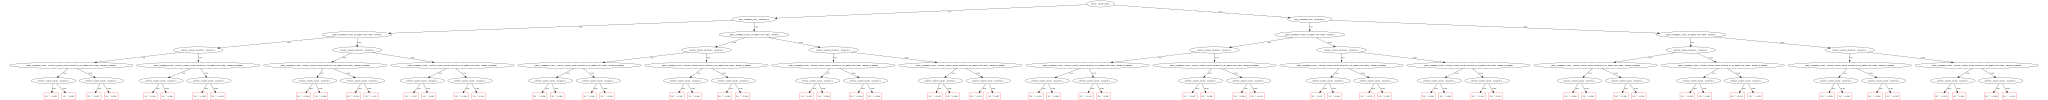

In [33]:
cb_model.plot_tree(tree_idx=40,pool=train_df)

In [34]:
#sorted_feature_importance = cb_model.feature_importances_.argsort()
#plt.barh(cat_features, cb_model.feature_importances_[sorted_feature_importance], color='turquoise')
#plt.xlabel("CatBoost Feature Importance")

In [35]:
# cb_regressor.fit(X_train, y_train ,cat_features = cat_features , plot=True , eval_set = (X_test,y_test))

Reviews per day

In [36]:
y = cat_boost_df["total_reviews_per_days_of_existence"]
X = cat_boost_df_x 

#y.head()
#X.head()

In [37]:
#Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [38]:
train_df = cb.Pool(X_train,y_train,cat_features=cat_features )
test_df = cb.Pool(X_test,y_test,cat_features=cat_features )

In [39]:
cb_model = cb.CatBoostRegressor(loss_function='RMSE')

In [40]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3],
        }



In [41]:
cb_model.grid_search(grid, train_df,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0558452	test: 0.0594545	best: 0.0594545 (0)	total: 13.4ms	remaining: 1.33s
1:	learn: 0.0551120	test: 0.0587612	best: 0.0587612 (1)	total: 26.1ms	remaining: 1.28s
2:	learn: 0.0544351	test: 0.0581305	best: 0.0581305 (2)	total: 47.5ms	remaining: 1.53s
3:	learn: 0.0537766	test: 0.0575108	best: 0.0575108 (3)	total: 60.3ms	remaining: 1.45s
4:	learn: 0.0531631	test: 0.0569351	best: 0.0569351 (4)	total: 78.8ms	remaining: 1.5s
5:	learn: 0.0525537	test: 0.0563676	best: 0.0563676 (5)	total: 97.9ms	remaining: 1.53s
6:	learn: 0.0519519	test: 0.0558116	best: 0.0558116 (6)	total: 117ms	remaining: 1.56s
7:	learn: 0.0513990	test: 0.0552981	best: 0.0552981 (7)	total: 137ms	remaining: 1.57s
8:	learn: 0.0508938	test: 0.0548271	best: 0.0548271 (8)	total: 157ms	remaining: 1.58s
9:	learn: 0.0503951	test: 0.0543670	best: 0.0543670 (9)	total: 175ms	remaining: 1.57s
10:	learn: 0.0498272	test: 0.0538428	best: 0.0538428 (10)	total: 193ms	remaining: 1.56s
11:	learn: 0.0493977	test: 0.0534426	best: 0.05

3:	learn: 0.0487109	test: 0.0528002	best: 0.0528002 (3)	total: 52.9ms	remaining: 1.27s
4:	learn: 0.0472066	test: 0.0514088	best: 0.0514088 (4)	total: 72.7ms	remaining: 1.38s
5:	learn: 0.0460996	test: 0.0504012	best: 0.0504012 (5)	total: 92.1ms	remaining: 1.44s
6:	learn: 0.0451254	test: 0.0495280	best: 0.0495280 (6)	total: 110ms	remaining: 1.46s
7:	learn: 0.0441773	test: 0.0486612	best: 0.0486612 (7)	total: 127ms	remaining: 1.46s
8:	learn: 0.0434468	test: 0.0479324	best: 0.0479324 (8)	total: 146ms	remaining: 1.47s
9:	learn: 0.0428054	test: 0.0472978	best: 0.0472978 (9)	total: 164ms	remaining: 1.48s
10:	learn: 0.0421407	test: 0.0466936	best: 0.0466936 (10)	total: 182ms	remaining: 1.47s
11:	learn: 0.0415827	test: 0.0461617	best: 0.0461617 (11)	total: 201ms	remaining: 1.47s
12:	learn: 0.0411637	test: 0.0457056	best: 0.0457056 (12)	total: 219ms	remaining: 1.47s
13:	learn: 0.0408645	test: 0.0454226	best: 0.0454226 (13)	total: 237ms	remaining: 1.46s
14:	learn: 0.0405892	test: 0.0451734	best: 

2:	learn: 0.0544357	test: 0.0581310	best: 0.0581310 (2)	total: 45.1ms	remaining: 1.46s
3:	learn: 0.0537773	test: 0.0575115	best: 0.0575115 (3)	total: 58.2ms	remaining: 1.4s
4:	learn: 0.0531639	test: 0.0569358	best: 0.0569358 (4)	total: 79ms	remaining: 1.5s
5:	learn: 0.0525547	test: 0.0563685	best: 0.0563685 (5)	total: 99.6ms	remaining: 1.56s
6:	learn: 0.0519530	test: 0.0558127	best: 0.0558127 (6)	total: 121ms	remaining: 1.6s
7:	learn: 0.0514002	test: 0.0552993	best: 0.0552993 (7)	total: 140ms	remaining: 1.6s
8:	learn: 0.0508950	test: 0.0548283	best: 0.0548283 (8)	total: 162ms	remaining: 1.64s
9:	learn: 0.0503964	test: 0.0543682	best: 0.0543682 (9)	total: 182ms	remaining: 1.63s
10:	learn: 0.0498285	test: 0.0538441	best: 0.0538441 (10)	total: 202ms	remaining: 1.63s
11:	learn: 0.0493991	test: 0.0534440	best: 0.0534440 (11)	total: 220ms	remaining: 1.61s
12:	learn: 0.0489621	test: 0.0530391	best: 0.0530391 (12)	total: 240ms	remaining: 1.61s
13:	learn: 0.0485806	test: 0.0526844	best: 0.05268

1:	learn: 0.0520024	test: 0.0558357	best: 0.0558357 (1)	total: 19.7ms	remaining: 966ms
2:	learn: 0.0502165	test: 0.0541915	best: 0.0541915 (2)	total: 36.2ms	remaining: 1.17s
3:	learn: 0.0487124	test: 0.0528016	best: 0.0528016 (3)	total: 45.6ms	remaining: 1.09s
4:	learn: 0.0472081	test: 0.0514102	best: 0.0514102 (4)	total: 60.2ms	remaining: 1.14s
5:	learn: 0.0461012	test: 0.0504028	best: 0.0504028 (5)	total: 75.1ms	remaining: 1.18s
6:	learn: 0.0451271	test: 0.0495296	best: 0.0495296 (6)	total: 89.9ms	remaining: 1.19s
7:	learn: 0.0441788	test: 0.0486626	best: 0.0486626 (7)	total: 104ms	remaining: 1.2s
8:	learn: 0.0434485	test: 0.0479341	best: 0.0479341 (8)	total: 119ms	remaining: 1.2s
9:	learn: 0.0428072	test: 0.0472996	best: 0.0472996 (9)	total: 133ms	remaining: 1.2s
10:	learn: 0.0421424	test: 0.0466953	best: 0.0466953 (10)	total: 148ms	remaining: 1.2s
11:	learn: 0.0415842	test: 0.0461633	best: 0.0461633 (11)	total: 162ms	remaining: 1.19s
12:	learn: 0.0411654	test: 0.0457074	best: 0.045

7:	learn: 0.0513974	test: 0.0552973	best: 0.0552973 (7)	total: 80.4ms	remaining: 925ms
8:	learn: 0.0508921	test: 0.0548258	best: 0.0548258 (8)	total: 93.5ms	remaining: 945ms
9:	learn: 0.0503920	test: 0.0543641	best: 0.0543641 (9)	total: 105ms	remaining: 949ms
10:	learn: 0.0498230	test: 0.0538387	best: 0.0538387 (10)	total: 117ms	remaining: 946ms
11:	learn: 0.0493937	test: 0.0534383	best: 0.0534383 (11)	total: 129ms	remaining: 944ms
12:	learn: 0.0489567	test: 0.0530334	best: 0.0530334 (12)	total: 140ms	remaining: 939ms
13:	learn: 0.0485769	test: 0.0526800	best: 0.0526800 (13)	total: 152ms	remaining: 934ms
14:	learn: 0.0481636	test: 0.0522985	best: 0.0522985 (14)	total: 163ms	remaining: 926ms
15:	learn: 0.0478065	test: 0.0519717	best: 0.0519717 (15)	total: 178ms	remaining: 934ms
16:	learn: 0.0474445	test: 0.0516437	best: 0.0516437 (16)	total: 190ms	remaining: 927ms
17:	learn: 0.0470856	test: 0.0513179	best: 0.0513179 (17)	total: 201ms	remaining: 918ms
18:	learn: 0.0467577	test: 0.0510141

11:	learn: 0.0415868	test: 0.0461660	best: 0.0461660 (11)	total: 162ms	remaining: 1.19s
12:	learn: 0.0411682	test: 0.0457105	best: 0.0457105 (12)	total: 177ms	remaining: 1.18s
13:	learn: 0.0408687	test: 0.0454273	best: 0.0454273 (13)	total: 192ms	remaining: 1.18s
14:	learn: 0.0405931	test: 0.0451777	best: 0.0451777 (14)	total: 206ms	remaining: 1.17s
15:	learn: 0.0403701	test: 0.0450057	best: 0.0450057 (15)	total: 221ms	remaining: 1.16s
16:	learn: 0.0400617	test: 0.0447212	best: 0.0447212 (16)	total: 236ms	remaining: 1.15s
17:	learn: 0.0398674	test: 0.0444661	best: 0.0444661 (17)	total: 251ms	remaining: 1.14s
18:	learn: 0.0397318	test: 0.0443113	best: 0.0443113 (18)	total: 265ms	remaining: 1.13s
19:	learn: 0.0395193	test: 0.0441021	best: 0.0441021 (19)	total: 280ms	remaining: 1.12s
20:	learn: 0.0394030	test: 0.0440017	best: 0.0440017 (20)	total: 294ms	remaining: 1.11s
21:	learn: 0.0393099	test: 0.0438994	best: 0.0438994 (21)	total: 308ms	remaining: 1.09s
22:	learn: 0.0392185	test: 0.043

16:	learn: 0.0474555	test: 0.0516537	best: 0.0516537 (16)	total: 186ms	remaining: 908ms
17:	learn: 0.0470968	test: 0.0513281	best: 0.0513281 (17)	total: 198ms	remaining: 903ms
18:	learn: 0.0467688	test: 0.0510242	best: 0.0510242 (18)	total: 211ms	remaining: 898ms
19:	learn: 0.0464225	test: 0.0506925	best: 0.0506925 (19)	total: 222ms	remaining: 889ms
20:	learn: 0.0461531	test: 0.0504477	best: 0.0504477 (20)	total: 234ms	remaining: 880ms
21:	learn: 0.0458783	test: 0.0502009	best: 0.0502009 (21)	total: 245ms	remaining: 870ms
22:	learn: 0.0455504	test: 0.0498998	best: 0.0498998 (22)	total: 257ms	remaining: 861ms
23:	learn: 0.0452093	test: 0.0495892	best: 0.0495892 (23)	total: 269ms	remaining: 851ms
24:	learn: 0.0449591	test: 0.0493427	best: 0.0493427 (24)	total: 280ms	remaining: 841ms
25:	learn: 0.0446546	test: 0.0490592	best: 0.0490592 (25)	total: 292ms	remaining: 830ms
26:	learn: 0.0443889	test: 0.0487954	best: 0.0487954 (26)	total: 304ms	remaining: 821ms
27:	learn: 0.0441480	test: 0.048

18:	learn: 0.0397394	test: 0.0443206	best: 0.0443206 (18)	total: 267ms	remaining: 1.14s
19:	learn: 0.0395262	test: 0.0441109	best: 0.0441109 (19)	total: 284ms	remaining: 1.14s
20:	learn: 0.0394094	test: 0.0440101	best: 0.0440101 (20)	total: 299ms	remaining: 1.13s
21:	learn: 0.0393161	test: 0.0439076	best: 0.0439076 (21)	total: 314ms	remaining: 1.11s
22:	learn: 0.0392276	test: 0.0437963	best: 0.0437963 (22)	total: 329ms	remaining: 1.1s
23:	learn: 0.0391266	test: 0.0436918	best: 0.0436918 (23)	total: 343ms	remaining: 1.09s
24:	learn: 0.0390383	test: 0.0435588	best: 0.0435588 (24)	total: 358ms	remaining: 1.07s
25:	learn: 0.0389185	test: 0.0433888	best: 0.0433888 (25)	total: 372ms	remaining: 1.06s
26:	learn: 0.0388216	test: 0.0432715	best: 0.0432715 (26)	total: 387ms	remaining: 1.05s
27:	learn: 0.0387276	test: 0.0431754	best: 0.0431754 (27)	total: 402ms	remaining: 1.03s
28:	learn: 0.0386639	test: 0.0430917	best: 0.0430917 (28)	total: 416ms	remaining: 1.02s
29:	learn: 0.0386419	test: 0.0430

12:	learn: 0.0489606	test: 0.0530378	best: 0.0530378 (12)	total: 159ms	remaining: 1.68s
13:	learn: 0.0485790	test: 0.0526830	best: 0.0526830 (13)	total: 173ms	remaining: 1.68s
14:	learn: 0.0481736	test: 0.0523034	best: 0.0523034 (14)	total: 186ms	remaining: 1.67s
15:	learn: 0.0478165	test: 0.0519769	best: 0.0519769 (15)	total: 198ms	remaining: 1.66s
16:	learn: 0.0474554	test: 0.0516501	best: 0.0516501 (16)	total: 210ms	remaining: 1.65s
17:	learn: 0.0470961	test: 0.0513240	best: 0.0513240 (17)	total: 223ms	remaining: 1.63s
18:	learn: 0.0467675	test: 0.0510197	best: 0.0510197 (18)	total: 235ms	remaining: 1.62s
19:	learn: 0.0464200	test: 0.0506868	best: 0.0506868 (19)	total: 247ms	remaining: 1.61s
20:	learn: 0.0461434	test: 0.0504368	best: 0.0504368 (20)	total: 259ms	remaining: 1.59s
21:	learn: 0.0458715	test: 0.0501856	best: 0.0501856 (21)	total: 272ms	remaining: 1.58s
22:	learn: 0.0455434	test: 0.0498842	best: 0.0498842 (22)	total: 287ms	remaining: 1.58s
23:	learn: 0.0452030	test: 0.049

107:	learn: 0.0385248	test: 0.0429369	best: 0.0429369 (107)	total: 1.44s	remaining: 560ms
108:	learn: 0.0385095	test: 0.0429158	best: 0.0429158 (108)	total: 1.45s	remaining: 546ms
109:	learn: 0.0385008	test: 0.0429074	best: 0.0429074 (109)	total: 1.46s	remaining: 532ms
110:	learn: 0.0384823	test: 0.0428829	best: 0.0428829 (110)	total: 1.47s	remaining: 518ms
111:	learn: 0.0384638	test: 0.0428629	best: 0.0428629 (111)	total: 1.49s	remaining: 504ms
112:	learn: 0.0384408	test: 0.0428395	best: 0.0428395 (112)	total: 1.5s	remaining: 490ms
113:	learn: 0.0384318	test: 0.0428204	best: 0.0428204 (113)	total: 1.51s	remaining: 477ms
114:	learn: 0.0384097	test: 0.0427947	best: 0.0427947 (114)	total: 1.52s	remaining: 463ms
115:	learn: 0.0383878	test: 0.0427636	best: 0.0427636 (115)	total: 1.53s	remaining: 449ms
116:	learn: 0.0383768	test: 0.0427446	best: 0.0427446 (116)	total: 1.54s	remaining: 436ms
117:	learn: 0.0383592	test: 0.0427230	best: 0.0427230 (117)	total: 1.56s	remaining: 423ms
118:	learn:

61:	learn: 0.0375492	test: 0.0416361	best: 0.0416361 (61)	total: 824ms	remaining: 1.17s
62:	learn: 0.0375347	test: 0.0416244	best: 0.0416244 (62)	total: 837ms	remaining: 1.16s
63:	learn: 0.0375060	test: 0.0415967	best: 0.0415967 (63)	total: 850ms	remaining: 1.14s
64:	learn: 0.0375011	test: 0.0415884	best: 0.0415884 (64)	total: 862ms	remaining: 1.13s
65:	learn: 0.0374864	test: 0.0415994	best: 0.0415884 (64)	total: 874ms	remaining: 1.11s
66:	learn: 0.0374512	test: 0.0415689	best: 0.0415689 (66)	total: 885ms	remaining: 1.1s
67:	learn: 0.0374458	test: 0.0415657	best: 0.0415657 (67)	total: 897ms	remaining: 1.08s
68:	learn: 0.0374297	test: 0.0415353	best: 0.0415353 (68)	total: 908ms	remaining: 1.07s
69:	learn: 0.0374154	test: 0.0415230	best: 0.0415230 (69)	total: 920ms	remaining: 1.05s
70:	learn: 0.0374056	test: 0.0415086	best: 0.0415086 (70)	total: 931ms	remaining: 1.04s
71:	learn: 0.0374033	test: 0.0415110	best: 0.0415086 (70)	total: 943ms	remaining: 1.02s
72:	learn: 0.0373799	test: 0.0415

5:	learn: 0.0525547	test: 0.0563685	best: 0.0563685 (5)	total: 57.9ms	remaining: 1.39s
6:	learn: 0.0519530	test: 0.0558127	best: 0.0558127 (6)	total: 70.5ms	remaining: 1.44s
7:	learn: 0.0514002	test: 0.0552993	best: 0.0552993 (7)	total: 82.2ms	remaining: 1.46s
8:	learn: 0.0508950	test: 0.0548283	best: 0.0548283 (8)	total: 94.1ms	remaining: 1.47s
9:	learn: 0.0503964	test: 0.0543682	best: 0.0543682 (9)	total: 106ms	remaining: 1.48s
10:	learn: 0.0498285	test: 0.0538441	best: 0.0538441 (10)	total: 117ms	remaining: 1.48s
11:	learn: 0.0493991	test: 0.0534440	best: 0.0534440 (11)	total: 129ms	remaining: 1.48s
12:	learn: 0.0489621	test: 0.0530391	best: 0.0530391 (12)	total: 140ms	remaining: 1.47s
13:	learn: 0.0485806	test: 0.0526844	best: 0.0526844 (13)	total: 151ms	remaining: 1.47s
14:	learn: 0.0481752	test: 0.0523049	best: 0.0523049 (14)	total: 163ms	remaining: 1.47s
15:	learn: 0.0478181	test: 0.0519784	best: 0.0519784 (15)	total: 174ms	remaining: 1.46s
16:	learn: 0.0474570	test: 0.0516515	b

102:	learn: 0.0386055	test: 0.0430474	best: 0.0430474 (102)	total: 1.35s	remaining: 617ms
103:	learn: 0.0385804	test: 0.0430173	best: 0.0430173 (103)	total: 1.37s	remaining: 605ms
104:	learn: 0.0385638	test: 0.0429983	best: 0.0429983 (104)	total: 1.38s	remaining: 593ms
105:	learn: 0.0385522	test: 0.0429760	best: 0.0429760 (105)	total: 1.4s	remaining: 580ms
106:	learn: 0.0385350	test: 0.0429547	best: 0.0429547 (106)	total: 1.41s	remaining: 567ms
107:	learn: 0.0385208	test: 0.0429323	best: 0.0429323 (107)	total: 1.43s	remaining: 555ms
108:	learn: 0.0385055	test: 0.0429112	best: 0.0429112 (108)	total: 1.44s	remaining: 542ms
109:	learn: 0.0384967	test: 0.0429028	best: 0.0429028 (109)	total: 1.45s	remaining: 529ms
110:	learn: 0.0384908	test: 0.0428975	best: 0.0428975 (110)	total: 1.47s	remaining: 516ms
111:	learn: 0.0384728	test: 0.0428820	best: 0.0428820 (111)	total: 1.48s	remaining: 504ms
112:	learn: 0.0384494	test: 0.0428580	best: 0.0428580 (112)	total: 1.5s	remaining: 491ms
113:	learn: 

49:	learn: 0.0377799	test: 0.0419680	best: 0.0419680 (49)	total: 736ms	remaining: 1.47s
50:	learn: 0.0377646	test: 0.0419458	best: 0.0419458 (50)	total: 751ms	remaining: 1.46s
51:	learn: 0.0377460	test: 0.0419143	best: 0.0419143 (51)	total: 766ms	remaining: 1.44s
52:	learn: 0.0377296	test: 0.0418961	best: 0.0418961 (52)	total: 784ms	remaining: 1.43s
53:	learn: 0.0377089	test: 0.0418441	best: 0.0418441 (53)	total: 801ms	remaining: 1.42s
54:	learn: 0.0376802	test: 0.0418138	best: 0.0418138 (54)	total: 817ms	remaining: 1.41s
55:	learn: 0.0376485	test: 0.0417839	best: 0.0417839 (55)	total: 833ms	remaining: 1.4s
56:	learn: 0.0376414	test: 0.0417717	best: 0.0417717 (56)	total: 854ms	remaining: 1.39s
57:	learn: 0.0376248	test: 0.0417434	best: 0.0417434 (57)	total: 870ms	remaining: 1.38s
58:	learn: 0.0376131	test: 0.0417276	best: 0.0417276 (58)	total: 884ms	remaining: 1.36s
59:	learn: 0.0376011	test: 0.0417139	best: 0.0417139 (59)	total: 899ms	remaining: 1.35s
60:	learn: 0.0375826	test: 0.0416

145:	learn: 0.0365144	test: 0.0410847	best: 0.0410325 (139)	total: 2.29s	remaining: 62.7ms
146:	learn: 0.0365002	test: 0.0410820	best: 0.0410325 (139)	total: 2.31s	remaining: 47.1ms
147:	learn: 0.0364857	test: 0.0410741	best: 0.0410325 (139)	total: 2.32s	remaining: 31.4ms
148:	learn: 0.0364745	test: 0.0410691	best: 0.0410325 (139)	total: 2.34s	remaining: 15.7ms
149:	learn: 0.0364624	test: 0.0410540	best: 0.0410325 (139)	total: 2.35s	remaining: 0us

bestTest = 0.04103251418
bestIteration = 139

11:	loss: 0.0410325	best: 0.0410311 (9)	total: 21.4s	remaining: 2m 30s
0:	learn: 0.0558457	test: 0.0594549	best: 0.0594549 (0)	total: 11ms	remaining: 1.64s
1:	learn: 0.0551130	test: 0.0587621	best: 0.0587621 (1)	total: 20.7ms	remaining: 1.53s
2:	learn: 0.0544366	test: 0.0581319	best: 0.0581319 (2)	total: 36.7ms	remaining: 1.8s
3:	learn: 0.0537785	test: 0.0575126	best: 0.0575126 (3)	total: 47.1ms	remaining: 1.72s
4:	learn: 0.0531652	test: 0.0569370	best: 0.0569370 (4)	total: 62.9ms	remaining: 1.82

88:	learn: 0.0389142	test: 0.0434220	best: 0.0434220 (88)	total: 1.49s	remaining: 1.02s
89:	learn: 0.0388796	test: 0.0433854	best: 0.0433854 (89)	total: 1.51s	remaining: 1.01s
90:	learn: 0.0388566	test: 0.0433630	best: 0.0433630 (90)	total: 1.53s	remaining: 992ms
91:	learn: 0.0388381	test: 0.0433342	best: 0.0433342 (91)	total: 1.55s	remaining: 975ms
92:	learn: 0.0388159	test: 0.0433097	best: 0.0433097 (92)	total: 1.56s	remaining: 959ms
93:	learn: 0.0387855	test: 0.0432791	best: 0.0432791 (93)	total: 1.58s	remaining: 943ms
94:	learn: 0.0387612	test: 0.0432443	best: 0.0432443 (94)	total: 1.6s	remaining: 927ms
95:	learn: 0.0387333	test: 0.0432162	best: 0.0432162 (95)	total: 1.62s	remaining: 909ms
96:	learn: 0.0387165	test: 0.0431835	best: 0.0431835 (96)	total: 1.63s	remaining: 892ms
97:	learn: 0.0387020	test: 0.0431681	best: 0.0431681 (97)	total: 1.65s	remaining: 875ms
98:	learn: 0.0386783	test: 0.0431456	best: 0.0431456 (98)	total: 1.67s	remaining: 858ms
99:	learn: 0.0386558	test: 0.0431

35:	learn: 0.0382505	test: 0.0425590	best: 0.0425590 (35)	total: 517ms	remaining: 1.64s
36:	learn: 0.0382080	test: 0.0425237	best: 0.0425237 (36)	total: 529ms	remaining: 1.62s
37:	learn: 0.0381768	test: 0.0424837	best: 0.0424837 (37)	total: 541ms	remaining: 1.59s
38:	learn: 0.0381308	test: 0.0424508	best: 0.0424508 (38)	total: 552ms	remaining: 1.57s
39:	learn: 0.0380939	test: 0.0424155	best: 0.0424155 (39)	total: 564ms	remaining: 1.55s
40:	learn: 0.0380762	test: 0.0423941	best: 0.0423941 (40)	total: 575ms	remaining: 1.53s
41:	learn: 0.0380192	test: 0.0423040	best: 0.0423040 (41)	total: 587ms	remaining: 1.51s
42:	learn: 0.0379819	test: 0.0422812	best: 0.0422812 (42)	total: 598ms	remaining: 1.49s
43:	learn: 0.0379533	test: 0.0422458	best: 0.0422458 (43)	total: 610ms	remaining: 1.47s
44:	learn: 0.0379275	test: 0.0422260	best: 0.0422260 (44)	total: 622ms	remaining: 1.45s
45:	learn: 0.0378873	test: 0.0421623	best: 0.0421623 (45)	total: 634ms	remaining: 1.43s
46:	learn: 0.0378552	test: 0.042

130:	learn: 0.0366469	test: 0.0410537	best: 0.0410416 (128)	total: 1.64s	remaining: 239ms
131:	learn: 0.0366427	test: 0.0410586	best: 0.0410416 (128)	total: 1.66s	remaining: 226ms
132:	learn: 0.0366239	test: 0.0410290	best: 0.0410290 (132)	total: 1.67s	remaining: 213ms
133:	learn: 0.0366084	test: 0.0410418	best: 0.0410290 (132)	total: 1.68s	remaining: 201ms
134:	learn: 0.0366031	test: 0.0410346	best: 0.0410290 (132)	total: 1.69s	remaining: 188ms
135:	learn: 0.0365863	test: 0.0410428	best: 0.0410290 (132)	total: 1.7s	remaining: 175ms
136:	learn: 0.0365841	test: 0.0410372	best: 0.0410290 (132)	total: 1.72s	remaining: 163ms
137:	learn: 0.0365695	test: 0.0410383	best: 0.0410290 (132)	total: 1.73s	remaining: 150ms
138:	learn: 0.0365694	test: 0.0410386	best: 0.0410290 (132)	total: 1.74s	remaining: 138ms
139:	learn: 0.0365498	test: 0.0410390	best: 0.0410290 (132)	total: 1.75s	remaining: 125ms
140:	learn: 0.0365476	test: 0.0410351	best: 0.0410290 (132)	total: 1.76s	remaining: 112ms
141:	learn:

72:	learn: 0.0394356	test: 0.0439985	best: 0.0439985 (72)	total: 877ms	remaining: 925ms
73:	learn: 0.0394025	test: 0.0439559	best: 0.0439559 (73)	total: 890ms	remaining: 914ms
74:	learn: 0.0393548	test: 0.0439103	best: 0.0439103 (74)	total: 902ms	remaining: 902ms
75:	learn: 0.0393203	test: 0.0438656	best: 0.0438656 (75)	total: 916ms	remaining: 892ms
76:	learn: 0.0392954	test: 0.0438284	best: 0.0438284 (76)	total: 931ms	remaining: 883ms
77:	learn: 0.0392563	test: 0.0438003	best: 0.0438003 (77)	total: 946ms	remaining: 874ms
78:	learn: 0.0392333	test: 0.0437786	best: 0.0437786 (78)	total: 960ms	remaining: 863ms
79:	learn: 0.0391915	test: 0.0437290	best: 0.0437290 (79)	total: 972ms	remaining: 850ms
80:	learn: 0.0391491	test: 0.0436846	best: 0.0436846 (80)	total: 983ms	remaining: 837ms
81:	learn: 0.0391108	test: 0.0436387	best: 0.0436387 (81)	total: 995ms	remaining: 825ms
82:	learn: 0.0390836	test: 0.0436100	best: 0.0436100 (82)	total: 1s	remaining: 812ms
83:	learn: 0.0390562	test: 0.043577

20:	learn: 0.0394094	test: 0.0440101	best: 0.0440101 (20)	total: 294ms	remaining: 1.8s
21:	learn: 0.0393161	test: 0.0439076	best: 0.0439076 (21)	total: 309ms	remaining: 1.8s
22:	learn: 0.0392276	test: 0.0437963	best: 0.0437963 (22)	total: 324ms	remaining: 1.79s
23:	learn: 0.0391266	test: 0.0436918	best: 0.0436918 (23)	total: 338ms	remaining: 1.77s
24:	learn: 0.0390383	test: 0.0435588	best: 0.0435588 (24)	total: 353ms	remaining: 1.76s
25:	learn: 0.0389185	test: 0.0433888	best: 0.0433888 (25)	total: 368ms	remaining: 1.75s
26:	learn: 0.0388216	test: 0.0432715	best: 0.0432715 (26)	total: 382ms	remaining: 1.74s
27:	learn: 0.0387276	test: 0.0431754	best: 0.0431754 (27)	total: 397ms	remaining: 1.73s
28:	learn: 0.0386639	test: 0.0430917	best: 0.0430917 (28)	total: 411ms	remaining: 1.72s
29:	learn: 0.0386419	test: 0.0430757	best: 0.0430757 (29)	total: 426ms	remaining: 1.7s
30:	learn: 0.0385597	test: 0.0429691	best: 0.0429691 (30)	total: 440ms	remaining: 1.69s
31:	learn: 0.0384686	test: 0.042865

118:	learn: 0.0368138	test: 0.0411580	best: 0.0411378 (109)	total: 1.55s	remaining: 405ms
119:	learn: 0.0368101	test: 0.0411630	best: 0.0411378 (109)	total: 1.57s	remaining: 393ms
120:	learn: 0.0368070	test: 0.0411579	best: 0.0411378 (109)	total: 1.59s	remaining: 380ms
121:	learn: 0.0367962	test: 0.0411440	best: 0.0411378 (109)	total: 1.6s	remaining: 368ms
122:	learn: 0.0367962	test: 0.0411439	best: 0.0411378 (109)	total: 1.62s	remaining: 355ms
123:	learn: 0.0367749	test: 0.0411408	best: 0.0411378 (109)	total: 1.63s	remaining: 342ms
124:	learn: 0.0367633	test: 0.0411344	best: 0.0411344 (124)	total: 1.65s	remaining: 330ms
125:	learn: 0.0367600	test: 0.0411341	best: 0.0411341 (125)	total: 1.67s	remaining: 317ms
126:	learn: 0.0367436	test: 0.0411477	best: 0.0411341 (125)	total: 1.68s	remaining: 304ms
127:	learn: 0.0367410	test: 0.0411374	best: 0.0411341 (125)	total: 1.7s	remaining: 292ms
128:	learn: 0.0367345	test: 0.0411293	best: 0.0411293 (128)	total: 1.71s	remaining: 279ms
129:	learn: 

65:	learn: 0.0397896	test: 0.0443497	best: 0.0443497 (65)	total: 1.09s	remaining: 2.21s
66:	learn: 0.0397190	test: 0.0442816	best: 0.0442816 (66)	total: 1.11s	remaining: 2.2s
67:	learn: 0.0396672	test: 0.0442409	best: 0.0442409 (67)	total: 1.12s	remaining: 2.18s
68:	learn: 0.0396236	test: 0.0441798	best: 0.0441798 (68)	total: 1.14s	remaining: 2.16s
69:	learn: 0.0395859	test: 0.0441403	best: 0.0441403 (69)	total: 1.15s	remaining: 2.13s
70:	learn: 0.0395201	test: 0.0440715	best: 0.0440715 (70)	total: 1.16s	remaining: 2.11s
71:	learn: 0.0394801	test: 0.0440403	best: 0.0440403 (71)	total: 1.17s	remaining: 2.09s
72:	learn: 0.0394298	test: 0.0439867	best: 0.0439867 (72)	total: 1.19s	remaining: 2.06s
73:	learn: 0.0393887	test: 0.0439346	best: 0.0439346 (73)	total: 1.2s	remaining: 2.04s
74:	learn: 0.0393625	test: 0.0439010	best: 0.0439010 (74)	total: 1.21s	remaining: 2.02s
75:	learn: 0.0393168	test: 0.0438517	best: 0.0438517 (75)	total: 1.22s	remaining: 1.99s
76:	learn: 0.0392864	test: 0.04382

168:	learn: 0.0378480	test: 0.0420995	best: 0.0420995 (168)	total: 2.34s	remaining: 429ms
169:	learn: 0.0378465	test: 0.0420948	best: 0.0420948 (169)	total: 2.35s	remaining: 415ms
170:	learn: 0.0378377	test: 0.0420888	best: 0.0420888 (170)	total: 2.36s	remaining: 401ms
171:	learn: 0.0378275	test: 0.0420784	best: 0.0420784 (171)	total: 2.38s	remaining: 387ms
172:	learn: 0.0378244	test: 0.0420715	best: 0.0420715 (172)	total: 2.39s	remaining: 373ms
173:	learn: 0.0378204	test: 0.0420658	best: 0.0420658 (173)	total: 2.4s	remaining: 358ms
174:	learn: 0.0378166	test: 0.0420614	best: 0.0420614 (174)	total: 2.41s	remaining: 344ms
175:	learn: 0.0378116	test: 0.0420510	best: 0.0420510 (175)	total: 2.42s	remaining: 330ms
176:	learn: 0.0378076	test: 0.0420480	best: 0.0420480 (176)	total: 2.43s	remaining: 316ms
177:	learn: 0.0378002	test: 0.0420362	best: 0.0420362 (177)	total: 2.45s	remaining: 302ms
178:	learn: 0.0377881	test: 0.0420293	best: 0.0420293 (178)	total: 2.46s	remaining: 288ms
179:	learn:

60:	learn: 0.0376927	test: 0.0418063	best: 0.0418063 (60)	total: 929ms	remaining: 2.12s
61:	learn: 0.0376795	test: 0.0417940	best: 0.0417940 (61)	total: 944ms	remaining: 2.1s
62:	learn: 0.0376556	test: 0.0417849	best: 0.0417849 (62)	total: 955ms	remaining: 2.08s
63:	learn: 0.0376258	test: 0.0417381	best: 0.0417381 (63)	total: 966ms	remaining: 2.05s
64:	learn: 0.0375934	test: 0.0416936	best: 0.0416936 (64)	total: 978ms	remaining: 2.03s
65:	learn: 0.0375649	test: 0.0416789	best: 0.0416789 (65)	total: 990ms	remaining: 2.01s
66:	learn: 0.0375476	test: 0.0416738	best: 0.0416738 (66)	total: 1s	remaining: 1.99s
67:	learn: 0.0375351	test: 0.0416606	best: 0.0416606 (67)	total: 1.01s	remaining: 1.97s
68:	learn: 0.0375258	test: 0.0416547	best: 0.0416547 (68)	total: 1.02s	remaining: 1.95s
69:	learn: 0.0375169	test: 0.0416676	best: 0.0416547 (68)	total: 1.04s	remaining: 1.92s
70:	learn: 0.0374854	test: 0.0416518	best: 0.0416518 (70)	total: 1.05s	remaining: 1.9s
71:	learn: 0.0374663	test: 0.0416331	

153:	learn: 0.0364915	test: 0.0410265	best: 0.0410265 (153)	total: 2.05s	remaining: 612ms
154:	learn: 0.0364911	test: 0.0410277	best: 0.0410265 (153)	total: 2.06s	remaining: 599ms
155:	learn: 0.0364833	test: 0.0410271	best: 0.0410265 (153)	total: 2.07s	remaining: 585ms
156:	learn: 0.0364815	test: 0.0410298	best: 0.0410265 (153)	total: 2.08s	remaining: 571ms
157:	learn: 0.0364796	test: 0.0410261	best: 0.0410261 (157)	total: 2.1s	remaining: 557ms
158:	learn: 0.0364426	test: 0.0410676	best: 0.0410261 (157)	total: 2.11s	remaining: 544ms
159:	learn: 0.0364392	test: 0.0410631	best: 0.0410261 (157)	total: 2.12s	remaining: 530ms
160:	learn: 0.0364387	test: 0.0410630	best: 0.0410261 (157)	total: 2.13s	remaining: 517ms
161:	learn: 0.0364162	test: 0.0411068	best: 0.0410261 (157)	total: 2.14s	remaining: 503ms
162:	learn: 0.0363978	test: 0.0411055	best: 0.0410261 (157)	total: 2.16s	remaining: 489ms
163:	learn: 0.0363957	test: 0.0411071	best: 0.0410261 (157)	total: 2.17s	remaining: 476ms
164:	learn:

46:	learn: 0.0412309	test: 0.0458672	best: 0.0458672 (46)	total: 561ms	remaining: 1.83s
47:	learn: 0.0411139	test: 0.0457378	best: 0.0457378 (47)	total: 575ms	remaining: 1.82s
48:	learn: 0.0410171	test: 0.0456355	best: 0.0456355 (48)	total: 588ms	remaining: 1.81s
49:	learn: 0.0409259	test: 0.0455385	best: 0.0455385 (49)	total: 602ms	remaining: 1.81s
50:	learn: 0.0408110	test: 0.0454284	best: 0.0454284 (50)	total: 615ms	remaining: 1.79s
51:	learn: 0.0407418	test: 0.0453550	best: 0.0453550 (51)	total: 627ms	remaining: 1.78s
52:	learn: 0.0406807	test: 0.0453030	best: 0.0453030 (52)	total: 639ms	remaining: 1.77s
53:	learn: 0.0405751	test: 0.0451955	best: 0.0451955 (53)	total: 651ms	remaining: 1.76s
54:	learn: 0.0405074	test: 0.0451116	best: 0.0451116 (54)	total: 662ms	remaining: 1.75s
55:	learn: 0.0404229	test: 0.0450294	best: 0.0450294 (55)	total: 674ms	remaining: 1.73s
56:	learn: 0.0403591	test: 0.0449635	best: 0.0449635 (56)	total: 686ms	remaining: 1.72s
57:	learn: 0.0402859	test: 0.044

149:	learn: 0.0380120	test: 0.0423074	best: 0.0423074 (149)	total: 2.07s	remaining: 690ms
150:	learn: 0.0380008	test: 0.0423023	best: 0.0423023 (150)	total: 2.09s	remaining: 678ms
151:	learn: 0.0379913	test: 0.0422869	best: 0.0422869 (151)	total: 2.1s	remaining: 665ms
152:	learn: 0.0379828	test: 0.0422773	best: 0.0422773 (152)	total: 2.12s	remaining: 652ms
153:	learn: 0.0379703	test: 0.0422603	best: 0.0422603 (153)	total: 2.14s	remaining: 639ms
154:	learn: 0.0379640	test: 0.0422494	best: 0.0422494 (154)	total: 2.15s	remaining: 625ms
155:	learn: 0.0379572	test: 0.0422375	best: 0.0422375 (155)	total: 2.17s	remaining: 612ms
156:	learn: 0.0379474	test: 0.0422289	best: 0.0422289 (156)	total: 2.18s	remaining: 598ms
157:	learn: 0.0379446	test: 0.0422236	best: 0.0422236 (157)	total: 2.2s	remaining: 584ms
158:	learn: 0.0379335	test: 0.0422084	best: 0.0422084 (158)	total: 2.21s	remaining: 571ms
159:	learn: 0.0379249	test: 0.0421963	best: 0.0421963 (159)	total: 2.23s	remaining: 557ms
160:	learn: 

41:	learn: 0.0381764	test: 0.0423281	best: 0.0423281 (41)	total: 545ms	remaining: 2.05s
42:	learn: 0.0381468	test: 0.0422923	best: 0.0422923 (42)	total: 559ms	remaining: 2.04s
43:	learn: 0.0381246	test: 0.0422644	best: 0.0422644 (43)	total: 573ms	remaining: 2.03s
44:	learn: 0.0380867	test: 0.0422241	best: 0.0422241 (44)	total: 587ms	remaining: 2.02s
45:	learn: 0.0380352	test: 0.0421227	best: 0.0421227 (45)	total: 601ms	remaining: 2.01s
46:	learn: 0.0380123	test: 0.0421016	best: 0.0421016 (46)	total: 618ms	remaining: 2.01s
47:	learn: 0.0379842	test: 0.0420660	best: 0.0420660 (47)	total: 631ms	remaining: 2s
48:	learn: 0.0379784	test: 0.0420616	best: 0.0420616 (48)	total: 643ms	remaining: 1.98s
49:	learn: 0.0379553	test: 0.0420317	best: 0.0420317 (49)	total: 656ms	remaining: 1.97s
50:	learn: 0.0379330	test: 0.0420144	best: 0.0420144 (50)	total: 669ms	remaining: 1.96s
51:	learn: 0.0379048	test: 0.0419896	best: 0.0419896 (51)	total: 683ms	remaining: 1.94s
52:	learn: 0.0378810	test: 0.041969

141:	learn: 0.0365985	test: 0.0410911	best: 0.0410911 (141)	total: 2.39s	remaining: 976ms
142:	learn: 0.0365835	test: 0.0410855	best: 0.0410855 (142)	total: 2.41s	remaining: 959ms
143:	learn: 0.0365722	test: 0.0410792	best: 0.0410792 (143)	total: 2.42s	remaining: 942ms
144:	learn: 0.0365668	test: 0.0410791	best: 0.0410791 (144)	total: 2.44s	remaining: 925ms
145:	learn: 0.0365473	test: 0.0410847	best: 0.0410791 (144)	total: 2.46s	remaining: 908ms
146:	learn: 0.0365446	test: 0.0410805	best: 0.0410791 (144)	total: 2.47s	remaining: 891ms
147:	learn: 0.0365310	test: 0.0410682	best: 0.0410682 (147)	total: 2.49s	remaining: 874ms
148:	learn: 0.0365264	test: 0.0410726	best: 0.0410682 (147)	total: 2.5s	remaining: 857ms
149:	learn: 0.0365259	test: 0.0410726	best: 0.0410682 (147)	total: 2.52s	remaining: 840ms
150:	learn: 0.0365222	test: 0.0410693	best: 0.0410682 (147)	total: 2.54s	remaining: 823ms
151:	learn: 0.0365198	test: 0.0410751	best: 0.0410682 (147)	total: 2.55s	remaining: 806ms
152:	learn:

33:	learn: 0.0429255	test: 0.0474573	best: 0.0474573 (33)	total: 537ms	remaining: 2.62s
34:	learn: 0.0427699	test: 0.0473163	best: 0.0473163 (34)	total: 550ms	remaining: 2.59s
35:	learn: 0.0426253	test: 0.0471696	best: 0.0471696 (35)	total: 562ms	remaining: 2.56s
36:	learn: 0.0424450	test: 0.0470032	best: 0.0470032 (36)	total: 574ms	remaining: 2.53s
37:	learn: 0.0423074	test: 0.0468602	best: 0.0468602 (37)	total: 586ms	remaining: 2.5s
38:	learn: 0.0421720	test: 0.0467306	best: 0.0467306 (38)	total: 598ms	remaining: 2.47s
39:	learn: 0.0420546	test: 0.0466337	best: 0.0466337 (39)	total: 611ms	remaining: 2.44s
40:	learn: 0.0419353	test: 0.0465247	best: 0.0465247 (40)	total: 623ms	remaining: 2.42s
41:	learn: 0.0418008	test: 0.0463931	best: 0.0463931 (41)	total: 642ms	remaining: 2.42s
42:	learn: 0.0416582	test: 0.0462587	best: 0.0462587 (42)	total: 654ms	remaining: 2.39s
43:	learn: 0.0415596	test: 0.0461576	best: 0.0461576 (43)	total: 667ms	remaining: 2.36s
44:	learn: 0.0414184	test: 0.0460

129:	learn: 0.0382016	test: 0.0425514	best: 0.0425514 (129)	total: 1.67s	remaining: 897ms
130:	learn: 0.0381905	test: 0.0425356	best: 0.0425356 (130)	total: 1.68s	remaining: 885ms
131:	learn: 0.0381776	test: 0.0425163	best: 0.0425163 (131)	total: 1.69s	remaining: 872ms
132:	learn: 0.0381615	test: 0.0424969	best: 0.0424969 (132)	total: 1.7s	remaining: 858ms
133:	learn: 0.0381544	test: 0.0424882	best: 0.0424882 (133)	total: 1.72s	remaining: 845ms
134:	learn: 0.0381466	test: 0.0424780	best: 0.0424780 (134)	total: 1.73s	remaining: 832ms
135:	learn: 0.0381351	test: 0.0424693	best: 0.0424693 (135)	total: 1.74s	remaining: 819ms
136:	learn: 0.0381215	test: 0.0424557	best: 0.0424557 (136)	total: 1.75s	remaining: 806ms
137:	learn: 0.0381142	test: 0.0424508	best: 0.0424508 (137)	total: 1.76s	remaining: 792ms
138:	learn: 0.0381061	test: 0.0424478	best: 0.0424478 (138)	total: 1.77s	remaining: 779ms
139:	learn: 0.0380984	test: 0.0424402	best: 0.0424402 (139)	total: 1.79s	remaining: 766ms
140:	learn:

23:	learn: 0.0391107	test: 0.0435120	best: 0.0435120 (23)	total: 232ms	remaining: 1.7s
24:	learn: 0.0390308	test: 0.0434262	best: 0.0434262 (24)	total: 244ms	remaining: 1.71s
25:	learn: 0.0389545	test: 0.0433676	best: 0.0433676 (25)	total: 257ms	remaining: 1.72s
26:	learn: 0.0388905	test: 0.0432679	best: 0.0432679 (26)	total: 269ms	remaining: 1.72s
27:	learn: 0.0388044	test: 0.0431611	best: 0.0431611 (27)	total: 281ms	remaining: 1.72s
28:	learn: 0.0387504	test: 0.0430950	best: 0.0430950 (28)	total: 293ms	remaining: 1.73s
29:	learn: 0.0386506	test: 0.0429567	best: 0.0429567 (29)	total: 305ms	remaining: 1.73s
30:	learn: 0.0385927	test: 0.0428691	best: 0.0428691 (30)	total: 317ms	remaining: 1.73s
31:	learn: 0.0385485	test: 0.0428232	best: 0.0428232 (31)	total: 329ms	remaining: 1.73s
32:	learn: 0.0384955	test: 0.0427481	best: 0.0427481 (32)	total: 341ms	remaining: 1.73s
33:	learn: 0.0384834	test: 0.0427120	best: 0.0427120 (33)	total: 354ms	remaining: 1.73s
34:	learn: 0.0384685	test: 0.0426

116:	learn: 0.0368405	test: 0.0412153	best: 0.0412153 (116)	total: 1.37s	remaining: 971ms
117:	learn: 0.0368372	test: 0.0412061	best: 0.0412061 (117)	total: 1.38s	remaining: 962ms
118:	learn: 0.0368358	test: 0.0411995	best: 0.0411995 (118)	total: 1.4s	remaining: 950ms
119:	learn: 0.0368142	test: 0.0411777	best: 0.0411777 (119)	total: 1.41s	remaining: 939ms
120:	learn: 0.0367987	test: 0.0411765	best: 0.0411765 (120)	total: 1.42s	remaining: 927ms
121:	learn: 0.0367968	test: 0.0411725	best: 0.0411725 (121)	total: 1.43s	remaining: 915ms
122:	learn: 0.0367761	test: 0.0411672	best: 0.0411672 (122)	total: 1.44s	remaining: 903ms
123:	learn: 0.0367745	test: 0.0411662	best: 0.0411662 (123)	total: 1.45s	remaining: 891ms
124:	learn: 0.0367691	test: 0.0411615	best: 0.0411615 (124)	total: 1.47s	remaining: 879ms
125:	learn: 0.0367627	test: 0.0411649	best: 0.0411615 (124)	total: 1.48s	remaining: 868ms
126:	learn: 0.0367615	test: 0.0411640	best: 0.0411615 (124)	total: 1.49s	remaining: 856ms
127:	learn:

7:	learn: 0.0513851	test: 0.0553099	best: 0.0553099 (7)	total: 88.1ms	remaining: 2.11s
8:	learn: 0.0508811	test: 0.0548387	best: 0.0548387 (8)	total: 101ms	remaining: 2.13s
9:	learn: 0.0503166	test: 0.0543106	best: 0.0543106 (9)	total: 114ms	remaining: 2.17s
10:	learn: 0.0498354	test: 0.0538648	best: 0.0538648 (10)	total: 126ms	remaining: 2.17s
11:	learn: 0.0493767	test: 0.0534387	best: 0.0534387 (11)	total: 138ms	remaining: 2.16s
12:	learn: 0.0489507	test: 0.0530253	best: 0.0530253 (12)	total: 150ms	remaining: 2.16s
13:	learn: 0.0485310	test: 0.0526373	best: 0.0526373 (13)	total: 162ms	remaining: 2.15s
14:	learn: 0.0481402	test: 0.0522802	best: 0.0522802 (14)	total: 174ms	remaining: 2.14s
15:	learn: 0.0477735	test: 0.0519404	best: 0.0519404 (15)	total: 185ms	remaining: 2.13s
16:	learn: 0.0474130	test: 0.0516348	best: 0.0516348 (16)	total: 197ms	remaining: 2.12s
17:	learn: 0.0470501	test: 0.0512848	best: 0.0512848 (17)	total: 209ms	remaining: 2.12s
18:	learn: 0.0466641	test: 0.0509270	

113:	learn: 0.0384702	test: 0.0428951	best: 0.0428951 (113)	total: 1.38s	remaining: 1.04s
114:	learn: 0.0384561	test: 0.0428848	best: 0.0428848 (114)	total: 1.4s	remaining: 1.03s
115:	learn: 0.0384348	test: 0.0428625	best: 0.0428625 (115)	total: 1.41s	remaining: 1.02s
116:	learn: 0.0384258	test: 0.0428508	best: 0.0428508 (116)	total: 1.42s	remaining: 1.01s
117:	learn: 0.0384151	test: 0.0428396	best: 0.0428396 (117)	total: 1.43s	remaining: 996ms
118:	learn: 0.0384000	test: 0.0428119	best: 0.0428119 (118)	total: 1.44s	remaining: 983ms
119:	learn: 0.0383934	test: 0.0427986	best: 0.0427986 (119)	total: 1.46s	remaining: 971ms
120:	learn: 0.0383854	test: 0.0427887	best: 0.0427887 (120)	total: 1.47s	remaining: 959ms
121:	learn: 0.0383783	test: 0.0427877	best: 0.0427877 (121)	total: 1.48s	remaining: 947ms
122:	learn: 0.0383623	test: 0.0427670	best: 0.0427670 (122)	total: 1.49s	remaining: 934ms
123:	learn: 0.0383501	test: 0.0427464	best: 0.0427464 (123)	total: 1.5s	remaining: 922ms
124:	learn: 

10:	learn: 0.0422975	test: 0.0468925	best: 0.0468925 (10)	total: 155ms	remaining: 2.67s
11:	learn: 0.0417233	test: 0.0463510	best: 0.0463510 (11)	total: 171ms	remaining: 2.68s
12:	learn: 0.0413826	test: 0.0460359	best: 0.0460359 (12)	total: 186ms	remaining: 2.68s
13:	learn: 0.0409482	test: 0.0455977	best: 0.0455977 (13)	total: 201ms	remaining: 2.67s
14:	learn: 0.0406202	test: 0.0452774	best: 0.0452774 (14)	total: 217ms	remaining: 2.67s
15:	learn: 0.0403925	test: 0.0449929	best: 0.0449929 (15)	total: 232ms	remaining: 2.66s
16:	learn: 0.0401231	test: 0.0447115	best: 0.0447115 (16)	total: 246ms	remaining: 2.65s
17:	learn: 0.0398732	test: 0.0444637	best: 0.0444637 (17)	total: 261ms	remaining: 2.64s
18:	learn: 0.0397200	test: 0.0442472	best: 0.0442472 (18)	total: 276ms	remaining: 2.63s
19:	learn: 0.0395842	test: 0.0440730	best: 0.0440730 (19)	total: 291ms	remaining: 2.62s
20:	learn: 0.0394342	test: 0.0438855	best: 0.0438855 (20)	total: 306ms	remaining: 2.61s
21:	learn: 0.0393285	test: 0.043

110:	learn: 0.0369028	test: 0.0411813	best: 0.0411813 (110)	total: 1.7s	remaining: 1.36s
111:	learn: 0.0368959	test: 0.0411725	best: 0.0411725 (111)	total: 1.71s	remaining: 1.34s
112:	learn: 0.0368933	test: 0.0411641	best: 0.0411641 (112)	total: 1.73s	remaining: 1.33s
113:	learn: 0.0368897	test: 0.0411629	best: 0.0411629 (113)	total: 1.74s	remaining: 1.31s
114:	learn: 0.0368837	test: 0.0411574	best: 0.0411574 (114)	total: 1.76s	remaining: 1.3s
115:	learn: 0.0368676	test: 0.0411568	best: 0.0411568 (115)	total: 1.77s	remaining: 1.28s
116:	learn: 0.0368638	test: 0.0411523	best: 0.0411523 (116)	total: 1.79s	remaining: 1.27s
117:	learn: 0.0368616	test: 0.0411476	best: 0.0411476 (117)	total: 1.8s	remaining: 1.25s
118:	learn: 0.0368447	test: 0.0411365	best: 0.0411365 (118)	total: 1.82s	remaining: 1.24s
119:	learn: 0.0368432	test: 0.0411299	best: 0.0411299 (119)	total: 1.83s	remaining: 1.22s
120:	learn: 0.0368215	test: 0.0411283	best: 0.0411283 (120)	total: 1.85s	remaining: 1.21s
121:	learn: 0

4:	learn: 0.0529946	test: 0.0567712	best: 0.0567712 (4)	total: 104ms	remaining: 1.97s
5:	learn: 0.0522803	test: 0.0561067	best: 0.0561067 (5)	total: 126ms	remaining: 1.97s
6:	learn: 0.0516751	test: 0.0555363	best: 0.0555363 (6)	total: 148ms	remaining: 1.97s
7:	learn: 0.0510951	test: 0.0549941	best: 0.0549941 (7)	total: 171ms	remaining: 1.97s
8:	learn: 0.0505203	test: 0.0544488	best: 0.0544488 (8)	total: 193ms	remaining: 1.96s
9:	learn: 0.0499959	test: 0.0539469	best: 0.0539469 (9)	total: 215ms	remaining: 1.94s
10:	learn: 0.0494880	test: 0.0534594	best: 0.0534594 (10)	total: 232ms	remaining: 1.87s
11:	learn: 0.0489418	test: 0.0529527	best: 0.0529527 (11)	total: 257ms	remaining: 1.88s
12:	learn: 0.0484209	test: 0.0525027	best: 0.0525027 (12)	total: 285ms	remaining: 1.9s
13:	learn: 0.0479150	test: 0.0520130	best: 0.0520130 (13)	total: 316ms	remaining: 1.94s
14:	learn: 0.0474250	test: 0.0516007	best: 0.0516007 (14)	total: 344ms	remaining: 1.95s
15:	learn: 0.0469441	test: 0.0511430	best: 0.

3:	learn: 0.0482547	test: 0.0522901	best: 0.0522901 (3)	total: 112ms	remaining: 2.7s
4:	learn: 0.0469834	test: 0.0511172	best: 0.0511172 (4)	total: 143ms	remaining: 2.71s
5:	learn: 0.0455186	test: 0.0497464	best: 0.0497464 (5)	total: 171ms	remaining: 2.69s
6:	learn: 0.0444248	test: 0.0487204	best: 0.0487204 (6)	total: 190ms	remaining: 2.52s
7:	learn: 0.0433978	test: 0.0477890	best: 0.0477890 (7)	total: 211ms	remaining: 2.43s
8:	learn: 0.0426491	test: 0.0470724	best: 0.0470724 (8)	total: 234ms	remaining: 2.36s
9:	learn: 0.0420125	test: 0.0464564	best: 0.0464564 (9)	total: 256ms	remaining: 2.3s
10:	learn: 0.0413808	test: 0.0458791	best: 0.0458791 (10)	total: 278ms	remaining: 2.25s
11:	learn: 0.0409541	test: 0.0454958	best: 0.0454958 (11)	total: 302ms	remaining: 2.21s
12:	learn: 0.0405063	test: 0.0450383	best: 0.0450383 (12)	total: 324ms	remaining: 2.17s
13:	learn: 0.0400461	test: 0.0445940	best: 0.0445940 (13)	total: 347ms	remaining: 2.13s
14:	learn: 0.0397169	test: 0.0442272	best: 0.044

97:	learn: 0.0351015	test: 0.0404948	best: 0.0404948 (97)	total: 2.35s	remaining: 47.9ms
98:	learn: 0.0350686	test: 0.0404629	best: 0.0404629 (98)	total: 2.37s	remaining: 23.9ms
99:	learn: 0.0350418	test: 0.0404566	best: 0.0404566 (99)	total: 2.38s	remaining: 0us

bestTest = 0.0404566277
bestIteration = 99

25:	loss: 0.0404566	best: 0.0404566 (25)	total: 58.1s	remaining: 2m 36s
0:	learn: 0.0558396	test: 0.0594547	best: 0.0594547 (0)	total: 19.3ms	remaining: 1.91s
1:	learn: 0.0551060	test: 0.0587521	best: 0.0587521 (1)	total: 35.6ms	remaining: 1.74s
2:	learn: 0.0543811	test: 0.0580730	best: 0.0580730 (2)	total: 60.6ms	remaining: 1.96s
3:	learn: 0.0536263	test: 0.0573662	best: 0.0573662 (3)	total: 79.3ms	remaining: 1.9s
4:	learn: 0.0529961	test: 0.0567727	best: 0.0567727 (4)	total: 101ms	remaining: 1.92s
5:	learn: 0.0522821	test: 0.0561085	best: 0.0561085 (5)	total: 121ms	remaining: 1.9s
6:	learn: 0.0516774	test: 0.0555384	best: 0.0555384 (6)	total: 140ms	remaining: 1.85s
7:	learn: 0.051

92:	learn: 0.0377494	test: 0.0422377	best: 0.0422377 (92)	total: 2.68s	remaining: 202ms
93:	learn: 0.0377237	test: 0.0422060	best: 0.0422060 (93)	total: 2.74s	remaining: 175ms
94:	learn: 0.0377053	test: 0.0421891	best: 0.0421891 (94)	total: 2.79s	remaining: 147ms
95:	learn: 0.0376873	test: 0.0421669	best: 0.0421669 (95)	total: 2.83s	remaining: 118ms
96:	learn: 0.0376721	test: 0.0421420	best: 0.0421420 (96)	total: 2.87s	remaining: 88.7ms
97:	learn: 0.0376582	test: 0.0421289	best: 0.0421289 (97)	total: 2.9s	remaining: 59.3ms
98:	learn: 0.0376398	test: 0.0421136	best: 0.0421136 (98)	total: 2.94s	remaining: 29.7ms
99:	learn: 0.0376195	test: 0.0420842	best: 0.0420842 (99)	total: 2.98s	remaining: 0us

bestTest = 0.04208421864
bestIteration = 99

26:	loss: 0.0420842	best: 0.0404566 (25)	total: 1m 1s	remaining: 2m 36s
0:	learn: 0.0541146	test: 0.0578331	best: 0.0578331 (0)	total: 36.9ms	remaining: 3.65s
1:	learn: 0.0519774	test: 0.0557963	best: 0.0557963 (1)	total: 89.4ms	remaining: 4.38s
2:	l

90:	learn: 0.0352376	test: 0.0408106	best: 0.0407756 (83)	total: 2.55s	remaining: 252ms
91:	learn: 0.0352175	test: 0.0408047	best: 0.0407756 (83)	total: 2.58s	remaining: 224ms
92:	learn: 0.0351916	test: 0.0407903	best: 0.0407756 (83)	total: 2.6s	remaining: 196ms
93:	learn: 0.0351563	test: 0.0407701	best: 0.0407701 (93)	total: 2.62s	remaining: 167ms
94:	learn: 0.0351397	test: 0.0407237	best: 0.0407237 (94)	total: 2.65s	remaining: 139ms
95:	learn: 0.0351222	test: 0.0407385	best: 0.0407237 (94)	total: 2.67s	remaining: 111ms
96:	learn: 0.0350789	test: 0.0407248	best: 0.0407237 (94)	total: 2.7s	remaining: 83.5ms
97:	learn: 0.0350653	test: 0.0407167	best: 0.0407167 (97)	total: 2.73s	remaining: 55.7ms
98:	learn: 0.0349987	test: 0.0407105	best: 0.0407105 (98)	total: 2.75s	remaining: 27.8ms
99:	learn: 0.0349572	test: 0.0406915	best: 0.0406915 (99)	total: 2.78s	remaining: 0us

bestTest = 0.04069153491
bestIteration = 99

27:	loss: 0.0406915	best: 0.0404566 (25)	total: 1m 3s	remaining: 2m 35s
0:	

89:	learn: 0.0378383	test: 0.0423342	best: 0.0423342 (89)	total: 2.05s	remaining: 228ms
90:	learn: 0.0378096	test: 0.0423135	best: 0.0423135 (90)	total: 2.07s	remaining: 205ms
91:	learn: 0.0378034	test: 0.0423073	best: 0.0423073 (91)	total: 2.08s	remaining: 181ms
92:	learn: 0.0377791	test: 0.0422897	best: 0.0422897 (92)	total: 2.11s	remaining: 159ms
93:	learn: 0.0377637	test: 0.0422705	best: 0.0422705 (93)	total: 2.13s	remaining: 136ms
94:	learn: 0.0377356	test: 0.0422429	best: 0.0422429 (94)	total: 2.15s	remaining: 113ms
95:	learn: 0.0377117	test: 0.0422165	best: 0.0422165 (95)	total: 2.17s	remaining: 90.6ms
96:	learn: 0.0376945	test: 0.0421935	best: 0.0421935 (96)	total: 2.2s	remaining: 68ms
97:	learn: 0.0376750	test: 0.0421769	best: 0.0421769 (97)	total: 2.22s	remaining: 45.3ms
98:	learn: 0.0376588	test: 0.0421539	best: 0.0421539 (98)	total: 2.24s	remaining: 22.7ms
99:	learn: 0.0376319	test: 0.0421147	best: 0.0421147 (99)	total: 2.27s	remaining: 0us

bestTest = 0.04211468932
bestIte

83:	learn: 0.0357334	test: 0.0406182	best: 0.0406182 (83)	total: 2.18s	remaining: 416ms
84:	learn: 0.0357124	test: 0.0406198	best: 0.0406182 (83)	total: 2.22s	remaining: 391ms
85:	learn: 0.0356624	test: 0.0406480	best: 0.0406182 (83)	total: 2.25s	remaining: 367ms
86:	learn: 0.0356243	test: 0.0406568	best: 0.0406182 (83)	total: 2.29s	remaining: 342ms
87:	learn: 0.0355803	test: 0.0406958	best: 0.0406182 (83)	total: 2.32s	remaining: 317ms
88:	learn: 0.0355359	test: 0.0406988	best: 0.0406182 (83)	total: 2.36s	remaining: 292ms
89:	learn: 0.0355116	test: 0.0406852	best: 0.0406182 (83)	total: 2.4s	remaining: 266ms
90:	learn: 0.0354512	test: 0.0406896	best: 0.0406182 (83)	total: 2.43s	remaining: 240ms
91:	learn: 0.0354364	test: 0.0406937	best: 0.0406182 (83)	total: 2.45s	remaining: 213ms
92:	learn: 0.0354255	test: 0.0406878	best: 0.0406182 (83)	total: 2.47s	remaining: 186ms
93:	learn: 0.0354205	test: 0.0406814	best: 0.0406182 (83)	total: 2.48s	remaining: 158ms
94:	learn: 0.0353980	test: 0.0406

80:	learn: 0.0381546	test: 0.0425970	best: 0.0425970 (80)	total: 2.06s	remaining: 482ms
81:	learn: 0.0381150	test: 0.0425611	best: 0.0425611 (81)	total: 2.08s	remaining: 457ms
82:	learn: 0.0380796	test: 0.0425141	best: 0.0425141 (82)	total: 2.1s	remaining: 431ms
83:	learn: 0.0380369	test: 0.0424670	best: 0.0424670 (83)	total: 2.13s	remaining: 405ms
84:	learn: 0.0380014	test: 0.0424349	best: 0.0424349 (84)	total: 2.15s	remaining: 379ms
85:	learn: 0.0379674	test: 0.0423977	best: 0.0423977 (85)	total: 2.17s	remaining: 354ms
86:	learn: 0.0379491	test: 0.0423798	best: 0.0423798 (86)	total: 2.19s	remaining: 328ms
87:	learn: 0.0379264	test: 0.0423595	best: 0.0423595 (87)	total: 2.22s	remaining: 302ms
88:	learn: 0.0379094	test: 0.0423435	best: 0.0423435 (88)	total: 2.24s	remaining: 277ms
89:	learn: 0.0378926	test: 0.0423204	best: 0.0423204 (89)	total: 2.26s	remaining: 252ms
90:	learn: 0.0378575	test: 0.0422851	best: 0.0422851 (90)	total: 2.29s	remaining: 226ms
91:	learn: 0.0378236	test: 0.0422

76:	learn: 0.0360870	test: 0.0407803	best: 0.0407803 (76)	total: 1.86s	remaining: 556ms
77:	learn: 0.0360829	test: 0.0407709	best: 0.0407709 (77)	total: 1.89s	remaining: 532ms
78:	learn: 0.0360712	test: 0.0407464	best: 0.0407464 (78)	total: 1.91s	remaining: 507ms
79:	learn: 0.0359892	test: 0.0407315	best: 0.0407315 (79)	total: 1.93s	remaining: 483ms
80:	learn: 0.0359826	test: 0.0407241	best: 0.0407241 (80)	total: 1.95s	remaining: 458ms
81:	learn: 0.0359508	test: 0.0407117	best: 0.0407117 (81)	total: 1.98s	remaining: 434ms
82:	learn: 0.0359406	test: 0.0407069	best: 0.0407069 (82)	total: 2s	remaining: 409ms
83:	learn: 0.0358757	test: 0.0406825	best: 0.0406825 (83)	total: 2.02s	remaining: 385ms
84:	learn: 0.0358359	test: 0.0406393	best: 0.0406393 (84)	total: 2.05s	remaining: 361ms
85:	learn: 0.0358129	test: 0.0406253	best: 0.0406253 (85)	total: 2.07s	remaining: 337ms
86:	learn: 0.0357779	test: 0.0406335	best: 0.0406253 (85)	total: 2.09s	remaining: 313ms
87:	learn: 0.0357602	test: 0.040639

74:	learn: 0.0382046	test: 0.0427478	best: 0.0427478 (74)	total: 1.79s	remaining: 1.79s
75:	learn: 0.0381700	test: 0.0427185	best: 0.0427185 (75)	total: 1.8s	remaining: 1.76s
76:	learn: 0.0381409	test: 0.0426905	best: 0.0426905 (76)	total: 1.82s	remaining: 1.73s
77:	learn: 0.0381064	test: 0.0426567	best: 0.0426567 (77)	total: 1.84s	remaining: 1.7s
78:	learn: 0.0380603	test: 0.0426021	best: 0.0426021 (78)	total: 1.86s	remaining: 1.67s
79:	learn: 0.0380208	test: 0.0425532	best: 0.0425532 (79)	total: 1.88s	remaining: 1.64s
80:	learn: 0.0379904	test: 0.0425140	best: 0.0425140 (80)	total: 1.9s	remaining: 1.62s
81:	learn: 0.0379572	test: 0.0424742	best: 0.0424742 (81)	total: 1.92s	remaining: 1.59s
82:	learn: 0.0379225	test: 0.0424301	best: 0.0424301 (82)	total: 1.95s	remaining: 1.57s
83:	learn: 0.0378872	test: 0.0423974	best: 0.0423974 (83)	total: 1.98s	remaining: 1.56s
84:	learn: 0.0378648	test: 0.0423772	best: 0.0423772 (84)	total: 2.01s	remaining: 1.54s
85:	learn: 0.0378398	test: 0.042356

16:	learn: 0.0391368	test: 0.0436955	best: 0.0436955 (16)	total: 470ms	remaining: 3.68s
17:	learn: 0.0389089	test: 0.0433953	best: 0.0433953 (17)	total: 494ms	remaining: 3.62s
18:	learn: 0.0386632	test: 0.0431347	best: 0.0431347 (18)	total: 524ms	remaining: 3.61s
19:	learn: 0.0384760	test: 0.0429555	best: 0.0429555 (19)	total: 552ms	remaining: 3.59s
20:	learn: 0.0383710	test: 0.0428258	best: 0.0428258 (20)	total: 581ms	remaining: 3.56s
21:	learn: 0.0382351	test: 0.0427260	best: 0.0427260 (21)	total: 611ms	remaining: 3.55s
22:	learn: 0.0380952	test: 0.0425609	best: 0.0425609 (22)	total: 640ms	remaining: 3.53s
23:	learn: 0.0380028	test: 0.0424603	best: 0.0424603 (23)	total: 677ms	remaining: 3.55s
24:	learn: 0.0379212	test: 0.0423847	best: 0.0423847 (24)	total: 703ms	remaining: 3.51s
25:	learn: 0.0378113	test: 0.0422768	best: 0.0422768 (25)	total: 728ms	remaining: 3.47s
26:	learn: 0.0377275	test: 0.0421636	best: 0.0421636 (26)	total: 753ms	remaining: 3.43s
27:	learn: 0.0376893	test: 0.042

116:	learn: 0.0345414	test: 0.0403127	best: 0.0403127 (116)	total: 3.1s	remaining: 875ms
117:	learn: 0.0345325	test: 0.0402998	best: 0.0402998 (117)	total: 3.12s	remaining: 846ms
118:	learn: 0.0344636	test: 0.0402902	best: 0.0402902 (118)	total: 3.14s	remaining: 818ms
119:	learn: 0.0344408	test: 0.0403072	best: 0.0402902 (118)	total: 3.17s	remaining: 792ms
120:	learn: 0.0344174	test: 0.0402950	best: 0.0402902 (118)	total: 3.19s	remaining: 765ms
121:	learn: 0.0344164	test: 0.0402947	best: 0.0402902 (118)	total: 3.21s	remaining: 737ms
122:	learn: 0.0343691	test: 0.0403305	best: 0.0402902 (118)	total: 3.23s	remaining: 710ms
123:	learn: 0.0343455	test: 0.0403289	best: 0.0402902 (118)	total: 3.26s	remaining: 683ms
124:	learn: 0.0343264	test: 0.0403292	best: 0.0402902 (118)	total: 3.28s	remaining: 657ms
125:	learn: 0.0343099	test: 0.0403402	best: 0.0402902 (118)	total: 3.31s	remaining: 631ms
126:	learn: 0.0342865	test: 0.0403006	best: 0.0402902 (118)	total: 3.34s	remaining: 604ms
127:	learn:

62:	learn: 0.0388161	test: 0.0434079	best: 0.0434079 (62)	total: 1.46s	remaining: 2.02s
63:	learn: 0.0387519	test: 0.0433356	best: 0.0433356 (63)	total: 1.49s	remaining: 2s
64:	learn: 0.0386961	test: 0.0432668	best: 0.0432668 (64)	total: 1.51s	remaining: 1.97s
65:	learn: 0.0386548	test: 0.0432254	best: 0.0432254 (65)	total: 1.53s	remaining: 1.94s
66:	learn: 0.0386162	test: 0.0431920	best: 0.0431920 (66)	total: 1.54s	remaining: 1.91s
67:	learn: 0.0385920	test: 0.0431715	best: 0.0431715 (67)	total: 1.55s	remaining: 1.87s
68:	learn: 0.0385543	test: 0.0431311	best: 0.0431311 (68)	total: 1.56s	remaining: 1.84s
69:	learn: 0.0385119	test: 0.0430785	best: 0.0430785 (69)	total: 1.58s	remaining: 1.81s
70:	learn: 0.0384733	test: 0.0430394	best: 0.0430394 (70)	total: 1.59s	remaining: 1.77s
71:	learn: 0.0384271	test: 0.0429968	best: 0.0429968 (71)	total: 1.61s	remaining: 1.75s
72:	learn: 0.0383811	test: 0.0429427	best: 0.0429427 (72)	total: 1.63s	remaining: 1.72s
73:	learn: 0.0383277	test: 0.042888

8:	learn: 0.0426537	test: 0.0470766	best: 0.0470766 (8)	total: 197ms	remaining: 3.09s
9:	learn: 0.0420174	test: 0.0464611	best: 0.0464611 (9)	total: 221ms	remaining: 3.09s
10:	learn: 0.0413852	test: 0.0458835	best: 0.0458835 (10)	total: 243ms	remaining: 3.07s
11:	learn: 0.0409585	test: 0.0455000	best: 0.0455000 (11)	total: 266ms	remaining: 3.06s
12:	learn: 0.0405104	test: 0.0450422	best: 0.0450422 (12)	total: 289ms	remaining: 3.04s
13:	learn: 0.0400499	test: 0.0445976	best: 0.0445976 (13)	total: 311ms	remaining: 3.02s
14:	learn: 0.0397206	test: 0.0442308	best: 0.0442308 (14)	total: 334ms	remaining: 3s
15:	learn: 0.0393926	test: 0.0439230	best: 0.0439230 (15)	total: 357ms	remaining: 2.99s
16:	learn: 0.0391402	test: 0.0436986	best: 0.0436986 (16)	total: 381ms	remaining: 2.98s
17:	learn: 0.0389123	test: 0.0433985	best: 0.0433985 (17)	total: 404ms	remaining: 2.96s
18:	learn: 0.0386665	test: 0.0431377	best: 0.0431377 (18)	total: 427ms	remaining: 2.94s
19:	learn: 0.0384791	test: 0.0429584	be

109:	learn: 0.0345773	test: 0.0405882	best: 0.0405749 (105)	total: 2.55s	remaining: 927ms
110:	learn: 0.0345630	test: 0.0405796	best: 0.0405749 (105)	total: 2.57s	remaining: 904ms
111:	learn: 0.0345509	test: 0.0405779	best: 0.0405749 (105)	total: 2.6s	remaining: 880ms
112:	learn: 0.0345159	test: 0.0405889	best: 0.0405749 (105)	total: 2.62s	remaining: 857ms
113:	learn: 0.0345052	test: 0.0405669	best: 0.0405669 (113)	total: 2.64s	remaining: 834ms
114:	learn: 0.0344620	test: 0.0406104	best: 0.0405669 (113)	total: 2.66s	remaining: 811ms
115:	learn: 0.0344406	test: 0.0406239	best: 0.0405669 (113)	total: 2.69s	remaining: 787ms
116:	learn: 0.0343914	test: 0.0406537	best: 0.0405669 (113)	total: 2.71s	remaining: 764ms
117:	learn: 0.0343718	test: 0.0406408	best: 0.0405669 (113)	total: 2.73s	remaining: 742ms
118:	learn: 0.0342887	test: 0.0406302	best: 0.0405669 (113)	total: 2.76s	remaining: 720ms
119:	learn: 0.0342845	test: 0.0406327	best: 0.0405669 (113)	total: 2.79s	remaining: 697ms
120:	learn:

58:	learn: 0.0391437	test: 0.0437077	best: 0.0437077 (58)	total: 1.3s	remaining: 2.01s
59:	learn: 0.0390884	test: 0.0436577	best: 0.0436577 (59)	total: 1.33s	remaining: 1.99s
60:	learn: 0.0390211	test: 0.0435816	best: 0.0435816 (60)	total: 1.35s	remaining: 1.97s
61:	learn: 0.0389460	test: 0.0435095	best: 0.0435095 (61)	total: 1.37s	remaining: 1.95s
62:	learn: 0.0388858	test: 0.0434501	best: 0.0434501 (62)	total: 1.4s	remaining: 1.93s
63:	learn: 0.0388183	test: 0.0433748	best: 0.0433748 (63)	total: 1.42s	remaining: 1.91s
64:	learn: 0.0387634	test: 0.0433071	best: 0.0433071 (64)	total: 1.44s	remaining: 1.89s
65:	learn: 0.0387157	test: 0.0432585	best: 0.0432585 (65)	total: 1.46s	remaining: 1.86s
66:	learn: 0.0386760	test: 0.0432245	best: 0.0432245 (66)	total: 1.49s	remaining: 1.84s
67:	learn: 0.0386509	test: 0.0432035	best: 0.0432035 (67)	total: 1.5s	remaining: 1.81s
68:	learn: 0.0386020	test: 0.0431535	best: 0.0431535 (68)	total: 1.52s	remaining: 1.79s
69:	learn: 0.0385463	test: 0.043104

8:	learn: 0.0427455	test: 0.0472397	best: 0.0472397 (8)	total: 231ms	remaining: 3.62s
9:	learn: 0.0420933	test: 0.0466052	best: 0.0466052 (9)	total: 260ms	remaining: 3.63s
10:	learn: 0.0413944	test: 0.0459089	best: 0.0459089 (10)	total: 288ms	remaining: 3.63s
11:	learn: 0.0408222	test: 0.0453356	best: 0.0453356 (11)	total: 316ms	remaining: 3.63s
12:	learn: 0.0403267	test: 0.0448577	best: 0.0448577 (12)	total: 345ms	remaining: 3.63s
13:	learn: 0.0400283	test: 0.0445364	best: 0.0445364 (13)	total: 375ms	remaining: 3.64s
14:	learn: 0.0396586	test: 0.0441596	best: 0.0441596 (14)	total: 403ms	remaining: 3.63s
15:	learn: 0.0394143	test: 0.0439437	best: 0.0439437 (15)	total: 434ms	remaining: 3.63s
16:	learn: 0.0391712	test: 0.0437250	best: 0.0437250 (16)	total: 462ms	remaining: 3.61s
17:	learn: 0.0389303	test: 0.0434057	best: 0.0434057 (17)	total: 490ms	remaining: 3.6s
18:	learn: 0.0387464	test: 0.0432526	best: 0.0432526 (18)	total: 518ms	remaining: 3.57s
19:	learn: 0.0386405	test: 0.0431429	

106:	learn: 0.0350411	test: 0.0405988	best: 0.0405890 (102)	total: 2.6s	remaining: 1.05s
107:	learn: 0.0350029	test: 0.0406227	best: 0.0405890 (102)	total: 2.63s	remaining: 1.02s
108:	learn: 0.0349956	test: 0.0406225	best: 0.0405890 (102)	total: 2.65s	remaining: 997ms
109:	learn: 0.0349713	test: 0.0406107	best: 0.0405890 (102)	total: 2.67s	remaining: 972ms
110:	learn: 0.0349571	test: 0.0405896	best: 0.0405890 (102)	total: 2.69s	remaining: 947ms
111:	learn: 0.0349458	test: 0.0405801	best: 0.0405801 (111)	total: 2.71s	remaining: 921ms
112:	learn: 0.0349147	test: 0.0405734	best: 0.0405734 (112)	total: 2.73s	remaining: 894ms
113:	learn: 0.0348974	test: 0.0405602	best: 0.0405602 (113)	total: 2.75s	remaining: 868ms
114:	learn: 0.0348602	test: 0.0405831	best: 0.0405602 (113)	total: 2.77s	remaining: 842ms
115:	learn: 0.0348448	test: 0.0405412	best: 0.0405412 (115)	total: 2.79s	remaining: 818ms
116:	learn: 0.0347919	test: 0.0405655	best: 0.0405412 (115)	total: 2.82s	remaining: 796ms
117:	learn:

52:	learn: 0.0396314	test: 0.0441242	best: 0.0441242 (52)	total: 1.15s	remaining: 2.11s
53:	learn: 0.0395583	test: 0.0440395	best: 0.0440395 (53)	total: 1.17s	remaining: 2.09s
54:	learn: 0.0394653	test: 0.0439446	best: 0.0439446 (54)	total: 1.2s	remaining: 2.07s
55:	learn: 0.0393829	test: 0.0438561	best: 0.0438561 (55)	total: 1.21s	remaining: 2.04s
56:	learn: 0.0393197	test: 0.0437944	best: 0.0437944 (56)	total: 1.24s	remaining: 2.02s
57:	learn: 0.0392504	test: 0.0437278	best: 0.0437278 (57)	total: 1.26s	remaining: 2s
58:	learn: 0.0391765	test: 0.0436567	best: 0.0436567 (58)	total: 1.28s	remaining: 1.98s
59:	learn: 0.0391303	test: 0.0436069	best: 0.0436069 (59)	total: 1.31s	remaining: 1.96s
60:	learn: 0.0390697	test: 0.0435431	best: 0.0435431 (60)	total: 1.33s	remaining: 1.94s
61:	learn: 0.0390134	test: 0.0434859	best: 0.0434859 (61)	total: 1.35s	remaining: 1.92s
62:	learn: 0.0389529	test: 0.0434295	best: 0.0434295 (62)	total: 1.38s	remaining: 1.9s
63:	learn: 0.0388876	test: 0.0433585	

146:	learn: 0.0369397	test: 0.0414514	best: 0.0414509 (145)	total: 3.47s	remaining: 70.8ms
147:	learn: 0.0369299	test: 0.0414349	best: 0.0414349 (147)	total: 3.5s	remaining: 47.2ms
148:	learn: 0.0369268	test: 0.0414318	best: 0.0414318 (148)	total: 3.52s	remaining: 23.7ms
149:	learn: 0.0369086	test: 0.0414276	best: 0.0414276 (149)	total: 3.55s	remaining: 0us

bestTest = 0.04142763601
bestIteration = 149

38:	loss: 0.0414276	best: 0.0401393 (33)	total: 1m 39s	remaining: 2m 25s
0:	learn: 0.0541245	test: 0.0578436	best: 0.0578436 (0)	total: 23.1ms	remaining: 3.45s
1:	learn: 0.0519917	test: 0.0558109	best: 0.0558109 (1)	total: 46.1ms	remaining: 3.41s
2:	learn: 0.0501085	test: 0.0540706	best: 0.0540706 (2)	total: 74.8ms	remaining: 3.67s
3:	learn: 0.0482936	test: 0.0523296	best: 0.0523296 (3)	total: 101ms	remaining: 3.7s
4:	learn: 0.0470194	test: 0.0511537	best: 0.0511537 (4)	total: 123ms	remaining: 3.58s
5:	learn: 0.0455901	test: 0.0498510	best: 0.0498510 (5)	total: 146ms	remaining: 3.5s
6:	

92:	learn: 0.0355829	test: 0.0406094	best: 0.0406078 (89)	total: 2.37s	remaining: 1.45s
93:	learn: 0.0355550	test: 0.0405856	best: 0.0405856 (93)	total: 2.4s	remaining: 1.43s
94:	learn: 0.0355276	test: 0.0406014	best: 0.0405856 (93)	total: 2.41s	remaining: 1.4s
95:	learn: 0.0354907	test: 0.0405929	best: 0.0405856 (93)	total: 2.43s	remaining: 1.37s
96:	learn: 0.0354389	test: 0.0406141	best: 0.0405856 (93)	total: 2.45s	remaining: 1.34s
97:	learn: 0.0354270	test: 0.0405900	best: 0.0405856 (93)	total: 2.47s	remaining: 1.31s
98:	learn: 0.0353904	test: 0.0405571	best: 0.0405571 (98)	total: 2.49s	remaining: 1.28s
99:	learn: 0.0353737	test: 0.0405445	best: 0.0405445 (99)	total: 2.52s	remaining: 1.26s
100:	learn: 0.0353258	test: 0.0405415	best: 0.0405415 (100)	total: 2.54s	remaining: 1.23s
101:	learn: 0.0352901	test: 0.0404972	best: 0.0404972 (101)	total: 2.56s	remaining: 1.21s
102:	learn: 0.0352437	test: 0.0404969	best: 0.0404969 (102)	total: 2.59s	remaining: 1.18s
103:	learn: 0.0352384	test: 

37:	learn: 0.0414042	test: 0.0458413	best: 0.0458413 (37)	total: 879ms	remaining: 3.75s
38:	learn: 0.0412614	test: 0.0457058	best: 0.0457058 (38)	total: 903ms	remaining: 3.73s
39:	learn: 0.0410962	test: 0.0455279	best: 0.0455279 (39)	total: 934ms	remaining: 3.73s
40:	learn: 0.0409842	test: 0.0454176	best: 0.0454176 (40)	total: 959ms	remaining: 3.72s
41:	learn: 0.0408466	test: 0.0452764	best: 0.0452764 (41)	total: 983ms	remaining: 3.7s
42:	learn: 0.0407100	test: 0.0451214	best: 0.0451214 (42)	total: 1.01s	remaining: 3.68s
43:	learn: 0.0405677	test: 0.0449827	best: 0.0449827 (43)	total: 1.03s	remaining: 3.66s
44:	learn: 0.0404638	test: 0.0448810	best: 0.0448810 (44)	total: 1.05s	remaining: 3.63s
45:	learn: 0.0403145	test: 0.0447381	best: 0.0447381 (45)	total: 1.08s	remaining: 3.62s
46:	learn: 0.0401898	test: 0.0446166	best: 0.0446166 (46)	total: 1.1s	remaining: 3.6s
47:	learn: 0.0400819	test: 0.0445110	best: 0.0445110 (47)	total: 1.13s	remaining: 3.58s
48:	learn: 0.0400057	test: 0.044440

133:	learn: 0.0371034	test: 0.0415429	best: 0.0415429 (133)	total: 3.12s	remaining: 1.53s
134:	learn: 0.0370975	test: 0.0415411	best: 0.0415411 (134)	total: 3.14s	remaining: 1.51s
135:	learn: 0.0370927	test: 0.0415419	best: 0.0415411 (134)	total: 3.16s	remaining: 1.49s
136:	learn: 0.0370793	test: 0.0415319	best: 0.0415319 (136)	total: 3.19s	remaining: 1.47s
137:	learn: 0.0370702	test: 0.0415276	best: 0.0415276 (137)	total: 3.21s	remaining: 1.44s
138:	learn: 0.0370515	test: 0.0415273	best: 0.0415273 (138)	total: 3.24s	remaining: 1.42s
139:	learn: 0.0370370	test: 0.0415177	best: 0.0415177 (139)	total: 3.26s	remaining: 1.4s
140:	learn: 0.0370144	test: 0.0415034	best: 0.0415034 (140)	total: 3.28s	remaining: 1.37s
141:	learn: 0.0370069	test: 0.0414992	best: 0.0414992 (141)	total: 3.31s	remaining: 1.35s
142:	learn: 0.0370024	test: 0.0414917	best: 0.0414917 (142)	total: 3.33s	remaining: 1.33s
143:	learn: 0.0369953	test: 0.0414862	best: 0.0414862 (143)	total: 3.36s	remaining: 1.31s
144:	learn:

28:	learn: 0.0376551	test: 0.0421646	best: 0.0421646 (28)	total: 672ms	remaining: 3.96s
29:	learn: 0.0375367	test: 0.0420222	best: 0.0420222 (29)	total: 694ms	remaining: 3.93s
30:	learn: 0.0374988	test: 0.0419687	best: 0.0419687 (30)	total: 710ms	remaining: 3.87s
31:	learn: 0.0374748	test: 0.0419380	best: 0.0419380 (31)	total: 723ms	remaining: 3.79s
32:	learn: 0.0374235	test: 0.0418786	best: 0.0418786 (32)	total: 742ms	remaining: 3.75s
33:	learn: 0.0373559	test: 0.0418359	best: 0.0418359 (33)	total: 765ms	remaining: 3.73s
34:	learn: 0.0372866	test: 0.0417585	best: 0.0417585 (34)	total: 789ms	remaining: 3.72s
35:	learn: 0.0372413	test: 0.0417660	best: 0.0417585 (34)	total: 813ms	remaining: 3.7s
36:	learn: 0.0371755	test: 0.0417257	best: 0.0417257 (36)	total: 837ms	remaining: 3.69s
37:	learn: 0.0371592	test: 0.0417091	best: 0.0417091 (37)	total: 863ms	remaining: 3.68s
38:	learn: 0.0371249	test: 0.0416762	best: 0.0416762 (38)	total: 888ms	remaining: 3.67s
39:	learn: 0.0370924	test: 0.0416

128:	learn: 0.0343990	test: 0.0408295	best: 0.0408295 (128)	total: 2.84s	remaining: 1.56s
129:	learn: 0.0343773	test: 0.0408348	best: 0.0408295 (128)	total: 2.87s	remaining: 1.54s
130:	learn: 0.0343726	test: 0.0408299	best: 0.0408295 (128)	total: 2.89s	remaining: 1.52s
131:	learn: 0.0343371	test: 0.0408270	best: 0.0408270 (131)	total: 2.91s	remaining: 1.5s
132:	learn: 0.0343318	test: 0.0408190	best: 0.0408190 (132)	total: 2.94s	remaining: 1.48s
133:	learn: 0.0343232	test: 0.0408218	best: 0.0408190 (132)	total: 2.96s	remaining: 1.46s
134:	learn: 0.0343073	test: 0.0408051	best: 0.0408051 (134)	total: 2.99s	remaining: 1.44s
135:	learn: 0.0342834	test: 0.0408014	best: 0.0408014 (135)	total: 3.01s	remaining: 1.42s
136:	learn: 0.0342437	test: 0.0407713	best: 0.0407713 (136)	total: 3.04s	remaining: 1.4s
137:	learn: 0.0342326	test: 0.0407604	best: 0.0407604 (137)	total: 3.06s	remaining: 1.37s
138:	learn: 0.0342201	test: 0.0407738	best: 0.0407604 (137)	total: 3.08s	remaining: 1.35s
139:	learn: 

24:	learn: 0.0441675	test: 0.0484789	best: 0.0484789 (24)	total: 546ms	remaining: 3.82s
25:	learn: 0.0438638	test: 0.0481831	best: 0.0481831 (25)	total: 570ms	remaining: 3.81s
26:	learn: 0.0436088	test: 0.0479304	best: 0.0479304 (26)	total: 594ms	remaining: 3.8s
27:	learn: 0.0433261	test: 0.0476657	best: 0.0476657 (27)	total: 617ms	remaining: 3.79s
28:	learn: 0.0431182	test: 0.0474730	best: 0.0474730 (28)	total: 634ms	remaining: 3.74s
29:	learn: 0.0428911	test: 0.0472563	best: 0.0472563 (29)	total: 668ms	remaining: 3.78s
30:	learn: 0.0426879	test: 0.0470565	best: 0.0470565 (30)	total: 692ms	remaining: 3.77s
31:	learn: 0.0425183	test: 0.0469000	best: 0.0469000 (31)	total: 715ms	remaining: 3.75s
32:	learn: 0.0423091	test: 0.0467033	best: 0.0467033 (32)	total: 739ms	remaining: 3.74s
33:	learn: 0.0421454	test: 0.0465528	best: 0.0465528 (33)	total: 766ms	remaining: 3.74s
34:	learn: 0.0419892	test: 0.0463974	best: 0.0463974 (34)	total: 790ms	remaining: 3.72s
35:	learn: 0.0417870	test: 0.0462

123:	learn: 0.0372908	test: 0.0416076	best: 0.0416076 (123)	total: 2.85s	remaining: 1.75s
124:	learn: 0.0372705	test: 0.0415936	best: 0.0415936 (124)	total: 2.87s	remaining: 1.72s
125:	learn: 0.0372618	test: 0.0415847	best: 0.0415847 (125)	total: 2.9s	remaining: 1.7s
126:	learn: 0.0372614	test: 0.0415840	best: 0.0415840 (126)	total: 2.9s	remaining: 1.67s
127:	learn: 0.0372539	test: 0.0415742	best: 0.0415742 (127)	total: 2.93s	remaining: 1.65s
128:	learn: 0.0372301	test: 0.0415550	best: 0.0415550 (128)	total: 2.95s	remaining: 1.62s
129:	learn: 0.0372102	test: 0.0415399	best: 0.0415399 (129)	total: 2.97s	remaining: 1.6s
130:	learn: 0.0372035	test: 0.0415366	best: 0.0415366 (130)	total: 3s	remaining: 1.58s
131:	learn: 0.0371946	test: 0.0415295	best: 0.0415295 (131)	total: 3.02s	remaining: 1.56s
132:	learn: 0.0371875	test: 0.0415234	best: 0.0415234 (132)	total: 3.05s	remaining: 1.53s
133:	learn: 0.0371713	test: 0.0415203	best: 0.0415203 (133)	total: 3.07s	remaining: 1.51s
134:	learn: 0.037

14:	learn: 0.0398570	test: 0.0444638	best: 0.0444638 (14)	total: 376ms	remaining: 4.64s
15:	learn: 0.0395461	test: 0.0441633	best: 0.0441633 (15)	total: 400ms	remaining: 4.6s
16:	learn: 0.0393172	test: 0.0439460	best: 0.0439460 (16)	total: 424ms	remaining: 4.56s
17:	learn: 0.0390063	test: 0.0436368	best: 0.0436368 (17)	total: 448ms	remaining: 4.53s
18:	learn: 0.0387641	test: 0.0434272	best: 0.0434272 (18)	total: 472ms	remaining: 4.5s
19:	learn: 0.0386347	test: 0.0432582	best: 0.0432582 (19)	total: 499ms	remaining: 4.49s
20:	learn: 0.0384076	test: 0.0430217	best: 0.0430217 (20)	total: 527ms	remaining: 4.49s
21:	learn: 0.0382667	test: 0.0428452	best: 0.0428452 (21)	total: 569ms	remaining: 4.61s
22:	learn: 0.0381523	test: 0.0427190	best: 0.0427190 (22)	total: 598ms	remaining: 4.6s
23:	learn: 0.0380595	test: 0.0426648	best: 0.0426648 (23)	total: 622ms	remaining: 4.56s
24:	learn: 0.0379857	test: 0.0425818	best: 0.0425818 (24)	total: 647ms	remaining: 4.53s
25:	learn: 0.0378597	test: 0.042409

112:	learn: 0.0347453	test: 0.0408040	best: 0.0407971 (111)	total: 2.66s	remaining: 2.05s
113:	learn: 0.0346972	test: 0.0407241	best: 0.0407241 (113)	total: 2.68s	remaining: 2.02s
114:	learn: 0.0346758	test: 0.0407182	best: 0.0407182 (114)	total: 2.71s	remaining: 2s
115:	learn: 0.0346669	test: 0.0407066	best: 0.0407066 (115)	total: 2.73s	remaining: 1.98s
116:	learn: 0.0345869	test: 0.0407080	best: 0.0407066 (115)	total: 2.75s	remaining: 1.95s
117:	learn: 0.0345750	test: 0.0406974	best: 0.0406974 (117)	total: 2.78s	remaining: 1.93s
118:	learn: 0.0345583	test: 0.0406845	best: 0.0406845 (118)	total: 2.81s	remaining: 1.91s
119:	learn: 0.0345261	test: 0.0407042	best: 0.0406845 (118)	total: 2.84s	remaining: 1.89s
120:	learn: 0.0345025	test: 0.0406955	best: 0.0406845 (118)	total: 2.86s	remaining: 1.87s
121:	learn: 0.0344816	test: 0.0406968	best: 0.0406845 (118)	total: 2.89s	remaining: 1.84s
122:	learn: 0.0344697	test: 0.0407147	best: 0.0406845 (118)	total: 2.91s	remaining: 1.82s
123:	learn: 0

4:	learn: 0.0530531	test: 0.0568167	best: 0.0568167 (4)	total: 104ms	remaining: 4.07s
5:	learn: 0.0524420	test: 0.0562358	best: 0.0562358 (5)	total: 122ms	remaining: 3.95s
6:	learn: 0.0517777	test: 0.0556160	best: 0.0556160 (6)	total: 141ms	remaining: 3.88s
7:	learn: 0.0512350	test: 0.0551078	best: 0.0551078 (7)	total: 159ms	remaining: 3.82s
8:	learn: 0.0505975	test: 0.0545162	best: 0.0545162 (8)	total: 177ms	remaining: 3.76s
9:	learn: 0.0500388	test: 0.0539914	best: 0.0539914 (9)	total: 195ms	remaining: 3.71s
10:	learn: 0.0495526	test: 0.0535378	best: 0.0535378 (10)	total: 217ms	remaining: 3.72s
11:	learn: 0.0490532	test: 0.0530410	best: 0.0530410 (11)	total: 240ms	remaining: 3.76s
12:	learn: 0.0485620	test: 0.0525827	best: 0.0525827 (12)	total: 266ms	remaining: 3.82s
13:	learn: 0.0480516	test: 0.0521120	best: 0.0521120 (13)	total: 299ms	remaining: 3.97s
14:	learn: 0.0476102	test: 0.0516817	best: 0.0516817 (14)	total: 329ms	remaining: 4.06s
15:	learn: 0.0472314	test: 0.0513319	best: 0

102:	learn: 0.0375810	test: 0.0419922	best: 0.0419922 (102)	total: 2.52s	remaining: 2.38s
103:	learn: 0.0375665	test: 0.0419713	best: 0.0419713 (103)	total: 2.55s	remaining: 2.35s
104:	learn: 0.0375532	test: 0.0419542	best: 0.0419542 (104)	total: 2.57s	remaining: 2.33s
105:	learn: 0.0375260	test: 0.0419266	best: 0.0419266 (105)	total: 2.59s	remaining: 2.29s
106:	learn: 0.0375089	test: 0.0419152	best: 0.0419152 (106)	total: 2.6s	remaining: 2.26s
107:	learn: 0.0374914	test: 0.0418981	best: 0.0418981 (107)	total: 2.62s	remaining: 2.23s
108:	learn: 0.0374650	test: 0.0418731	best: 0.0418731 (108)	total: 2.64s	remaining: 2.2s
109:	learn: 0.0374498	test: 0.0418617	best: 0.0418617 (109)	total: 2.66s	remaining: 2.17s
110:	learn: 0.0374450	test: 0.0418530	best: 0.0418530 (110)	total: 2.67s	remaining: 2.14s
111:	learn: 0.0374282	test: 0.0418331	best: 0.0418331 (111)	total: 2.69s	remaining: 2.12s
112:	learn: 0.0374207	test: 0.0418238	best: 0.0418238 (112)	total: 2.72s	remaining: 2.09s
113:	learn: 

195:	learn: 0.0364568	test: 0.0410867	best: 0.0410867 (195)	total: 4.76s	remaining: 97.1ms
196:	learn: 0.0364502	test: 0.0410802	best: 0.0410802 (196)	total: 4.79s	remaining: 72.9ms
197:	learn: 0.0364441	test: 0.0410771	best: 0.0410771 (197)	total: 4.82s	remaining: 48.6ms
198:	learn: 0.0364403	test: 0.0410789	best: 0.0410771 (197)	total: 4.85s	remaining: 24.4ms
199:	learn: 0.0364360	test: 0.0410707	best: 0.0410707 (199)	total: 4.88s	remaining: 0us

bestTest = 0.04107066172
bestIteration = 199

44:	loss: 0.0410707	best: 0.0401393 (33)	total: 2m 6s	remaining: 2m 23s
0:	learn: 0.0541268	test: 0.0578265	best: 0.0578265 (0)	total: 18.3ms	remaining: 3.64s
1:	learn: 0.0518551	test: 0.0556687	best: 0.0556687 (1)	total: 35.6ms	remaining: 3.52s
2:	learn: 0.0498987	test: 0.0539146	best: 0.0539146 (2)	total: 50.7ms	remaining: 3.33s
3:	learn: 0.0481640	test: 0.0522741	best: 0.0522741 (3)	total: 74.2ms	remaining: 3.64s
4:	learn: 0.0466099	test: 0.0508343	best: 0.0508343 (4)	total: 98.1ms	remaining: 

90:	learn: 0.0355296	test: 0.0410035	best: 0.0410035 (90)	total: 2.12s	remaining: 2.54s
91:	learn: 0.0354878	test: 0.0410256	best: 0.0410035 (90)	total: 2.14s	remaining: 2.52s
92:	learn: 0.0354361	test: 0.0409805	best: 0.0409805 (92)	total: 2.17s	remaining: 2.49s
93:	learn: 0.0354181	test: 0.0410033	best: 0.0409805 (92)	total: 2.19s	remaining: 2.47s
94:	learn: 0.0354021	test: 0.0409854	best: 0.0409805 (92)	total: 2.21s	remaining: 2.45s
95:	learn: 0.0352882	test: 0.0409961	best: 0.0409805 (92)	total: 2.24s	remaining: 2.42s
96:	learn: 0.0352537	test: 0.0409897	best: 0.0409805 (92)	total: 2.26s	remaining: 2.4s
97:	learn: 0.0352161	test: 0.0409917	best: 0.0409805 (92)	total: 2.29s	remaining: 2.38s
98:	learn: 0.0351944	test: 0.0409765	best: 0.0409765 (98)	total: 2.31s	remaining: 2.35s
99:	learn: 0.0351797	test: 0.0409562	best: 0.0409562 (99)	total: 2.33s	remaining: 2.33s
100:	learn: 0.0351598	test: 0.0409436	best: 0.0409436 (100)	total: 2.35s	remaining: 2.31s
101:	learn: 0.0351091	test: 0.0

186:	learn: 0.0333355	test: 0.0405778	best: 0.0405075 (183)	total: 4.31s	remaining: 300ms
187:	learn: 0.0333338	test: 0.0405723	best: 0.0405075 (183)	total: 4.33s	remaining: 276ms
188:	learn: 0.0333327	test: 0.0405690	best: 0.0405075 (183)	total: 4.35s	remaining: 253ms
189:	learn: 0.0333001	test: 0.0405710	best: 0.0405075 (183)	total: 4.38s	remaining: 230ms
190:	learn: 0.0332585	test: 0.0405908	best: 0.0405075 (183)	total: 4.4s	remaining: 207ms
191:	learn: 0.0332418	test: 0.0405883	best: 0.0405075 (183)	total: 4.43s	remaining: 184ms
192:	learn: 0.0332302	test: 0.0405976	best: 0.0405075 (183)	total: 4.45s	remaining: 161ms
193:	learn: 0.0332103	test: 0.0405627	best: 0.0405075 (183)	total: 4.47s	remaining: 138ms
194:	learn: 0.0331583	test: 0.0405573	best: 0.0405075 (183)	total: 4.5s	remaining: 115ms
195:	learn: 0.0331246	test: 0.0405782	best: 0.0405075 (183)	total: 4.52s	remaining: 92.2ms
196:	learn: 0.0331099	test: 0.0405744	best: 0.0405075 (183)	total: 4.54s	remaining: 69.2ms
197:	learn

85:	learn: 0.0380464	test: 0.0424377	best: 0.0424377 (85)	total: 2.13s	remaining: 2.82s
86:	learn: 0.0380206	test: 0.0424139	best: 0.0424139 (86)	total: 2.15s	remaining: 2.79s
87:	learn: 0.0379925	test: 0.0423772	best: 0.0423772 (87)	total: 2.17s	remaining: 2.77s
88:	learn: 0.0379674	test: 0.0423512	best: 0.0423512 (88)	total: 2.2s	remaining: 2.74s
89:	learn: 0.0379335	test: 0.0423157	best: 0.0423157 (89)	total: 2.22s	remaining: 2.71s
90:	learn: 0.0379072	test: 0.0422906	best: 0.0422906 (90)	total: 2.24s	remaining: 2.69s
91:	learn: 0.0378804	test: 0.0422499	best: 0.0422499 (91)	total: 2.27s	remaining: 2.66s
92:	learn: 0.0378604	test: 0.0422256	best: 0.0422256 (92)	total: 2.29s	remaining: 2.63s
93:	learn: 0.0378338	test: 0.0421956	best: 0.0421956 (93)	total: 2.31s	remaining: 2.61s
94:	learn: 0.0378102	test: 0.0421796	best: 0.0421796 (94)	total: 2.34s	remaining: 2.58s
95:	learn: 0.0377921	test: 0.0421657	best: 0.0421657 (95)	total: 2.36s	remaining: 2.56s
96:	learn: 0.0377711	test: 0.0421

182:	learn: 0.0366401	test: 0.0412417	best: 0.0412417 (182)	total: 4.37s	remaining: 406ms
183:	learn: 0.0366386	test: 0.0412376	best: 0.0412376 (183)	total: 4.38s	remaining: 381ms
184:	learn: 0.0366329	test: 0.0412364	best: 0.0412364 (184)	total: 4.41s	remaining: 357ms
185:	learn: 0.0366205	test: 0.0412277	best: 0.0412277 (185)	total: 4.43s	remaining: 333ms
186:	learn: 0.0366156	test: 0.0412231	best: 0.0412231 (186)	total: 4.45s	remaining: 309ms
187:	learn: 0.0366069	test: 0.0412139	best: 0.0412139 (187)	total: 4.47s	remaining: 286ms
188:	learn: 0.0365980	test: 0.0412088	best: 0.0412088 (188)	total: 4.5s	remaining: 262ms
189:	learn: 0.0365940	test: 0.0412107	best: 0.0412088 (188)	total: 4.52s	remaining: 238ms
190:	learn: 0.0365914	test: 0.0412073	best: 0.0412073 (190)	total: 4.54s	remaining: 214ms
191:	learn: 0.0365840	test: 0.0412066	best: 0.0412066 (191)	total: 4.57s	remaining: 190ms
192:	learn: 0.0365724	test: 0.0412008	best: 0.0412008 (192)	total: 4.59s	remaining: 167ms
193:	learn:

80:	learn: 0.0360180	test: 0.0410063	best: 0.0410063 (80)	total: 1.85s	remaining: 2.72s
81:	learn: 0.0359644	test: 0.0409993	best: 0.0409993 (81)	total: 1.88s	remaining: 2.7s
82:	learn: 0.0359298	test: 0.0409712	best: 0.0409712 (82)	total: 1.9s	remaining: 2.68s
83:	learn: 0.0358995	test: 0.0409355	best: 0.0409355 (83)	total: 1.93s	remaining: 2.66s
84:	learn: 0.0358602	test: 0.0408902	best: 0.0408902 (84)	total: 1.95s	remaining: 2.64s
85:	learn: 0.0358551	test: 0.0408789	best: 0.0408789 (85)	total: 1.98s	remaining: 2.62s
86:	learn: 0.0358255	test: 0.0408661	best: 0.0408661 (86)	total: 2s	remaining: 2.6s
87:	learn: 0.0357851	test: 0.0408596	best: 0.0408596 (87)	total: 2.03s	remaining: 2.58s
88:	learn: 0.0357755	test: 0.0408545	best: 0.0408545 (88)	total: 2.05s	remaining: 2.56s
89:	learn: 0.0357506	test: 0.0408370	best: 0.0408370 (89)	total: 2.07s	remaining: 2.53s
90:	learn: 0.0357206	test: 0.0408587	best: 0.0408370 (89)	total: 2.09s	remaining: 2.51s
91:	learn: 0.0356977	test: 0.0408529	b

172:	learn: 0.0339245	test: 0.0405754	best: 0.0405389 (167)	total: 3.94s	remaining: 615ms
173:	learn: 0.0339174	test: 0.0405769	best: 0.0405389 (167)	total: 3.96s	remaining: 592ms
174:	learn: 0.0338767	test: 0.0405633	best: 0.0405389 (167)	total: 3.99s	remaining: 570ms
175:	learn: 0.0338519	test: 0.0405692	best: 0.0405389 (167)	total: 4.01s	remaining: 547ms
176:	learn: 0.0338410	test: 0.0405604	best: 0.0405389 (167)	total: 4.03s	remaining: 524ms
177:	learn: 0.0338290	test: 0.0405473	best: 0.0405389 (167)	total: 4.06s	remaining: 501ms
178:	learn: 0.0337905	test: 0.0405438	best: 0.0405389 (167)	total: 4.08s	remaining: 479ms
179:	learn: 0.0337770	test: 0.0405374	best: 0.0405374 (179)	total: 4.1s	remaining: 456ms
180:	learn: 0.0337631	test: 0.0405472	best: 0.0405374 (179)	total: 4.13s	remaining: 433ms
181:	learn: 0.0337593	test: 0.0405492	best: 0.0405374 (179)	total: 4.15s	remaining: 410ms
182:	learn: 0.0337423	test: 0.0405413	best: 0.0405374 (179)	total: 4.17s	remaining: 387ms
183:	learn:

65:	learn: 0.0379638	test: 0.0426912	best: 0.0426912 (65)	total: 2.15s	remaining: 1.11s
66:	learn: 0.0378925	test: 0.0426233	best: 0.0426233 (66)	total: 2.18s	remaining: 1.07s
67:	learn: 0.0378263	test: 0.0425646	best: 0.0425646 (67)	total: 2.2s	remaining: 1.04s
68:	learn: 0.0377866	test: 0.0425188	best: 0.0425188 (68)	total: 2.23s	remaining: 1s
69:	learn: 0.0377328	test: 0.0424902	best: 0.0424902 (69)	total: 2.26s	remaining: 970ms
70:	learn: 0.0376857	test: 0.0424522	best: 0.0424522 (70)	total: 2.3s	remaining: 940ms
71:	learn: 0.0376292	test: 0.0423851	best: 0.0423851 (71)	total: 2.34s	remaining: 910ms
72:	learn: 0.0375946	test: 0.0423473	best: 0.0423473 (72)	total: 2.38s	remaining: 880ms
73:	learn: 0.0375347	test: 0.0422838	best: 0.0422838 (73)	total: 2.42s	remaining: 850ms
74:	learn: 0.0375043	test: 0.0422569	best: 0.0422569 (74)	total: 2.45s	remaining: 817ms
75:	learn: 0.0374648	test: 0.0422192	best: 0.0422192 (75)	total: 2.49s	remaining: 785ms
76:	learn: 0.0374245	test: 0.0421654	

59:	learn: 0.0349539	test: 0.0406702	best: 0.0406702 (59)	total: 2s	remaining: 1.33s
60:	learn: 0.0349165	test: 0.0406578	best: 0.0406578 (60)	total: 2.02s	remaining: 1.29s
61:	learn: 0.0348633	test: 0.0406404	best: 0.0406404 (61)	total: 2.06s	remaining: 1.26s
62:	learn: 0.0347827	test: 0.0406408	best: 0.0406404 (61)	total: 2.09s	remaining: 1.23s
63:	learn: 0.0346970	test: 0.0405889	best: 0.0405889 (63)	total: 2.13s	remaining: 1.2s
64:	learn: 0.0346433	test: 0.0405806	best: 0.0405806 (64)	total: 2.16s	remaining: 1.16s
65:	learn: 0.0345373	test: 0.0405286	best: 0.0405286 (65)	total: 2.2s	remaining: 1.13s
66:	learn: 0.0345075	test: 0.0405237	best: 0.0405237 (66)	total: 2.24s	remaining: 1.1s
67:	learn: 0.0344696	test: 0.0405092	best: 0.0405092 (67)	total: 2.29s	remaining: 1.08s
68:	learn: 0.0344518	test: 0.0405073	best: 0.0405073 (68)	total: 2.34s	remaining: 1.05s
69:	learn: 0.0344015	test: 0.0404903	best: 0.0404903 (69)	total: 2.38s	remaining: 1.02s
70:	learn: 0.0342977	test: 0.0404069	b

58:	learn: 0.0383806	test: 0.0430818	best: 0.0430818 (58)	total: 2.13s	remaining: 1.48s
59:	learn: 0.0383335	test: 0.0430338	best: 0.0430338 (59)	total: 2.16s	remaining: 1.44s
60:	learn: 0.0382827	test: 0.0429740	best: 0.0429740 (60)	total: 2.19s	remaining: 1.4s
61:	learn: 0.0382074	test: 0.0429044	best: 0.0429044 (61)	total: 2.22s	remaining: 1.36s
62:	learn: 0.0381408	test: 0.0428312	best: 0.0428312 (62)	total: 2.25s	remaining: 1.32s
63:	learn: 0.0380814	test: 0.0427685	best: 0.0427685 (63)	total: 2.29s	remaining: 1.29s
64:	learn: 0.0380351	test: 0.0427222	best: 0.0427222 (64)	total: 2.33s	remaining: 1.25s
65:	learn: 0.0379740	test: 0.0426596	best: 0.0426596 (65)	total: 2.36s	remaining: 1.22s
66:	learn: 0.0379306	test: 0.0426222	best: 0.0426222 (66)	total: 2.39s	remaining: 1.18s
67:	learn: 0.0378714	test: 0.0425708	best: 0.0425708 (67)	total: 2.42s	remaining: 1.14s
68:	learn: 0.0378358	test: 0.0425344	best: 0.0425344 (68)	total: 2.44s	remaining: 1.1s
69:	learn: 0.0377975	test: 0.04248

56:	learn: 0.0350008	test: 0.0408213	best: 0.0408213 (56)	total: 1.9s	remaining: 1.43s
57:	learn: 0.0349432	test: 0.0408093	best: 0.0408093 (57)	total: 1.93s	remaining: 1.4s
58:	learn: 0.0348381	test: 0.0407964	best: 0.0407964 (58)	total: 1.97s	remaining: 1.37s
59:	learn: 0.0347686	test: 0.0407666	best: 0.0407666 (59)	total: 2.01s	remaining: 1.34s
60:	learn: 0.0347077	test: 0.0407479	best: 0.0407479 (60)	total: 2.04s	remaining: 1.3s
61:	learn: 0.0346668	test: 0.0407223	best: 0.0407223 (61)	total: 2.08s	remaining: 1.27s
62:	learn: 0.0346537	test: 0.0407008	best: 0.0407008 (62)	total: 2.12s	remaining: 1.24s
63:	learn: 0.0345464	test: 0.0406961	best: 0.0406961 (63)	total: 2.15s	remaining: 1.21s
64:	learn: 0.0344892	test: 0.0406730	best: 0.0406730 (64)	total: 2.19s	remaining: 1.18s
65:	learn: 0.0343271	test: 0.0406923	best: 0.0406730 (64)	total: 2.22s	remaining: 1.14s
66:	learn: 0.0342659	test: 0.0406587	best: 0.0406587 (66)	total: 2.24s	remaining: 1.1s
67:	learn: 0.0342137	test: 0.0406427

51:	learn: 0.0390689	test: 0.0437476	best: 0.0437476 (51)	total: 1.68s	remaining: 1.55s
52:	learn: 0.0389605	test: 0.0436394	best: 0.0436394 (52)	total: 1.72s	remaining: 1.52s
53:	learn: 0.0389006	test: 0.0435971	best: 0.0435971 (53)	total: 1.75s	remaining: 1.49s
54:	learn: 0.0387964	test: 0.0434973	best: 0.0434973 (54)	total: 1.79s	remaining: 1.46s
55:	learn: 0.0387294	test: 0.0434315	best: 0.0434315 (55)	total: 1.82s	remaining: 1.43s
56:	learn: 0.0386562	test: 0.0433635	best: 0.0433635 (56)	total: 1.86s	remaining: 1.4s
57:	learn: 0.0385687	test: 0.0432778	best: 0.0432778 (57)	total: 1.89s	remaining: 1.37s
58:	learn: 0.0385002	test: 0.0432132	best: 0.0432132 (58)	total: 1.93s	remaining: 1.34s
59:	learn: 0.0384533	test: 0.0431613	best: 0.0431613 (59)	total: 1.96s	remaining: 1.31s
60:	learn: 0.0384210	test: 0.0431306	best: 0.0431306 (60)	total: 1.97s	remaining: 1.26s
61:	learn: 0.0383471	test: 0.0430567	best: 0.0430567 (61)	total: 2.01s	remaining: 1.23s
62:	learn: 0.0382741	test: 0.0430

47:	learn: 0.0356410	test: 0.0409250	best: 0.0409250 (47)	total: 1.52s	remaining: 1.64s
48:	learn: 0.0355928	test: 0.0408999	best: 0.0408999 (48)	total: 1.55s	remaining: 1.62s
49:	learn: 0.0355343	test: 0.0408731	best: 0.0408731 (49)	total: 1.59s	remaining: 1.59s
50:	learn: 0.0355130	test: 0.0408393	best: 0.0408393 (50)	total: 1.62s	remaining: 1.56s
51:	learn: 0.0354846	test: 0.0408350	best: 0.0408350 (51)	total: 1.66s	remaining: 1.53s
52:	learn: 0.0354077	test: 0.0408228	best: 0.0408228 (52)	total: 1.69s	remaining: 1.5s
53:	learn: 0.0353692	test: 0.0408207	best: 0.0408207 (53)	total: 1.73s	remaining: 1.47s
54:	learn: 0.0353147	test: 0.0407708	best: 0.0407708 (54)	total: 1.76s	remaining: 1.44s
55:	learn: 0.0351763	test: 0.0407668	best: 0.0407668 (55)	total: 1.81s	remaining: 1.42s
56:	learn: 0.0351545	test: 0.0407669	best: 0.0407668 (55)	total: 1.82s	remaining: 1.38s
57:	learn: 0.0350073	test: 0.0407016	best: 0.0407016 (57)	total: 1.86s	remaining: 1.34s
58:	learn: 0.0349666	test: 0.0406

42:	learn: 0.0399426	test: 0.0445436	best: 0.0445436 (42)	total: 1.42s	remaining: 1.89s
43:	learn: 0.0398350	test: 0.0444499	best: 0.0444499 (43)	total: 1.46s	remaining: 1.86s
44:	learn: 0.0397251	test: 0.0443353	best: 0.0443353 (44)	total: 1.49s	remaining: 1.82s
45:	learn: 0.0395900	test: 0.0442073	best: 0.0442073 (45)	total: 1.53s	remaining: 1.79s
46:	learn: 0.0394621	test: 0.0440983	best: 0.0440983 (46)	total: 1.56s	remaining: 1.76s
47:	learn: 0.0393569	test: 0.0439867	best: 0.0439867 (47)	total: 1.59s	remaining: 1.72s
48:	learn: 0.0392541	test: 0.0438835	best: 0.0438835 (48)	total: 1.62s	remaining: 1.69s
49:	learn: 0.0391497	test: 0.0437887	best: 0.0437887 (49)	total: 1.66s	remaining: 1.66s
50:	learn: 0.0390455	test: 0.0436807	best: 0.0436807 (50)	total: 1.69s	remaining: 1.63s
51:	learn: 0.0389463	test: 0.0435828	best: 0.0435828 (51)	total: 1.73s	remaining: 1.59s
52:	learn: 0.0388639	test: 0.0434882	best: 0.0434882 (52)	total: 1.75s	remaining: 1.55s
53:	learn: 0.0387875	test: 0.043

39:	learn: 0.0363136	test: 0.0412162	best: 0.0412162 (39)	total: 1.24s	remaining: 1.87s
40:	learn: 0.0362999	test: 0.0411983	best: 0.0411983 (40)	total: 1.28s	remaining: 1.84s
41:	learn: 0.0362231	test: 0.0411567	best: 0.0411567 (41)	total: 1.31s	remaining: 1.81s
42:	learn: 0.0361926	test: 0.0411448	best: 0.0411448 (42)	total: 1.35s	remaining: 1.78s
43:	learn: 0.0360967	test: 0.0411019	best: 0.0411019 (43)	total: 1.38s	remaining: 1.76s
44:	learn: 0.0360181	test: 0.0410725	best: 0.0410725 (44)	total: 1.42s	remaining: 1.73s
45:	learn: 0.0359575	test: 0.0410299	best: 0.0410299 (45)	total: 1.45s	remaining: 1.7s
46:	learn: 0.0359218	test: 0.0410074	best: 0.0410074 (46)	total: 1.49s	remaining: 1.68s
47:	learn: 0.0358513	test: 0.0410229	best: 0.0410074 (46)	total: 1.52s	remaining: 1.65s
48:	learn: 0.0357593	test: 0.0410066	best: 0.0410066 (48)	total: 1.56s	remaining: 1.62s
49:	learn: 0.0357112	test: 0.0409706	best: 0.0409706 (49)	total: 1.59s	remaining: 1.59s
50:	learn: 0.0356386	test: 0.0409

35:	learn: 0.0410116	test: 0.0456762	best: 0.0456762 (35)	total: 1.11s	remaining: 3.53s
36:	learn: 0.0408206	test: 0.0454920	best: 0.0454920 (36)	total: 1.15s	remaining: 3.51s
37:	learn: 0.0406741	test: 0.0453678	best: 0.0453678 (37)	total: 1.18s	remaining: 3.48s
38:	learn: 0.0405290	test: 0.0452351	best: 0.0452351 (38)	total: 1.21s	remaining: 3.45s
39:	learn: 0.0403507	test: 0.0450667	best: 0.0450667 (39)	total: 1.25s	remaining: 3.43s
40:	learn: 0.0402340	test: 0.0449623	best: 0.0449623 (40)	total: 1.28s	remaining: 3.41s
41:	learn: 0.0400976	test: 0.0448135	best: 0.0448135 (41)	total: 1.32s	remaining: 3.39s
42:	learn: 0.0399731	test: 0.0446955	best: 0.0446955 (42)	total: 1.35s	remaining: 3.37s
43:	learn: 0.0398428	test: 0.0445797	best: 0.0445797 (43)	total: 1.39s	remaining: 3.34s
44:	learn: 0.0397393	test: 0.0444731	best: 0.0444731 (44)	total: 1.41s	remaining: 3.29s
45:	learn: 0.0396178	test: 0.0443509	best: 0.0443509 (45)	total: 1.45s	remaining: 3.27s
46:	learn: 0.0395630	test: 0.044

132:	learn: 0.0359341	test: 0.0410539	best: 0.0410539 (132)	total: 4.3s	remaining: 550ms
133:	learn: 0.0358958	test: 0.0410447	best: 0.0410447 (133)	total: 4.34s	remaining: 518ms
134:	learn: 0.0358749	test: 0.0410446	best: 0.0410446 (134)	total: 4.37s	remaining: 486ms
135:	learn: 0.0358549	test: 0.0410364	best: 0.0410364 (135)	total: 4.41s	remaining: 454ms
136:	learn: 0.0358428	test: 0.0410355	best: 0.0410355 (136)	total: 4.44s	remaining: 421ms
137:	learn: 0.0358289	test: 0.0410241	best: 0.0410241 (137)	total: 4.47s	remaining: 389ms
138:	learn: 0.0357880	test: 0.0410176	best: 0.0410176 (138)	total: 4.51s	remaining: 357ms
139:	learn: 0.0357807	test: 0.0410105	best: 0.0410105 (139)	total: 4.54s	remaining: 325ms
140:	learn: 0.0357480	test: 0.0410149	best: 0.0410105 (139)	total: 4.58s	remaining: 292ms
141:	learn: 0.0357141	test: 0.0410073	best: 0.0410073 (141)	total: 4.61s	remaining: 260ms
142:	learn: 0.0356643	test: 0.0409869	best: 0.0409869 (142)	total: 4.64s	remaining: 227ms
143:	learn:

77:	learn: 0.0339033	test: 0.0404015	best: 0.0404015 (77)	total: 2.64s	remaining: 2.44s
78:	learn: 0.0338217	test: 0.0403891	best: 0.0403891 (78)	total: 2.68s	remaining: 2.41s
79:	learn: 0.0337473	test: 0.0403951	best: 0.0403891 (78)	total: 2.73s	remaining: 2.38s
80:	learn: 0.0336974	test: 0.0403673	best: 0.0403673 (80)	total: 2.77s	remaining: 2.36s
81:	learn: 0.0335676	test: 0.0402128	best: 0.0402128 (81)	total: 2.81s	remaining: 2.33s
82:	learn: 0.0335176	test: 0.0402097	best: 0.0402097 (82)	total: 2.84s	remaining: 2.29s
83:	learn: 0.0334829	test: 0.0402053	best: 0.0402053 (83)	total: 2.87s	remaining: 2.26s
84:	learn: 0.0334324	test: 0.0401497	best: 0.0401497 (84)	total: 2.91s	remaining: 2.22s
85:	learn: 0.0333693	test: 0.0401605	best: 0.0401497 (84)	total: 2.94s	remaining: 2.19s
86:	learn: 0.0333019	test: 0.0401475	best: 0.0401475 (86)	total: 2.98s	remaining: 2.16s
87:	learn: 0.0331713	test: 0.0401755	best: 0.0401475 (86)	total: 3.02s	remaining: 2.13s
88:	learn: 0.0331169	test: 0.040

21:	learn: 0.0444370	test: 0.0488311	best: 0.0488311 (21)	total: 1.33s	remaining: 7.72s
22:	learn: 0.0441607	test: 0.0485795	best: 0.0485795 (22)	total: 1.38s	remaining: 7.6s
23:	learn: 0.0438552	test: 0.0482827	best: 0.0482827 (23)	total: 1.43s	remaining: 7.53s
24:	learn: 0.0435160	test: 0.0479647	best: 0.0479647 (24)	total: 1.47s	remaining: 7.36s
25:	learn: 0.0432469	test: 0.0476995	best: 0.0476995 (25)	total: 1.52s	remaining: 7.25s
26:	learn: 0.0429938	test: 0.0474830	best: 0.0474830 (26)	total: 1.56s	remaining: 7.1s
27:	learn: 0.0427209	test: 0.0472280	best: 0.0472280 (27)	total: 1.59s	remaining: 6.94s
28:	learn: 0.0424522	test: 0.0469758	best: 0.0469758 (28)	total: 1.62s	remaining: 6.76s
29:	learn: 0.0422125	test: 0.0467446	best: 0.0467446 (29)	total: 1.65s	remaining: 6.59s
30:	learn: 0.0419687	test: 0.0465195	best: 0.0465195 (30)	total: 1.68s	remaining: 6.44s
31:	learn: 0.0417365	test: 0.0462982	best: 0.0462982 (31)	total: 1.71s	remaining: 6.31s
32:	learn: 0.0415281	test: 0.04609

115:	learn: 0.0363383	test: 0.0413477	best: 0.0413477 (115)	total: 5.06s	remaining: 1.48s
116:	learn: 0.0363152	test: 0.0413351	best: 0.0413351 (116)	total: 5.12s	remaining: 1.44s
117:	learn: 0.0362813	test: 0.0413197	best: 0.0413197 (117)	total: 5.17s	remaining: 1.4s
118:	learn: 0.0362547	test: 0.0413054	best: 0.0413054 (118)	total: 5.22s	remaining: 1.36s
119:	learn: 0.0362160	test: 0.0412852	best: 0.0412852 (119)	total: 5.28s	remaining: 1.32s
120:	learn: 0.0361833	test: 0.0412730	best: 0.0412730 (120)	total: 5.33s	remaining: 1.28s
121:	learn: 0.0361583	test: 0.0412463	best: 0.0412463 (121)	total: 5.39s	remaining: 1.24s
122:	learn: 0.0361577	test: 0.0412455	best: 0.0412455 (122)	total: 5.4s	remaining: 1.18s
123:	learn: 0.0361232	test: 0.0412182	best: 0.0412182 (123)	total: 5.45s	remaining: 1.14s
124:	learn: 0.0361129	test: 0.0412108	best: 0.0412108 (124)	total: 5.48s	remaining: 1.1s
125:	learn: 0.0360866	test: 0.0412069	best: 0.0412069 (125)	total: 5.53s	remaining: 1.05s
126:	learn: 0

60:	learn: 0.0347077	test: 0.0407479	best: 0.0407479 (60)	total: 2s	remaining: 2.92s
61:	learn: 0.0346668	test: 0.0407223	best: 0.0407223 (61)	total: 2.03s	remaining: 2.88s
62:	learn: 0.0346537	test: 0.0407008	best: 0.0407008 (62)	total: 2.06s	remaining: 2.85s
63:	learn: 0.0345464	test: 0.0406961	best: 0.0406961 (63)	total: 2.1s	remaining: 2.82s
64:	learn: 0.0344892	test: 0.0406730	best: 0.0406730 (64)	total: 2.13s	remaining: 2.79s
65:	learn: 0.0343271	test: 0.0406923	best: 0.0406730 (64)	total: 2.16s	remaining: 2.75s
66:	learn: 0.0342659	test: 0.0406587	best: 0.0406587 (66)	total: 2.2s	remaining: 2.72s
67:	learn: 0.0342137	test: 0.0406427	best: 0.0406427 (67)	total: 2.23s	remaining: 2.69s
68:	learn: 0.0341566	test: 0.0406337	best: 0.0406337 (68)	total: 2.27s	remaining: 2.66s
69:	learn: 0.0340909	test: 0.0406290	best: 0.0406290 (69)	total: 2.31s	remaining: 2.64s
70:	learn: 0.0340372	test: 0.0406339	best: 0.0406290 (69)	total: 2.35s	remaining: 2.61s
71:	learn: 0.0339809	test: 0.0405758	

2:	learn: 0.0542463	test: 0.0579423	best: 0.0579423 (2)	total: 97.5ms	remaining: 4.78s
3:	learn: 0.0534782	test: 0.0572179	best: 0.0572179 (3)	total: 128ms	remaining: 4.67s
4:	learn: 0.0528299	test: 0.0566060	best: 0.0566060 (4)	total: 150ms	remaining: 4.35s
5:	learn: 0.0521810	test: 0.0560016	best: 0.0560016 (5)	total: 176ms	remaining: 4.21s
6:	learn: 0.0514924	test: 0.0553559	best: 0.0553559 (6)	total: 200ms	remaining: 4.09s
7:	learn: 0.0508696	test: 0.0547679	best: 0.0547679 (7)	total: 228ms	remaining: 4.04s
8:	learn: 0.0502788	test: 0.0542244	best: 0.0542244 (8)	total: 270ms	remaining: 4.23s
9:	learn: 0.0497520	test: 0.0537392	best: 0.0537392 (9)	total: 288ms	remaining: 4.03s
10:	learn: 0.0491644	test: 0.0531838	best: 0.0531838 (10)	total: 319ms	remaining: 4.04s
11:	learn: 0.0485978	test: 0.0526553	best: 0.0526553 (11)	total: 351ms	remaining: 4.04s
12:	learn: 0.0481312	test: 0.0522318	best: 0.0522318 (12)	total: 375ms	remaining: 3.95s
13:	learn: 0.0476409	test: 0.0517594	best: 0.05

96:	learn: 0.0368203	test: 0.0417687	best: 0.0417687 (96)	total: 3.28s	remaining: 1.79s
97:	learn: 0.0367898	test: 0.0417300	best: 0.0417300 (97)	total: 3.32s	remaining: 1.76s
98:	learn: 0.0367530	test: 0.0417063	best: 0.0417063 (98)	total: 3.35s	remaining: 1.73s
99:	learn: 0.0367198	test: 0.0416700	best: 0.0416700 (99)	total: 3.39s	remaining: 1.69s
100:	learn: 0.0366491	test: 0.0416631	best: 0.0416631 (100)	total: 3.42s	remaining: 1.66s
101:	learn: 0.0366216	test: 0.0416405	best: 0.0416405 (101)	total: 3.46s	remaining: 1.63s
102:	learn: 0.0365853	test: 0.0416265	best: 0.0416265 (102)	total: 3.5s	remaining: 1.6s
103:	learn: 0.0365525	test: 0.0415909	best: 0.0415909 (103)	total: 3.55s	remaining: 1.57s
104:	learn: 0.0365233	test: 0.0415637	best: 0.0415637 (104)	total: 3.59s	remaining: 1.54s
105:	learn: 0.0365050	test: 0.0415482	best: 0.0415482 (105)	total: 3.62s	remaining: 1.5s
106:	learn: 0.0365035	test: 0.0415463	best: 0.0415463 (106)	total: 3.63s	remaining: 1.46s
107:	learn: 0.0364683

43:	learn: 0.0360609	test: 0.0409482	best: 0.0409482 (43)	total: 1.72s	remaining: 4.13s
44:	learn: 0.0359246	test: 0.0409727	best: 0.0409482 (43)	total: 1.78s	remaining: 4.16s
45:	learn: 0.0357346	test: 0.0409604	best: 0.0409482 (43)	total: 1.84s	remaining: 4.15s
46:	learn: 0.0357011	test: 0.0409532	best: 0.0409482 (43)	total: 1.9s	remaining: 4.16s
47:	learn: 0.0356410	test: 0.0409250	best: 0.0409250 (47)	total: 1.96s	remaining: 4.16s
48:	learn: 0.0355928	test: 0.0408999	best: 0.0408999 (48)	total: 2.01s	remaining: 4.14s
49:	learn: 0.0355343	test: 0.0408731	best: 0.0408731 (49)	total: 2.07s	remaining: 4.14s
50:	learn: 0.0355130	test: 0.0408393	best: 0.0408393 (50)	total: 2.13s	remaining: 4.13s
51:	learn: 0.0354846	test: 0.0408350	best: 0.0408350 (51)	total: 2.18s	remaining: 4.11s
52:	learn: 0.0354077	test: 0.0408228	best: 0.0408228 (52)	total: 2.23s	remaining: 4.09s
53:	learn: 0.0353692	test: 0.0408207	best: 0.0408207 (53)	total: 2.29s	remaining: 4.07s
54:	learn: 0.0353147	test: 0.0407

141:	learn: 0.0306696	test: 0.0397716	best: 0.0396548 (127)	total: 5.72s	remaining: 322ms
142:	learn: 0.0306133	test: 0.0397018	best: 0.0396548 (127)	total: 5.76s	remaining: 282ms
143:	learn: 0.0305225	test: 0.0396774	best: 0.0396548 (127)	total: 5.8s	remaining: 242ms
144:	learn: 0.0305084	test: 0.0396674	best: 0.0396548 (127)	total: 5.84s	remaining: 201ms
145:	learn: 0.0304916	test: 0.0396601	best: 0.0396548 (127)	total: 5.87s	remaining: 161ms
146:	learn: 0.0304740	test: 0.0396402	best: 0.0396402 (146)	total: 5.91s	remaining: 121ms
147:	learn: 0.0304534	test: 0.0396464	best: 0.0396402 (146)	total: 5.95s	remaining: 80.4ms
148:	learn: 0.0304162	test: 0.0396521	best: 0.0396402 (146)	total: 5.98s	remaining: 40.1ms
149:	learn: 0.0303555	test: 0.0396719	best: 0.0396402 (146)	total: 6.02s	remaining: 0us

bestTest = 0.0396402028
bestIteration = 146

61:	loss: 0.0396402	best: 0.0396402 (61)	total: 3m 21s	remaining: 1m 50s
0:	learn: 0.0557333	test: 0.0593556	best: 0.0593556 (0)	total: 23.1ms	re

85:	learn: 0.0372545	test: 0.0419139	best: 0.0419139 (85)	total: 3.08s	remaining: 2.29s
86:	learn: 0.0372231	test: 0.0418781	best: 0.0418781 (86)	total: 3.14s	remaining: 2.27s
87:	learn: 0.0371895	test: 0.0418488	best: 0.0418488 (87)	total: 3.2s	remaining: 2.25s
88:	learn: 0.0371630	test: 0.0418214	best: 0.0418214 (88)	total: 3.26s	remaining: 2.23s
89:	learn: 0.0371416	test: 0.0418041	best: 0.0418041 (89)	total: 3.34s	remaining: 2.22s
90:	learn: 0.0371191	test: 0.0417857	best: 0.0417857 (90)	total: 3.4s	remaining: 2.21s
91:	learn: 0.0370955	test: 0.0417725	best: 0.0417725 (91)	total: 3.47s	remaining: 2.19s
92:	learn: 0.0370508	test: 0.0417140	best: 0.0417140 (92)	total: 3.53s	remaining: 2.16s
93:	learn: 0.0370161	test: 0.0416905	best: 0.0416905 (93)	total: 3.59s	remaining: 2.14s
94:	learn: 0.0369918	test: 0.0416698	best: 0.0416698 (94)	total: 3.64s	remaining: 2.11s
95:	learn: 0.0369566	test: 0.0416395	best: 0.0416395 (95)	total: 3.67s	remaining: 2.06s
96:	learn: 0.0369363	test: 0.04161

30:	learn: 0.0367880	test: 0.0415783	best: 0.0415783 (30)	total: 1.54s	remaining: 5.9s
31:	learn: 0.0367324	test: 0.0414981	best: 0.0414981 (31)	total: 1.57s	remaining: 5.8s
32:	learn: 0.0366608	test: 0.0414605	best: 0.0414605 (32)	total: 1.61s	remaining: 5.71s
33:	learn: 0.0365993	test: 0.0413809	best: 0.0413809 (33)	total: 1.65s	remaining: 5.62s
34:	learn: 0.0365290	test: 0.0413558	best: 0.0413558 (34)	total: 1.68s	remaining: 5.52s
35:	learn: 0.0364886	test: 0.0413362	best: 0.0413362 (35)	total: 1.71s	remaining: 5.42s
36:	learn: 0.0364591	test: 0.0413168	best: 0.0413168 (36)	total: 1.75s	remaining: 5.34s
37:	learn: 0.0363969	test: 0.0412600	best: 0.0412600 (37)	total: 1.78s	remaining: 5.26s
38:	learn: 0.0363842	test: 0.0412427	best: 0.0412427 (38)	total: 1.82s	remaining: 5.18s
39:	learn: 0.0363136	test: 0.0412162	best: 0.0412162 (39)	total: 1.85s	remaining: 5.1s
40:	learn: 0.0362999	test: 0.0411983	best: 0.0411983 (40)	total: 1.89s	remaining: 5.02s
41:	learn: 0.0362231	test: 0.041156

126:	learn: 0.0323030	test: 0.0402751	best: 0.0402638 (124)	total: 4.75s	remaining: 860ms
127:	learn: 0.0322821	test: 0.0402752	best: 0.0402638 (124)	total: 4.79s	remaining: 823ms
128:	learn: 0.0322574	test: 0.0402874	best: 0.0402638 (124)	total: 4.83s	remaining: 786ms
129:	learn: 0.0322408	test: 0.0402842	best: 0.0402638 (124)	total: 4.86s	remaining: 748ms
130:	learn: 0.0322151	test: 0.0402982	best: 0.0402638 (124)	total: 4.9s	remaining: 710ms
131:	learn: 0.0320948	test: 0.0403361	best: 0.0402638 (124)	total: 4.93s	remaining: 673ms
132:	learn: 0.0320824	test: 0.0403362	best: 0.0402638 (124)	total: 4.97s	remaining: 636ms
133:	learn: 0.0320607	test: 0.0403564	best: 0.0402638 (124)	total: 5.01s	remaining: 598ms
134:	learn: 0.0320379	test: 0.0403446	best: 0.0402638 (124)	total: 5.04s	remaining: 560ms
135:	learn: 0.0320171	test: 0.0403386	best: 0.0402638 (124)	total: 5.08s	remaining: 523ms
136:	learn: 0.0319995	test: 0.0403413	best: 0.0402638 (124)	total: 5.11s	remaining: 485ms
137:	learn:

70:	learn: 0.0377194	test: 0.0424159	best: 0.0424159 (70)	total: 2.86s	remaining: 5.2s
71:	learn: 0.0376691	test: 0.0423760	best: 0.0423760 (71)	total: 2.9s	remaining: 5.15s
72:	learn: 0.0376184	test: 0.0423257	best: 0.0423257 (72)	total: 2.93s	remaining: 5.1s
73:	learn: 0.0375850	test: 0.0422952	best: 0.0422952 (73)	total: 2.96s	remaining: 5.04s
74:	learn: 0.0375491	test: 0.0422585	best: 0.0422585 (74)	total: 2.99s	remaining: 4.99s
75:	learn: 0.0374934	test: 0.0422388	best: 0.0422388 (75)	total: 3.03s	remaining: 4.94s
76:	learn: 0.0374484	test: 0.0421950	best: 0.0421950 (76)	total: 3.06s	remaining: 4.89s
77:	learn: 0.0373937	test: 0.0421371	best: 0.0421371 (77)	total: 3.1s	remaining: 4.85s
78:	learn: 0.0373531	test: 0.0420995	best: 0.0420995 (78)	total: 3.14s	remaining: 4.8s
79:	learn: 0.0373220	test: 0.0420743	best: 0.0420743 (79)	total: 3.17s	remaining: 4.76s
80:	learn: 0.0372948	test: 0.0420449	best: 0.0420449 (80)	total: 3.21s	remaining: 4.71s
81:	learn: 0.0372687	test: 0.0420174	

163:	learn: 0.0353233	test: 0.0406553	best: 0.0406553 (163)	total: 6.21s	remaining: 1.36s
164:	learn: 0.0353061	test: 0.0406533	best: 0.0406533 (164)	total: 6.24s	remaining: 1.32s
165:	learn: 0.0352964	test: 0.0406420	best: 0.0406420 (165)	total: 6.28s	remaining: 1.28s
166:	learn: 0.0352809	test: 0.0406376	best: 0.0406376 (166)	total: 6.31s	remaining: 1.25s
167:	learn: 0.0352704	test: 0.0406279	best: 0.0406279 (167)	total: 6.34s	remaining: 1.21s
168:	learn: 0.0352519	test: 0.0406305	best: 0.0406279 (167)	total: 6.36s	remaining: 1.17s
169:	learn: 0.0352253	test: 0.0406267	best: 0.0406267 (169)	total: 6.39s	remaining: 1.13s
170:	learn: 0.0351997	test: 0.0406081	best: 0.0406081 (170)	total: 6.41s	remaining: 1.09s
171:	learn: 0.0351690	test: 0.0405990	best: 0.0405990 (171)	total: 6.44s	remaining: 1.05s
172:	learn: 0.0351631	test: 0.0405920	best: 0.0405920 (172)	total: 6.46s	remaining: 1.01s
173:	learn: 0.0351555	test: 0.0405936	best: 0.0405920 (172)	total: 6.49s	remaining: 969ms
174:	learn

56:	learn: 0.0348306	test: 0.0408051	best: 0.0407917 (55)	total: 2.02s	remaining: 5.07s
57:	learn: 0.0347841	test: 0.0408168	best: 0.0407917 (55)	total: 2.05s	remaining: 5.02s
58:	learn: 0.0347382	test: 0.0407987	best: 0.0407917 (55)	total: 2.09s	remaining: 4.99s
59:	learn: 0.0346649	test: 0.0407544	best: 0.0407544 (59)	total: 2.13s	remaining: 4.96s
60:	learn: 0.0346105	test: 0.0407328	best: 0.0407328 (60)	total: 2.16s	remaining: 4.92s
61:	learn: 0.0344481	test: 0.0407885	best: 0.0407328 (60)	total: 2.2s	remaining: 4.89s
62:	learn: 0.0343956	test: 0.0407658	best: 0.0407328 (60)	total: 2.23s	remaining: 4.86s
63:	learn: 0.0343162	test: 0.0407770	best: 0.0407328 (60)	total: 2.27s	remaining: 4.83s
64:	learn: 0.0342400	test: 0.0407691	best: 0.0407328 (60)	total: 2.31s	remaining: 4.8s
65:	learn: 0.0341885	test: 0.0407227	best: 0.0407227 (65)	total: 2.35s	remaining: 4.76s
66:	learn: 0.0341719	test: 0.0407160	best: 0.0407160 (66)	total: 2.37s	remaining: 4.71s
67:	learn: 0.0341423	test: 0.04068

154:	learn: 0.0296992	test: 0.0403619	best: 0.0403619 (154)	total: 5.51s	remaining: 1.6s
155:	learn: 0.0296503	test: 0.0403617	best: 0.0403617 (155)	total: 5.55s	remaining: 1.57s
156:	learn: 0.0296198	test: 0.0403531	best: 0.0403531 (156)	total: 5.6s	remaining: 1.53s
157:	learn: 0.0295546	test: 0.0403498	best: 0.0403498 (157)	total: 5.65s	remaining: 1.5s
158:	learn: 0.0295254	test: 0.0403338	best: 0.0403338 (158)	total: 5.7s	remaining: 1.47s
159:	learn: 0.0295162	test: 0.0403422	best: 0.0403338 (158)	total: 5.75s	remaining: 1.44s
160:	learn: 0.0294822	test: 0.0403233	best: 0.0403233 (160)	total: 5.79s	remaining: 1.4s
161:	learn: 0.0294427	test: 0.0403272	best: 0.0403233 (160)	total: 5.82s	remaining: 1.37s
162:	learn: 0.0294089	test: 0.0403281	best: 0.0403233 (160)	total: 5.87s	remaining: 1.33s
163:	learn: 0.0292812	test: 0.0403371	best: 0.0403233 (160)	total: 5.91s	remaining: 1.3s
164:	learn: 0.0291605	test: 0.0402855	best: 0.0402855 (164)	total: 5.95s	remaining: 1.26s
165:	learn: 0.02

46:	learn: 0.0396152	test: 0.0441768	best: 0.0441768 (46)	total: 2.68s	remaining: 8.72s
47:	learn: 0.0395086	test: 0.0440706	best: 0.0440706 (47)	total: 2.72s	remaining: 8.6s
48:	learn: 0.0394280	test: 0.0439907	best: 0.0439907 (48)	total: 2.76s	remaining: 8.5s
49:	learn: 0.0392970	test: 0.0438477	best: 0.0438477 (49)	total: 2.8s	remaining: 8.4s
50:	learn: 0.0391946	test: 0.0437512	best: 0.0437512 (50)	total: 2.85s	remaining: 8.31s
51:	learn: 0.0390807	test: 0.0436331	best: 0.0436331 (51)	total: 2.88s	remaining: 8.21s
52:	learn: 0.0390133	test: 0.0435578	best: 0.0435578 (52)	total: 2.92s	remaining: 8.09s
53:	learn: 0.0389223	test: 0.0434748	best: 0.0434748 (53)	total: 2.96s	remaining: 7.99s
54:	learn: 0.0388302	test: 0.0433802	best: 0.0433802 (54)	total: 2.99s	remaining: 7.89s
55:	learn: 0.0387350	test: 0.0432843	best: 0.0432843 (55)	total: 3.03s	remaining: 7.79s
56:	learn: 0.0386610	test: 0.0432029	best: 0.0432029 (56)	total: 3.07s	remaining: 7.7s
57:	learn: 0.0385900	test: 0.0431393	

139:	learn: 0.0359027	test: 0.0409778	best: 0.0409778 (139)	total: 6.07s	remaining: 2.6s
140:	learn: 0.0358793	test: 0.0409694	best: 0.0409694 (140)	total: 6.1s	remaining: 2.55s
141:	learn: 0.0358468	test: 0.0409462	best: 0.0409462 (141)	total: 6.13s	remaining: 2.5s
142:	learn: 0.0358136	test: 0.0409309	best: 0.0409309 (142)	total: 6.17s	remaining: 2.46s
143:	learn: 0.0358134	test: 0.0409305	best: 0.0409305 (143)	total: 6.18s	remaining: 2.4s
144:	learn: 0.0358118	test: 0.0409289	best: 0.0409289 (144)	total: 6.19s	remaining: 2.35s
145:	learn: 0.0357798	test: 0.0409007	best: 0.0409007 (145)	total: 6.22s	remaining: 2.3s
146:	learn: 0.0357511	test: 0.0408903	best: 0.0408903 (146)	total: 6.26s	remaining: 2.25s
147:	learn: 0.0357200	test: 0.0408782	best: 0.0408782 (147)	total: 6.29s	remaining: 2.21s
148:	learn: 0.0357106	test: 0.0408698	best: 0.0408698 (148)	total: 6.33s	remaining: 2.17s
149:	learn: 0.0356887	test: 0.0408623	best: 0.0408623 (149)	total: 6.37s	remaining: 2.12s
150:	learn: 0.0

32:	learn: 0.0366703	test: 0.0414587	best: 0.0414587 (32)	total: 1.28s	remaining: 6.48s
33:	learn: 0.0365992	test: 0.0414479	best: 0.0414479 (33)	total: 1.32s	remaining: 6.44s
34:	learn: 0.0365480	test: 0.0413835	best: 0.0413835 (34)	total: 1.36s	remaining: 6.4s
35:	learn: 0.0364913	test: 0.0413013	best: 0.0413013 (35)	total: 1.4s	remaining: 6.37s
36:	learn: 0.0363548	test: 0.0412324	best: 0.0412324 (36)	total: 1.44s	remaining: 6.35s
37:	learn: 0.0363083	test: 0.0411745	best: 0.0411745 (37)	total: 1.48s	remaining: 6.31s
38:	learn: 0.0363073	test: 0.0411728	best: 0.0411728 (38)	total: 1.49s	remaining: 6.14s
39:	learn: 0.0362502	test: 0.0411484	best: 0.0411484 (39)	total: 1.53s	remaining: 6.12s
40:	learn: 0.0361499	test: 0.0411446	best: 0.0411446 (40)	total: 1.57s	remaining: 6.08s
41:	learn: 0.0360394	test: 0.0410533	best: 0.0410533 (41)	total: 1.63s	remaining: 6.12s
42:	learn: 0.0359939	test: 0.0410268	best: 0.0410268 (42)	total: 1.67s	remaining: 6.08s
43:	learn: 0.0359090	test: 0.04092

130:	learn: 0.0310531	test: 0.0399611	best: 0.0399611 (130)	total: 4.96s	remaining: 2.61s
131:	learn: 0.0310302	test: 0.0399579	best: 0.0399579 (131)	total: 4.99s	remaining: 2.57s
132:	learn: 0.0309663	test: 0.0399470	best: 0.0399470 (132)	total: 5.02s	remaining: 2.53s
133:	learn: 0.0309118	test: 0.0399908	best: 0.0399470 (132)	total: 5.05s	remaining: 2.49s
134:	learn: 0.0308651	test: 0.0399990	best: 0.0399470 (132)	total: 5.09s	remaining: 2.45s
135:	learn: 0.0308266	test: 0.0399638	best: 0.0399470 (132)	total: 5.12s	remaining: 2.41s
136:	learn: 0.0308046	test: 0.0399850	best: 0.0399470 (132)	total: 5.16s	remaining: 2.37s
137:	learn: 0.0307876	test: 0.0400006	best: 0.0399470 (132)	total: 5.19s	remaining: 2.33s
138:	learn: 0.0307230	test: 0.0399908	best: 0.0399470 (132)	total: 5.24s	remaining: 2.3s
139:	learn: 0.0306876	test: 0.0399848	best: 0.0399470 (132)	total: 5.29s	remaining: 2.27s
140:	learn: 0.0306285	test: 0.0399944	best: 0.0399470 (132)	total: 5.34s	remaining: 2.23s
141:	learn:

24:	learn: 0.0437562	test: 0.0481273	best: 0.0481273 (24)	total: 1.47s	remaining: 10.3s
25:	learn: 0.0434608	test: 0.0478370	best: 0.0478370 (25)	total: 1.5s	remaining: 10s
26:	learn: 0.0431821	test: 0.0475756	best: 0.0475756 (26)	total: 1.55s	remaining: 9.92s
27:	learn: 0.0428838	test: 0.0473334	best: 0.0473334 (27)	total: 1.58s	remaining: 9.74s
28:	learn: 0.0426482	test: 0.0471140	best: 0.0471140 (28)	total: 1.61s	remaining: 9.53s
29:	learn: 0.0424155	test: 0.0468990	best: 0.0468990 (29)	total: 1.63s	remaining: 9.24s
30:	learn: 0.0421641	test: 0.0466725	best: 0.0466725 (30)	total: 1.66s	remaining: 9.05s
31:	learn: 0.0419148	test: 0.0464296	best: 0.0464296 (31)	total: 1.7s	remaining: 8.9s
32:	learn: 0.0417219	test: 0.0462438	best: 0.0462438 (32)	total: 1.74s	remaining: 8.78s
33:	learn: 0.0415285	test: 0.0460758	best: 0.0460758 (33)	total: 1.77s	remaining: 8.67s
34:	learn: 0.0413362	test: 0.0459018	best: 0.0459018 (34)	total: 1.82s	remaining: 8.57s
35:	learn: 0.0411636	test: 0.0457408	

118:	learn: 0.0363367	test: 0.0413028	best: 0.0413028 (118)	total: 4.8s	remaining: 3.27s
119:	learn: 0.0363117	test: 0.0412888	best: 0.0412888 (119)	total: 4.85s	remaining: 3.23s
120:	learn: 0.0362943	test: 0.0412781	best: 0.0412781 (120)	total: 4.89s	remaining: 3.19s
121:	learn: 0.0362850	test: 0.0412692	best: 0.0412692 (121)	total: 4.94s	remaining: 3.16s
122:	learn: 0.0362619	test: 0.0412495	best: 0.0412495 (122)	total: 4.98s	remaining: 3.12s
123:	learn: 0.0362448	test: 0.0412395	best: 0.0412395 (123)	total: 5.02s	remaining: 3.08s
124:	learn: 0.0361971	test: 0.0412153	best: 0.0412153 (124)	total: 5.06s	remaining: 3.04s
125:	learn: 0.0361966	test: 0.0412146	best: 0.0412146 (125)	total: 5.07s	remaining: 2.98s
126:	learn: 0.0361742	test: 0.0412141	best: 0.0412141 (126)	total: 5.13s	remaining: 2.95s
127:	learn: 0.0361335	test: 0.0411879	best: 0.0411879 (127)	total: 5.2s	remaining: 2.92s
128:	learn: 0.0360999	test: 0.0411832	best: 0.0411832 (128)	total: 5.27s	remaining: 2.9s
129:	learn: 0

12:	learn: 0.0398248	test: 0.0443528	best: 0.0443528 (12)	total: 483ms	remaining: 6.95s
13:	learn: 0.0393882	test: 0.0438970	best: 0.0438970 (13)	total: 530ms	remaining: 7.04s
14:	learn: 0.0391098	test: 0.0436266	best: 0.0436266 (14)	total: 549ms	remaining: 6.78s
15:	learn: 0.0388402	test: 0.0433850	best: 0.0433850 (15)	total: 591ms	remaining: 6.79s
16:	learn: 0.0386167	test: 0.0431405	best: 0.0431405 (16)	total: 635ms	remaining: 6.83s
17:	learn: 0.0383669	test: 0.0429036	best: 0.0429036 (17)	total: 692ms	remaining: 7s
18:	learn: 0.0381396	test: 0.0426583	best: 0.0426583 (18)	total: 734ms	remaining: 7s
19:	learn: 0.0379401	test: 0.0424443	best: 0.0424443 (19)	total: 781ms	remaining: 7.03s
20:	learn: 0.0377355	test: 0.0422844	best: 0.0422844 (20)	total: 826ms	remaining: 7.04s
21:	learn: 0.0376874	test: 0.0422320	best: 0.0422320 (21)	total: 842ms	remaining: 6.81s
22:	learn: 0.0374943	test: 0.0420955	best: 0.0420955 (22)	total: 892ms	remaining: 6.87s
23:	learn: 0.0374054	test: 0.0420170	b

108:	learn: 0.0323550	test: 0.0403085	best: 0.0402999 (107)	total: 5.99s	remaining: 5s
109:	learn: 0.0323388	test: 0.0402822	best: 0.0402822 (109)	total: 6.06s	remaining: 4.96s
110:	learn: 0.0323044	test: 0.0402970	best: 0.0402822 (109)	total: 6.13s	remaining: 4.92s
111:	learn: 0.0322223	test: 0.0402585	best: 0.0402585 (111)	total: 6.22s	remaining: 4.89s
112:	learn: 0.0321695	test: 0.0402484	best: 0.0402484 (112)	total: 6.3s	remaining: 4.85s
113:	learn: 0.0320781	test: 0.0402417	best: 0.0402417 (113)	total: 6.36s	remaining: 4.79s
114:	learn: 0.0320569	test: 0.0402259	best: 0.0402259 (114)	total: 6.41s	remaining: 4.74s
115:	learn: 0.0319964	test: 0.0402199	best: 0.0402199 (115)	total: 6.45s	remaining: 4.67s
116:	learn: 0.0319616	test: 0.0402351	best: 0.0402199 (115)	total: 6.52s	remaining: 4.63s
117:	learn: 0.0319258	test: 0.0402265	best: 0.0402199 (115)	total: 6.6s	remaining: 4.59s
118:	learn: 0.0317629	test: 0.0402566	best: 0.0402199 (115)	total: 6.67s	remaining: 4.54s
119:	learn: 0.0

1:	learn: 0.0550383	test: 0.0586836	best: 0.0586836 (1)	total: 47.8ms	remaining: 4.73s
2:	learn: 0.0542770	test: 0.0579417	best: 0.0579417 (2)	total: 81.5ms	remaining: 5.35s
3:	learn: 0.0536149	test: 0.0573123	best: 0.0573123 (3)	total: 117ms	remaining: 5.75s
4:	learn: 0.0528997	test: 0.0566289	best: 0.0566289 (4)	total: 154ms	remaining: 6.01s
5:	learn: 0.0521958	test: 0.0559553	best: 0.0559553 (5)	total: 201ms	remaining: 6.49s
6:	learn: 0.0515089	test: 0.0553096	best: 0.0553096 (6)	total: 268ms	remaining: 7.4s
7:	learn: 0.0508806	test: 0.0547223	best: 0.0547223 (7)	total: 300ms	remaining: 7.21s
8:	learn: 0.0503066	test: 0.0541670	best: 0.0541670 (8)	total: 337ms	remaining: 7.16s
9:	learn: 0.0498134	test: 0.0537183	best: 0.0537183 (9)	total: 357ms	remaining: 6.78s
10:	learn: 0.0493494	test: 0.0532913	best: 0.0532913 (10)	total: 382ms	remaining: 6.57s
11:	learn: 0.0487803	test: 0.0527588	best: 0.0527588 (11)	total: 428ms	remaining: 6.71s
12:	learn: 0.0482745	test: 0.0522719	best: 0.0522

99:	learn: 0.0370896	test: 0.0417890	best: 0.0417890 (99)	total: 3.77s	remaining: 3.77s
100:	learn: 0.0370856	test: 0.0417849	best: 0.0417849 (100)	total: 3.79s	remaining: 3.71s
101:	learn: 0.0370615	test: 0.0417604	best: 0.0417604 (101)	total: 3.86s	remaining: 3.71s
102:	learn: 0.0370412	test: 0.0417406	best: 0.0417406 (102)	total: 3.94s	remaining: 3.71s
103:	learn: 0.0370132	test: 0.0417156	best: 0.0417156 (103)	total: 4.01s	remaining: 3.7s
104:	learn: 0.0369884	test: 0.0417020	best: 0.0417020 (104)	total: 4.09s	remaining: 3.7s
105:	learn: 0.0369621	test: 0.0416677	best: 0.0416677 (105)	total: 4.15s	remaining: 3.68s
106:	learn: 0.0369461	test: 0.0416562	best: 0.0416562 (106)	total: 4.23s	remaining: 3.68s
107:	learn: 0.0369272	test: 0.0416373	best: 0.0416373 (107)	total: 4.3s	remaining: 3.66s
108:	learn: 0.0369167	test: 0.0416320	best: 0.0416320 (108)	total: 4.36s	remaining: 3.64s
109:	learn: 0.0369010	test: 0.0416128	best: 0.0416128 (109)	total: 4.42s	remaining: 3.61s
110:	learn: 0.0

192:	learn: 0.0353843	test: 0.0407636	best: 0.0407636 (192)	total: 8.09s	remaining: 293ms
193:	learn: 0.0353713	test: 0.0407547	best: 0.0407547 (193)	total: 8.14s	remaining: 252ms
194:	learn: 0.0353554	test: 0.0407564	best: 0.0407547 (193)	total: 8.19s	remaining: 210ms
195:	learn: 0.0353216	test: 0.0407588	best: 0.0407547 (193)	total: 8.25s	remaining: 168ms
196:	learn: 0.0353145	test: 0.0407576	best: 0.0407547 (193)	total: 8.3s	remaining: 126ms
197:	learn: 0.0352957	test: 0.0407483	best: 0.0407483 (197)	total: 8.35s	remaining: 84.4ms
198:	learn: 0.0352679	test: 0.0407359	best: 0.0407359 (198)	total: 8.4s	remaining: 42.2ms
199:	learn: 0.0352613	test: 0.0407345	best: 0.0407345 (199)	total: 8.44s	remaining: 0us

bestTest = 0.04073447863
bestIteration = 199

70:	loss: 0.0407345	best: 0.0396402 (61)	total: 4m 31s	remaining: 1m 35s
0:	learn: 0.0539972	test: 0.0577010	best: 0.0577010 (0)	total: 31.7ms	remaining: 6.31s
1:	learn: 0.0517509	test: 0.0555561	best: 0.0555561 (1)	total: 56.4ms	remai

87:	learn: 0.0339056	test: 0.0401875	best: 0.0401875 (87)	total: 4.26s	remaining: 5.42s
88:	learn: 0.0338667	test: 0.0401514	best: 0.0401514 (88)	total: 4.3s	remaining: 5.36s
89:	learn: 0.0337826	test: 0.0401683	best: 0.0401514 (88)	total: 4.34s	remaining: 5.31s
90:	learn: 0.0337682	test: 0.0401668	best: 0.0401514 (88)	total: 4.38s	remaining: 5.25s
91:	learn: 0.0337344	test: 0.0401584	best: 0.0401514 (88)	total: 4.42s	remaining: 5.19s
92:	learn: 0.0337081	test: 0.0401489	best: 0.0401489 (92)	total: 4.47s	remaining: 5.14s
93:	learn: 0.0336810	test: 0.0401648	best: 0.0401489 (92)	total: 4.51s	remaining: 5.08s
94:	learn: 0.0336365	test: 0.0401592	best: 0.0401489 (92)	total: 4.54s	remaining: 5.02s
95:	learn: 0.0336218	test: 0.0401728	best: 0.0401489 (92)	total: 4.58s	remaining: 4.96s
96:	learn: 0.0334649	test: 0.0401902	best: 0.0401489 (92)	total: 4.62s	remaining: 4.91s
97:	learn: 0.0334338	test: 0.0401844	best: 0.0401489 (92)	total: 4.66s	remaining: 4.85s
98:	learn: 0.0334168	test: 0.0401

183:	learn: 0.0307689	test: 0.0401086	best: 0.0400782 (160)	total: 7.95s	remaining: 691ms
184:	learn: 0.0307500	test: 0.0401148	best: 0.0400782 (160)	total: 7.98s	remaining: 647ms
185:	learn: 0.0306970	test: 0.0401190	best: 0.0400782 (160)	total: 8.01s	remaining: 603ms
186:	learn: 0.0306752	test: 0.0401351	best: 0.0400782 (160)	total: 8.05s	remaining: 559ms
187:	learn: 0.0306701	test: 0.0401467	best: 0.0400782 (160)	total: 8.08s	remaining: 516ms
188:	learn: 0.0306116	test: 0.0401557	best: 0.0400782 (160)	total: 8.11s	remaining: 472ms
189:	learn: 0.0305999	test: 0.0401646	best: 0.0400782 (160)	total: 8.15s	remaining: 429ms
190:	learn: 0.0305583	test: 0.0401760	best: 0.0400782 (160)	total: 8.19s	remaining: 386ms
191:	learn: 0.0305501	test: 0.0401784	best: 0.0400782 (160)	total: 8.22s	remaining: 343ms
192:	learn: 0.0305253	test: 0.0401814	best: 0.0400782 (160)	total: 8.26s	remaining: 299ms
193:	learn: 0.0305160	test: 0.0401809	best: 0.0400782 (160)	total: 8.29s	remaining: 256ms
194:	learn

77:	learn: 0.0366675	test: 0.0419607	best: 0.0419607 (77)	total: 3.33s	remaining: 940ms
78:	learn: 0.0366335	test: 0.0419340	best: 0.0419340 (78)	total: 3.38s	remaining: 900ms
79:	learn: 0.0365822	test: 0.0418879	best: 0.0418879 (79)	total: 3.43s	remaining: 859ms
80:	learn: 0.0365410	test: 0.0418533	best: 0.0418533 (80)	total: 3.48s	remaining: 816ms
81:	learn: 0.0364867	test: 0.0418267	best: 0.0418267 (81)	total: 3.51s	remaining: 771ms
82:	learn: 0.0364615	test: 0.0417959	best: 0.0417959 (82)	total: 3.56s	remaining: 729ms
83:	learn: 0.0363723	test: 0.0417578	best: 0.0417578 (83)	total: 3.61s	remaining: 687ms
84:	learn: 0.0363648	test: 0.0417493	best: 0.0417493 (84)	total: 3.63s	remaining: 640ms
85:	learn: 0.0362662	test: 0.0417165	best: 0.0417165 (85)	total: 3.67s	remaining: 598ms
86:	learn: 0.0362316	test: 0.0416984	best: 0.0416984 (86)	total: 3.72s	remaining: 556ms
87:	learn: 0.0361682	test: 0.0416665	best: 0.0416665 (87)	total: 3.77s	remaining: 514ms
88:	learn: 0.0361546	test: 0.041

71:	learn: 0.0296785	test: 0.0403923	best: 0.0403675 (70)	total: 3.69s	remaining: 1.44s
72:	learn: 0.0296073	test: 0.0403580	best: 0.0403580 (72)	total: 3.75s	remaining: 1.39s
73:	learn: 0.0295213	test: 0.0403683	best: 0.0403580 (72)	total: 3.81s	remaining: 1.34s
74:	learn: 0.0294024	test: 0.0403885	best: 0.0403580 (72)	total: 3.87s	remaining: 1.29s
75:	learn: 0.0293793	test: 0.0403987	best: 0.0403580 (72)	total: 3.94s	remaining: 1.24s
76:	learn: 0.0292612	test: 0.0403689	best: 0.0403580 (72)	total: 4.01s	remaining: 1.2s
77:	learn: 0.0290559	test: 0.0402884	best: 0.0402884 (77)	total: 4.07s	remaining: 1.15s
78:	learn: 0.0289034	test: 0.0402036	best: 0.0402036 (78)	total: 4.14s	remaining: 1.1s
79:	learn: 0.0287221	test: 0.0402217	best: 0.0402036 (78)	total: 4.2s	remaining: 1.05s
80:	learn: 0.0285066	test: 0.0403122	best: 0.0402036 (78)	total: 4.25s	remaining: 998ms
81:	learn: 0.0284631	test: 0.0402642	best: 0.0402036 (78)	total: 4.31s	remaining: 946ms
82:	learn: 0.0283163	test: 0.040252

64:	learn: 0.0373840	test: 0.0424609	best: 0.0424609 (64)	total: 3.53s	remaining: 1.9s
65:	learn: 0.0373158	test: 0.0423957	best: 0.0423957 (65)	total: 3.61s	remaining: 1.86s
66:	learn: 0.0372188	test: 0.0423315	best: 0.0423315 (66)	total: 3.7s	remaining: 1.82s
67:	learn: 0.0371834	test: 0.0422962	best: 0.0422962 (67)	total: 3.75s	remaining: 1.76s
68:	learn: 0.0371188	test: 0.0422444	best: 0.0422444 (68)	total: 3.84s	remaining: 1.72s
69:	learn: 0.0370150	test: 0.0421837	best: 0.0421837 (69)	total: 3.92s	remaining: 1.68s
70:	learn: 0.0369783	test: 0.0421624	best: 0.0421624 (70)	total: 4.02s	remaining: 1.64s
71:	learn: 0.0369627	test: 0.0421469	best: 0.0421469 (71)	total: 4.04s	remaining: 1.57s
72:	learn: 0.0369505	test: 0.0421348	best: 0.0421348 (72)	total: 4.05s	remaining: 1.5s
73:	learn: 0.0369156	test: 0.0421032	best: 0.0421032 (73)	total: 4.11s	remaining: 1.45s
74:	learn: 0.0368677	test: 0.0420543	best: 0.0420543 (74)	total: 4.17s	remaining: 1.39s
75:	learn: 0.0368241	test: 0.042028

58:	learn: 0.0318954	test: 0.0406409	best: 0.0406015 (55)	total: 2.76s	remaining: 1.92s
59:	learn: 0.0317039	test: 0.0405933	best: 0.0405933 (59)	total: 2.82s	remaining: 1.88s
60:	learn: 0.0316153	test: 0.0405411	best: 0.0405411 (60)	total: 2.88s	remaining: 1.84s
61:	learn: 0.0315623	test: 0.0405475	best: 0.0405411 (60)	total: 2.93s	remaining: 1.8s
62:	learn: 0.0314383	test: 0.0405241	best: 0.0405241 (62)	total: 2.98s	remaining: 1.75s
63:	learn: 0.0313558	test: 0.0404905	best: 0.0404905 (63)	total: 3.05s	remaining: 1.71s
64:	learn: 0.0312841	test: 0.0405136	best: 0.0404905 (63)	total: 3.1s	remaining: 1.67s
65:	learn: 0.0312441	test: 0.0404942	best: 0.0404905 (63)	total: 3.14s	remaining: 1.62s
66:	learn: 0.0312441	test: 0.0404941	best: 0.0404905 (63)	total: 3.15s	remaining: 1.55s
67:	learn: 0.0311322	test: 0.0404176	best: 0.0404176 (67)	total: 3.2s	remaining: 1.5s
68:	learn: 0.0310357	test: 0.0403730	best: 0.0403730 (68)	total: 3.24s	remaining: 1.46s
69:	learn: 0.0309569	test: 0.0403731

54:	learn: 0.0381298	test: 0.0431238	best: 0.0431238 (54)	total: 2.88s	remaining: 2.36s
55:	learn: 0.0380515	test: 0.0430456	best: 0.0430456 (55)	total: 2.96s	remaining: 2.32s
56:	learn: 0.0379609	test: 0.0429769	best: 0.0429769 (56)	total: 3.03s	remaining: 2.29s
57:	learn: 0.0378629	test: 0.0429038	best: 0.0429038 (57)	total: 3.13s	remaining: 2.26s
58:	learn: 0.0377956	test: 0.0428329	best: 0.0428329 (58)	total: 3.23s	remaining: 2.24s
59:	learn: 0.0376778	test: 0.0427606	best: 0.0427606 (59)	total: 3.33s	remaining: 2.22s
60:	learn: 0.0376093	test: 0.0426911	best: 0.0426911 (60)	total: 3.43s	remaining: 2.19s
61:	learn: 0.0375487	test: 0.0426296	best: 0.0426296 (61)	total: 3.54s	remaining: 2.17s
62:	learn: 0.0374781	test: 0.0425690	best: 0.0425690 (62)	total: 3.64s	remaining: 2.14s
63:	learn: 0.0373991	test: 0.0425105	best: 0.0425105 (63)	total: 3.75s	remaining: 2.11s
64:	learn: 0.0373700	test: 0.0424799	best: 0.0424799 (64)	total: 3.79s	remaining: 2.04s
65:	learn: 0.0373316	test: 0.042

47:	learn: 0.0329552	test: 0.0404361	best: 0.0404361 (47)	total: 2.8s	remaining: 3.04s
48:	learn: 0.0329489	test: 0.0404297	best: 0.0404297 (48)	total: 2.85s	remaining: 2.97s
49:	learn: 0.0328856	test: 0.0404210	best: 0.0404210 (49)	total: 2.92s	remaining: 2.92s
50:	learn: 0.0328430	test: 0.0404196	best: 0.0404196 (50)	total: 2.98s	remaining: 2.87s
51:	learn: 0.0326725	test: 0.0403670	best: 0.0403670 (51)	total: 3.04s	remaining: 2.81s
52:	learn: 0.0326247	test: 0.0403440	best: 0.0403440 (52)	total: 3.1s	remaining: 2.75s
53:	learn: 0.0325659	test: 0.0402921	best: 0.0402921 (53)	total: 3.16s	remaining: 2.69s
54:	learn: 0.0325248	test: 0.0402534	best: 0.0402534 (54)	total: 3.22s	remaining: 2.63s
55:	learn: 0.0323533	test: 0.0402109	best: 0.0402109 (55)	total: 3.27s	remaining: 2.57s
56:	learn: 0.0323330	test: 0.0401959	best: 0.0401959 (56)	total: 3.33s	remaining: 2.51s
57:	learn: 0.0322289	test: 0.0401890	best: 0.0401890 (57)	total: 3.4s	remaining: 2.46s
58:	learn: 0.0321409	test: 0.040153

43:	learn: 0.0397093	test: 0.0443773	best: 0.0443773 (43)	total: 2s	remaining: 2.54s
44:	learn: 0.0395622	test: 0.0442199	best: 0.0442199 (44)	total: 2.04s	remaining: 2.5s
45:	learn: 0.0394339	test: 0.0441032	best: 0.0441032 (45)	total: 2.08s	remaining: 2.45s
46:	learn: 0.0393199	test: 0.0439956	best: 0.0439956 (46)	total: 2.13s	remaining: 2.4s
47:	learn: 0.0392136	test: 0.0438877	best: 0.0438877 (47)	total: 2.19s	remaining: 2.37s
48:	learn: 0.0390711	test: 0.0437694	best: 0.0437694 (48)	total: 2.24s	remaining: 2.33s
49:	learn: 0.0389551	test: 0.0436735	best: 0.0436735 (49)	total: 2.3s	remaining: 2.3s
50:	learn: 0.0388947	test: 0.0436131	best: 0.0436131 (50)	total: 2.32s	remaining: 2.23s
51:	learn: 0.0387920	test: 0.0435017	best: 0.0435017 (51)	total: 2.36s	remaining: 2.18s
52:	learn: 0.0386879	test: 0.0434092	best: 0.0434092 (52)	total: 2.41s	remaining: 2.14s
53:	learn: 0.0386175	test: 0.0433385	best: 0.0433385 (53)	total: 2.44s	remaining: 2.07s
54:	learn: 0.0385660	test: 0.0432869	be

36:	learn: 0.0355234	test: 0.0410592	best: 0.0410592 (36)	total: 2.08s	remaining: 3.55s
37:	learn: 0.0353417	test: 0.0410233	best: 0.0410233 (37)	total: 2.18s	remaining: 3.55s
38:	learn: 0.0352873	test: 0.0409538	best: 0.0409538 (38)	total: 2.23s	remaining: 3.5s
39:	learn: 0.0352054	test: 0.0409121	best: 0.0409121 (39)	total: 2.28s	remaining: 3.42s
40:	learn: 0.0351119	test: 0.0408784	best: 0.0408784 (40)	total: 2.32s	remaining: 3.34s
41:	learn: 0.0350105	test: 0.0408226	best: 0.0408226 (41)	total: 2.38s	remaining: 3.29s
42:	learn: 0.0349065	test: 0.0407820	best: 0.0407820 (42)	total: 2.48s	remaining: 3.29s
43:	learn: 0.0348150	test: 0.0407677	best: 0.0407677 (43)	total: 2.58s	remaining: 3.28s
44:	learn: 0.0347401	test: 0.0407410	best: 0.0407410 (44)	total: 2.66s	remaining: 3.25s
45:	learn: 0.0345316	test: 0.0407134	best: 0.0407134 (45)	total: 2.75s	remaining: 3.23s
46:	learn: 0.0344740	test: 0.0406716	best: 0.0406716 (46)	total: 2.85s	remaining: 3.21s
47:	learn: 0.0343579	test: 0.0405

30:	learn: 0.0416532	test: 0.0462722	best: 0.0462722 (30)	total: 2.57s	remaining: 9.85s
31:	learn: 0.0414179	test: 0.0460570	best: 0.0460570 (31)	total: 2.64s	remaining: 9.74s
32:	learn: 0.0411734	test: 0.0458470	best: 0.0458470 (32)	total: 2.72s	remaining: 9.66s
33:	learn: 0.0409819	test: 0.0456636	best: 0.0456636 (33)	total: 2.8s	remaining: 9.55s
34:	learn: 0.0408065	test: 0.0454979	best: 0.0454979 (34)	total: 2.88s	remaining: 9.46s
35:	learn: 0.0405795	test: 0.0453240	best: 0.0453240 (35)	total: 2.96s	remaining: 9.36s
36:	learn: 0.0404280	test: 0.0451880	best: 0.0451880 (36)	total: 3.02s	remaining: 9.23s
37:	learn: 0.0402944	test: 0.0450586	best: 0.0450586 (37)	total: 3.06s	remaining: 9.03s
38:	learn: 0.0401058	test: 0.0448770	best: 0.0448770 (38)	total: 3.16s	remaining: 9.01s
39:	learn: 0.0399408	test: 0.0447193	best: 0.0447193 (39)	total: 3.27s	remaining: 8.99s
40:	learn: 0.0397153	test: 0.0445706	best: 0.0445706 (40)	total: 3.37s	remaining: 8.97s
41:	learn: 0.0395920	test: 0.0444

123:	learn: 0.0349029	test: 0.0409569	best: 0.0409569 (123)	total: 8.34s	remaining: 1.75s
124:	learn: 0.0348836	test: 0.0409322	best: 0.0409322 (124)	total: 8.39s	remaining: 1.68s
125:	learn: 0.0348689	test: 0.0409175	best: 0.0409175 (125)	total: 8.44s	remaining: 1.61s
126:	learn: 0.0348269	test: 0.0409052	best: 0.0409052 (126)	total: 8.5s	remaining: 1.54s
127:	learn: 0.0347768	test: 0.0408669	best: 0.0408669 (127)	total: 8.55s	remaining: 1.47s
128:	learn: 0.0347231	test: 0.0408424	best: 0.0408424 (128)	total: 8.6s	remaining: 1.4s
129:	learn: 0.0346860	test: 0.0408349	best: 0.0408349 (129)	total: 8.65s	remaining: 1.33s
130:	learn: 0.0346557	test: 0.0408199	best: 0.0408199 (130)	total: 8.71s	remaining: 1.26s
131:	learn: 0.0346300	test: 0.0408111	best: 0.0408111 (131)	total: 8.77s	remaining: 1.2s
132:	learn: 0.0345861	test: 0.0407985	best: 0.0407985 (132)	total: 8.81s	remaining: 1.13s
133:	learn: 0.0345235	test: 0.0407817	best: 0.0407817 (133)	total: 8.86s	remaining: 1.06s
134:	learn: 0.

66:	learn: 0.0303793	test: 0.0405388	best: 0.0405388 (66)	total: 3.15s	remaining: 3.91s
67:	learn: 0.0303594	test: 0.0405252	best: 0.0405252 (67)	total: 3.2s	remaining: 3.86s
68:	learn: 0.0303040	test: 0.0405048	best: 0.0405048 (68)	total: 3.24s	remaining: 3.81s
69:	learn: 0.0300625	test: 0.0405005	best: 0.0405005 (69)	total: 3.3s	remaining: 3.77s
70:	learn: 0.0299099	test: 0.0403675	best: 0.0403675 (70)	total: 3.35s	remaining: 3.73s
71:	learn: 0.0296785	test: 0.0403923	best: 0.0403675 (70)	total: 3.4s	remaining: 3.69s
72:	learn: 0.0296073	test: 0.0403580	best: 0.0403580 (72)	total: 3.45s	remaining: 3.64s
73:	learn: 0.0295213	test: 0.0403683	best: 0.0403580 (72)	total: 3.51s	remaining: 3.6s
74:	learn: 0.0294024	test: 0.0403885	best: 0.0403580 (72)	total: 3.57s	remaining: 3.57s
75:	learn: 0.0293793	test: 0.0403987	best: 0.0403580 (72)	total: 3.63s	remaining: 3.53s
76:	learn: 0.0292612	test: 0.0403689	best: 0.0403580 (72)	total: 3.68s	remaining: 3.49s
77:	learn: 0.0290559	test: 0.0402884

11:	learn: 0.0485293	test: 0.0526447	best: 0.0526447 (11)	total: 769ms	remaining: 8.84s
12:	learn: 0.0481050	test: 0.0522505	best: 0.0522505 (12)	total: 792ms	remaining: 8.35s
13:	learn: 0.0475796	test: 0.0517580	best: 0.0517580 (13)	total: 875ms	remaining: 8.5s
14:	learn: 0.0470842	test: 0.0512953	best: 0.0512953 (14)	total: 955ms	remaining: 8.6s
15:	learn: 0.0466160	test: 0.0508758	best: 0.0508758 (15)	total: 1.05s	remaining: 8.78s
16:	learn: 0.0461553	test: 0.0504434	best: 0.0504434 (16)	total: 1.15s	remaining: 8.96s
17:	learn: 0.0457248	test: 0.0500677	best: 0.0500677 (17)	total: 1.23s	remaining: 9.01s
18:	learn: 0.0453521	test: 0.0497214	best: 0.0497214 (18)	total: 1.31s	remaining: 9.05s
19:	learn: 0.0449810	test: 0.0493710	best: 0.0493710 (19)	total: 1.39s	remaining: 9.06s
20:	learn: 0.0446301	test: 0.0490416	best: 0.0490416 (20)	total: 1.49s	remaining: 9.12s
21:	learn: 0.0442543	test: 0.0486872	best: 0.0486872 (21)	total: 1.57s	remaining: 9.15s
22:	learn: 0.0438833	test: 0.04837

106:	learn: 0.0355167	test: 0.0412231	best: 0.0412231 (106)	total: 6.44s	remaining: 2.59s
107:	learn: 0.0354831	test: 0.0411971	best: 0.0411971 (107)	total: 6.5s	remaining: 2.53s
108:	learn: 0.0354621	test: 0.0411844	best: 0.0411844 (108)	total: 6.55s	remaining: 2.46s
109:	learn: 0.0354034	test: 0.0411561	best: 0.0411561 (109)	total: 6.61s	remaining: 2.4s
110:	learn: 0.0353587	test: 0.0411349	best: 0.0411349 (110)	total: 6.67s	remaining: 2.34s
111:	learn: 0.0353363	test: 0.0411304	best: 0.0411304 (111)	total: 6.73s	remaining: 2.28s
112:	learn: 0.0353348	test: 0.0411286	best: 0.0411286 (112)	total: 6.74s	remaining: 2.21s
113:	learn: 0.0353333	test: 0.0411259	best: 0.0411259 (113)	total: 6.76s	remaining: 2.13s
114:	learn: 0.0352805	test: 0.0411182	best: 0.0411182 (114)	total: 6.81s	remaining: 2.07s
115:	learn: 0.0352251	test: 0.0411015	best: 0.0411015 (115)	total: 6.87s	remaining: 2.01s
116:	learn: 0.0351378	test: 0.0410810	best: 0.0410810 (116)	total: 6.92s	remaining: 1.95s
117:	learn: 

48:	learn: 0.0332379	test: 0.0408153	best: 0.0408153 (48)	total: 3.35s	remaining: 6.9s
49:	learn: 0.0331576	test: 0.0407756	best: 0.0407756 (49)	total: 3.43s	remaining: 6.87s
50:	learn: 0.0330923	test: 0.0407390	best: 0.0407390 (50)	total: 3.51s	remaining: 6.82s
51:	learn: 0.0329617	test: 0.0407329	best: 0.0407329 (51)	total: 3.6s	remaining: 6.78s
52:	learn: 0.0327087	test: 0.0407245	best: 0.0407245 (52)	total: 3.68s	remaining: 6.74s
53:	learn: 0.0325164	test: 0.0406658	best: 0.0406658 (53)	total: 3.76s	remaining: 6.69s
54:	learn: 0.0323647	test: 0.0406415	best: 0.0406415 (54)	total: 3.85s	remaining: 6.65s
55:	learn: 0.0322527	test: 0.0406015	best: 0.0406015 (55)	total: 3.93s	remaining: 6.6s
56:	learn: 0.0319737	test: 0.0406736	best: 0.0406015 (55)	total: 4.02s	remaining: 6.55s
57:	learn: 0.0319694	test: 0.0406809	best: 0.0406015 (55)	total: 4.05s	remaining: 6.42s
58:	learn: 0.0318954	test: 0.0406409	best: 0.0406015 (55)	total: 4.14s	remaining: 6.39s
59:	learn: 0.0317039	test: 0.040593

145:	learn: 0.0243345	test: 0.0400780	best: 0.0400230 (140)	total: 8.57s	remaining: 235ms
146:	learn: 0.0243088	test: 0.0400741	best: 0.0400230 (140)	total: 8.63s	remaining: 176ms
147:	learn: 0.0242516	test: 0.0400655	best: 0.0400230 (140)	total: 8.68s	remaining: 117ms
148:	learn: 0.0241299	test: 0.0399459	best: 0.0399459 (148)	total: 8.74s	remaining: 58.6ms
149:	learn: 0.0240882	test: 0.0399365	best: 0.0399365 (149)	total: 8.8s	remaining: 0us

bestTest = 0.03993652694
bestIteration = 149

83:	loss: 0.0399365	best: 0.0396209 (77)	total: 6m 1s	remaining: 51.6s
0:	learn: 0.0557221	test: 0.0593461	best: 0.0593461 (0)	total: 50.1ms	remaining: 7.47s
1:	learn: 0.0549469	test: 0.0586198	best: 0.0586198 (1)	total: 93.4ms	remaining: 6.91s
2:	learn: 0.0541668	test: 0.0578865	best: 0.0578865 (2)	total: 131ms	remaining: 6.43s
3:	learn: 0.0533465	test: 0.0571273	best: 0.0571273 (3)	total: 189ms	remaining: 6.89s
4:	learn: 0.0526614	test: 0.0564986	best: 0.0564986 (4)	total: 244ms	remaining: 7.09s
5:

89:	learn: 0.0360317	test: 0.0415741	best: 0.0415741 (89)	total: 4.63s	remaining: 3.09s
90:	learn: 0.0359652	test: 0.0415246	best: 0.0415246 (90)	total: 4.7s	remaining: 3.04s
91:	learn: 0.0359246	test: 0.0415094	best: 0.0415094 (91)	total: 4.76s	remaining: 3s
92:	learn: 0.0358834	test: 0.0414918	best: 0.0414918 (92)	total: 4.82s	remaining: 2.95s
93:	learn: 0.0358385	test: 0.0414620	best: 0.0414620 (93)	total: 4.87s	remaining: 2.9s
94:	learn: 0.0357881	test: 0.0414325	best: 0.0414325 (94)	total: 4.9s	remaining: 2.84s
95:	learn: 0.0357850	test: 0.0414291	best: 0.0414291 (95)	total: 4.91s	remaining: 2.76s
96:	learn: 0.0357750	test: 0.0414150	best: 0.0414150 (96)	total: 4.93s	remaining: 2.69s
97:	learn: 0.0357684	test: 0.0414088	best: 0.0414088 (97)	total: 4.94s	remaining: 2.62s
98:	learn: 0.0357279	test: 0.0413894	best: 0.0413894 (98)	total: 4.99s	remaining: 2.57s
99:	learn: 0.0357254	test: 0.0413866	best: 0.0413866 (99)	total: 5s	remaining: 2.5s
100:	learn: 0.0356971	test: 0.0413687	best

33:	learn: 0.0346155	test: 0.0408572	best: 0.0408572 (33)	total: 2.26s	remaining: 7.72s
34:	learn: 0.0344928	test: 0.0408211	best: 0.0408211 (34)	total: 2.32s	remaining: 7.61s
35:	learn: 0.0344148	test: 0.0407545	best: 0.0407545 (35)	total: 2.37s	remaining: 7.5s
36:	learn: 0.0343934	test: 0.0407403	best: 0.0407403 (36)	total: 2.42s	remaining: 7.39s
37:	learn: 0.0342686	test: 0.0407269	best: 0.0407269 (37)	total: 2.54s	remaining: 7.48s
38:	learn: 0.0339894	test: 0.0406820	best: 0.0406820 (38)	total: 2.65s	remaining: 7.54s
39:	learn: 0.0338883	test: 0.0406586	best: 0.0406586 (39)	total: 2.74s	remaining: 7.54s
40:	learn: 0.0337534	test: 0.0406089	best: 0.0406089 (40)	total: 2.84s	remaining: 7.55s
41:	learn: 0.0334251	test: 0.0405261	best: 0.0405261 (41)	total: 2.95s	remaining: 7.58s
42:	learn: 0.0333270	test: 0.0405617	best: 0.0405261 (41)	total: 3.01s	remaining: 7.49s
43:	learn: 0.0331863	test: 0.0405710	best: 0.0405261 (41)	total: 3.06s	remaining: 7.37s
44:	learn: 0.0331848	test: 0.0405

127:	learn: 0.0263404	test: 0.0395111	best: 0.0394924 (124)	total: 8.21s	remaining: 1.41s
128:	learn: 0.0262379	test: 0.0394580	best: 0.0394580 (128)	total: 8.3s	remaining: 1.35s
129:	learn: 0.0261440	test: 0.0394662	best: 0.0394580 (128)	total: 8.35s	remaining: 1.28s
130:	learn: 0.0260884	test: 0.0394692	best: 0.0394580 (128)	total: 8.4s	remaining: 1.22s
131:	learn: 0.0260458	test: 0.0394786	best: 0.0394580 (128)	total: 8.45s	remaining: 1.15s
132:	learn: 0.0259536	test: 0.0394411	best: 0.0394411 (132)	total: 8.53s	remaining: 1.09s
133:	learn: 0.0258715	test: 0.0394183	best: 0.0394183 (133)	total: 8.59s	remaining: 1.02s
134:	learn: 0.0257588	test: 0.0394225	best: 0.0394183 (133)	total: 8.64s	remaining: 960ms
135:	learn: 0.0256392	test: 0.0393735	best: 0.0393735 (135)	total: 8.68s	remaining: 893ms
136:	learn: 0.0254378	test: 0.0393961	best: 0.0393735 (135)	total: 8.73s	remaining: 828ms
137:	learn: 0.0253828	test: 0.0393975	best: 0.0393735 (135)	total: 8.78s	remaining: 764ms
138:	learn: 

71:	learn: 0.0373345	test: 0.0423355	best: 0.0423355 (71)	total: 4.36s	remaining: 4.72s
72:	learn: 0.0372751	test: 0.0422688	best: 0.0422688 (72)	total: 4.41s	remaining: 4.65s
73:	learn: 0.0372391	test: 0.0422348	best: 0.0422348 (73)	total: 4.46s	remaining: 4.58s
74:	learn: 0.0371504	test: 0.0422007	best: 0.0422007 (74)	total: 4.51s	remaining: 4.51s
75:	learn: 0.0371094	test: 0.0421581	best: 0.0421581 (75)	total: 4.55s	remaining: 4.43s
76:	learn: 0.0370901	test: 0.0421381	best: 0.0421381 (76)	total: 4.58s	remaining: 4.34s
77:	learn: 0.0370524	test: 0.0420957	best: 0.0420957 (77)	total: 4.63s	remaining: 4.27s
78:	learn: 0.0369774	test: 0.0420560	best: 0.0420560 (78)	total: 4.68s	remaining: 4.21s
79:	learn: 0.0369228	test: 0.0420330	best: 0.0420330 (79)	total: 4.73s	remaining: 4.14s
80:	learn: 0.0368324	test: 0.0420024	best: 0.0420024 (80)	total: 4.78s	remaining: 4.07s
81:	learn: 0.0367936	test: 0.0419541	best: 0.0419541 (81)	total: 4.83s	remaining: 4.01s
82:	learn: 0.0367600	test: 0.041

13:	learn: 0.0391665	test: 0.0441195	best: 0.0441195 (13)	total: 641ms	remaining: 6.23s
14:	learn: 0.0388985	test: 0.0438751	best: 0.0438751 (14)	total: 668ms	remaining: 6.01s
15:	learn: 0.0387279	test: 0.0437171	best: 0.0437171 (15)	total: 679ms	remaining: 5.69s
16:	learn: 0.0384213	test: 0.0434072	best: 0.0434072 (16)	total: 742ms	remaining: 5.8s
17:	learn: 0.0381023	test: 0.0430811	best: 0.0430811 (17)	total: 818ms	remaining: 6s
18:	learn: 0.0378340	test: 0.0427800	best: 0.0427800 (18)	total: 895ms	remaining: 6.17s
19:	learn: 0.0376737	test: 0.0426205	best: 0.0426205 (19)	total: 948ms	remaining: 6.16s
20:	learn: 0.0374294	test: 0.0424198	best: 0.0424198 (20)	total: 1.02s	remaining: 6.26s
21:	learn: 0.0371939	test: 0.0422758	best: 0.0422758 (21)	total: 1.09s	remaining: 6.35s
22:	learn: 0.0370392	test: 0.0421401	best: 0.0421401 (22)	total: 1.2s	remaining: 6.64s
23:	learn: 0.0369489	test: 0.0420369	best: 0.0420369 (23)	total: 1.3s	remaining: 6.83s
24:	learn: 0.0368285	test: 0.0419290	b

109:	learn: 0.0291971	test: 0.0398994	best: 0.0398994 (109)	total: 6.18s	remaining: 2.25s
110:	learn: 0.0291598	test: 0.0398904	best: 0.0398904 (110)	total: 6.24s	remaining: 2.19s
111:	learn: 0.0291064	test: 0.0398527	best: 0.0398527 (111)	total: 6.29s	remaining: 2.13s
112:	learn: 0.0290155	test: 0.0398574	best: 0.0398527 (111)	total: 6.34s	remaining: 2.08s
113:	learn: 0.0289439	test: 0.0398087	best: 0.0398087 (113)	total: 6.38s	remaining: 2.02s
114:	learn: 0.0288509	test: 0.0398170	best: 0.0398087 (113)	total: 6.43s	remaining: 1.96s
115:	learn: 0.0288137	test: 0.0397915	best: 0.0397915 (115)	total: 6.47s	remaining: 1.9s
116:	learn: 0.0287688	test: 0.0398026	best: 0.0397915 (115)	total: 6.52s	remaining: 1.84s
117:	learn: 0.0286352	test: 0.0398468	best: 0.0397915 (115)	total: 6.57s	remaining: 1.78s
118:	learn: 0.0285941	test: 0.0398528	best: 0.0397915 (115)	total: 6.62s	remaining: 1.72s
119:	learn: 0.0285042	test: 0.0398089	best: 0.0397915 (115)	total: 6.67s	remaining: 1.67s
120:	learn:

53:	learn: 0.0380264	test: 0.0432050	best: 0.0432050 (53)	total: 3.16s	remaining: 8.53s
54:	learn: 0.0379267	test: 0.0431305	best: 0.0431305 (54)	total: 3.23s	remaining: 8.5s
55:	learn: 0.0378115	test: 0.0430299	best: 0.0430299 (55)	total: 3.3s	remaining: 8.48s
56:	learn: 0.0376864	test: 0.0429207	best: 0.0429207 (56)	total: 3.38s	remaining: 8.48s
57:	learn: 0.0375870	test: 0.0428551	best: 0.0428551 (57)	total: 3.46s	remaining: 8.48s
58:	learn: 0.0375285	test: 0.0427943	best: 0.0427943 (58)	total: 3.52s	remaining: 8.4s
59:	learn: 0.0374095	test: 0.0427176	best: 0.0427176 (59)	total: 3.6s	remaining: 8.4s
60:	learn: 0.0373149	test: 0.0426607	best: 0.0426607 (60)	total: 3.68s	remaining: 8.38s
61:	learn: 0.0372307	test: 0.0425880	best: 0.0425880 (61)	total: 3.76s	remaining: 8.37s
62:	learn: 0.0371293	test: 0.0425071	best: 0.0425071 (62)	total: 3.84s	remaining: 8.36s
63:	learn: 0.0370467	test: 0.0424552	best: 0.0424552 (63)	total: 3.93s	remaining: 8.36s
64:	learn: 0.0370180	test: 0.0424264	

150:	learn: 0.0329159	test: 0.0406969	best: 0.0406969 (150)	total: 9.57s	remaining: 3.11s
151:	learn: 0.0328700	test: 0.0406691	best: 0.0406691 (151)	total: 9.63s	remaining: 3.04s
152:	learn: 0.0328550	test: 0.0406676	best: 0.0406676 (152)	total: 9.69s	remaining: 2.98s
153:	learn: 0.0328174	test: 0.0406551	best: 0.0406551 (153)	total: 9.75s	remaining: 2.91s
154:	learn: 0.0327919	test: 0.0406485	best: 0.0406485 (154)	total: 9.82s	remaining: 2.85s
155:	learn: 0.0327699	test: 0.0406382	best: 0.0406382 (155)	total: 9.87s	remaining: 2.78s
156:	learn: 0.0327428	test: 0.0406246	best: 0.0406246 (156)	total: 9.92s	remaining: 2.72s
157:	learn: 0.0326980	test: 0.0406271	best: 0.0406246 (156)	total: 9.97s	remaining: 2.65s
158:	learn: 0.0326426	test: 0.0406292	best: 0.0406246 (156)	total: 10s	remaining: 2.58s
159:	learn: 0.0326151	test: 0.0406564	best: 0.0406246 (156)	total: 10.1s	remaining: 2.52s
160:	learn: 0.0325838	test: 0.0406554	best: 0.0406246 (156)	total: 10.1s	remaining: 2.45s
161:	learn: 

44:	learn: 0.0333157	test: 0.0405203	best: 0.0405203 (44)	total: 2.69s	remaining: 9.27s
45:	learn: 0.0331332	test: 0.0404892	best: 0.0404892 (45)	total: 2.79s	remaining: 9.33s
46:	learn: 0.0330579	test: 0.0404760	best: 0.0404760 (46)	total: 2.87s	remaining: 9.35s
47:	learn: 0.0330226	test: 0.0404844	best: 0.0404760 (46)	total: 2.96s	remaining: 9.38s
48:	learn: 0.0329601	test: 0.0404678	best: 0.0404678 (48)	total: 3.05s	remaining: 9.41s
49:	learn: 0.0328097	test: 0.0404402	best: 0.0404402 (49)	total: 3.16s	remaining: 9.48s
50:	learn: 0.0326217	test: 0.0404356	best: 0.0404356 (50)	total: 3.25s	remaining: 9.51s
51:	learn: 0.0324177	test: 0.0403634	best: 0.0403634 (51)	total: 3.35s	remaining: 9.54s
52:	learn: 0.0323050	test: 0.0403349	best: 0.0403349 (52)	total: 3.46s	remaining: 9.58s
53:	learn: 0.0321024	test: 0.0403351	best: 0.0403349 (52)	total: 3.57s	remaining: 9.65s
54:	learn: 0.0319939	test: 0.0403064	best: 0.0403064 (54)	total: 3.67s	remaining: 9.68s
55:	learn: 0.0319169	test: 0.040

138:	learn: 0.0235927	test: 0.0394768	best: 0.0394662 (137)	total: 9.7s	remaining: 4.25s
139:	learn: 0.0235238	test: 0.0394614	best: 0.0394614 (139)	total: 9.78s	remaining: 4.19s
140:	learn: 0.0234863	test: 0.0394668	best: 0.0394614 (139)	total: 9.87s	remaining: 4.13s
141:	learn: 0.0234195	test: 0.0394625	best: 0.0394614 (139)	total: 9.91s	remaining: 4.05s
142:	learn: 0.0232493	test: 0.0394644	best: 0.0394614 (139)	total: 9.96s	remaining: 3.97s
143:	learn: 0.0231895	test: 0.0394754	best: 0.0394614 (139)	total: 10s	remaining: 3.89s
144:	learn: 0.0230423	test: 0.0394168	best: 0.0394168 (144)	total: 10.1s	remaining: 3.82s
145:	learn: 0.0230207	test: 0.0394126	best: 0.0394126 (145)	total: 10.1s	remaining: 3.74s
146:	learn: 0.0229893	test: 0.0394114	best: 0.0394114 (146)	total: 10.2s	remaining: 3.66s
147:	learn: 0.0229414	test: 0.0394020	best: 0.0394020 (147)	total: 10.2s	remaining: 3.59s
148:	learn: 0.0228344	test: 0.0394305	best: 0.0394020 (147)	total: 10.3s	remaining: 3.51s
149:	learn: 0

29:	learn: 0.0420606	test: 0.0467135	best: 0.0467135 (29)	total: 1.61s	remaining: 9.11s
30:	learn: 0.0417942	test: 0.0464703	best: 0.0464703 (30)	total: 1.67s	remaining: 9.1s
31:	learn: 0.0415591	test: 0.0462454	best: 0.0462454 (31)	total: 1.74s	remaining: 9.16s
32:	learn: 0.0413345	test: 0.0460593	best: 0.0460593 (32)	total: 1.84s	remaining: 9.33s
33:	learn: 0.0411749	test: 0.0459111	best: 0.0459111 (33)	total: 1.89s	remaining: 9.22s
34:	learn: 0.0409970	test: 0.0457424	best: 0.0457424 (34)	total: 1.95s	remaining: 9.19s
35:	learn: 0.0407718	test: 0.0455494	best: 0.0455494 (35)	total: 2.01s	remaining: 9.17s
36:	learn: 0.0406067	test: 0.0453876	best: 0.0453876 (36)	total: 2.08s	remaining: 9.15s
37:	learn: 0.0404512	test: 0.0452563	best: 0.0452563 (37)	total: 2.16s	remaining: 9.21s
38:	learn: 0.0403298	test: 0.0451315	best: 0.0451315 (38)	total: 2.2s	remaining: 9.07s
39:	learn: 0.0401704	test: 0.0449986	best: 0.0449986 (39)	total: 2.26s	remaining: 9.03s
40:	learn: 0.0399941	test: 0.04484

122:	learn: 0.0343357	test: 0.0410288	best: 0.0410288 (122)	total: 7.59s	remaining: 4.75s
123:	learn: 0.0343065	test: 0.0410137	best: 0.0410137 (123)	total: 7.64s	remaining: 4.68s
124:	learn: 0.0342979	test: 0.0410092	best: 0.0410092 (124)	total: 7.67s	remaining: 4.6s
125:	learn: 0.0342443	test: 0.0409720	best: 0.0409720 (125)	total: 7.71s	remaining: 4.53s
126:	learn: 0.0341971	test: 0.0409566	best: 0.0409566 (126)	total: 7.77s	remaining: 4.46s
127:	learn: 0.0341798	test: 0.0409536	best: 0.0409536 (127)	total: 7.81s	remaining: 4.39s
128:	learn: 0.0341704	test: 0.0409435	best: 0.0409435 (128)	total: 7.86s	remaining: 4.33s
129:	learn: 0.0341048	test: 0.0409303	best: 0.0409303 (129)	total: 7.92s	remaining: 4.26s
130:	learn: 0.0340943	test: 0.0409226	best: 0.0409226 (130)	total: 7.96s	remaining: 4.19s
131:	learn: 0.0340602	test: 0.0409140	best: 0.0409140 (131)	total: 8.05s	remaining: 4.15s
132:	learn: 0.0339962	test: 0.0408613	best: 0.0408613 (132)	total: 8.15s	remaining: 4.1s
133:	learn: 

14:	learn: 0.0381624	test: 0.0433739	best: 0.0433739 (14)	total: 781ms	remaining: 9.63s
15:	learn: 0.0379818	test: 0.0431959	best: 0.0431959 (15)	total: 833ms	remaining: 9.58s
16:	learn: 0.0378032	test: 0.0429917	best: 0.0429917 (16)	total: 864ms	remaining: 9.3s
17:	learn: 0.0374742	test: 0.0426726	best: 0.0426726 (17)	total: 915ms	remaining: 9.25s
18:	learn: 0.0372179	test: 0.0424304	best: 0.0424304 (18)	total: 974ms	remaining: 9.28s
19:	learn: 0.0369732	test: 0.0423019	best: 0.0423019 (19)	total: 1.03s	remaining: 9.27s
20:	learn: 0.0367306	test: 0.0421324	best: 0.0421324 (20)	total: 1.08s	remaining: 9.22s
21:	learn: 0.0365152	test: 0.0419527	best: 0.0419527 (21)	total: 1.13s	remaining: 9.17s
22:	learn: 0.0362228	test: 0.0417894	best: 0.0417894 (22)	total: 1.2s	remaining: 9.2s
23:	learn: 0.0360924	test: 0.0416598	best: 0.0416598 (23)	total: 1.25s	remaining: 9.17s
24:	learn: 0.0358258	test: 0.0415569	best: 0.0415569 (24)	total: 1.3s	remaining: 9.13s
25:	learn: 0.0357719	test: 0.0414794

111:	learn: 0.0271614	test: 0.0394180	best: 0.0393234 (103)	total: 5.95s	remaining: 4.67s
112:	learn: 0.0271008	test: 0.0394138	best: 0.0393234 (103)	total: 6s	remaining: 4.62s
113:	learn: 0.0270346	test: 0.0394341	best: 0.0393234 (103)	total: 6.05s	remaining: 4.57s
114:	learn: 0.0269630	test: 0.0394395	best: 0.0393234 (103)	total: 6.1s	remaining: 4.51s
115:	learn: 0.0268359	test: 0.0394714	best: 0.0393234 (103)	total: 6.15s	remaining: 4.45s
116:	learn: 0.0267241	test: 0.0394888	best: 0.0393234 (103)	total: 6.2s	remaining: 4.4s
117:	learn: 0.0266438	test: 0.0394867	best: 0.0393234 (103)	total: 6.25s	remaining: 4.34s
118:	learn: 0.0265851	test: 0.0395146	best: 0.0393234 (103)	total: 6.3s	remaining: 4.29s
119:	learn: 0.0264454	test: 0.0395438	best: 0.0393234 (103)	total: 6.35s	remaining: 4.23s
120:	learn: 0.0263603	test: 0.0395309	best: 0.0393234 (103)	total: 6.39s	remaining: 4.17s
121:	learn: 0.0262802	test: 0.0395239	best: 0.0393234 (103)	total: 6.45s	remaining: 4.12s
122:	learn: 0.026

3:	learn: 0.0535780	test: 0.0573408	best: 0.0573408 (3)	total: 155ms	remaining: 7.6s
4:	learn: 0.0528339	test: 0.0566821	best: 0.0566821 (4)	total: 198ms	remaining: 7.71s
5:	learn: 0.0521396	test: 0.0560484	best: 0.0560484 (5)	total: 246ms	remaining: 7.96s
6:	learn: 0.0514896	test: 0.0554383	best: 0.0554383 (6)	total: 266ms	remaining: 7.33s
7:	learn: 0.0508244	test: 0.0548145	best: 0.0548145 (7)	total: 311ms	remaining: 7.46s
8:	learn: 0.0502271	test: 0.0542589	best: 0.0542589 (8)	total: 373ms	remaining: 7.92s
9:	learn: 0.0495986	test: 0.0536647	best: 0.0536647 (9)	total: 437ms	remaining: 8.3s
10:	learn: 0.0491242	test: 0.0532271	best: 0.0532271 (10)	total: 453ms	remaining: 7.78s
11:	learn: 0.0485764	test: 0.0527044	best: 0.0527044 (11)	total: 510ms	remaining: 7.99s
12:	learn: 0.0480955	test: 0.0522627	best: 0.0522627 (12)	total: 560ms	remaining: 8.06s
13:	learn: 0.0475549	test: 0.0517466	best: 0.0517466 (13)	total: 615ms	remaining: 8.17s
14:	learn: 0.0470893	test: 0.0513084	best: 0.051

100:	learn: 0.0355412	test: 0.0413145	best: 0.0413145 (100)	total: 5.76s	remaining: 5.64s
101:	learn: 0.0354903	test: 0.0413028	best: 0.0413028 (101)	total: 5.81s	remaining: 5.59s
102:	learn: 0.0354613	test: 0.0412719	best: 0.0412719 (102)	total: 5.87s	remaining: 5.53s
103:	learn: 0.0354257	test: 0.0412475	best: 0.0412475 (103)	total: 5.92s	remaining: 5.46s
104:	learn: 0.0353618	test: 0.0412423	best: 0.0412423 (104)	total: 5.97s	remaining: 5.41s
105:	learn: 0.0352787	test: 0.0411978	best: 0.0411978 (105)	total: 6.03s	remaining: 5.35s
106:	learn: 0.0352596	test: 0.0411950	best: 0.0411950 (106)	total: 6.08s	remaining: 5.29s
107:	learn: 0.0352206	test: 0.0411567	best: 0.0411567 (107)	total: 6.12s	remaining: 5.22s
108:	learn: 0.0351892	test: 0.0411334	best: 0.0411334 (108)	total: 6.17s	remaining: 5.15s
109:	learn: 0.0351550	test: 0.0411276	best: 0.0411276 (109)	total: 6.21s	remaining: 5.08s
110:	learn: 0.0351336	test: 0.0410991	best: 0.0410991 (110)	total: 6.25s	remaining: 5.01s
111:	learn

192:	learn: 0.0325113	test: 0.0402986	best: 0.0402986 (192)	total: 11.7s	remaining: 423ms
193:	learn: 0.0324990	test: 0.0402938	best: 0.0402938 (193)	total: 11.7s	remaining: 362ms
194:	learn: 0.0324785	test: 0.0402964	best: 0.0402938 (193)	total: 11.7s	remaining: 301ms
195:	learn: 0.0324287	test: 0.0402822	best: 0.0402822 (195)	total: 11.8s	remaining: 241ms
196:	learn: 0.0323836	test: 0.0402800	best: 0.0402800 (196)	total: 11.9s	remaining: 181ms
197:	learn: 0.0323658	test: 0.0402787	best: 0.0402787 (197)	total: 11.9s	remaining: 120ms
198:	learn: 0.0323414	test: 0.0402704	best: 0.0402704 (198)	total: 12s	remaining: 60.2ms
199:	learn: 0.0323188	test: 0.0402640	best: 0.0402640 (199)	total: 12s	remaining: 0us

bestTest = 0.0402640435
bestIteration = 199

92:	loss: 0.0402640	best: 0.0393234 (91)	total: 7m 37s	remaining: 14.7s
0:	learn: 0.0539816	test: 0.0576874	best: 0.0576874 (0)	total: 45.7ms	remaining: 9.09s
1:	learn: 0.0517790	test: 0.0556349	best: 0.0556349 (1)	total: 74.3ms	remaining:

86:	learn: 0.0295908	test: 0.0399488	best: 0.0399474 (85)	total: 5.64s	remaining: 7.33s
87:	learn: 0.0294894	test: 0.0399282	best: 0.0399282 (87)	total: 5.73s	remaining: 7.29s
88:	learn: 0.0294153	test: 0.0398750	best: 0.0398750 (88)	total: 5.81s	remaining: 7.25s
89:	learn: 0.0293377	test: 0.0398333	best: 0.0398333 (89)	total: 5.89s	remaining: 7.2s
90:	learn: 0.0292980	test: 0.0398273	best: 0.0398273 (90)	total: 5.98s	remaining: 7.16s
91:	learn: 0.0292275	test: 0.0397829	best: 0.0397829 (91)	total: 6.07s	remaining: 7.12s
92:	learn: 0.0291902	test: 0.0397978	best: 0.0397829 (91)	total: 6.15s	remaining: 7.08s
93:	learn: 0.0291204	test: 0.0397976	best: 0.0397829 (91)	total: 6.24s	remaining: 7.04s
94:	learn: 0.0290648	test: 0.0397937	best: 0.0397829 (91)	total: 6.32s	remaining: 6.99s
95:	learn: 0.0289783	test: 0.0397941	best: 0.0397829 (91)	total: 6.41s	remaining: 6.94s
96:	learn: 0.0288940	test: 0.0398239	best: 0.0397829 (91)	total: 6.5s	remaining: 6.9s
97:	learn: 0.0287829	test: 0.039791

180:	learn: 0.0230076	test: 0.0400998	best: 0.0397452 (110)	total: 11.5s	remaining: 1.21s
181:	learn: 0.0229600	test: 0.0400965	best: 0.0397452 (110)	total: 11.6s	remaining: 1.14s
182:	learn: 0.0229057	test: 0.0400345	best: 0.0397452 (110)	total: 11.6s	remaining: 1.08s
183:	learn: 0.0228507	test: 0.0400264	best: 0.0397452 (110)	total: 11.7s	remaining: 1.02s
184:	learn: 0.0228064	test: 0.0400259	best: 0.0397452 (110)	total: 11.7s	remaining: 952ms
185:	learn: 0.0227711	test: 0.0400236	best: 0.0397452 (110)	total: 11.8s	remaining: 887ms
186:	learn: 0.0227570	test: 0.0400249	best: 0.0397452 (110)	total: 11.8s	remaining: 823ms
187:	learn: 0.0226944	test: 0.0400221	best: 0.0397452 (110)	total: 11.9s	remaining: 760ms
188:	learn: 0.0226409	test: 0.0400342	best: 0.0397452 (110)	total: 12s	remaining: 696ms
189:	learn: 0.0226146	test: 0.0400339	best: 0.0397452 (110)	total: 12s	remaining: 632ms
190:	learn: 0.0225812	test: 0.0400391	best: 0.0397452 (110)	total: 12.1s	remaining: 569ms
191:	learn: 0.

75:	learn: 0.0371612	test: 0.0422751	best: 0.0422751 (75)	total: 4.2s	remaining: 6.86s
76:	learn: 0.0370978	test: 0.0422158	best: 0.0422158 (76)	total: 4.25s	remaining: 6.8s
77:	learn: 0.0370222	test: 0.0421576	best: 0.0421576 (77)	total: 4.29s	remaining: 6.71s
78:	learn: 0.0369780	test: 0.0421239	best: 0.0421239 (78)	total: 4.33s	remaining: 6.63s
79:	learn: 0.0368939	test: 0.0420876	best: 0.0420876 (79)	total: 4.36s	remaining: 6.54s
80:	learn: 0.0368530	test: 0.0420501	best: 0.0420501 (80)	total: 4.41s	remaining: 6.48s
81:	learn: 0.0368451	test: 0.0420421	best: 0.0420421 (81)	total: 4.42s	remaining: 6.36s
82:	learn: 0.0367736	test: 0.0420204	best: 0.0420204 (82)	total: 4.47s	remaining: 6.3s
83:	learn: 0.0367390	test: 0.0419829	best: 0.0419829 (83)	total: 4.52s	remaining: 6.24s
84:	learn: 0.0366847	test: 0.0419671	best: 0.0419671 (84)	total: 4.57s	remaining: 6.18s
85:	learn: 0.0366318	test: 0.0419314	best: 0.0419314 (85)	total: 4.62s	remaining: 6.12s
86:	learn: 0.0365799	test: 0.041883

167:	learn: 0.0337210	test: 0.0406200	best: 0.0406200 (167)	total: 8.6s	remaining: 1.64s
168:	learn: 0.0336879	test: 0.0406051	best: 0.0406051 (168)	total: 8.65s	remaining: 1.59s
169:	learn: 0.0336581	test: 0.0405997	best: 0.0405997 (169)	total: 8.7s	remaining: 1.53s
170:	learn: 0.0335912	test: 0.0406050	best: 0.0405997 (169)	total: 8.75s	remaining: 1.48s
171:	learn: 0.0335654	test: 0.0405846	best: 0.0405846 (171)	total: 8.81s	remaining: 1.43s
172:	learn: 0.0335319	test: 0.0405793	best: 0.0405793 (172)	total: 8.86s	remaining: 1.38s
173:	learn: 0.0334985	test: 0.0405689	best: 0.0405689 (173)	total: 8.89s	remaining: 1.33s
174:	learn: 0.0334383	test: 0.0405606	best: 0.0405606 (174)	total: 8.94s	remaining: 1.28s
175:	learn: 0.0333933	test: 0.0405642	best: 0.0405606 (174)	total: 8.99s	remaining: 1.23s
176:	learn: 0.0333556	test: 0.0405554	best: 0.0405554 (176)	total: 9.05s	remaining: 1.18s
177:	learn: 0.0333329	test: 0.0405527	best: 0.0405527 (177)	total: 9.11s	remaining: 1.13s
178:	learn: 

59:	learn: 0.0330984	test: 0.0404942	best: 0.0404942 (59)	total: 2.77s	remaining: 6.48s
60:	learn: 0.0330527	test: 0.0404898	best: 0.0404898 (60)	total: 2.81s	remaining: 6.41s
61:	learn: 0.0330005	test: 0.0404745	best: 0.0404745 (61)	total: 2.86s	remaining: 6.36s
62:	learn: 0.0328867	test: 0.0404901	best: 0.0404745 (61)	total: 2.9s	remaining: 6.31s
63:	learn: 0.0328675	test: 0.0404790	best: 0.0404745 (61)	total: 2.95s	remaining: 6.28s
64:	learn: 0.0328164	test: 0.0404922	best: 0.0404745 (61)	total: 3s	remaining: 6.23s
65:	learn: 0.0327268	test: 0.0404730	best: 0.0404730 (65)	total: 3.04s	remaining: 6.18s
66:	learn: 0.0326934	test: 0.0404794	best: 0.0404730 (65)	total: 3.1s	remaining: 6.14s
67:	learn: 0.0326732	test: 0.0404658	best: 0.0404658 (67)	total: 3.15s	remaining: 6.11s
68:	learn: 0.0325016	test: 0.0404750	best: 0.0404658 (67)	total: 3.2s	remaining: 6.08s
69:	learn: 0.0324248	test: 0.0404605	best: 0.0404605 (69)	total: 3.25s	remaining: 6.04s
70:	learn: 0.0323546	test: 0.0404680	b

152:	learn: 0.0270664	test: 0.0404131	best: 0.0401354 (125)	total: 7.78s	remaining: 2.39s
153:	learn: 0.0270377	test: 0.0404048	best: 0.0401354 (125)	total: 7.88s	remaining: 2.35s
154:	learn: 0.0270028	test: 0.0404085	best: 0.0401354 (125)	total: 7.98s	remaining: 2.32s
155:	learn: 0.0268531	test: 0.0404260	best: 0.0401354 (125)	total: 8.1s	remaining: 2.29s
156:	learn: 0.0266842	test: 0.0404735	best: 0.0401354 (125)	total: 8.17s	remaining: 2.24s
157:	learn: 0.0266085	test: 0.0404886	best: 0.0401354 (125)	total: 8.22s	remaining: 2.18s
158:	learn: 0.0265484	test: 0.0404916	best: 0.0401354 (125)	total: 8.27s	remaining: 2.13s
159:	learn: 0.0264856	test: 0.0405089	best: 0.0401354 (125)	total: 8.32s	remaining: 2.08s
160:	learn: 0.0264378	test: 0.0405044	best: 0.0401354 (125)	total: 8.37s	remaining: 2.03s
161:	learn: 0.0263666	test: 0.0404891	best: 0.0401354 (125)	total: 8.41s	remaining: 1.97s
162:	learn: 0.0263338	test: 0.0404865	best: 0.0401354 (125)	total: 8.46s	remaining: 1.92s
163:	learn:

44:	learn: 0.0349783	test: 0.0352762	best: 0.0352598 (37)	total: 3.98s	remaining: 13.7s
45:	learn: 0.0348999	test: 0.0352635	best: 0.0352598 (37)	total: 4.07s	remaining: 13.6s
46:	learn: 0.0346053	test: 0.0353523	best: 0.0352598 (37)	total: 4.15s	remaining: 13.5s
47:	learn: 0.0344799	test: 0.0353327	best: 0.0352598 (37)	total: 4.23s	remaining: 13.4s
48:	learn: 0.0343489	test: 0.0353115	best: 0.0352598 (37)	total: 4.32s	remaining: 13.3s
49:	learn: 0.0341501	test: 0.0352685	best: 0.0352598 (37)	total: 4.37s	remaining: 13.1s
50:	learn: 0.0340118	test: 0.0352824	best: 0.0352598 (37)	total: 4.42s	remaining: 12.9s
51:	learn: 0.0338625	test: 0.0352967	best: 0.0352598 (37)	total: 4.47s	remaining: 12.7s
52:	learn: 0.0337733	test: 0.0353043	best: 0.0352598 (37)	total: 4.53s	remaining: 12.6s
53:	learn: 0.0336793	test: 0.0353133	best: 0.0352598 (37)	total: 4.58s	remaining: 12.4s
54:	learn: 0.0336304	test: 0.0352937	best: 0.0352598 (37)	total: 4.63s	remaining: 12.2s
55:	learn: 0.0336116	test: 0.035

139:	learn: 0.0236028	test: 0.0348055	best: 0.0347576 (130)	total: 9.13s	remaining: 3.91s
140:	learn: 0.0235192	test: 0.0348319	best: 0.0347576 (130)	total: 9.19s	remaining: 3.85s
141:	learn: 0.0234044	test: 0.0348293	best: 0.0347576 (130)	total: 9.24s	remaining: 3.77s
142:	learn: 0.0233540	test: 0.0348136	best: 0.0347576 (130)	total: 9.3s	remaining: 3.71s
143:	learn: 0.0232911	test: 0.0348070	best: 0.0347576 (130)	total: 9.35s	remaining: 3.64s
144:	learn: 0.0232361	test: 0.0348127	best: 0.0347576 (130)	total: 9.41s	remaining: 3.57s
145:	learn: 0.0231707	test: 0.0347995	best: 0.0347576 (130)	total: 9.46s	remaining: 3.5s
146:	learn: 0.0230461	test: 0.0347809	best: 0.0347576 (130)	total: 9.52s	remaining: 3.43s
147:	learn: 0.0229768	test: 0.0347773	best: 0.0347576 (130)	total: 9.56s	remaining: 3.36s
148:	learn: 0.0229230	test: 0.0347973	best: 0.0347576 (130)	total: 9.61s	remaining: 3.29s
149:	learn: 0.0228529	test: 0.0347819	best: 0.0347576 (130)	total: 9.66s	remaining: 3.22s
150:	learn: 

35:	learn: 0.0346332	test: 0.0376851	best: 0.0376851 (35)	total: 1.62s	remaining: 7.39s
36:	learn: 0.0345491	test: 0.0376771	best: 0.0376771 (36)	total: 1.67s	remaining: 7.37s
37:	learn: 0.0344970	test: 0.0376664	best: 0.0376664 (37)	total: 1.72s	remaining: 7.35s
38:	learn: 0.0344555	test: 0.0376583	best: 0.0376583 (38)	total: 1.77s	remaining: 7.33s
39:	learn: 0.0343607	test: 0.0376410	best: 0.0376410 (39)	total: 1.82s	remaining: 7.28s
40:	learn: 0.0341445	test: 0.0376484	best: 0.0376410 (39)	total: 1.86s	remaining: 7.21s
41:	learn: 0.0340659	test: 0.0376271	best: 0.0376271 (41)	total: 1.9s	remaining: 7.15s
42:	learn: 0.0340261	test: 0.0376061	best: 0.0376061 (42)	total: 1.95s	remaining: 7.12s
43:	learn: 0.0339569	test: 0.0376134	best: 0.0376061 (42)	total: 2s	remaining: 7.1s
44:	learn: 0.0338330	test: 0.0376168	best: 0.0376061 (42)	total: 2.05s	remaining: 7.07s
45:	learn: 0.0337139	test: 0.0376012	best: 0.0376012 (45)	total: 2.1s	remaining: 7.05s
46:	learn: 0.0336010	test: 0.0376110	b

131:	learn: 0.0228842	test: 0.0383773	best: 0.0375566 (55)	total: 6.3s	remaining: 3.25s
132:	learn: 0.0228031	test: 0.0383760	best: 0.0375566 (55)	total: 6.34s	remaining: 3.19s
133:	learn: 0.0227088	test: 0.0383680	best: 0.0375566 (55)	total: 6.39s	remaining: 3.15s
134:	learn: 0.0225932	test: 0.0383833	best: 0.0375566 (55)	total: 6.43s	remaining: 3.1s
135:	learn: 0.0225353	test: 0.0383919	best: 0.0375566 (55)	total: 6.47s	remaining: 3.04s
136:	learn: 0.0224565	test: 0.0384036	best: 0.0375566 (55)	total: 6.51s	remaining: 2.99s
137:	learn: 0.0224017	test: 0.0384190	best: 0.0375566 (55)	total: 6.55s	remaining: 2.94s
138:	learn: 0.0223545	test: 0.0384124	best: 0.0375566 (55)	total: 6.59s	remaining: 2.89s
139:	learn: 0.0222800	test: 0.0384096	best: 0.0375566 (55)	total: 6.63s	remaining: 2.84s
140:	learn: 0.0221722	test: 0.0384324	best: 0.0375566 (55)	total: 6.68s	remaining: 2.79s
141:	learn: 0.0221014	test: 0.0384460	best: 0.0375566 (55)	total: 6.73s	remaining: 2.75s
142:	learn: 0.0220458	t

23:	learn: 0.0353521	test: 0.0423627	best: 0.0423627 (23)	total: 1.15s	remaining: 8.4s
24:	learn: 0.0351872	test: 0.0422288	best: 0.0422288 (24)	total: 1.19s	remaining: 8.31s
25:	learn: 0.0350946	test: 0.0421380	best: 0.0421380 (25)	total: 1.23s	remaining: 8.22s
26:	learn: 0.0350037	test: 0.0421130	best: 0.0421130 (26)	total: 1.28s	remaining: 8.2s
27:	learn: 0.0347589	test: 0.0420512	best: 0.0420512 (27)	total: 1.33s	remaining: 8.18s
28:	learn: 0.0346192	test: 0.0420042	best: 0.0420042 (28)	total: 1.38s	remaining: 8.16s
29:	learn: 0.0345887	test: 0.0419966	best: 0.0419966 (29)	total: 1.41s	remaining: 7.98s
30:	learn: 0.0344440	test: 0.0418855	best: 0.0418855 (30)	total: 1.46s	remaining: 7.95s
31:	learn: 0.0343626	test: 0.0418426	best: 0.0418426 (31)	total: 1.5s	remaining: 7.87s
32:	learn: 0.0341839	test: 0.0417497	best: 0.0417497 (32)	total: 1.55s	remaining: 7.85s
33:	learn: 0.0340952	test: 0.0416635	best: 0.0416635 (33)	total: 1.6s	remaining: 7.83s
34:	learn: 0.0339534	test: 0.0416284

118:	learn: 0.0248030	test: 0.0410583	best: 0.0409826 (97)	total: 6.01s	remaining: 4.09s
119:	learn: 0.0247263	test: 0.0410657	best: 0.0409826 (97)	total: 6.07s	remaining: 4.05s
120:	learn: 0.0245589	test: 0.0410472	best: 0.0409826 (97)	total: 6.13s	remaining: 4s
121:	learn: 0.0244731	test: 0.0410584	best: 0.0409826 (97)	total: 6.19s	remaining: 3.96s
122:	learn: 0.0243472	test: 0.0410544	best: 0.0409826 (97)	total: 6.24s	remaining: 3.91s
123:	learn: 0.0243010	test: 0.0410351	best: 0.0409826 (97)	total: 6.29s	remaining: 3.86s
124:	learn: 0.0242861	test: 0.0410410	best: 0.0409826 (97)	total: 6.34s	remaining: 3.81s
125:	learn: 0.0242305	test: 0.0410363	best: 0.0409826 (97)	total: 6.39s	remaining: 3.75s
126:	learn: 0.0241765	test: 0.0410246	best: 0.0409826 (97)	total: 6.44s	remaining: 3.7s
127:	learn: 0.0240871	test: 0.0410233	best: 0.0409826 (97)	total: 6.5s	remaining: 3.66s
128:	learn: 0.0239765	test: 0.0410238	best: 0.0409826 (97)	total: 6.58s	remaining: 3.62s
129:	learn: 0.0239081	test

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [42]:
pred = cb_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 0.04
R2: 0.28


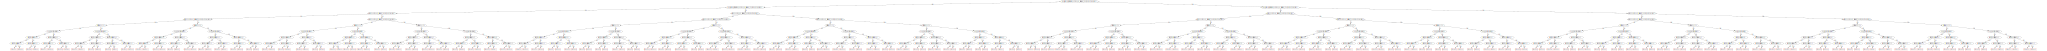

In [43]:
cb_model.plot_tree(tree_idx=40,pool=train_df)

In [44]:
# sorted_feature_importance = cb_model.feature_importances_.argsort()
# plt.barh(cat_boost_df.feature_names[sorted_feature_importance], 
#         cb_model.feature_importances_[sorted_feature_importance], 
#         color='turquoise')
# plt.xlabel("CatBoost Feature Importance")

In [45]:
# cb_regressor.fit(X_train, y_train ,cat_features = cat_features , plot=True , eval_set = (X_test,y_test))